In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}
print("ss")

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tf-models-official

In [ ]:
!pip install tensorflow==2.6.0 tensorflow-gpu==2.6.0

In [6]:
import object_detection

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [7]:
labels = [{'name':'livelong', 'id':1}, {'name':'ok', 'id':2}, {'name':'thankyou', 'id':3}, {'name':'coronavirus', 'id':4}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [ ]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 4. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

# 5. Update Config For Transfer Learning

In [8]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format


In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
config

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=6000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [ ]:
print(command)

In [ ]:
!pip install absl-py==0.12.0

In [ ]:
!{command}

# 7. Evaluate the Model

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

# 8. Load Train Model From Checkpoint

In [9]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [14]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-5')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [11]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [24]:
category_index

{1: {'id': 1, 'name': 'livelong'},
 2: {'id': 2, 'name': 'ok'},
 3: {'id': 3, 'name': 'thankyou'},
 4: {'id': 4, 'name': 'coronavirus'}}

In [25]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'],'test', 'coronavirus.b241213f-2675-11ec-a38d-b0227aeb6221.jpg')

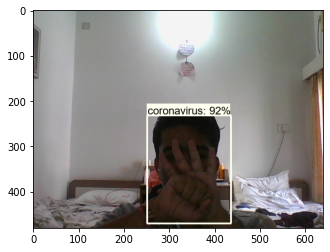

In [26]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from your Webcam

In [ ]:
!pip uninstall opencv-python==4.5.1.48

In [15]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    print(ret,frame)
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

True [[[51 43 44]
  [55 47 48]
  [58 51 52]
  ...
  [77 77 77]
  [77 77 78]
  [78 78 79]]

 [[53 46 46]
  [56 49 49]
  [57 52 51]
  ...
  [80 79 79]
  [82 81 82]
  [83 81 83]]

 [[52 47 45]
  [53 49 47]
  [53 51 48]
  ...
  [82 81 80]
  [83 82 83]
  [82 80 82]]

 ...

 [[36 46 45]
  [36 45 45]
  [35 44 47]
  ...
  [35 34 34]
  [41 41 42]
  [43 43 44]]

 [[33 47 43]
  [33 46 44]
  [32 45 46]
  ...
  [18 19 19]
  [32 33 34]
  [39 40 41]]

 [[30 45 41]
  [29 45 42]
  [29 45 45]
  ...
  [13 15 15]
  [27 29 30]
  [34 36 37]]]
True [[[ 55  58  49]
  [ 59  61  55]
  [ 61  62  60]
  ...
  [ 85  85  83]
  [ 90  87  87]
  [105 101 101]]

 [[ 56  59  51]
  [ 59  61  55]
  [ 60  61  59]
  ...
  [ 86  85  84]
  [ 87  85  85]
  [ 97  94  94]]

 [[ 56  59  53]
  [ 57  60  56]
  [ 57  59  58]
  ...
  [ 90  89  89]
  [ 89  87  87]
  [ 93  91  91]]

 ...

 [[ 50  50  50]
  [ 50  50  50]
  [ 51  51  51]
  ...
  [ 40  39  39]
  [ 48  47  47]
  [ 52  51  51]]

 [[ 50  50  50]
  [ 50  50  50]
  [ 49  49  49

True [[[ 49  55  62]
  [ 52  57  62]
  [ 58  61  63]
  ...
  [ 96 102  85]
  [ 93  98  83]
  [ 91  96  81]]

 [[ 50  55  60]
  [ 53  57  62]
  [ 58  61  63]
  ...
  [ 96 102  85]
  [ 92  97  82]
  [ 90  95  81]]

 [[ 54  58  60]
  [ 55  59  61]
  [ 59  61  62]
  ...
  [ 94  99  84]
  [ 92  96  84]
  [ 91  95  83]]

 ...

 [[ 49  43  57]
  [ 49  45  58]
  [ 49  45  57]
  ...
  [ 46  43  52]
  [ 45  42  50]
  [ 48  46  53]]

 [[ 47  41  55]
  [ 49  44  56]
  [ 49  46  56]
  ...
  [ 46  42  54]
  [ 45  42  52]
  [ 48  45  54]]

 [[ 50  44  56]
  [ 49  44  56]
  [ 50  46  55]
  ...
  [ 45  41  54]
  [ 44  40  52]
  [ 48  45  55]]]
True [[[70 61 50]
  [69 61 51]
  [68 62 54]
  ...
  [82 91 91]
  [82 93 93]
  [82 95 94]]

 [[69 61 51]
  [68 61 52]
  [66 61 53]
  ...
  [82 90 90]
  [82 92 92]
  [82 93 93]]

 [[66 60 52]
  [66 61 53]
  [65 60 55]
  ...
  [85 93 93]
  [85 94 94]
  [85 95 95]]

 ...

 [[46 51 50]
  [47 52 52]
  [47 51 53]
  ...
  [51 51 52]
  [50 51 52]
  [49 50 51]]

 [[49 50 5

True [[[55 50 51]
  [57 53 53]
  [59 55 55]
  ...
  [70 85 77]
  [72 85 80]
  [71 83 79]]

 [[51 47 48]
  [54 50 51]
  [56 52 53]
  ...
  [72 85 79]
  [72 84 80]
  [72 82 79]]

 [[52 49 51]
  [54 51 53]
  [56 53 55]
  ...
  [75 85 82]
  [74 82 81]
  [74 81 81]]

 ...

 [[38 39 53]
  [39 39 52]
  [41 41 52]
  ...
  [34 41 50]
  [32 41 48]
  [31 41 46]]

 [[39 38 56]
  [40 38 55]
  [41 39 55]
  ...
  [35 41 45]
  [35 42 43]
  [35 42 42]]

 [[39 36 56]
  [40 37 56]
  [42 39 56]
  ...
  [35 40 42]
  [37 42 41]
  [39 44 41]]]
True [[[44 49 42]
  [49 51 45]
  [55 54 51]
  ...
  [74 82 70]
  [73 80 67]
  [84 91 78]]

 [[44 48 43]
  [49 50 47]
  [54 52 51]
  ...
  [76 84 74]
  [76 83 73]
  [83 90 80]]

 [[46 48 49]
  [48 49 50]
  [53 51 53]
  ...
  [78 85 81]
  [79 85 81]
  [83 89 85]]

 ...

 [[42 45 50]
  [42 43 50]
  [42 43 50]
  ...
  [41 42 43]
  [42 43 44]
  [43 45 46]]

 [[40 43 50]
  [40 42 49]
  [41 42 50]
  ...
  [42 42 45]
  [41 42 45]
  [41 42 45]]

 [[40 43 50]
  [39 42 50]
  [40 

True [[[47 45 45]
  [51 49 48]
  [56 54 50]
  ...
  [86 89 87]
  [83 85 86]
  [80 82 83]]

 [[48 45 47]
  [53 51 51]
  [57 55 52]
  ...
  [85 88 86]
  [82 84 85]
  [79 81 82]]

 [[51 47 52]
  [55 52 55]
  [56 53 55]
  ...
  [82 85 82]
  [80 82 82]
  [78 80 81]]

 ...

 [[44 40 52]
  [45 41 52]
  [46 42 51]
  ...
  [46 47 51]
  [44 47 49]
  [43 46 48]]

 [[43 40 49]
  [44 41 50]
  [44 41 50]
  ...
  [43 42 48]
  [41 42 47]
  [42 43 47]]

 [[44 41 49]
  [45 42 50]
  [45 42 50]
  ...
  [40 38 44]
  [39 38 44]
  [41 41 47]]]
True [[[47 53 36]
  [49 54 40]
  [51 53 47]
  ...
  [76 81 77]
  [79 83 81]
  [80 84 83]]

 [[50 54 39]
  [52 55 43]
  [53 54 48]
  ...
  [76 84 80]
  [77 86 83]
  [76 85 83]]

 [[51 54 43]
  [53 54 45]
  [55 54 50]
  ...
  [75 90 84]
  [71 88 84]
  [67 85 82]]

 ...

 [[44 42 51]
  [43 42 51]
  [41 42 50]
  ...
  [44 40 51]
  [42 38 49]
  [43 39 50]]

 [[44 42 48]
  [43 42 48]
  [42 42 49]
  ...
  [44 40 52]
  [42 38 50]
  [41 37 49]]

 [[43 42 46]
  [44 43 47]
  [43 

True [[[47 49 43]
  [49 50 44]
  [50 51 45]
  ...
  [78 77 80]
  [80 79 82]
  [74 73 77]]

 [[47 48 43]
  [48 49 44]
  [50 50 45]
  ...
  [78 77 80]
  [82 81 85]
  [81 80 84]]

 [[48 48 46]
  [49 48 46]
  [50 49 46]
  ...
  [77 76 80]
  [81 79 84]
  [85 83 89]]

 ...

 [[42 40 46]
  [42 40 46]
  [43 41 47]
  ...
  [41 35 47]
  [43 35 48]
  [46 38 51]]

 [[41 39 45]
  [42 40 46]
  [43 40 45]
  ...
  [43 33 49]
  [43 33 50]
  [46 35 52]]

 [[41 39 45]
  [42 39 45]
  [42 39 44]
  ...
  [45 35 52]
  [45 33 52]
  [45 33 53]]]
True [[[51 47 35]
  [52 49 39]
  [52 49 42]
  ...
  [75 86 63]
  [76 87 62]
  [73 84 58]]

 [[52 47 37]
  [53 48 39]
  [53 50 43]
  ...
  [73 85 64]
  [76 87 64]
  [76 87 64]]

 [[52 45 39]
  [54 47 41]
  [54 49 44]
  ...
  [72 85 68]
  [74 87 69]
  [75 88 69]]

 ...

 [[34 42 45]
  [35 43 46]
  [37 44 47]
  ...
  [39 35 46]
  [39 36 45]
  [39 36 45]]

 [[31 43 45]
  [33 44 46]
  [34 43 46]
  ...
  [39 36 45]
  [39 37 44]
  [41 39 45]]

 [[32 45 47]
  [33 45 47]
  [33 

True [[[54 46 47]
  [56 47 48]
  [58 47 47]
  ...
  [76 79 77]
  [75 78 76]
  [72 75 73]]

 [[55 49 48]
  [56 49 47]
  [57 49 47]
  ...
  [77 80 77]
  [76 78 75]
  [73 75 73]]

 [[51 50 44]
  [52 50 44]
  [54 51 44]
  ...
  [79 82 78]
  [77 79 76]
  [76 77 75]]

 ...

 [[42 37 51]
  [42 38 51]
  [42 39 51]
  ...
  [41 40 40]
  [43 42 41]
  [44 43 42]]

 [[41 37 50]
  [42 38 50]
  [43 40 50]
  ...
  [43 37 39]
  [45 38 40]
  [45 38 40]]

 [[39 35 47]
  [41 37 49]
  [43 40 49]
  ...
  [47 37 40]
  [48 37 40]
  [47 36 39]]]
True [[[55 44 41]
  [61 51 48]
  [61 53 51]
  ...
  [75 79 68]
  [75 80 69]
  [79 85 74]]

 [[53 44 43]
  [58 49 48]
  [58 51 50]
  ...
  [76 80 71]
  [76 81 71]
  [77 83 73]]

 [[53 48 49]
  [55 50 51]
  [53 50 50]
  ...
  [76 80 72]
  [75 80 73]
  [77 81 75]]

 ...

 [[44 44 47]
  [44 44 47]
  [44 44 47]
  ...
  [41 43 45]
  [43 43 44]
  [45 45 45]]

 [[45 43 46]
  [45 43 46]
  [45 44 47]
  ...
  [41 42 47]
  [42 42 46]
  [43 42 46]]

 [[45 42 44]
  [44 42 44]
  [45 

True [[[53 47 42]
  [55 49 44]
  [57 50 47]
  ...
  [78 79 82]
  [78 81 83]
  [82 85 86]]

 [[52 47 42]
  [54 49 44]
  [56 49 46]
  ...
  [77 79 81]
  [79 82 84]
  [82 85 86]]

 [[52 48 44]
  [53 49 45]
  [55 49 47]
  ...
  [75 77 79]
  [77 80 81]
  [78 81 82]]

 ...

 [[41 36 48]
  [42 37 48]
  [43 39 48]
  ...
  [42 42 49]
  [44 42 51]
  [45 43 52]]

 [[43 35 49]
  [43 36 49]
  [44 38 49]
  ...
  [42 41 48]
  [43 42 49]
  [44 42 49]]

 [[45 36 51]
  [45 37 51]
  [43 37 49]
  ...
  [40 39 45]
  [42 40 46]
  [42 40 46]]]
True [[[58 51 49]
  [58 50 48]
  [60 51 48]
  ...
  [81 85 80]
  [78 82 77]
  [79 83 78]]

 [[58 51 49]
  [57 50 48]
  [57 50 47]
  ...
  [78 81 78]
  [76 79 76]
  [78 81 78]]

 [[56 50 47]
  [56 51 47]
  [55 51 46]
  ...
  [77 79 79]
  [75 77 77]
  [77 79 79]]

 ...

 [[41 44 39]
  [41 44 39]
  [42 44 41]
  ...
  [40 38 54]
  [41 40 53]
  [40 39 50]]

 [[41 43 37]
  [41 43 38]
  [42 43 40]
  ...
  [43 40 53]
  [44 40 52]
  [41 36 47]]

 [[40 42 36]
  [41 43 37]
  [41 

True [[[51 51 51]
  [51 51 51]
  [52 53 51]
  ...
  [79 84 70]
  [78 84 69]
  [79 87 71]]

 [[51 50 50]
  [51 50 50]
  [51 50 49]
  ...
  [76 82 68]
  [76 82 67]
  [76 84 68]]

 [[52 50 52]
  [53 51 52]
  [53 51 51]
  ...
  [76 82 67]
  [75 82 67]
  [74 82 66]]

 ...

 [[41 38 47]
  [42 39 48]
  [43 40 48]
  ...
  [42 43 44]
  [40 41 42]
  [43 44 45]]

 [[40 39 43]
  [41 40 44]
  [42 41 45]
  ...
  [41 44 42]
  [39 43 41]
  [41 46 44]]

 [[42 41 43]
  [41 40 42]
  [41 40 42]
  ...
  [39 43 41]
  [36 42 38]
  [37 44 41]]]
True [[[47 50 51]
  [50 53 54]
  [54 55 56]
  ...
  [79 83 81]
  [78 81 80]
  [77 80 79]]

 [[47 50 51]
  [51 53 54]
  [55 55 56]
  ...
  [76 80 79]
  [77 79 80]
  [78 80 81]]

 [[48 49 50]
  [51 51 52]
  [54 52 54]
  ...
  [77 80 82]
  [77 79 83]
  [77 79 84]]

 ...

 [[46 39 56]
  [45 39 55]
  [46 40 54]
  ...
  [37 42 52]
  [33 39 49]
  [33 40 50]]

 [[46 37 60]
  [45 37 58]
  [46 39 57]
  ...
  [32 41 52]
  [30 40 51]
  [29 39 50]]

 [[46 35 61]
  [45 35 59]
  [47 

True [[[50 50 50]
  [51 51 51]
  [52 52 53]
  ...
  [79 82 77]
  [80 81 78]
  [77 78 76]]

 [[50 50 50]
  [51 51 52]
  [52 52 53]
  ...
  [75 79 74]
  [77 80 76]
  [77 79 76]]

 [[50 51 52]
  [51 52 53]
  [51 51 54]
  ...
  [73 78 73]
  [73 79 74]
  [77 83 78]]

 ...

 [[36 42 44]
  [37 43 46]
  [39 43 46]
  ...
  [33 42 42]
  [30 40 40]
  [32 44 43]]

 [[33 40 45]
  [35 41 46]
  [37 42 47]
  ...
  [33 45 44]
  [28 41 40]
  [32 45 43]]

 [[32 40 47]
  [34 41 47]
  [36 41 46]
  ...
  [31 44 43]
  [26 40 38]
  [30 45 42]]]
True [[[62 50 56]
  [62 50 55]
  [63 51 54]
  ...
  [78 83 79]
  [77 83 76]
  [75 81 74]]

 [[59 48 51]
  [60 49 52]
  [61 49 51]
  ...
  [79 84 79]
  [78 84 78]
  [77 83 76]]

 [[58 48 48]
  [58 48 48]
  [59 49 50]
  ...
  [79 85 79]
  [80 84 79]
  [78 82 77]]

 ...

 [[41 42 49]
  [41 42 49]
  [42 42 49]
  ...
  [39 45 47]
  [34 43 44]
  [32 42 42]]

 [[40 41 49]
  [40 41 49]
  [42 41 50]
  ...
  [37 44 46]
  [34 43 44]
  [34 44 44]]

 [[40 40 50]
  [40 40 50]
  [42 

True [[[58 48 49]
  [57 48 49]
  [55 49 50]
  ...
  [79 79 73]
  [77 76 73]
  [76 75 73]]

 [[58 48 48]
  [58 49 49]
  [56 51 50]
  ...
  [79 79 75]
  [77 77 75]
  [75 74 73]]

 [[59 49 46]
  [58 49 46]
  [56 50 48]
  ...
  [80 81 79]
  [78 78 78]
  [77 78 79]]

 ...

 [[39 40 52]
  [39 40 50]
  [39 40 47]
  ...
  [42 45 46]
  [42 45 47]
  [42 44 48]]

 [[36 37 54]
  [36 38 53]
  [38 40 50]
  ...
  [41 43 45]
  [43 43 47]
  [43 42 48]]

 [[34 35 55]
  [36 38 55]
  [38 41 53]
  ...
  [40 40 43]
  [43 42 46]
  [44 42 48]]]
True [[[57 50 53]
  [58 51 52]
  [59 52 50]
  ...
  [77 79 74]
  [77 80 75]
  [76 80 75]]

 [[55 50 52]
  [55 50 51]
  [57 52 51]
  ...
  [76 79 75]
  [75 79 75]
  [73 78 74]]

 [[51 50 52]
  [52 51 52]
  [54 52 52]
  ...
  [76 80 78]
  [74 81 78]
  [71 79 76]]

 ...

 [[37 42 44]
  [37 42 44]
  [37 42 45]
  ...
  [44 47 45]
  [43 45 42]
  [41 44 39]]

 [[37 40 44]
  [37 40 45]
  [38 41 46]
  ...
  [40 45 40]
  [39 45 38]
  [37 43 35]]

 [[37 39 44]
  [38 40 45]
  [39 

True [[[46 50 37]
  [47 51 39]
  [49 53 42]
  ...
  [68 68 68]
  [70 71 71]
  [77 80 79]]

 [[49 52 39]
  [49 52 40]
  [49 52 41]
  ...
  [79 81 80]
  [76 79 78]
  [79 82 81]]

 [[50 53 40]
  [50 53 41]
  [50 53 42]
  ...
  [80 83 81]
  [76 80 78]
  [77 81 79]]

 ...

 [[42 37 56]
  [41 36 54]
  [41 37 53]
  ...
  [44 42 51]
  [43 42 52]
  [42 42 52]]

 [[42 36 55]
  [41 35 53]
  [41 36 52]
  ...
  [39 39 49]
  [38 39 49]
  [39 40 50]]

 [[41 35 54]
  [41 35 53]
  [42 36 53]
  ...
  [36 37 47]
  [35 38 47]
  [36 39 48]]]
True [[[45 48 46]
  [49 50 47]
  [53 52 48]
  ...
  [81 78 83]
  [81 77 85]
  [83 78 87]]

 [[46 49 44]
  [49 51 46]
  [52 51 47]
  ...
  [76 75 79]
  [78 75 81]
  [82 78 86]]

 [[48 51 43]
  [50 51 44]
  [53 52 45]
  ...
  [77 76 79]
  [78 76 82]
  [83 80 86]]

 ...

 [[39 37 53]
  [40 38 53]
  [41 40 54]
  ...
  [39 39 47]
  [42 42 49]
  [44 44 50]]

 [[37 37 51]
  [37 38 52]
  [39 41 53]
  ...
  [39 40 48]
  [40 41 48]
  [41 42 49]]

 [[37 38 52]
  [36 38 51]
  [36 

True [[[55 53 47]
  [56 54 47]
  [56 55 46]
  ...
  [76 82 87]
  [76 81 87]
  [81 84 92]]

 [[53 50 45]
  [54 52 46]
  [53 52 44]
  ...
  [73 77 82]
  [75 79 84]
  [79 83 89]]

 [[53 50 46]
  [53 51 47]
  [52 51 45]
  ...
  [73 76 78]
  [73 76 80]
  [75 78 82]]

 ...

 [[43 44 45]
  [43 44 45]
  [45 45 46]
  ...
  [37 39 46]
  [38 42 48]
  [40 45 51]]

 [[44 43 46]
  [45 44 47]
  [45 44 47]
  ...
  [35 39 44]
  [34 39 44]
  [34 40 45]]

 [[42 41 45]
  [44 43 47]
  [44 43 47]
  ...
  [33 38 43]
  [32 38 43]
  [32 38 43]]]
True [[[52 51 47]
  [51 50 46]
  [50 49 46]
  ...
  [76 79 78]
  [82 85 83]
  [90 93 91]]

 [[53 51 48]
  [53 50 48]
  [53 50 49]
  ...
  [76 78 76]
  [80 81 78]
  [84 85 82]]

 [[56 50 51]
  [56 50 51]
  [58 51 53]
  ...
  [78 78 74]
  [80 79 75]
  [80 80 74]]

 ...

 [[36 42 44]
  [37 43 45]
  [39 45 45]
  ...
  [35 43 47]
  [37 45 52]
  [38 47 55]]

 [[35 43 44]
  [36 43 43]
  [37 44 44]
  ...
  [35 43 47]
  [36 44 50]
  [38 46 53]]

 [[35 43 43]
  [35 43 43]
  [37 

True [[[48 48 49]
  [49 47 50]
  [52 47 51]
  ...
  [75 77 72]
  [71 75 67]
  [70 75 66]]

 [[51 49 51]
  [52 49 52]
  [53 48 52]
  ...
  [75 76 73]
  [73 76 70]
  [75 79 71]]

 [[54 49 51]
  [54 49 52]
  [54 48 52]
  ...
  [77 77 74]
  [76 78 73]
  [78 80 74]]

 ...

 [[36 41 47]
  [37 41 46]
  [39 41 46]
  ...
  [43 41 43]
  [42 41 41]
  [42 41 41]]

 [[33 41 44]
  [35 42 46]
  [37 41 46]
  ...
  [42 41 42]
  [39 38 38]
  [40 39 39]]

 [[31 40 43]
  [33 41 44]
  [36 41 46]
  ...
  [42 42 43]
  [39 39 39]
  [41 41 41]]]
True [[[55 46 43]
  [57 47 46]
  [59 50 51]
  ...
  [71 86 72]
  [70 88 76]
  [65 85 73]]

 [[55 45 44]
  [56 47 47]
  [57 48 51]
  ...
  [76 87 74]
  [77 91 79]
  [74 90 79]]

 [[56 47 48]
  [56 47 50]
  [56 48 52]
  ...
  [77 82 70]
  [78 85 74]
  [76 83 72]]

 ...

 [[37 41 49]
  [39 42 50]
  [40 42 50]
  ...
  [45 43 50]
  [47 44 53]
  [48 45 54]]

 [[35 37 54]
  [37 38 55]
  [38 38 55]
  ...
  [44 43 50]
  [43 41 50]
  [41 39 49]]

 [[35 36 57]
  [35 36 57]
  [37 

True [[[52 49 45]
  [53 50 46]
  [55 51 49]
  ...
  [71 84 79]
  [69 80 74]
  [68 78 72]]

 [[53 48 45]
  [54 49 47]
  [55 50 49]
  ...
  [71 83 79]
  [72 83 78]
  [73 83 78]]

 [[59 49 48]
  [58 48 48]
  [57 48 49]
  ...
  [71 82 79]
  [72 83 80]
  [74 84 81]]

 ...

 [[42 39 44]
  [42 40 46]
  [42 40 46]
  ...
  [44 47 45]
  [40 44 42]
  [39 43 42]]

 [[41 37 45]
  [42 38 46]
  [44 40 48]
  ...
  [41 44 45]
  [40 43 44]
  [40 43 45]]

 [[43 38 47]
  [44 39 48]
  [45 40 48]
  ...
  [38 41 43]
  [38 41 43]
  [41 43 47]]]
True [[[61 50 52]
  [62 51 53]
  [62 51 53]
  ...
  [84 82 77]
  [77 77 74]
  [81 82 80]]

 [[59 49 50]
  [60 50 51]
  [60 50 51]
  ...
  [83 83 77]
  [77 77 74]
  [78 79 77]]

 [[59 50 50]
  [58 49 49]
  [59 50 50]
  ...
  [82 82 76]
  [79 79 76]
  [79 80 78]]

 ...

 [[39 39 53]
  [40 40 54]
  [41 41 54]
  ...
  [43 41 54]
  [40 38 54]
  [37 35 51]]

 [[36 39 50]
  [37 40 51]
  [40 43 52]
  ...
  [36 38 52]
  [34 37 52]
  [31 34 49]]

 [[35 40 49]
  [35 40 49]
  [38 

True [[[60 50 43]
  [60 50 44]
  [61 49 45]
  ...
  [83 85 85]
  [85 84 85]
  [83 80 82]]

 [[59 49 43]
  [59 48 43]
  [61 49 46]
  ...
  [79 81 80]
  [81 80 80]
  [81 79 80]]

 [[59 48 43]
  [59 48 44]
  [60 49 46]
  ...
  [76 77 74]
  [78 78 76]
  [80 78 77]]

 ...

 [[42 41 45]
  [43 42 46]
  [43 42 45]
  ...
  [36 42 49]
  [36 43 49]
  [36 44 50]]

 [[40 41 42]
  [41 42 43]
  [41 42 43]
  ...
  [33 43 51]
  [31 42 50]
  [30 41 48]]

 [[40 43 42]
  [40 43 42]
  [40 43 42]
  ...
  [30 42 51]
  [26 39 47]
  [26 39 47]]]
True [[[50 50 37]
  [51 51 38]
  [53 53 40]
  ...
  [78 81 80]
  [76 79 78]
  [76 79 78]]

 [[51 51 41]
  [52 52 42]
  [52 52 42]
  ...
  [79 81 81]
  [77 79 79]
  [77 79 79]]

 [[51 52 46]
  [51 52 45]
  [50 52 44]
  ...
  [78 81 82]
  [78 81 82]
  [75 78 79]]

 ...

 [[40 40 50]
  [41 41 51]
  [42 41 51]
  ...
  [45 41 47]
  [48 43 47]
  [45 41 44]]

 [[42 39 55]
  [42 39 55]
  [40 39 53]
  ...
  [42 39 45]
  [45 41 46]
  [43 40 43]]

 [[42 37 58]
  [41 37 56]
  [39 

True [[[49 48 52]
  [50 48 51]
  [51 49 52]
  ...
  [76 83 82]
  [76 84 85]
  [75 82 85]]

 [[52 49 52]
  [53 50 52]
  [54 50 52]
  ...
  [76 85 82]
  [76 85 85]
  [75 84 85]]

 [[54 48 49]
  [57 50 51]
  [57 50 51]
  ...
  [74 85 82]
  [73 85 84]
  [72 84 85]]

 ...

 [[41 42 40]
  [42 43 41]
  [43 44 42]
  ...
  [43 41 50]
  [45 43 53]
  [47 44 56]]

 [[40 43 39]
  [41 43 40]
  [42 43 40]
  ...
  [41 37 45]
  [43 40 50]
  [46 43 53]]

 [[39 43 38]
  [41 44 39]
  [42 44 39]
  ...
  [39 35 43]
  [40 36 45]
  [41 38 48]]]
True [[[61 47 53]
  [60 47 52]
  [60 48 53]
  ...
  [73 79 76]
  [76 78 77]
  [84 84 84]]

 [[58 46 52]
  [57 46 52]
  [59 49 53]
  ...
  [75 82 79]
  [76 79 78]
  [83 84 84]]

 [[53 46 53]
  [54 48 53]
  [57 50 55]
  ...
  [74 82 79]
  [73 79 78]
  [77 81 82]]

 ...

 [[41 36 50]
  [42 38 51]
  [42 39 52]
  ...
  [39 39 52]
  [38 38 51]
  [37 38 51]]

 [[42 37 46]
  [43 38 47]
  [44 40 49]
  ...
  [38 37 53]
  [36 38 53]
  [33 36 51]]

 [[43 36 43]
  [44 38 45]
  [45 

True [[[47 49 36]
  [48 51 38]
  [50 54 39]
  ...
  [80 78 82]
  [79 74 86]
  [78 72 89]]

 [[48 49 39]
  [48 51 40]
  [48 52 40]
  ...
  [81 78 81]
  [80 76 86]
  [81 76 89]]

 [[49 48 44]
  [49 50 44]
  [49 51 45]
  ...
  [82 78 81]
  [83 78 83]
  [84 79 85]]

 ...

 [[43 38 50]
  [44 39 51]
  [45 41 50]
  ...
  [43 44 48]
  [41 43 48]
  [42 44 49]]

 [[43 38 50]
  [43 38 49]
  [44 40 48]
  ...
  [41 44 46]
  [39 41 46]
  [37 39 44]]

 [[45 39 51]
  [45 39 50]
  [44 39 47]
  ...
  [40 43 45]
  [36 38 42]
  [32 34 39]]]
True [[[55 50 51]
  [55 50 51]
  [54 49 50]
  ...
  [80 80 78]
  [79 78 78]
  [81 81 81]]

 [[52 48 49]
  [52 48 49]
  [53 50 50]
  ...
  [84 84 82]
  [81 81 80]
  [81 81 81]]

 [[50 47 49]
  [50 47 49]
  [50 49 49]
  ...
  [84 85 83]
  [82 83 81]
  [79 80 78]]

 ...

 [[40 36 48]
  [41 38 50]
  [43 40 52]
  ...
  [38 38 51]
  [40 38 51]
  [42 39 52]]

 [[40 39 47]
  [41 40 48]
  [41 41 48]
  ...
  [37 36 49]
  [42 38 51]
  [45 40 53]]

 [[40 40 46]
  [41 41 47]
  [41 

True [[[54 48 49]
  [56 49 50]
  [58 50 51]
  ...
  [85 84 78]
  [87 83 78]
  [86 82 77]]

 [[56 48 49]
  [58 50 51]
  [60 51 51]
  ...
  [80 81 76]
  [83 81 77]
  [85 82 78]]

 [[59 46 49]
  [61 48 50]
  [62 51 51]
  ...
  [73 76 73]
  [77 78 76]
  [82 83 81]]

 ...

 [[43 41 48]
  [43 41 48]
  [42 40 47]
  ...
  [38 43 49]
  [42 44 51]
  [42 43 51]]

 [[42 40 50]
  [42 40 50]
  [43 40 49]
  ...
  [36 42 48]
  [40 43 51]
  [41 42 51]]

 [[41 39 51]
  [43 41 52]
  [44 41 50]
  ...
  [35 41 48]
  [38 41 50]
  [38 38 48]]]
True [[[49 47 47]
  [48 47 46]
  [50 50 47]
  ...
  [57 78 70]
  [58 79 70]
  [62 83 74]]

 [[50 48 47]
  [50 49 47]
  [51 51 48]
  ...
  [62 81 74]
  [63 83 75]
  [66 86 77]]

 [[49 48 45]
  [50 49 46]
  [52 51 47]
  ...
  [67 86 81]
  [67 86 80]
  [70 89 83]]

 ...

 [[44 38 53]
  [44 38 52]
  [43 38 50]
  ...
  [42 44 42]
  [43 45 42]
  [44 47 43]]

 [[43 37 52]
  [43 37 51]
  [43 38 49]
  ...
  [40 43 41]
  [41 45 43]
  [42 47 45]]

 [[43 36 51]
  [43 36 50]
  [43 

True [[[58 53 51]
  [57 52 50]
  [56 52 47]
  ...
  [84 80 81]
  [88 81 83]
  [89 80 83]]

 [[55 51 47]
  [56 52 48]
  [56 52 47]
  ...
  [80 78 78]
  [83 78 80]
  [84 78 80]]

 [[53 50 42]
  [55 52 45]
  [56 52 47]
  ...
  [77 78 76]
  [79 78 78]
  [79 77 77]]

 ...

 [[38 37 53]
  [39 39 54]
  [41 40 54]
  ...
  [39 38 48]
  [38 38 49]
  [39 39 50]]

 [[33 38 51]
  [35 40 53]
  [38 40 54]
  ...
  [37 38 42]
  [37 39 44]
  [38 40 45]]

 [[29 37 50]
  [33 40 53]
  [36 41 54]
  ...
  [36 38 40]
  [38 41 43]
  [41 43 47]]]
True [[[55 44 54]
  [58 46 55]
  [61 48 54]
  ...
  [81 86 78]
  [79 85 78]
  [80 85 80]]

 [[56 46 53]
  [59 48 54]
  [61 48 53]
  ...
  [80 85 77]
  [78 84 77]
  [79 84 79]]

 [[56 47 50]
  [57 47 50]
  [60 49 51]
  ...
  [79 83 74]
  [78 83 75]
  [78 83 76]]

 ...

 [[38 37 53]
  [38 38 52]
  [38 39 50]
  ...
  [45 39 47]
  [48 42 49]
  [49 42 49]]

 [[36 37 54]
  [36 38 53]
  [37 39 50]
  ...
  [42 36 54]
  [45 39 57]
  [44 38 57]]

 [[33 35 53]
  [34 37 52]
  [35 

True [[[60 49 38]
  [60 50 40]
  [61 51 44]
  ...
  [76 77 75]
  [77 79 78]
  [81 84 83]]

 [[57 47 38]
  [59 49 41]
  [60 51 44]
  ...
  [77 77 77]
  [77 78 79]
  [79 80 81]]

 [[55 46 40]
  [57 49 43]
  [60 52 47]
  ...
  [79 78 81]
  [79 77 82]
  [79 77 83]]

 ...

 [[40 41 50]
  [39 39 49]
  [40 39 49]
  ...
  [37 39 49]
  [38 40 51]
  [41 43 55]]

 [[40 42 46]
  [39 41 46]
  [40 40 47]
  ...
  [35 40 50]
  [35 40 52]
  [36 42 54]]

 [[37 40 41]
  [38 41 43]
  [40 41 45]
  ...
  [31 37 47]
  [30 37 49]
  [32 40 53]]]
True [[[60 48 37]
  [62 51 41]
  [63 53 44]
  ...
  [71 82 80]
  [77 80 79]
  [78 76 76]]

 [[60 47 39]
  [61 49 42]
  [63 52 45]
  ...
  [73 83 80]
  [77 80 78]
  [77 76 75]]

 [[60 46 44]
  [61 48 46]
  [61 49 47]
  ...
  [74 81 78]
  [78 80 77]
  [79 79 76]]

 ...

 [[43 40 42]
  [43 41 43]
  [44 42 44]
  ...
  [39 42 41]
  [41 43 41]
  [43 45 43]]

 [[42 39 41]
  [42 40 42]
  [43 41 43]
  ...
  [41 41 41]
  [43 43 41]
  [47 47 45]]

 [[42 39 41]
  [42 40 42]
  [43 

True [[[47 48 52]
  [49 48 51]
  [52 49 52]
  ...
  [82 82 86]
  [79 81 85]
  [78 80 84]]

 [[50 49 52]
  [51 49 52]
  [53 49 51]
  ...
  [79 80 84]
  [76 78 82]
  [76 80 83]]

 [[51 48 50]
  [53 49 51]
  [54 49 51]
  ...
  [77 79 83]
  [74 79 82]
  [74 80 83]]

 ...

 [[44 38 49]
  [43 38 49]
  [43 40 49]
  ...
  [41 40 46]
  [40 38 47]
  [41 39 49]]

 [[44 39 47]
  [44 40 48]
  [44 42 49]
  ...
  [43 40 46]
  [41 38 47]
  [41 38 48]]

 [[43 39 45]
  [44 41 47]
  [45 42 48]
  ...
  [43 40 46]
  [42 38 47]
  [41 38 48]]]
True [[[45 50 41]
  [48 52 44]
  [51 54 46]
  ...
  [76 81 77]
  [75 80 75]
  [75 80 75]]

 [[48 52 44]
  [49 53 46]
  [52 54 48]
  ...
  [77 82 78]
  [74 79 75]
  [73 78 73]]

 [[50 52 47]
  [51 52 49]
  [53 53 50]
  ...
  [77 80 77]
  [74 76 73]
  [73 75 72]]

 ...

 [[41 38 50]
  [42 39 51]
  [44 40 53]
  ...
  [37 35 45]
  [39 37 46]
  [39 38 46]]

 [[40 35 50]
  [42 37 52]
  [44 39 54]
  ...
  [37 36 49]
  [38 37 50]
  [38 37 49]]

 [[39 33 50]
  [41 35 52]
  [43 

True [[[46 50 49]
  [46 50 49]
  [48 49 49]
  ...
  [83 78 73]
  [85 77 75]
  [84 74 74]]

 [[44 46 44]
  [47 48 46]
  [50 49 48]
  ...
  [81 77 72]
  [85 79 75]
  [84 76 73]]

 [[47 45 42]
  [50 46 44]
  [52 47 46]
  ...
  [79 79 70]
  [82 80 72]
  [83 80 72]]

 ...

 [[42 40 43]
  [43 42 45]
  [45 44 47]
  ...
  [12 13 11]
  [11 11 10]
  [ 9  9  9]]

 [[41 40 41]
  [44 43 44]
  [45 45 46]
  ...
  [12 13 10]
  [13 14 12]
  [13 14 12]]

 [[45 43 43]
  [44 43 43]
  [44 43 43]
  ...
  [13 14 10]
  [13 14 11]
  [13 14 12]]]
True [[[52 42 59]
  [53 43 59]
  [54 45 58]
  ...
  [78 78 76]
  [78 78 76]
  [81 80 78]]

 [[50 42 56]
  [51 43 56]
  [52 44 55]
  ...
  [78 78 76]
  [78 78 76]
  [80 80 78]]

 [[49 44 53]
  [50 44 52]
  [50 44 51]
  ...
  [77 77 75]
  [77 76 75]
  [79 78 78]]

 ...

 [[23 25 33]
  [27 28 36]
  [31 31 38]
  ...
  [ 9 11  6]
  [ 8 10  4]
  [ 7  9  3]]

 [[24 22 32]
  [28 26 35]
  [31 30 37]
  ...
  [ 7  8  6]
  [ 7  9  4]
  [ 6  8  3]]

 [[25 22 32]
  [29 26 35]
  [31 

True [[[ 5 10  0]
  [ 5 10  0]
  [ 5  9  0]
  ...
  [75 83 83]
  [70 79 79]
  [71 81 81]]

 [[ 3  9  0]
  [ 3  9  0]
  [ 4  9  0]
  ...
  [72 81 81]
  [66 77 78]
  [68 79 80]]

 [[ 1  9  0]
  [ 1  8  0]
  [ 1  8  0]
  ...
  [68 80 79]
  [65 79 79]
  [65 79 80]]

 ...

 [[42 36 42]
  [41 36 41]
  [43 38 43]
  ...
  [ 7  8  5]
  [ 9 10  7]
  [ 9 10  7]]

 [[45 32 47]
  [45 33 46]
  [44 34 47]
  ...
  [ 8  9  5]
  [ 9 10  6]
  [ 9 10  6]]

 [[47 31 49]
  [46 31 49]
  [45 33 49]
  ...
  [ 7  9  4]
  [ 8 10  5]
  [ 8 10  5]]]
True [[[ 1 14 12]
  [ 4 15 13]
  [ 6 15 13]
  ...
  [74 82 76]
  [74 82 76]
  [72 80 74]]

 [[ 2 15 13]
  [ 3 15 13]
  [ 6 16 14]
  ...
  [66 74 70]
  [69 78 73]
  [72 81 75]]

 [[ 0 16 13]
  [ 1 16 14]
  [ 3 16 15]
  ...
  [66 75 72]
  [68 77 73]
  [71 80 76]]

 ...

 [[41 31 48]
  [42 32 48]
  [42 33 47]
  ...
  [27 34 38]
  [29 35 40]
  [30 36 41]]

 [[42 32 44]
  [43 34 45]
  [42 34 45]
  ...
  [25 34 44]
  [25 35 45]
  [25 35 45]]

 [[41 32 42]
  [41 32 42]
  [41 

True [[[  0  34  32]
  [  0  36  34]
  [  2  36  36]
  ...
  [153 147 145]
  [156 149 146]
  [157 150 147]]

 [[  0  31  29]
  [  0  31  30]
  [  1  33  32]
  ...
  [151 147 145]
  [153 148 146]
  [154 149 146]]

 [[  0  29  28]
  [  1  30  29]
  [  4  31  31]
  ...
  [149 147 146]
  [149 148 145]
  [150 149 146]]

 ...

 [[ 15  16  14]
  [ 15  16  14]
  [ 15  16  14]
  ...
  [ 87  89  96]
  [ 90  92  99]
  [ 93  95 103]]

 [[ 13  14  11]
  [ 13  14  11]
  [ 14  15  12]
  ...
  [ 86  90  96]
  [ 86  91  97]
  [ 87  92  98]]

 [[ 10  12   7]
  [ 11  13   8]
  [ 12  14   9]
  ...
  [ 85  90  95]
  [ 81  87  93]
  [ 79  85  92]]]
True [[[  1  18  15]
  [  2  19  17]
  [  3  19  19]
  ...
  [148 153 145]
  [150 155 147]
  [151 156 149]]

 [[  0  18  15]
  [  1  19  17]
  [  2  19  19]
  ...
  [146 151 143]
  [147 151 145]
  [147 151 146]]

 [[  1  19  17]
  [  1  20  18]
  [  2  21  19]
  ...
  [148 152 147]
  [149 152 149]
  [149 152 150]]

 ...

 [[ 12  12  12]
  [ 13  13  13]
  [ 13  15

True [[[ 5  4  0]
  [ 6  5  1]
  [ 7  6  2]
  ...
  [63 61 65]
  [62 60 64]
  [64 60 65]]

 [[ 4  4  1]
  [ 5  5  2]
  [ 6  6  3]
  ...
  [61 59 62]
  [60 58 61]
  [62 59 62]]

 [[ 5  4  3]
  [ 4  5  3]
  [ 4  5  3]
  ...
  [61 59 62]
  [60 58 61]
  [63 60 63]]

 ...

 [[ 4  5  2]
  [ 5  6  3]
  [ 5  6  3]
  ...
  [27 31 29]
  [27 32 30]
  [26 32 30]]

 [[ 3  6  1]
  [ 3  6  2]
  [ 4  6  3]
  ...
  [27 31 29]
  [27 32 28]
  [25 31 27]]

 [[ 2  6  1]
  [ 2  6  1]
  [ 3  6  3]
  ...
  [28 32 28]
  [27 32 27]
  [26 31 26]]]
True [[[ 5  6  3]
  [ 5  6  3]
  [ 4  6  3]
  ...
  [65 63 63]
  [63 61 61]
  [63 61 61]]

 [[ 4  5  3]
  [ 4  5  3]
  [ 3  5  3]
  ...
  [64 62 62]
  [62 60 60]
  [62 61 61]]

 [[ 5  5  6]
  [ 5  5  6]
  [ 5  5  6]
  ...
  [63 61 61]
  [60 59 59]
  [62 61 61]]

 ...

 [[ 4  4  2]
  [ 7  7  5]
  [ 8  8  6]
  ...
  [31 32 37]
  [29 30 33]
  [27 29 30]]

 [[ 5  4  4]
  [ 7  6  5]
  [ 8  8  6]
  ...
  [29 29 35]
  [29 30 33]
  [27 29 30]]

 [[ 6  4  4]
  [ 8  6  6]
  [ 8 

True [[[ 1  4  5]
  [ 2  5  6]
  [ 1  5  4]
  ...
  [58 61 52]
  [59 62 53]
  [59 62 53]]

 [[ 2  5  6]
  [ 3  6  7]
  [ 2  6  5]
  ...
  [59 62 54]
  [59 62 55]
  [58 60 54]]

 [[ 2  6  5]
  [ 3  7  6]
  [ 2  6  5]
  ...
  [60 63 58]
  [59 61 58]
  [57 59 57]]

 ...

 [[ 0  5  4]
  [ 0  5  4]
  [ 0  6  3]
  ...
  [24 30 29]
  [23 29 28]
  [23 29 28]]

 [[ 0  4  3]
  [ 0  5  3]
  [ 0  6  3]
  ...
  [23 29 26]
  [21 28 25]
  [22 29 26]]

 [[ 0  6  4]
  [ 0  6  4]
  [ 0  6  3]
  ...
  [21 27 24]
  [20 27 24]
  [21 28 25]]]
True [[[ 4  5  2]
  [ 4  5  2]
  [ 4  5  2]
  ...
  [55 55 56]
  [54 56 54]
  [55 58 56]]

 [[ 5  6  4]
  [ 4  5  3]
  [ 3  4  2]
  ...
  [55 56 57]
  [54 57 56]
  [55 58 56]]

 [[ 5  5  5]
  [ 4  4  4]
  [ 3  3  3]
  ...
  [53 55 57]
  [51 54 55]
  [52 55 56]]

 ...

 [[ 3  3  3]
  [ 3  3  3]
  [ 4  4  4]
  ...
  [27 25 27]
  [28 26 26]
  [31 29 29]]

 [[ 4  5  3]
  [ 4  5  3]
  [ 4  5  3]
  ...
  [29 26 29]
  [28 26 27]
  [29 27 27]]

 [[ 4  5  2]
  [ 4  5  2]
  [ 5 

True [[[ 2  5  2]
  [ 2  5  2]
  [ 2  7  3]
  ...
  [46 59 57]
  [47 60 58]
  [49 62 60]]

 [[ 5  7  4]
  [ 3  6  3]
  [ 1  5  2]
  ...
  [50 60 58]
  [50 60 58]
  [52 61 59]]

 [[ 8  9  6]
  [ 4  6  3]
  [ 1  4  1]
  ...
  [57 60 59]
  [55 58 57]
  [57 58 58]]

 ...

 [[ 5  6  6]
  [ 4  5  5]
  [ 5  6  4]
  ...
  [26 28 30]
  [26 27 30]
  [25 27 31]]

 [[ 5  5  5]
  [ 6  6  6]
  [ 7  6  6]
  ...
  [23 26 28]
  [23 27 29]
  [24 28 31]]

 [[ 4  4  4]
  [ 6  5  5]
  [ 6  5  5]
  ...
  [22 26 28]
  [22 27 29]
  [23 28 31]]]
True [[[ 4  8  3]
  [ 4  8  3]
  [ 3  6  3]
  ...
  [52 60 59]
  [52 59 59]
  [50 56 56]]

 [[ 5  9  5]
  [ 5  8  5]
  [ 4  7  5]
  ...
  [51 59 58]
  [54 61 61]
  [56 63 63]]

 [[ 5  8  6]
  [ 5  8  6]
  [ 5  8  6]
  ...
  [51 60 58]
  [52 60 59]
  [53 61 60]]

 ...

 [[ 1  4  3]
  [ 2  5  4]
  [ 4  7  6]
  ...
  [28 30 28]
  [28 29 29]
  [27 28 28]]

 [[ 0  4  2]
  [ 1  5  3]
  [ 3  6  4]
  ...
  [27 31 30]
  [27 30 31]
  [26 29 30]]

 [[ 3  8  4]
  [ 2  7  3]
  [ 2 

  [30 38 38]]]
True [[[ 8 12  1]
  [ 9 13  2]
  [ 9 12  3]
  ...
  [61 67 66]
  [58 64 64]
  [62 68 68]]

 [[ 8 11  2]
  [ 8 11  2]
  [ 8 11  2]
  ...
  [62 68 67]
  [58 64 64]
  [60 66 66]]

 [[ 7  9  3]
  [ 7  9  3]
  [ 7  9  3]
  ...
  [62 67 65]
  [58 63 62]
  [59 64 63]]

 ...

 [[ 9  5  0]
  [ 9  5  0]
  [ 9  6  1]
  ...
  [34 35 36]
  [35 38 37]
  [37 41 40]]

 [[ 9  6  0]
  [ 9  6  0]
  [ 8  7  0]
  ...
  [32 35 36]
  [32 37 35]
  [35 41 38]]

 [[ 9  6  0]
  [10  7  0]
  [ 9  9  0]
  ...
  [31 36 36]
  [31 37 35]
  [32 39 35]]]
True [[[ 6  8  2]
  [ 6  8  2]
  [ 6  8  2]
  ...
  [63 66 58]
  [62 65 57]
  [59 62 53]]

 [[ 6  8  2]
  [ 6  8  2]
  [ 6  8  2]
  ...
  [64 67 62]
  [63 66 60]
  [64 68 61]]

 [[ 6  8  3]
  [ 6  8  3]
  [ 6  7  4]
  ...
  [62 66 64]
  [61 65 63]
  [62 66 64]]

 ...

 [[ 1  5  0]
  [ 2  6  1]
  [ 3  7  2]
  ...
  [38 41 42]
  [36 40 41]
  [34 39 39]]

 [[ 1  5  1]
  [ 3  7  3]
  [ 4  8  3]
  ...
  [37 38 38]
  [35 37 37]
  [32 36 35]]

 [[ 1  4  1]
  [ 

True [[[ 5  9  0]
  [ 6 10  0]
  [ 7 11  0]
  ...
  [62 65 54]
  [60 63 52]
  [66 67 57]]

 [[ 5  9  0]
  [ 6 10  0]
  [ 7 11  0]
  ...
  [64 68 57]
  [61 65 54]
  [66 69 58]]

 [[ 6  9  0]
  [ 6  9  0]
  [ 6  9  1]
  ...
  [62 68 57]
  [58 64 52]
  [60 67 54]]

 ...

 [[ 3  5  0]
  [ 5  7  2]
  [ 5  7  1]
  ...
  [37 37 38]
  [38 36 38]
  [39 37 39]]

 [[ 2  4  2]
  [ 4  6  4]
  [ 6  7  4]
  ...
  [34 34 34]
  [35 35 35]
  [38 37 37]]

 [[ 2  5  4]
  [ 4  6  5]
  [ 6  7  5]
  ...
  [35 35 35]
  [34 34 34]
  [34 34 34]]]
True [[[10 13  0]
  [ 9 13  0]
  [ 9 12  0]
  ...
  [66 65 65]
  [67 66 66]
  [67 67 67]]

 [[ 9 12  0]
  [ 9 12  0]
  [ 8 12  1]
  ...
  [65 65 65]
  [64 65 65]
  [63 64 64]]

 [[ 8 10  1]
  [ 7 10  2]
  [ 8 10  4]
  ...
  [62 64 64]
  [61 65 64]
  [58 63 62]]

 ...

 [[ 2  7  0]
  [ 3  8  1]
  [ 4  7  1]
  ...
  [34 35 36]
  [36 37 35]
  [39 39 36]]

 [[ 2  8  0]
  [ 3  9  1]
  [ 3  9  2]
  ...
  [35 36 37]
  [37 36 35]
  [37 37 34]]

 [[ 4 11  1]
  [ 4 11  2]
  [ 3 

True [[[ 8  6  6]
  [ 8  7  7]
  [ 8  7  7]
  ...
  [65 69 61]
  [64 67 59]
  [64 66 60]]

 [[ 7  6  6]
  [ 7  6  6]
  [ 7  7  7]
  ...
  [65 69 62]
  [64 66 60]
  [64 65 60]]

 [[ 5  6  6]
  [ 5  6  6]
  [ 6  7  7]
  ...
  [65 66 63]
  [64 64 62]
  [62 62 60]]

 ...

 [[ 5  6  1]
  [ 4  4  0]
  [ 4  4  1]
  ...
  [37 34 43]
  [38 35 45]
  [38 35 45]]

 [[ 5  6  0]
  [ 5  6  0]
  [ 5  6  1]
  ...
  [38 35 45]
  [36 33 45]
  [34 31 43]]

 [[ 5  7  1]
  [ 5  7  1]
  [ 6  8  3]
  ...
  [36 33 43]
  [35 32 44]
  [33 31 43]]]
True [[[ 1  2  0]
  [ 2  3  0]
  [ 3  4  1]
  ...
  [56 70 63]
  [58 70 64]
  [60 72 66]]

 [[ 2  3  0]
  [ 3  4  1]
  [ 2  4  1]
  ...
  [55 67 62]
  [55 67 62]
  [57 68 63]]

 [[ 0  3  0]
  [ 0  4  0]
  [ 0  4  0]
  ...
  [58 68 65]
  [58 68 65]
  [59 68 65]]

 ...

 [[ 7  2  1]
  [ 8  4  2]
  [ 9  6  3]
  ...
  [38 37 36]
  [38 37 36]
  [39 38 38]]

 [[ 8  1  2]
  [10  4  3]
  [11  6  4]
  ...
  [36 36 33]
  [37 37 35]
  [37 36 35]]

 [[10  2  3]
  [13  5  5]
  [13 

True [[[11 10  6]
  [10  9  5]
  [10 10  4]
  ...
  [64 67 65]
  [61 65 64]
  [60 64 63]]

 [[ 9  8  4]
  [ 9  8  4]
  [10 10  4]
  ...
  [65 69 67]
  [63 67 66]
  [60 65 64]]

 [[ 9  8  5]
  [ 9  8  5]
  [ 9  8  4]
  ...
  [67 71 70]
  [64 69 68]
  [60 66 65]]

 ...

 [[ 0  4  0]
  [ 1  5  0]
  [ 1  5  0]
  ...
  [35 37 35]
  [35 38 36]
  [37 40 37]]

 [[ 0  5  0]
  [ 0  7  1]
  [ 1  7  0]
  ...
  [35 40 36]
  [35 40 36]
  [36 41 37]]

 [[ 0  6  0]
  [ 0  8  2]
  [ 2  9  2]
  ...
  [35 40 35]
  [35 40 36]
  [34 39 35]]]
True [[[ 5 12  2]
  [ 4 10  2]
  [ 5 10  2]
  ...
  [65 69 68]
  [65 69 68]
  [67 71 70]]

 [[ 4 11  1]
  [ 3 10  0]
  [ 4  9  1]
  ...
  [65 69 68]
  [66 70 69]
  [67 71 70]]

 [[ 6 12  1]
  [ 5 11  1]
  [ 5 10  1]
  ...
  [68 70 68]
  [67 70 69]
  [68 71 70]]

 ...

 [[ 2  2  2]
  [ 3  3  3]
  [ 4  4  4]
  ...
  [38 40 42]
  [39 40 43]
  [40 41 45]]

 [[ 2  3  1]
  [ 3  4  2]
  [ 4  5  3]
  ...
  [35 37 39]
  [36 37 40]
  [37 38 42]]

 [[ 2  3  0]
  [ 3  4  1]
  [ 4 

True [[[ 7 11  0]
  [ 6 10  0]
  [ 6  9  0]
  ...
  [63 67 66]
  [61 64 63]
  [62 65 64]]

 [[ 7 11  0]
  [ 6 10  0]
  [ 6  9  0]
  ...
  [62 67 67]
  [61 64 65]
  [62 65 66]]

 [[ 6 11  1]
  [ 6 10  1]
  [ 6 10  2]
  ...
  [61 66 68]
  [62 66 68]
  [64 68 70]]

 ...

 [[ 5  6  4]
  [ 5  6  4]
  [ 5  6  4]
  ...
  [36 35 37]
  [38 38 39]
  [39 39 39]]

 [[ 4  4  5]
  [ 4  4  4]
  [ 4  4  4]
  ...
  [36 35 38]
  [36 35 37]
  [37 37 38]]

 [[ 5  4  6]
  [ 5  5  6]
  [ 4  4  4]
  ...
  [37 36 39]
  [36 35 38]
  [37 36 38]]]
True [[[ 4 11  1]
  [ 4 11  2]
  [ 3  9  1]
  ...
  [64 66 64]
  [65 65 65]
  [66 66 66]]

 [[ 4 11  1]
  [ 4 11  1]
  [ 3  9  1]
  ...
  [64 67 64]
  [64 66 64]
  [63 64 62]]

 [[ 5 12  0]
  [ 5 11  0]
  [ 5  9  0]
  ...
  [67 72 67]
  [67 71 66]
  [67 70 65]]

 ...

 [[ 1  6  0]
  [ 2  6  0]
  [ 3  6  0]
  ...
  [37 40 37]
  [35 38 35]
  [32 36 32]]

 [[ 2  8  0]
  [ 2  8  0]
  [ 3  8  0]
  ...
  [36 41 37]
  [35 40 36]
  [33 38 33]]

 [[ 3 10  0]
  [ 4 11  0]
  [ 3 

True [[[  6   9   0]
  [  7  10   1]
  [  8  11   2]
  ...
  [105 108 100]
  [106 109 101]
  [107 109 103]]

 [[  7   9   1]
  [  8  10   2]
  [  9  11   3]
  ...
  [105 108 100]
  [106 109 101]
  [107 110 102]]

 [[  6   7   0]
  [  7   8   1]
  [  9  10   3]
  ...
  [103 107  98]
  [104 108 100]
  [105 109 101]]

 ...

 [[  7   6   3]
  [  8   7   4]
  [  9   8   5]
  ...
  [ 49  48  52]
  [ 50  49  53]
  [ 53  52  56]]

 [[  7   6   2]
  [  8   7   3]
  [  9   8   4]
  ...
  [ 49  48  50]
  [ 50  50  51]
  [ 52  52  53]]

 [[  7   6   2]
  [  9   8   4]
  [  9   8   4]
  ...
  [ 47  47  48]
  [ 48  48  48]
  [ 48  48  48]]]
True [[[  7   9   3]
  [  8  10   4]
  [  8  10   4]
  ...
  [105 108 106]
  [104 107 108]
  [104 107 108]]

 [[  7   9   3]
  [  8  10   4]
  [  7   9   3]
  ...
  [105 108 105]
  [104 107 106]
  [102 106 105]]

 [[  7  10   6]
  [  8  11   6]
  [  8  10   4]
  ...
  [107 109 104]
  [105 107 104]
  [105 107 104]]

 ...

 [[  5   7   2]
  [  6   7   3]
  [  6   7

True [[[ 4  6  1]
  [ 5  7  2]
  [ 4  7  2]
  ...
  [62 65 63]
  [63 66 65]
  [62 65 64]]

 [[ 5  5  1]
  [ 4  5  1]
  [ 3  6  1]
  ...
  [64 66 64]
  [65 67 65]
  [66 68 67]]

 [[ 5  5  2]
  [ 5  5  2]
  [ 5  6  2]
  ...
  [64 65 63]
  [65 66 64]
  [65 66 64]]

 ...

 [[ 3  5  3]
  [ 3  5  2]
  [ 4  7  2]
  ...
  [36 36 36]
  [38 38 38]
  [40 40 40]]

 [[ 3  3  3]
  [ 3  4  2]
  [ 3  5  0]
  ...
  [35 35 36]
  [35 35 36]
  [36 36 37]]

 [[ 2  2  2]
  [ 2  3  1]
  [ 3  4  1]
  ...
  [35 34 36]
  [34 33 35]
  [34 33 35]]]
True [[[ 3  3  3]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [63 67 62]
  [62 66 60]
  [65 70 63]]

 [[ 4  4  4]
  [ 5  5  5]
  [ 5  5  5]
  ...
  [60 67 61]
  [59 66 59]
  [62 69 62]]

 [[ 5  6  4]
  [ 5  6  4]
  [ 4  5  3]
  ...
  [55 67 59]
  [53 66 58]
  [54 68 60]]

 ...

 [[ 5  5  1]
  [ 5  5  2]
  [ 4  5  2]
  ...
  [36 38 36]
  [38 40 38]
  [38 40 38]]

 [[ 3  7  0]
  [ 3  7  0]
  [ 2  5  0]
  ...
  [31 36 32]
  [32 38 34]
  [33 39 35]]

 [[ 1  6  0]
  [ 1  6  0]
  [ 1 

True [[[ 2  9  0]
  [ 2  8  0]
  [ 3  9  0]
  ...
  [85 92 82]
  [87 92 81]
  [86 90 79]]

 [[ 3  9  0]
  [ 2  8  0]
  [ 2  8  0]
  ...
  [86 92 84]
  [87 92 84]
  [88 92 83]]

 [[ 3  8  0]
  [ 2  7  0]
  [ 1  7  0]
  ...
  [85 92 88]
  [86 92 87]
  [86 92 87]]

 ...

 [[ 1  5  3]
  [ 2  6  4]
  [ 3  7  5]
  ...
  [50 53 54]
  [50 54 52]
  [50 53 50]]

 [[ 2  5  4]
  [ 3  6  5]
  [ 3  6  5]
  ...
  [48 50 58]
  [49 50 57]
  [47 49 54]]

 [[ 2  5  4]
  [ 2  5  4]
  [ 3  6  5]
  ...
  [45 47 59]
  [47 48 59]
  [45 45 55]]]
True [[[ 2  7  3]
  [ 2  7  3]
  [ 3  6  3]
  ...
  [84 90 77]
  [86 91 74]
  [89 93 74]]

 [[ 2  7  3]
  [ 1  6  2]
  [ 2  6  2]
  ...
  [84 89 78]
  [85 90 75]
  [86 91 74]]

 [[ 2  7  2]
  [ 2  7  2]
  [ 2  6  1]
  ...
  [86 91 83]
  [86 91 80]
  [86 91 80]]

 ...

 [[ 5  4  4]
  [ 5  5  5]
  [ 5  6  6]
  ...
  [52 52 52]
  [54 54 54]
  [54 54 54]]

 [[ 5  4  4]
  [ 6  5  5]
  [ 6  6  6]
  ...
  [53 51 51]
  [55 53 52]
  [55 53 52]]

 [[ 6  4  4]
  [ 6  5  5]
  [ 8 

True [[[ 14  19  10]
  [ 19  21  12]
  [ 25  23  12]
  ...
  [ 31  25   9]
  [ 29  24  11]
  [ 31  27  16]]

 [[ 18  23  15]
  [ 20  23  15]
  [ 24  21  13]
  ...
  [ 30  27  13]
  [ 27  26  15]
  [ 28  28  18]]

 [[ 21  25  20]
  [ 23  24  21]
  [ 27  23  21]
  ...
  [ 25  29  17]
  [ 24  30  22]
  [ 22  30  24]]

 ...

 [[158 157 154]
  [158 157 154]
  [158 157 154]
  ...
  [106 104 110]
  [101  98 104]
  [ 98  95 101]]

 [[159 159 153]
  [158 158 153]
  [157 156 152]
  ...
  [102 101 107]
  [ 97  96 102]
  [ 97  96 102]]

 [[158 158 152]
  [156 156 150]
  [155 154 150]
  ...
  [ 98  98 104]
  [ 93  93  99]
  [ 93  93  99]]]
True [[[ 74  77  52]
  [ 74  76  53]
  [ 72  74  54]
  ...
  [ 62  39  37]
  [ 68  38  38]
  [ 69  35  36]]

 [[ 74  76  53]
  [ 73  75  53]
  [ 72  74  55]
  ...
  [ 60  41  34]
  [ 66  40  34]
  [ 69  40  34]]

 [[ 77  78  58]
  [ 76  77  58]
  [ 74  76  58]
  ...
  [ 56  43  28]
  [ 59  43  24]
  [ 61  43  22]]

 ...

 [[141 141 142]
  [142 142 143]
  [145 144

True [[[246 237 240]
  [246 237 240]
  [245 237 240]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[244 236 240]
  [244 236 240]
  [243 236 240]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[239 234 239]
  [240 235 240]
  [241 236 241]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[ 65  58  75]
  [ 65  57  74]
  [ 64  54  71]
  ...
  [ 69  70  68]
  [ 69  71  69]
  [ 68  71  70]]

 [[ 64  57  74]
  [ 64  56  73]
  [ 64  54  70]
  ...
  [ 70  70  67]
  [ 68  70  68]
  [ 67  70  69]]

 [[ 63  57  74]
  [ 63  56  73]
  [ 65  55  71]
  ...
  [ 70  70  67]
  [ 67  69  67]
  [ 65  68  67]]]
True [[[236 223 239]
  [236 222 238]
  [236 221 237]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[234 221 237]
  [234 221 237]
  [234 220 235]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 [[234 222 238]
  [234 222 237]
  [235 222 237]
  ...
  [244 244 244]
  [244 244 244]
  [244 244 244]]

 ...

 [[ 66  49  73]
  [ 64  49  71]
  [ 63  50

True [[[147 137 127]
  [150 139 129]
  [153 140 132]
  ...
  [189 188 177]
  [191 190 177]
  [193 192 178]]

 [[147 137 127]
  [149 139 129]
  [153 141 133]
  ...
  [190 190 177]
  [190 190 174]
  [189 189 173]]

 [[147 138 127]
  [150 140 130]
  [154 143 134]
  ...
  [188 190 172]
  [189 190 171]
  [189 190 170]]

 ...

 [[152 144 140]
  [153 145 142]
  [153 145 142]
  ...
  [ 34  31  33]
  [ 36  33  35]
  [ 38  35  37]]

 [[150 144 142]
  [150 144 142]
  [150 144 142]
  ...
  [ 34  31  34]
  [ 33  29  34]
  [ 32  28  33]]

 [[149 144 143]
  [150 145 143]
  [151 146 144]
  ...
  [ 33  29  34]
  [ 33  29  35]
  [ 33  29  35]]]
True [[[139 115 120]
  [139 117 122]
  [138 121 124]
  ...
  [167 171 166]
  [167 172 168]
  [168 173 170]]

 [[139 116 121]
  [139 118 123]
  [139 122 125]
  ...
  [167 171 167]
  [168 172 168]
  [168 172 170]]

 [[137 117 120]
  [139 120 123]
  [140 124 126]
  ...
  [169 170 167]
  [169 171 168]
  [170 172 170]]

 ...

 [[136 129 126]
  [138 131 128]
  [138 131

True [[[ 61  61  48]
  [ 61  61  49]
  [ 63  61  51]
  ...
  [ 85 102  94]
  [ 84 102  96]
  [ 83 101  96]]

 [[ 62  61  50]
  [ 62  61  51]
  [ 63  61  51]
  ...
  [ 88 103  96]
  [ 86 102  96]
  [ 86 101  96]]

 [[ 63  60  52]
  [ 63  60  52]
  [ 62  60  53]
  ...
  [ 91 102  96]
  [ 89 101  95]
  [ 89 101  95]]

 ...

 [[ 60  63  68]
  [ 62  64  68]
  [ 66  69  71]
  ...
  [  8  12   8]
  [  8  12   8]
  [  6  11   7]]

 [[ 58  61  70]
  [ 61  63  71]
  [ 68  69  76]
  ...
  [  8  12  11]
  [ 10  15  14]
  [ 11  16  15]]

 [[ 60  62  73]
  [ 60  62  73]
  [ 66  68  76]
  ...
  [  8  12  13]
  [  9  14  15]
  [ 10  16  16]]]
True [[[ 58  54  52]
  [ 59  56  54]
  [ 60  58  57]
  ...
  [ 93 100  86]
  [ 97 101  86]
  [103 106  91]]

 [[ 57  55  54]
  [ 59  57  56]
  [ 60  58  57]
  ...
  [ 94 101  88]
  [ 96 100  88]
  [ 99 102  90]]

 [[ 56  58  59]
  [ 57  58  58]
  [ 58  58  58]
  ...
  [ 94 101  92]
  [ 94  99  90]
  [ 94  99  90]]

 ...

 [[ 70  67  76]
  [ 68  65  74]
  [ 67  64

True [[[67 51 51]
  [67 51 52]
  [67 52 54]
  ...
  [93 97 92]
  [93 98 94]
  [94 99 96]]

 [[64 50 51]
  [65 51 53]
  [64 51 54]
  ...
  [92 97 93]
  [92 96 94]
  [91 96 94]]

 [[63 52 55]
  [63 52 55]
  [63 51 56]
  ...
  [92 96 95]
  [91 96 95]
  [89 95 95]]

 ...

 [[49 64 64]
  [53 66 66]
  [56 65 66]
  ...
  [15 18 22]
  [18 21 23]
  [19 22 24]]

 [[51 67 67]
  [52 65 66]
  [54 64 65]
  ...
  [11 16 21]
  [13 17 22]
  [18 21 25]]

 [[49 65 66]
  [52 65 67]
  [56 65 68]
  ...
  [14 20 26]
  [12 17 22]
  [16 20 25]]]
True [[[ 58  56  56]
  [ 56  55  55]
  [ 55  54  54]
  ...
  [ 86  97  85]
  [ 85  97  89]
  [ 84  96  90]]

 [[ 57  56  56]
  [ 56  55  55]
  [ 54  54  54]
  ...
  [ 86  98  87]
  [ 87  99  92]
  [ 86  98  93]]

 [[ 56  55  56]
  [ 55  55  56]
  [ 55  55  55]
  ...
  [ 89 100  92]
  [ 88 100  95]
  [ 88 101  97]]

 ...

 [[ 64  58  70]
  [ 65  59  71]
  [ 65  59  70]
  ...
  [ 21  20  20]
  [ 18  17  17]
  [ 20  18  18]]

 [[ 62  54  71]
  [ 63  55  72]
  [ 64  57  71

True [[[ 61  55  60]
  [ 60  54  59]
  [ 61  55  61]
  ...
  [ 96  99  91]
  [ 95  98  90]
  [ 96  98  92]]

 [[ 63  55  62]
  [ 63  55  62]
  [ 62  55  63]
  ...
  [ 94  97  89]
  [ 98 100  94]
  [102 104  98]]

 [[ 67  54  66]
  [ 66  54  66]
  [ 64  55  66]
  ...
  [ 94  96  90]
  [ 97  99  93]
  [101 103  98]]

 ...

 [[ 71  63  71]
  [ 72  64  71]
  [ 73  66  71]
  ...
  [  7  11   6]
  [  7  11   7]
  [  7  11   9]]

 [[ 70  56  81]
  [ 71  58  80]
  [ 71  59  77]
  ...
  [  9  14   9]
  [  7  13   9]
  [  7  13  10]]

 [[ 72  55  88]
  [ 71  55  85]
  [ 70  56  81]
  ...
  [ 11  17  12]
  [  9  16  12]
  [  8  15  12]]]
True [[[ 87  66  61]
  [ 85  65  61]
  [ 82  62  60]
  ...
  [108 110 102]
  [108 111 100]
  [106 108  96]]

 [[ 81  65  59]
  [ 80  64  59]
  [ 78  62  59]
  ...
  [106 109 101]
  [108 111 100]
  [108 111  99]]

 [[ 73  66  57]
  [ 72  65  57]
  [ 72  64  58]
  ...
  [104 107  99]
  [105 109  98]
  [108 111 100]]

 ...

 [[ 74  71  80]
  [ 74  71  80]
  [ 73  70

True [[[57 58 43]
  [58 59 46]
  [59 60 50]
  ...
  [87 91 90]
  [90 92 90]
  [93 94 92]]

 [[56 56 43]
  [57 58 46]
  [59 59 50]
  ...
  [87 92 91]
  [89 92 90]
  [93 95 93]]

 [[57 56 45]
  [59 58 48]
  [59 58 51]
  ...
  [85 92 92]
  [88 93 92]
  [90 95 94]]

 ...

 [[61 63 68]
  [62 64 69]
  [62 64 69]
  ...
  [22 21 24]
  [22 21 24]
  [24 23 26]]

 [[60 61 73]
  [60 61 72]
  [61 62 72]
  ...
  [23 22 24]
  [23 23 24]
  [25 25 26]]

 [[57 58 73]
  [58 59 73]
  [59 59 72]
  ...
  [23 23 24]
  [24 24 24]
  [26 26 26]]]
True [[[ 57  55  45]
  [ 59  56  48]
  [ 59  57  50]
  ...
  [ 88  97  88]
  [ 88  97  87]
  [ 90 100  88]]

 [[ 56  52  44]
  [ 57  54  46]
  [ 58  56  49]
  ...
  [ 88  96  88]
  [ 86  95  85]
  [ 87  96  86]]

 [[ 56  50  44]
  [ 58  53  47]
  [ 59  56  51]
  ...
  [ 88  96  89]
  [ 86  95  86]
  [ 86  95  86]]

 ...

 [[ 62  53  76]
  [ 62  54  75]
  [ 61  55  73]
  ...
  [ 24  26  28]
  [ 24  25  29]
  [ 24  25  29]]

 [[ 61  55  77]
  [ 61  55  76]
  [ 61  55  73

True [[[ 53  54  44]
  [ 53  54  45]
  [ 56  55  49]
  ...
  [ 85  93  86]
  [ 90  96  92]
  [ 95 100  96]]

 [[ 53  55  47]
  [ 55  55  49]
  [ 56  54  51]
  ...
  [ 87  95  89]
  [ 90  96  93]
  [ 92  97  96]]

 [[ 54  54  51]
  [ 54  53  52]
  [ 55  52  54]
  ...
  [ 90  97  94]
  [ 90  96  96]
  [ 90  95  97]]

 ...

 [[ 61  61  61]
  [ 62  62  62]
  [ 62  61  63]
  ...
  [ 18  19  17]
  [ 20  22  17]
  [ 27  28  22]]

 [[ 58  59  66]
  [ 60  61  68]
  [ 62  62  69]
  ...
  [ 21  21  21]
  [ 25  25  22]
  [ 29  30  25]]

 [[ 58  60  71]
  [ 58  60  71]
  [ 59  60  70]
  ...
  [ 24  23  23]
  [ 26  26  23]
  [ 29  28  24]]]
True [[[58 55 57]
  [58 56 57]
  [57 55 54]
  ...
  [91 96 92]
  [90 93 91]
  [88 91 90]]

 [[59 56 58]
  [58 55 57]
  [58 56 55]
  ...
  [93 98 93]
  [93 96 94]
  [92 95 93]]

 [[58 55 57]
  [58 55 57]
  [58 56 56]
  ...
  [92 96 91]
  [93 97 92]
  [92 96 92]]

 ...

 [[69 63 62]
  [69 62 63]
  [68 62 64]
  ...
  [29 28 29]
  [28 27 28]
  [31 30 31]]

 [[75 67 6

True [[[58 53 51]
  [59 54 52]
  [57 53 51]
  ...
  [90 93 92]
  [91 94 93]
  [93 96 95]]

 [[59 54 53]
  [58 54 53]
  [58 54 53]
  ...
  [88 92 90]
  [89 93 91]
  [90 94 93]]

 [[57 54 54]
  [57 54 54]
  [57 55 55]
  ...
  [89 95 91]
  [89 95 92]
  [89 95 92]]

 ...

 [[60 60 66]
  [61 60 66]
  [63 62 66]
  ...
  [27 28 25]
  [27 29 26]
  [33 36 31]]

 [[59 59 66]
  [60 59 66]
  [61 60 64]
  ...
  [28 31 28]
  [27 31 27]
  [27 32 28]]

 [[57 57 64]
  [58 57 64]
  [60 59 63]
  ...
  [27 30 28]
  [26 31 28]
  [27 32 29]]]
True [[[47 58 50]
  [48 58 52]
  [50 58 55]
  ...
  [91 97 86]
  [91 97 86]
  [90 96 85]]

 [[46 55 48]
  [48 56 50]
  [50 56 54]
  ...
  [90 97 87]
  [89 96 86]
  [88 95 85]]

 [[50 55 51]
  [50 54 52]
  [52 56 55]
  ...
  [88 97 91]
  [86 96 90]
  [85 95 89]]

 ...

 [[55 61 67]
  [56 61 67]
  [57 61 67]
  ...
  [26 30 29]
  [24 27 26]
  [31 34 33]]

 [[56 62 65]
  [58 61 65]
  [60 60 64]
  ...
  [24 31 30]
  [23 29 28]
  [25 31 30]]

 [[56 61 64]
  [58 61 63]
  [62 

True [[[55 54 50]
  [57 57 53]
  [60 60 57]
  ...
  [86 94 94]
  [83 91 95]
  [83 91 97]]

 [[56 56 53]
  [58 58 55]
  [60 61 59]
  ...
  [87 97 94]
  [84 94 95]
  [84 95 97]]

 [[56 55 55]
  [56 56 56]
  [58 58 59]
  ...
  [86 99 91]
  [82 97 90]
  [82 96 91]]

 ...

 [[60 63 71]
  [61 63 71]
  [63 62 69]
  ...
  [44 49 62]
  [41 48 60]
  [43 51 63]]

 [[55 62 66]
  [56 62 65]
  [59 61 65]
  ...
  [47 47 64]
  [46 47 64]
  [48 51 66]]

 [[53 63 65]
  [55 62 64]
  [58 61 63]
  ...
  [46 44 64]
  [48 48 66]
  [50 50 68]]]
True [[[ 53  53  53]
  [ 57  56  56]
  [ 59  57  59]
  ...
  [ 86  97  92]
  [ 83  98  91]
  [ 84 100  93]]

 [[ 54  54  55]
  [ 57  56  58]
  [ 59  57  60]
  ...
  [ 86  95  91]
  [ 84  96  91]
  [ 83  96  90]]

 [[ 56  56  60]
  [ 57  56  62]
  [ 58  56  63]
  ...
  [ 88  94  90]
  [ 87  94  90]
  [ 86  94  90]]

 ...

 [[ 60  54  69]
  [ 61  55  70]
  [ 62  56  70]
  ...
  [ 40  49  63]
  [ 41  50  64]
  [ 43  52  66]]

 [[ 63  54  71]
  [ 63  54  70]
  [ 63  55  70

True [[[ 52  57  50]
  [ 52  56  49]
  [ 53  55  49]
  ...
  [ 84  97  89]
  [ 84  99  89]
  [ 85 101  90]]

 [[ 52  56  50]
  [ 53  56  50]
  [ 54  56  50]
  ...
  [ 84  96  90]
  [ 84  97  89]
  [ 83  98  88]]

 [[ 52  56  52]
  [ 54  57  53]
  [ 56  57  54]
  ...
  [ 86  97  92]
  [ 86  97  91]
  [ 86  98  90]]

 ...

 [[ 54  61  60]
  [ 56  62  62]
  [ 59  62  64]
  ...
  [ 47  55  59]
  [ 46  54  58]
  [ 46  54  58]]

 [[ 52  60  60]
  [ 54  60  62]
  [ 57  60  64]
  ...
  [ 46  54  51]
  [ 44  51  51]
  [ 44  51  51]]

 [[ 51  59  59]
  [ 55  61  63]
  [ 58  61  65]
  ...
  [ 43  51  45]
  [ 43  50  47]
  [ 44  50  49]]]
True [[[55 54 50]
  [56 56 52]
  [56 57 52]
  ...
  [87 93 92]
  [90 96 93]
  [93 98 95]]

 [[54 53 50]
  [56 55 52]
  [56 56 53]
  ...
  [88 93 91]
  [89 95 92]
  [90 95 92]]

 [[56 54 54]
  [57 55 55]
  [58 56 55]
  ...
  [90 96 93]
  [90 96 93]
  [90 95 92]]

 ...

 [[63 61 64]
  [62 60 63]
  [62 61 61]
  ...
  [51 50 56]
  [51 50 58]
  [50 49 58]]

 [[60 62 6

True [[[ 66  63  59]
  [ 66  63  59]
  [ 68  64  62]
  ...
  [ 94 106 101]
  [ 94 107 101]
  [ 95 110 103]]

 [[ 64  63  59]
  [ 64  63  60]
  [ 66  64  63]
  ...
  [ 97 108 103]
  [ 95 109 102]
  [ 95 109 102]]

 [[ 62  63  60]
  [ 62  63  61]
  [ 64  65  63]
  ...
  [ 98 108 102]
  [ 98 110 102]
  [ 96 109 101]]

 ...

 [[ 73  71  74]
  [ 74  72  75]
  [ 73  71  74]
  ...
  [ 16  19  18]
  [ 15  18  17]
  [ 15  18  17]]

 [[ 70  68  71]
  [ 71  69  72]
  [ 72  70  73]
  ...
  [ 15  19  18]
  [ 14  18  17]
  [ 14  18  17]]

 [[ 73  70  72]
  [ 73  70  72]
  [ 72  69  71]
  ...
  [ 16  20  19]
  [ 15  19  18]
  [ 16  20  19]]]
True [[[ 71  65  66]
  [ 71  66  65]
  [ 72  67  65]
  ...
  [105 108 107]
  [105 108 107]
  [105 108 107]]

 [[ 72  67  66]
  [ 72  67  65]
  [ 72  68  64]
  ...
  [104 107 106]
  [106 109 108]
  [108 110 110]]

 [[ 71  68  64]
  [ 71  68  64]
  [ 73  69  64]
  ...
  [104 108 107]
  [105 108 109]
  [105 108 109]]

 ...

 [[ 73  73  77]
  [ 74  74  78]
  [ 75  75

True [[[ 63  64  62]
  [ 66  66  64]
  [ 71  68  68]
  ...
  [115 109 106]
  [117 110 108]
  [118 111 110]]

 [[ 63  64  62]
  [ 66  65  65]
  [ 69  67  67]
  ...
  [113 109 105]
  [115 109 107]
  [114 108 106]]

 [[ 65  66  67]
  [ 67  67  68]
  [ 69  67  70]
  ...
  [112 109 104]
  [111 108 103]
  [111 107 102]]

 ...

 [[ 74  78  77]
  [ 74  78  77]
  [ 75  79  78]
  ...
  [ 14  14  14]
  [ 15  15  16]
  [ 16  16  17]]

 [[ 75  78  77]
  [ 74  77  76]
  [ 73  74  74]
  ...
  [ 14  14  14]
  [ 17  17  18]
  [ 19  18  20]]

 [[ 73  76  75]
  [ 75  76  76]
  [ 74  74  74]
  ...
  [ 15  15  15]
  [ 17  17  18]
  [ 19  18  20]]]
True [[[ 75  64  67]
  [ 75  64  67]
  [ 75  66  67]
  ...
  [108 111 105]
  [109 111 106]
  [109 111 106]]

 [[ 72  62  65]
  [ 73  63  66]
  [ 73  65  66]
  ...
  [110 113 107]
  [109 111 106]
  [109 111 106]]

 [[ 69  62  63]
  [ 71  64  65]
  [ 73  66  67]
  ...
  [109 112 106]
  [108 110 105]
  [109 111 106]]

 ...

 [[ 76  74  76]
  [ 80  78  80]
  [ 84  82

True [[[60 56 56]
  [60 55 57]
  [59 53 58]
  ...
  [84 94 88]
  [86 95 88]
  [88 96 89]]

 [[59 56 56]
  [59 55 57]
  [59 54 59]
  ...
  [86 96 90]
  [88 97 91]
  [88 97 90]]

 [[56 54 56]
  [56 54 56]
  [57 55 58]
  ...
  [86 97 91]
  [86 96 91]
  [86 96 91]]

 ...

 [[63 61 64]
  [64 62 65]
  [65 63 66]
  ...
  [20 17 16]
  [22 18 17]
  [25 20 19]]

 [[63 61 64]
  [63 62 64]
  [64 64 65]
  ...
  [17 16 16]
  [19 17 17]
  [21 18 18]]

 [[62 62 63]
  [63 63 64]
  [63 64 64]
  ...
  [15 14 14]
  [17 16 16]
  [19 17 17]]]
True [[[ 51  54  53]
  [ 52  53  54]
  [ 56  54  57]
  ...
  [ 90 101  85]
  [ 91 101  85]
  [ 90  99  83]]

 [[ 52  55  53]
  [ 54  55  55]
  [ 57  55  57]
  ...
  [ 91 100  86]
  [ 92 100  86]
  [ 92  99  85]]

 [[ 52  56  52]
  [ 54  56  53]
  [ 56  56  56]
  ...
  [ 90  96  85]
  [ 93  97  86]
  [ 94  96  86]]

 ...

 [[ 64  62  64]
  [ 63  60  62]
  [ 65  60  63]
  ...
  [ 18  16  16]
  [ 20  18  18]
  [ 24  22  22]]

 [[ 61  57  67]
  [ 61  57  66]
  [ 63  57  66

True [[[50 47 57]
  [56 52 61]
  [58 53 59]
  ...
  [95 99 84]
  [95 98 86]
  [97 98 88]]

 [[50 47 56]
  [54 51 58]
  [56 52 57]
  ...
  [94 99 85]
  [94 97 85]
  [95 97 87]]

 [[52 51 55]
  [54 52 55]
  [55 52 55]
  ...
  [93 98 86]
  [91 96 85]
  [91 95 86]]

 ...

 [[64 59 64]
  [63 59 64]
  [62 59 64]
  ...
  [15 15 15]
  [19 19 19]
  [22 22 22]]

 [[61 59 63]
  [61 59 63]
  [61 60 64]
  ...
  [17 17 18]
  [20 20 21]
  [22 22 23]]

 [[60 59 63]
  [60 59 63]
  [60 60 64]
  ...
  [18 17 19]
  [19 18 20]
  [19 18 20]]]
True [[[54 54 48]
  [59 59 53]
  [60 59 55]
  ...
  [86 93 90]
  [88 94 91]
  [93 98 95]]

 [[56 55 49]
  [58 57 51]
  [58 57 53]
  ...
  [87 93 89]
  [89 94 90]
  [91 96 93]]

 [[59 55 51]
  [59 56 52]
  [58 55 51]
  ...
  [91 95 90]
  [91 95 91]
  [91 94 92]]

 ...

 [[63 59 69]
  [64 58 69]
  [67 60 71]
  ...
  [16 15 15]
  [16 15 14]
  [18 17 16]]

 [[62 58 67]
  [62 58 67]
  [64 59 68]
  ...
  [17 16 16]
  [19 18 18]
  [24 23 23]]

 [[63 60 69]
  [63 59 67]
  [63 

True [[[59 56 42]
  [60 57 43]
  [61 58 44]
  ...
  [80 95 88]
  [80 95 90]
  [81 96 92]]

 [[58 55 44]
  [59 56 45]
  [61 58 47]
  ...
  [82 96 91]
  [81 96 92]
  [83 98 94]]

 [[58 54 49]
  [58 55 50]
  [60 57 52]
  ...
  [84 98 94]
  [84 98 94]
  [84 98 95]]

 ...

 [[69 59 58]
  [70 62 60]
  [68 63 62]
  ...
  [19 19 16]
  [20 21 19]
  [21 23 21]]

 [[70 60 56]
  [70 61 58]
  [68 62 60]
  ...
  [19 16 16]
  [20 18 18]
  [21 20 21]]

 [[71 60 56]
  [69 60 56]
  [69 62 60]
  ...
  [17 12 13]
  [19 15 17]
  [21 18 20]]]
True [[[55 57 45]
  [58 60 49]
  [59 60 52]
  ...
  [91 95 93]
  [93 96 95]
  [92 95 94]]

 [[56 58 49]
  [59 60 51]
  [59 59 53]
  ...
  [93 98 95]
  [93 97 95]
  [92 95 94]]

 [[57 57 54]
  [59 59 56]
  [59 57 56]
  ...
  [92 98 94]
  [92 96 94]
  [90 94 93]]

 ...

 [[68 56 74]
  [68 57 74]
  [66 56 72]
  ...
  [18 17 16]
  [20 19 18]
  [19 18 17]]

 [[66 54 73]
  [67 55 74]
  [66 56 72]
  ...
  [16 15 15]
  [20 19 19]
  [21 20 20]]

 [[66 54 74]
  [67 55 74]
  [67 

True [[[50 53 52]
  [51 53 54]
  [52 53 56]
  ...
  [85 99 95]
  [85 99 95]
  [84 98 94]]

 [[51 53 54]
  [52 54 56]
  [53 53 57]
  ...
  [84 98 93]
  [84 98 93]
  [83 97 92]]

 [[51 51 57]
  [53 52 58]
  [53 52 59]
  ...
  [82 97 92]
  [81 97 91]
  [80 96 89]]

 ...

 [[66 63 68]
  [66 64 68]
  [65 63 66]
  ...
  [19 18 18]
  [20 19 19]
  [22 21 21]]

 [[62 61 67]
  [62 62 66]
  [63 63 67]
  ...
  [18 17 18]
  [21 20 20]
  [21 20 20]]

 [[62 62 68]
  [62 63 68]
  [62 63 67]
  ...
  [17 14 16]
  [22 20 20]
  [22 20 20]]]
True [[[53 48 49]
  [57 53 54]
  [63 60 62]
  ...
  [88 97 94]
  [86 95 93]
  [83 92 90]]

 [[56 52 53]
  [58 54 56]
  [60 57 59]
  ...
  [86 96 93]
  [84 95 93]
  [82 93 91]]

 [[56 53 55]
  [55 52 54]
  [56 53 55]
  ...
  [82 96 92]
  [82 97 94]
  [81 96 93]]

 ...

 [[62 58 70]
  [62 58 70]
  [62 59 68]
  ...
  [18 18 19]
  [21 21 21]
  [22 22 22]]

 [[61 58 70]
  [60 58 69]
  [60 58 67]
  ...
  [14 15 15]
  [17 19 17]
  [20 22 20]]

 [[59 57 69]
  [59 58 69]
  [59 

True [[[ 55  56  47]
  [ 55  56  48]
  [ 54  54  47]
  ...
  [ 92  97  76]
  [ 93  99  75]
  [ 95 101  76]]

 [[ 55  56  50]
  [ 56  56  50]
  [ 55  55  50]
  ...
  [ 93  98  81]
  [ 92  97  78]
  [ 92  98  77]]

 [[ 56  55  55]
  [ 55  54  53]
  [ 57  54  53]
  ...
  [ 95  97  88]
  [ 93  96  85]
  [ 92  95  84]]

 ...

 [[ 59  63  69]
  [ 59  62  69]
  [ 59  61  69]
  ...
  [ 20  17  22]
  [ 21  18  23]
  [ 24  22  26]]

 [[ 56  64  71]
  [ 57  63  72]
  [ 58  62  71]
  ...
  [ 21  19  23]
  [ 20  18  22]
  [ 20  18  22]]

 [[ 52  62  70]
  [ 53  61  70]
  [ 56  62  72]
  ...
  [ 17  16  20]
  [ 18  17  21]
  [ 21  20  24]]]
True [[[ 60  54  41]
  [ 60  54  43]
  [ 61  53  46]
  ...
  [ 95  99  83]
  [ 95 100  82]
  [ 95  99  80]]

 [[ 58  54  44]
  [ 60  55  47]
  [ 62  56  51]
  ...
  [ 91  96  82]
  [ 91  95  80]
  [ 90  94  78]]

 [[ 55  52  48]
  [ 59  56  53]
  [ 62  58  57]
  ...
  [ 91  94  86]
  [ 89  92  83]
  [ 89  91  82]]

 ...

 [[ 57  58  63]
  [ 59  59  63]
  [ 61  60

True [[[58 51 56]
  [60 53 57]
  [59 54 57]
  ...
  [91 96 86]
  [90 92 84]
  [94 94 88]]

 [[58 51 56]
  [58 52 57]
  [58 53 56]
  ...
  [93 98 87]
  [92 94 85]
  [96 97 90]]

 [[56 51 57]
  [58 53 58]
  [57 54 57]
  ...
  [94 98 87]
  [92 95 85]
  [95 97 88]]

 ...

 [[60 61 62]
  [60 61 62]
  [61 62 63]
  ...
  [15 14 17]
  [16 14 17]
  [17 15 18]]

 [[62 61 60]
  [62 61 60]
  [63 62 62]
  ...
  [13 12 16]
  [14 13 17]
  [17 14 19]]

 [[64 63 61]
  [63 61 60]
  [63 61 61]
  ...
  [14 13 17]
  [15 13 19]
  [17 15 21]]]
True [[[ 54  57  48]
  [ 56  58  52]
  [ 57  58  56]
  ...
  [ 87  92  88]
  [ 87  90  88]
  [ 90  93  92]]

 [[ 55  56  49]
  [ 56  57  52]
  [ 57  56  55]
  ...
  [ 90  96  92]
  [ 89  93  91]
  [ 88  92  91]]

 [[ 54  54  50]
  [ 56  56  54]
  [ 57  55  57]
  ...
  [ 92 100  97]
  [ 91  99  96]
  [ 87  94  93]]

 ...

 [[ 62  61  61]
  [ 63  62  63]
  [ 64  61  66]
  ...
  [ 13  14  14]
  [ 18  18  18]
  [ 19  19  19]]

 [[ 62  61  61]
  [ 63  61  63]
  [ 64  61  67

True [[[51 56 49]
  [53 58 51]
  [54 58 53]
  ...
  [82 92 90]
  [81 93 91]
  [84 97 95]]

 [[51 55 49]
  [53 57 52]
  [55 59 54]
  ...
  [87 95 94]
  [85 96 94]
  [86 97 95]]

 [[51 55 51]
  [53 56 53]
  [54 57 55]
  ...
  [88 95 95]
  [87 94 94]
  [86 94 94]]

 ...

 [[62 56 70]
  [62 57 70]
  [64 58 69]
  ...
  [15 15 18]
  [15 15 19]
  [20 20 24]]

 [[61 55 69]
  [62 56 68]
  [62 56 67]
  ...
  [16 14 20]
  [18 16 22]
  [21 19 26]]

 [[63 57 69]
  [62 56 68]
  [61 56 65]
  ...
  [12 10 16]
  [17 15 22]
  [18 15 24]]]
True [[[ 57  55  44]
  [ 59  55  47]
  [ 62  55  53]
  ...
  [ 84 100  93]
  [ 81 102  94]
  [ 77 100  92]]

 [[ 56  56  44]
  [ 59  57  48]
  [ 60  55  53]
  ...
  [ 83 100  94]
  [ 80 100  94]
  [ 76  99  92]]

 [[ 55  58  46]
  [ 57  58  48]
  [ 58  56  52]
  ...
  [ 81  98  95]
  [ 79  99  96]
  [ 76  99  95]]

 ...

 [[ 68  63  61]
  [ 68  63  61]
  [ 66  62  61]
  ...
  [ 17  19  13]
  [ 22  25  17]
  [ 22  25  16]]

 [[ 67  62  61]
  [ 67  62  62]
  [ 64  60  61

True [[[52 55 52]
  [55 56 54]
  [57 55 55]
  ...
  [93 97 86]
  [90 94 82]
  [94 98 85]]

 [[55 56 54]
  [57 56 55]
  [59 56 56]
  ...
  [93 97 85]
  [90 94 82]
  [93 97 84]]

 [[59 55 55]
  [60 56 56]
  [62 55 56]
  ...
  [93 97 85]
  [92 96 84]
  [93 97 84]]

 ...

 [[59 56 75]
  [60 57 76]
  [61 59 76]
  ...
  [12 15 14]
  [16 19 18]
  [18 22 21]]

 [[57 54 74]
  [58 55 75]
  [61 58 78]
  ...
  [10 19 17]
  [11 21 19]
  [13 23 21]]

 [[58 55 75]
  [58 55 75]
  [59 55 77]
  ...
  [ 8 19 17]
  [ 8 20 18]
  [ 7 20 18]]]
True [[[52 53 43]
  [54 55 46]
  [58 58 51]
  ...
  [86 98 96]
  [82 98 95]
  [82 99 96]]

 [[54 56 48]
  [55 56 49]
  [56 57 51]
  ...
  [86 97 95]
  [82 96 94]
  [82 98 95]]

 [[56 56 53]
  [56 56 53]
  [55 55 53]
  ...
  [85 94 92]
  [82 94 92]
  [82 95 93]]

 ...

 [[57 62 61]
  [57 62 61]
  [57 60 61]
  ...
  [18 17 17]
  [20 19 19]
  [21 20 21]]

 [[56 63 62]
  [56 63 62]
  [56 62 62]
  ...
  [18 16 18]
  [19 17 20]
  [19 17 20]]

 [[55 64 62]
  [54 62 61]
  [54 

True [[[55 56 53]
  [55 56 53]
  [54 55 52]
  ...
  [95 97 95]
  [94 95 93]
  [92 93 91]]

 [[54 55 52]
  [55 56 53]
  [56 57 54]
  ...
  [93 95 93]
  [93 94 92]
  [93 93 91]]

 [[54 55 51]
  [55 56 52]
  [56 57 53]
  ...
  [93 94 92]
  [94 94 92]
  [95 95 93]]

 ...

 [[55 59 67]
  [57 61 69]
  [57 60 69]
  ...
  [18 17 15]
  [20 19 16]
  [25 23 20]]

 [[48 59 63]
  [51 62 66]
  [51 59 66]
  ...
  [16 17 12]
  [19 20 15]
  [19 20 14]]

 [[44 60 61]
  [48 62 64]
  [49 60 65]
  ...
  [16 18 12]
  [19 21 15]
  [18 20 14]]]
True [[[58 53 51]
  [59 54 53]
  [59 54 56]
  ...
  [92 96 88]
  [90 92 86]
  [92 94 89]]

 [[57 53 51]
  [58 55 54]
  [60 56 58]
  ...
  [91 95 87]
  [92 94 89]
  [94 95 91]]

 [[53 54 50]
  [55 56 53]
  [58 57 57]
  ...
  [93 96 88]
  [93 95 90]
  [97 98 95]]

 ...

 [[67 60 64]
  [66 60 64]
  [65 61 64]
  ...
  [19 17  9]
  [32 30 19]
  [43 42 30]]

 [[64 58 63]
  [66 60 65]
  [66 61 66]
  ...
  [20 21  9]
  [32 33 18]
  [40 41 25]]

 [[64 57 64]
  [65 59 65]
  [64 

True [[[63 55 56]
  [63 56 57]
  [63 57 58]
  ...
  [88 97 88]
  [86 95 86]
  [87 96 86]]

 [[60 54 55]
  [61 55 56]
  [59 56 56]
  ...
  [88 97 88]
  [86 96 87]
  [86 96 86]]

 [[57 55 55]
  [57 55 55]
  [57 56 56]
  ...
  [88 98 89]
  [87 97 88]
  [87 98 88]]

 ...

 [[65 58 62]
  [64 58 62]
  [64 58 62]
  ...
  [13 13 12]
  [14 15 13]
  [16 17 15]]

 [[64 58 62]
  [64 58 62]
  [63 58 63]
  ...
  [14 15 13]
  [16 17 14]
  [20 21 18]]

 [[64 58 63]
  [63 58 63]
  [63 59 64]
  ...
  [13 14 11]
  [16 17 13]
  [21 23 18]]]
True [[[52 57 52]
  [52 57 52]
  [54 58 53]
  ...
  [86 93 92]
  [85 94 92]
  [85 94 92]]

 [[52 57 52]
  [53 57 52]
  [54 58 53]
  ...
  [85 92 89]
  [85 93 90]
  [85 93 90]]

 [[53 56 50]
  [54 57 51]
  [56 58 53]
  ...
  [87 93 89]
  [88 94 90]
  [89 95 91]]

 ...

 [[61 56 64]
  [62 57 63]
  [64 58 63]
  ...
  [17 18 16]
  [17 17 14]
  [15 15 12]]

 [[62 55 65]
  [63 56 64]
  [64 57 64]
  ...
  [16 19 14]
  [16 19 14]
  [15 18 12]]

 [[63 55 66]
  [64 56 66]
  [65 

True [[[107  99  86]
  [109 101  89]
  [111 102  92]
  ...
  [ 12  16  17]
  [ 15  18  19]
  [ 16  18  19]]

 [[108 100  90]
  [109 101  91]
  [110 102  93]
  ...
  [ 14  18  19]
  [ 15  17  18]
  [ 16  17  18]]

 [[108 100  93]
  [108 100  94]
  [108 100  95]
  ...
  [ 16  19  20]
  [ 16  17  18]
  [ 17  17  18]]

 ...

 [[112 110 113]
  [110 108 111]
  [111 109 111]
  ...
  [ 11  12   8]
  [ 11  12   8]
  [ 11  12   8]]

 [[110 108 111]
  [110 108 111]
  [111 109 112]
  ...
  [ 11  12   9]
  [ 12  13  10]
  [ 14  15  12]]

 [[112 108 113]
  [112 109 112]
  [113 110 113]
  ...
  [  9  10   8]
  [ 11  12  10]
  [ 14  15  13]]]
True [[[102  97  98]
  [102  97  98]
  [104  98  99]
  ...
  [ 21  23  22]
  [ 24  24  22]
  [ 23  22  19]]

 [[103  98  99]
  [103  98  99]
  [105  99 100]
  ...
  [ 19  20  20]
  [ 23  23  21]
  [ 22  22  19]]

 [[103  98  99]
  [104  99 100]
  [105 100 101]
  ...
  [ 20  20  20]
  [ 21  22  20]
  [ 23  23  20]]

 ...

 [[113 107 118]
  [113 107 118]
  [112 107

True [[[ 63  57  58]
  [ 65  59  60]
  [ 68  62  63]
  ...
  [102 107  89]
  [100 106  86]
  [102 107  86]]

 [[ 65  60  59]
  [ 66  61  60]
  [ 68  62  61]
  ...
  [101 106  88]
  [101 106  86]
  [101 106  85]]

 [[ 65  61  57]
  [ 66  61  57]
  [ 67  61  59]
  ...
  [102 105  89]
  [100 104  86]
  [100 104  85]]

 ...

 [[ 71  63  77]
  [ 72  64  78]
  [ 71  65  76]
  ...
  [ 19  18  18]
  [ 17  16  16]
  [ 17  16  16]]

 [[ 70  62  80]
  [ 71  63  80]
  [ 71  66  79]
  ...
  [ 18  16  18]
  [ 18  16  18]
  [ 19  17  19]]

 [[ 69  60  80]
  [ 69  62  80]
  [ 69  63  77]
  ...
  [ 20  17  19]
  [ 18  15  17]
  [ 19  16  18]]]
True [[[ 55  50  41]
  [ 58  53  45]
  [ 67  63  56]
  ...
  [ 94 101  98]
  [ 93  99  98]
  [ 91  97  96]]

 [[ 60  55  47]
  [ 60  56  48]
  [ 65  61  55]
  ...
  [ 93  99  96]
  [ 92  97  95]
  [ 92  97  96]]

 [[ 63  59  52]
  [ 62  58  52]
  [ 64  61  56]
  ...
  [ 93  98  94]
  [ 93  97  95]
  [ 94  98  97]]

 ...

 [[ 71  65  67]
  [ 71  64  68]
  [ 71  64

  [16 31 28]]]
True [[[ 68  57  50]
  [ 69  57  52]
  [ 70  60  56]
  ...
  [ 86 101  96]
  [ 85 101  94]
  [ 83  99  92]]

 [[ 68  56  52]
  [ 68  57  53]
  [ 69  59  58]
  ...
  [ 87 101  96]
  [ 87 102  95]
  [ 87 102  95]]

 [[ 67  55  54]
  [ 67  56  56]
  [ 68  58  61]
  ...
  [ 89 101  95]
  [ 90 102  96]
  [ 91 102  96]]

 ...

 [[ 62  66  71]
  [ 61  65  69]
  [ 62  67  69]
  ...
  [ 33  40  43]
  [ 33  42  46]
  [ 23  33  37]]

 [[ 61  64  73]
  [ 59  62  70]
  [ 63  66  70]
  ...
  [ 18  28  30]
  [ 18  31  33]
  [  9  23  25]]

 [[ 61  63  74]
  [ 58  61  70]
  [ 62  65  70]
  ...
  [ 15  26  28]
  [ 14  28  30]
  [  7  23  24]]]
True [[[ 61  55  56]
  [ 65  59  60]
  [ 68  63  65]
  ...
  [ 99 100 104]
  [ 98  98 106]
  [ 99  98 108]]

 [[ 63  57  58]
  [ 66  60  61]
  [ 69  63  65]
  ...
  [100 101 102]
  [100  99 105]
  [100  99 106]]

 [[ 64  58  59]
  [ 67  60  61]
  [ 68  61  63]
  ...
  [101 101  98]
  [ 99  99  99]
  [ 97  96  99]]

 ...

 [[ 64  62  78]
  [ 65  63 

True [[[ 74  60  58]
  [ 71  58  56]
  [ 65  53  51]
  ...
  [ 96 102  97]
  [ 96 103  99]
  [ 96 103  99]]

 [[ 71  59  57]
  [ 70  59  56]
  [ 66  56  53]
  ...
  [ 97 102  98]
  [ 96 102  99]
  [ 95 101  99]]

 [[ 66  58  55]
  [ 65  57  54]
  [ 66  58  54]
  ...
  [ 95  99  98]
  [ 95  99  98]
  [ 95 100 100]]

 ...

 [[ 70  63  70]
  [ 72  64  71]
  [ 72  63  70]
  ...
  [ 20  19  19]
  [ 18  18  18]
  [ 13  14  14]]

 [[ 73  66  74]
  [ 73  65  73]
  [ 73  63  72]
  ...
  [ 15  16  18]
  [ 14  16  17]
  [ 11  14  15]]

 [[ 73  66  75]
  [ 73  64  74]
  [ 72  62  72]
  ...
  [ 12  13  16]
  [ 13  16  18]
  [ 14  17  18]]]
True [[[ 60  58  58]
  [ 59  57  57]
  [ 60  57  57]
  ...
  [ 93  96  95]
  [ 96  96  94]
  [ 99  98  96]]

 [[ 59  58  59]
  [ 58  57  58]
  [ 60  58  58]
  ...
  [ 94  97  96]
  [ 96  97  95]
  [ 99  99  97]]

 [[ 57  57  61]
  [ 58  57  61]
  [ 60  58  60]
  ...
  [ 96 100  99]
  [ 97  99  98]
  [ 97  99  98]]

 ...

 [[ 56  63  75]
  [ 57  63  75]
  [ 59  64

True [[[ 57  53  51]
  [ 55  52  50]
  [ 53  53  50]
  ...
  [ 93  98  90]
  [ 96  98  90]
  [ 98  99  90]]

 [[ 57  54  50]
  [ 56  54  51]
  [ 55  54  51]
  ...
  [ 92  98  90]
  [ 94  98  90]
  [ 98 100  91]]

 [[ 57  54  47]
  [ 57  55  49]
  [ 57  55  50]
  ...
  [ 89  97  88]
  [ 91  98  88]
  [ 94  99  90]]

 ...

 [[ 65  63  66]
  [ 64  62  65]
  [ 65  63  66]
  ...
  [ 13  15  12]
  [ 14  16  13]
  [ 13  16  13]]

 [[ 66  61  65]
  [ 63  59  63]
  [ 66  63  67]
  ...
  [ 12  15  10]
  [ 13  17  12]
  [ 13  17  12]]

 [[ 67  61  66]
  [ 62  57  62]
  [ 64  60  65]
  ...
  [ 11  15  10]
  [ 13  17  12]
  [ 13  17  12]]]
True [[[57 50 57]
  [57 52 57]
  [58 55 58]
  ...
  [90 96 88]
  [89 95 88]
  [92 97 92]]

 [[56 51 56]
  [56 51 56]
  [56 53 56]
  ...
  [89 96 88]
  [89 96 90]
  [92 97 92]]

 [[57 54 57]
  [56 53 56]
  [57 54 57]
  ...
  [89 96 88]
  [89 95 90]
  [91 96 92]]

 ...

 [[61 59 63]
  [63 61 65]
  [63 61 64]
  ...
  [19 16 18]
  [17 16 17]
  [16 15 16]]

 [[61 58 6

True [[[54 53 57]
  [54 52 55]
  [53 51 54]
  ...
  [88 95 84]
  [88 94 84]
  [92 97 88]]

 [[54 52 57]
  [54 53 57]
  [55 53 56]
  ...
  [91 98 87]
  [89 95 85]
  [89 94 85]]

 [[55 53 60]
  [56 54 60]
  [56 54 60]
  ...
  [92 98 86]
  [90 96 86]
  [89 94 85]]

 ...

 [[65 56 65]
  [66 58 66]
  [65 58 65]
  ...
  [11 15 17]
  [11 15 17]
  [10 14 15]]

 [[64 56 63]
  [65 57 64]
  [64 58 63]
  ...
  [13 14 20]
  [13 15 20]
  [13 15 20]]

 [[65 57 64]
  [65 57 64]
  [64 58 63]
  ...
  [16 16 24]
  [16 16 24]
  [16 16 24]]]
True [[[ 54  51  60]
  [ 57  55  62]
  [ 59  57  63]
  ...
  [ 90  96  88]
  [ 90  93  87]
  [ 89  91  86]]

 [[ 55  52  59]
  [ 57  54  60]
  [ 59  56  62]
  ...
  [ 91  99  90]
  [ 92  97  90]
  [ 92  95  89]]

 [[ 55  52  57]
  [ 57  54  59]
  [ 59  57  60]
  ...
  [ 88 101  90]
  [ 91 100  90]
  [ 91  99  89]]

 ...

 [[ 65  57  74]
  [ 66  58  75]
  [ 66  58  75]
  ...
  [  9  14  17]
  [ 10  15  20]
  [ 10  16  21]]

 [[ 65  56  73]
  [ 66  57  74]
  [ 64  56  73

True [[[54 53 50]
  [56 54 54]
  [58 55 58]
  ...
  [95 95 95]
  [95 92 94]
  [98 93 95]]

 [[56 55 52]
  [57 55 54]
  [58 55 57]
  ...
  [96 96 96]
  [97 94 96]
  [99 95 97]]

 [[58 57 53]
  [58 57 54]
  [58 56 56]
  ...
  [95 95 96]
  [96 93 95]
  [97 94 96]]

 ...

 [[61 61 61]
  [61 61 62]
  [65 62 65]
  ...
  [11 15 13]
  [ 9 15 12]
  [ 9 15 11]]

 [[61 62 62]
  [61 62 63]
  [63 62 65]
  ...
  [10 16 13]
  [10 17 13]
  [10 19 13]]

 [[61 64 63]
  [62 63 64]
  [63 62 65]
  ...
  [ 9 15 11]
  [ 8 17 11]
  [ 9 19 13]]]
True [[[66 54 44]
  [66 56 46]
  [61 55 47]
  ...
  [83 97 92]
  [82 96 92]
  [82 95 93]]

 [[64 52 44]
  [64 54 46]
  [62 57 49]
  ...
  [85 97 91]
  [86 97 93]
  [86 96 93]]

 [[60 52 47]
  [61 55 50]
  [60 57 52]
  ...
  [90 98 92]
  [92 98 93]
  [92 98 94]]

 ...

 [[64 58 62]
  [64 59 64]
  [64 60 66]
  ...
  [10 12 12]
  [12 13 14]
  [14 14 15]]

 [[68 59 63]
  [67 59 64]
  [65 58 66]
  ...
  [ 9 13 12]
  [12 14 15]
  [13 14 15]]

 [[69 58 61]
  [69 58 64]
  [66 

True [[[56 53 62]
  [56 53 59]
  [57 56 56]
  ...
  [92 94 89]
  [93 94 94]
  [94 96 97]]

 [[57 54 60]
  [56 54 57]
  [57 55 54]
  ...
  [90 93 88]
  [91 94 93]
  [93 95 96]]

 [[55 54 54]
  [56 54 53]
  [57 56 52]
  ...
  [87 92 88]
  [88 92 91]
  [91 94 95]]

 ...

 [[61 59 63]
  [62 60 64]
  [62 60 63]
  ...
  [22 21 24]
  [23 22 25]
  [26 25 28]]

 [[61 59 63]
  [62 60 63]
  [63 61 64]
  ...
  [21 20 23]
  [22 21 24]
  [23 22 25]]

 [[59 58 62]
  [60 59 62]
  [62 61 64]
  ...
  [20 19 23]
  [22 21 25]
  [22 21 25]]]
True [[[50 53 44]
  [55 57 49]
  [61 62 55]
  ...
  [77 97 89]
  [76 98 90]
  [75 98 90]]

 [[52 54 45]
  [54 56 48]
  [59 59 52]
  ...
  [78 96 89]
  [76 96 89]
  [76 97 89]]

 [[57 57 48]
  [56 55 48]
  [58 57 50]
  ...
  [79 94 89]
  [78 95 89]
  [78 96 90]]

 ...

 [[63 59 64]
  [65 61 67]
  [64 59 66]
  ...
  [25 25 26]
  [25 25 25]
  [24 25 23]]

 [[61 60 63]
  [63 62 65]
  [63 62 66]
  ...
  [22 21 24]
  [24 24 25]
  [26 26 27]]

 [[58 60 61]
  [60 62 64]
  [60 

True [[[59 55 51]
  [60 56 52]
  [61 57 53]
  ...
  [89 95 90]
  [85 93 89]
  [82 91 88]]

 [[56 53 49]
  [58 55 51]
  [60 57 53]
  ...
  [89 94 90]
  [87 94 91]
  [87 94 91]]

 [[53 53 49]
  [56 56 52]
  [57 59 54]
  ...
  [91 93 91]
  [92 94 92]
  [92 95 94]]

 ...

 [[57 56 69]
  [58 57 69]
  [59 59 69]
  ...
  [15 14 14]
  [15 14 14]
  [15 14 14]]

 [[62 56 71]
  [63 57 72]
  [63 57 71]
  ...
  [15 14 15]
  [15 14 14]
  [16 15 15]]

 [[64 54 71]
  [65 55 72]
  [66 56 72]
  ...
  [18 15 17]
  [18 16 16]
  [20 18 18]]]
True [[[61 55 56]
  [59 53 54]
  [58 53 52]
  ...
  [96 97 91]
  [95 97 88]
  [95 96 86]]

 [[60 55 56]
  [59 55 55]
  [59 55 54]
  ...
  [93 96 88]
  [93 97 86]
  [94 97 85]]

 [[55 54 54]
  [57 55 55]
  [58 56 56]
  ...
  [91 97 86]
  [91 98 85]
  [92 99 85]]

 ...

 [[60 59 65]
  [61 60 66]
  [60 61 65]
  ...
  [13 16 15]
  [12 15 14]
  [11 15 14]]

 [[60 58 65]
  [62 61 68]
  [62 61 67]
  ...
  [17 17 17]
  [18 18 18]
  [18 19 19]]

 [[60 57 65]
  [64 62 69]
  [63 

True [[[57 55 55]
  [57 55 55]
  [60 56 58]
  ...
  [82 96 93]
  [82 93 94]
  [86 96 98]]

 [[57 54 54]
  [57 54 54]
  [60 55 57]
  ...
  [81 96 93]
  [81 93 94]
  [82 94 96]]

 [[58 53 52]
  [58 53 52]
  [60 54 55]
  ...
  [80 97 94]
  [78 94 94]
  [79 95 96]]

 ...

 [[59 64 63]
  [60 65 64]
  [63 66 65]
  ...
  [13 16 15]
  [13 16 14]
  [12 16 14]]

 [[61 64 65]
  [63 65 65]
  [64 66 64]
  ...
  [11 15 14]
  [11 16 14]
  [12 18 15]]

 [[59 61 62]
  [60 61 62]
  [61 62 60]
  ...
  [12 17 17]
  [13 19 17]
  [15 22 18]]]
True [[[54 49 50]
  [54 50 50]
  [55 51 50]
  ...
  [89 95 88]
  [89 93 89]
  [92 95 93]]

 [[58 53 55]
  [57 52 53]
  [56 53 53]
  ...
  [88 92 87]
  [89 91 88]
  [92 94 92]]

 [[62 56 60]
  [61 57 60]
  [61 57 59]
  ...
  [90 92 89]
  [91 92 89]
  [95 95 93]]

 ...

 [[61 62 62]
  [61 62 62]
  [62 63 64]
  ...
  [16 15 15]
  [16 16 14]
  [16 16 14]]

 [[62 64 59]
  [62 64 59]
  [63 64 61]
  ...
  [17 16 16]
  [17 17 15]
  [16 16 14]]

 [[60 62 56]
  [61 63 57]
  [62 

True [[[62 56 51]
  [61 55 50]
  [61 56 52]
  ...
  [86 94 93]
  [86 94 94]
  [87 95 95]]

 [[61 55 50]
  [60 55 50]
  [61 56 52]
  ...
  [87 95 94]
  [87 95 95]
  [88 96 96]]

 [[60 55 51]
  [61 56 52]
  [61 56 52]
  ...
  [88 97 95]
  [88 96 95]
  [89 97 96]]

 ...

 [[56 61 70]
  [57 62 71]
  [58 62 70]
  ...
  [16 17 17]
  [18 19 19]
  [20 21 21]]

 [[50 60 68]
  [53 62 70]
  [55 63 70]
  ...
  [21 20 20]
  [23 23 23]
  [23 23 23]]

 [[50 61 69]
  [51 62 70]
  [51 61 68]
  ...
  [23 22 22]
  [25 24 24]
  [21 21 21]]]
True [[[58 55 51]
  [59 56 53]
  [60 56 55]
  ...
  [88 93 89]
  [89 90 90]
  [93 93 94]]

 [[61 56 54]
  [61 56 55]
  [61 55 56]
  ...
  [88 93 89]
  [90 91 91]
  [94 94 95]]

 [[62 53 54]
  [62 54 55]
  [62 53 56]
  ...
  [90 96 93]
  [92 95 94]
  [95 96 96]]

 ...

 [[62 56 71]
  [62 56 71]
  [60 55 71]
  ...
  [20 19 19]
  [19 18 18]
  [19 17 17]]

 [[66 53 71]
  [67 55 72]
  [64 54 71]
  ...
  [23 22 22]
  [23 22 21]
  [23 21 20]]

 [[68 52 70]
  [68 53 71]
  [66 

True [[[58 54 54]
  [58 55 55]
  [58 56 55]
  ...
  [82 96 92]
  [82 96 92]
  [81 95 91]]

 [[58 54 55]
  [59 56 56]
  [58 56 55]
  ...
  [82 95 90]
  [81 94 89]
  [81 94 89]]

 [[58 55 57]
  [58 56 57]
  [57 56 56]
  ...
  [83 95 89]
  [84 97 90]
  [84 97 89]]

 ...

 [[63 58 64]
  [65 60 65]
  [66 60 65]
  ...
  [23 22 23]
  [23 21 23]
  [23 21 23]]

 [[65 57 67]
  [67 58 67]
  [68 59 67]
  ...
  [20 21 25]
  [20 21 26]
  [19 19 25]]

 [[67 58 69]
  [69 59 70]
  [69 58 68]
  ...
  [20 22 26]
  [19 20 27]
  [18 19 27]]]
True [[[54 53 50]
  [55 53 52]
  [58 54 56]
  ...
  [92 96 95]
  [90 93 94]
  [90 93 94]]

 [[55 55 52]
  [56 56 54]
  [57 55 55]
  ...
  [93 96 94]
  [91 94 92]
  [90 93 92]]

 [[53 56 51]
  [55 56 53]
  [56 56 54]
  ...
  [96 98 93]
  [94 96 91]
  [92 93 87]]

 ...

 [[58 59 66]
  [59 60 67]
  [59 58 67]
  ...
  [23 22 22]
  [23 22 22]
  [22 21 21]]

 [[58 58 64]
  [58 58 65]
  [59 59 66]
  ...
  [22 21 22]
  [22 21 21]
  [23 22 22]]

 [[59 59 65]
  [58 58 64]
  [57 

  [ 14  13  17]]]
True [[[52 55 52]
  [54 56 54]
  [57 56 56]
  ...
  [83 95 93]
  [84 95 93]
  [84 95 93]]

 [[51 54 52]
  [54 56 54]
  [57 56 56]
  ...
  [84 96 94]
  [84 95 93]
  [83 94 92]]

 [[51 54 53]
  [54 56 55]
  [56 56 56]
  ...
  [85 96 94]
  [85 96 94]
  [84 95 93]]

 ...

 [[57 62 59]
  [57 61 59]
  [55 60 60]
  ...
  [19 17 21]
  [17 15 21]
  [15 13 20]]

 [[59 64 57]
  [59 63 57]
  [58 61 57]
  ...
  [21 18 24]
  [19 16 25]
  [16 14 23]]

 [[58 63 54]
  [60 64 56]
  [61 63 57]
  ...
  [22 19 26]
  [19 17 26]
  [18 17 27]]]
True [[[57 56 60]
  [57 55 59]
  [57 55 59]
  ...
  [96 95 85]
  [96 93 82]
  [97 93 81]]

 [[56 55 58]
  [57 55 58]
  [57 55 58]
  ...
  [96 95 85]
  [97 95 84]
  [98 95 84]]

 [[54 53 56]
  [55 53 56]
  [57 55 58]
  ...
  [94 95 86]
  [97 97 87]
  [98 98 88]]

 ...

 [[70 60 60]
  [68 59 59]
  [66 59 59]
  ...
  [31 45 57]
  [31 45 58]
  [30 43 57]]

 [[68 58 58]
  [67 58 58]
  [65 59 58]
  ...
  [29 45 62]
  [28 44 62]
  [26 41 60]]

 [[67 57 57]
 

True [[[ 65  63  63]
  [ 64  62  62]
  [ 66  64  64]
  ...
  [102 109 102]
  [101 109 102]
  [ 97 105  98]]

 [[ 62  61  61]
  [ 63  62  62]
  [ 65  64  64]
  ...
  [101 108 101]
  [100 108 101]
  [ 97 105  98]]

 [[ 61  60  60]
  [ 63  62  62]
  [ 66  65  65]
  ...
  [ 99 106 100]
  [ 99 107 101]
  [ 98 106 100]]

 ...

 [[ 71  70  73]
  [ 72  71  74]
  [ 72  71  73]
  ...
  [ 18  22  21]
  [ 16  20  19]
  [ 15  19  18]]

 [[ 71  70  73]
  [ 72  71  74]
  [ 72  71  74]
  ...
  [ 19  23  22]
  [ 17  21  20]
  [ 17  21  20]]

 [[ 70  69  73]
  [ 70  69  72]
  [ 71  70  73]
  ...
  [ 18  22  21]
  [ 15  19  18]
  [ 15  19  18]]]
True [[[ 48  67  48]
  [ 50  66  48]
  [ 54  67  52]
  ...
  [ 96 102  99]
  [ 94 102 100]
  [ 97 106 104]]

 [[ 51  68  51]
  [ 53  68  51]
  [ 56  67  54]
  ...
  [ 98 104 101]
  [ 95 102 101]
  [ 95 103 102]]

 [[ 54  68  54]
  [ 55  67  55]
  [ 58  67  57]
  ...
  [ 99 104 102]
  [ 97 103 102]
  [ 96 103 103]]

 ...

 [[ 71  68  74]
  [ 71  69  75]
  [ 69  69

True [[[ 77  58  61]
  [ 80  61  64]
  [ 78  61  62]
  ...
  [ 96 109 105]
  [ 94 108 105]
  [ 91 106 103]]

 [[ 74  59  61]
  [ 76  61  63]
  [ 75  61  62]
  ...
  [ 94 107 103]
  [ 93 107 104]
  [ 91 106 103]]

 [[ 69  61  62]
  [ 69  61  62]
  [ 70  62  62]
  ...
  [ 93 106 102]
  [ 91 105 102]
  [ 92 107 104]]

 ...

 [[ 68  68  74]
  [ 68  68  74]
  [ 71  71  77]
  ...
  [ 22  22  22]
  [ 19  19  19]
  [ 19  19  19]]

 [[ 65  68  70]
  [ 65  68  70]
  [ 68  71  73]
  ...
  [ 20  20  20]
  [ 17  17  17]
  [ 17  17  17]]

 [[ 65  68  69]
  [ 64  67  68]
  [ 66  69  70]
  ...
  [ 21  21  21]
  [ 17  17  17]
  [ 18  18  18]]]
True [[[ 81  60  45]
  [ 80  60  46]
  [ 78  60  47]
  ...
  [ 86 104 101]
  [ 85 103 100]
  [ 84 103 100]]

 [[ 78  60  47]
  [ 77  60  47]
  [ 76  60  48]
  ...
  [ 88 104 101]
  [ 87 104 101]
  [ 88 105 102]]

 [[ 72  60  49]
  [ 72  60  50]
  [ 72  60  52]
  ...
  [ 92 104 102]
  [ 92 104 102]
  [ 91 104 102]]

 ...

 [[ 74  71  77]
  [ 74  71  77]
  [ 73  70

True [[[ 69  67  51]
  [ 70  67  52]
  [ 71  67  55]
  ...
  [101 105 100]
  [ 97 100  98]
  [102 105 104]]

 [[ 68  65  51]
  [ 69  65  53]
  [ 70  66  55]
  ...
  [103 106 101]
  [ 99 101  99]
  [103 104 104]]

 [[ 68  64  56]
  [ 69  65  57]
  [ 70  66  58]
  ...
  [104 106 102]
  [103 104 102]
  [105 105 105]]

 ...

 [[ 68  67  67]
  [ 69  68  68]
  [ 70  69  69]
  ...
  [ 22  23  23]
  [ 23  24  24]
  [ 24  27  26]]

 [[ 69  68  69]
  [ 70  69  70]
  [ 71  70  70]
  ...
  [ 21  22  22]
  [ 21  24  23]
  [ 22  25  24]]

 [[ 68  67  69]
  [ 69  69  70]
  [ 69  69  69]
  ...
  [ 20  23  22]
  [ 21  24  23]
  [ 20  23  22]]]
True [[[ 62  66  61]
  [ 66  69  64]
  [ 67  68  65]
  ...
  [104 105 103]
  [106 106 107]
  [103 102 104]]

 [[ 63  66  62]
  [ 64  66  63]
  [ 65  66  64]
  ...
  [101 102 100]
  [101 101 101]
  [100 100 101]]

 [[ 62  63  61]
  [ 62  63  61]
  [ 62  62  61]
  ...
  [100 102  99]
  [ 99 101  99]
  [100 102 100]]

 ...

 [[ 73  71  74]
  [ 74  72  75]
  [ 75  72

True [[[ 63  63  57]
  [ 63  63  57]
  [ 64  63  59]
  ...
  [ 97 101 102]
  [100 103 104]
  [102 104 105]]

 [[ 61  62  55]
  [ 62  63  56]
  [ 63  64  58]
  ...
  [ 96 102 102]
  [ 99 103 104]
  [100 103 104]]

 [[ 61  63  54]
  [ 63  65  56]
  [ 64  65  58]
  ...
  [ 94 103 103]
  [ 96 104 104]
  [ 97 105 105]]

 ...

 [[ 72  72  69]
  [ 71  72  69]
  [ 70  71  69]
  ...
  [ 18  18  18]
  [ 19  19  19]
  [ 19  19  19]]

 [[ 71  70  70]
  [ 71  70  70]
  [ 70  70  71]
  ...
  [ 19  19  19]
  [ 19  19  19]
  [ 20  20  20]]

 [[ 72  69  71]
  [ 70  68  70]
  [ 69  67  69]
  ...
  [ 18  18  18]
  [ 20  20  20]
  [ 21  21  21]]]
True [[[ 63  64  55]
  [ 63  65  57]
  [ 62  66  60]
  ...
  [ 96 101 100]
  [ 95 101 101]
  [ 94 100 100]]

 [[ 63  63  56]
  [ 63  64  58]
  [ 62  65  60]
  ...
  [ 97 102 101]
  [ 96 102 102]
  [ 94 101 101]]

 [[ 63  62  58]
  [ 63  63  60]
  [ 63  64  62]
  ...
  [ 98 104 103]
  [ 97 104 103]
  [ 95 103 102]]

 ...

 [[ 68  67  69]
  [ 69  68  70]
  [ 69  68

True [[[ 58  61  60]
  [ 60  62  61]
  [ 64  64  62]
  ...
  [103 103 103]
  [103 103 103]
  [102 102 102]]

 [[ 61  64  63]
  [ 62  64  63]
  [ 65  65  63]
  ...
  [102 102 102]
  [102 102 102]
  [101 101 101]]

 [[ 63  66  65]
  [ 64  66  65]
  [ 64  65  63]
  ...
  [102 102 102]
  [101 102 102]
  [100 101 101]]

 ...

 [[ 68  64  73]
  [ 70  66  74]
  [ 71  68  75]
  ...
  [ 21  26  25]
  [ 27  32  31]
  [ 29  34  33]]

 [[ 67  63  73]
  [ 69  65  74]
  [ 70  66  74]
  ...
  [ 21  26  25]
  [ 26  31  30]
  [ 27  33  32]]

 [[ 67  61  72]
  [ 69  64  73]
  [ 70  65  73]
  ...
  [ 17  22  21]
  [ 21  27  26]
  [ 24  30  29]]]
True [[[ 58  65  51]
  [ 60  65  53]
  [ 63  66  57]
  ...
  [101 104  95]
  [101 105  94]
  [102 106  95]]

 [[ 58  64  51]
  [ 59  64  52]
  [ 62  65  56]
  ...
  [101 105  96]
  [100 105  95]
  [102 107  96]]

 [[ 59  63  52]
  [ 60  64  53]
  [ 61  64  55]
  ...
  [ 98 104  96]
  [ 96 103  93]
  [ 97 104  94]]

 ...

 [[ 70  66  78]
  [ 71  67  78]
  [ 72  69

True [[[ 65  64  50]
  [ 68  66  54]
  [ 70  67  59]
  ...
  [100 104  96]
  [103 105  96]
  [105 106  96]]

 [[ 64  64  50]
  [ 66  66  54]
  [ 68  66  58]
  ...
  [102 106  98]
  [104 106  97]
  [105 106  96]]

 [[ 61  66  52]
  [ 61  65  53]
  [ 63  65  56]
  ...
  [103 107  99]
  [103 105  96]
  [102 103  94]]

 ...

 [[ 73  69  74]
  [ 73  69  74]
  [ 73  69  74]
  ...
  [ 22  23  23]
  [ 26  27  27]
  [ 34  37  36]]

 [[ 72  67  75]
  [ 73  68  76]
  [ 73  69  75]
  ...
  [ 22  23  23]
  [ 22  25  24]
  [ 26  29  28]]

 [[ 71  66  75]
  [ 71  66  74]
  [ 71  67  73]
  ...
  [ 25  28  27]
  [ 25  28  27]
  [ 25  28  27]]]
True [[[ 61  69  53]
  [ 63  69  54]
  [ 64  67  54]
  ...
  [ 95 103  99]
  [ 91 101  97]
  [ 96 108 104]]

 [[ 62  69  55]
  [ 63  69  55]
  [ 64  67  55]
  ...
  [ 92 100  96]
  [ 91 100  96]
  [ 96 107 102]]

 [[ 62  68  56]
  [ 63  68  57]
  [ 64  68  57]
  ...
  [ 95 101  96]
  [ 94 103  97]
  [ 97 106 100]]

 ...

 [[ 72  72  72]
  [ 71  71  71]
  [ 71  71

True [[[ 88  55  60]
  [ 87  56  61]
  [ 84  58  62]
  ...
  [106 111 111]
  [101 106 108]
  [ 99 104 107]]

 [[ 85  53  58]
  [ 85  55  60]
  [ 82  58  62]
  ...
  [105 110 110]
  [100 105 107]
  [ 97 103 106]]

 [[ 82  55  59]
  [ 81  56  60]
  [ 80  59  62]
  ...
  [103 108 108]
  [ 98 104 106]
  [ 95 102 105]]

 ...

 [[ 77  70  74]
  [ 79  72  76]
  [ 75  69  73]
  ...
  [ 26  41  57]
  [ 25  41  57]
  [ 27  43  59]]

 [[ 74  72  73]
  [ 74  72  73]
  [ 74  72  73]
  ...
  [ 26  40  56]
  [ 27  42  58]
  [ 30  45  61]]

 [[ 72  72  72]
  [ 71  71  71]
  [ 72  72  72]
  ...
  [ 27  40  56]
  [ 29  43  59]
  [ 32  47  63]]]
True [[[ 76  65  67]
  [ 78  68  69]
  [ 78  69  70]
  ...
  [107 110 107]
  [107 111 106]
  [105 109 104]]

 [[ 76  66  67]
  [ 76  67  68]
  [ 76  68  69]
  ...
  [106 111 107]
  [107 112 108]
  [105 110 105]]

 [[ 75  66  67]
  [ 74  66  67]
  [ 73  66  68]
  ...
  [106 113 109]
  [107 114 110]
  [105 113 109]]

 ...

 [[ 79  76  85]
  [ 79  76  85]
  [ 79  77

True [[[ 71  67  62]
  [ 73  69  64]
  [ 76  73  69]
  ...
  [104 105 105]
  [104 104 104]
  [107 107 107]]

 [[ 74  70  65]
  [ 74  70  65]
  [ 75  72  68]
  ...
  [106 109 108]
  [107 108 108]
  [109 110 110]]

 [[ 73  71  65]
  [ 73  70  65]
  [ 74  71  67]
  ...
  [108 112 111]
  [108 112 111]
  [110 114 113]]

 ...

 [[ 79  78  78]
  [ 78  77  77]
  [ 78  77  77]
  ...
  [ 31  45  60]
  [ 32  46  61]
  [ 34  49  64]]

 [[ 78  77  77]
  [ 77  76  76]
  [ 77  76  77]
  ...
  [ 31  46  59]
  [ 32  47  60]
  [ 31  47  60]]

 [[ 76  76  76]
  [ 76  76  76]
  [ 75  75  76]
  ...
  [ 33  47  60]
  [ 33  48  61]
  [ 31  47  60]]]
True [[[ 69  66  68]
  [ 71  68  70]
  [ 74  70  71]
  ...
  [111 109 109]
  [104 102 101]
  [109 108 106]]

 [[ 72  68  70]
  [ 72  68  70]
  [ 73  68  70]
  ...
  [111 111 109]
  [106 106 103]
  [110 110 107]]

 [[ 73  67  69]
  [ 72  66  68]
  [ 75  69  71]
  ...
  [111 111 107]
  [109 110 105]
  [113 114 108]]

 ...

 [[ 75  75  76]
  [ 75  75  76]
  [ 76  75

True [[[ 76  69  76]
  [ 78  71  78]
  [ 78  71  78]
  ...
  [108 114 113]
  [110 116 116]
  [106 112 112]]

 [[ 74  69  74]
  [ 76  71  76]
  [ 77  72  77]
  ...
  [109 115 114]
  [108 114 114]
  [105 111 111]]

 [[ 71  68  71]
  [ 74  71  74]
  [ 74  72  75]
  ...
  [109 113 114]
  [106 112 112]
  [104 110 110]]

 ...

 [[ 76  77  77]
  [ 76  77  77]
  [ 77  77  77]
  ...
  [ 30  44  54]
  [ 29  44  54]
  [ 30  45  55]]

 [[ 76  76  76]
  [ 76  76  76]
  [ 77  77  77]
  ...
  [ 28  43  52]
  [ 28  44  54]
  [ 29  45  55]]

 [[ 78  78  78]
  [ 77  77  77]
  [ 76  76  76]
  ...
  [ 28  43  52]
  [ 30  46  55]
  [ 31  48  57]]]
True [[[ 65  68  67]
  [ 69  68  68]
  [ 76  70  71]
  ...
  [106 113 103]
  [109 116 105]
  [112 119 108]]

 [[ 69  70  70]
  [ 71  70  70]
  [ 77  71  72]
  ...
  [106 112 104]
  [109 115 107]
  [111 118 109]]

 [[ 70  70  71]
  [ 71  70  71]
  [ 75  70  71]
  ...
  [106 111 107]
  [108 113 109]
  [109 114 110]]

 ...

 [[ 77  76  79]
  [ 78  77  80]
  [ 79  78

True [[[ 68  70  71]
  [ 69  70  71]
  [ 72  72  73]
  ...
  [106 109 107]
  [106 109 107]
  [106 109 107]]

 [[ 68  69  72]
  [ 67  68  71]
  [ 70  70  73]
  ...
  [107 111 107]
  [106 110 106]
  [105 110 106]]

 [[ 65  66  72]
  [ 64  66  71]
  [ 67  68  73]
  ...
  [108 113 108]
  [106 112 107]
  [106 112 107]]

 ...

 [[ 75  77  78]
  [ 74  76  77]
  [ 76  77  78]
  ...
  [ 34  42  59]
  [ 35  43  61]
  [ 34  41  60]]

 [[ 74  76  77]
  [ 74  75  76]
  [ 74  75  76]
  ...
  [ 34  40  59]
  [ 33  40  59]
  [ 34  41  60]]

 [[ 74  76  77]
  [ 73  74  75]
  [ 74  74  75]
  ...
  [ 35  41  60]
  [ 35  42  61]
  [ 37  44  63]]]
True [[[ 66  69  66]
  [ 67  69  67]
  [ 68  67  67]
  ...
  [113 114 111]
  [113 114 110]
  [113 115 110]]

 [[ 68  70  67]
  [ 70  71  69]
  [ 73  71  71]
  ...
  [113 114 111]
  [112 113 110]
  [112 113 110]]

 [[ 70  70  67]
  [ 73  71  70]
  [ 76  73  73]
  ...
  [112 113 111]
  [112 113 111]
  [113 114 112]]

 ...

 [[ 83  82  85]
  [ 81  80  83]
  [ 79  78

True [[[ 76  72  54]
  [ 77  72  56]
  [ 77  71  58]
  ...
  [111 112 112]
  [110 110 110]
  [107 107 107]]

 [[ 75  71  57]
  [ 77  72  60]
  [ 79  74  63]
  ...
  [112 114 112]
  [111 112 110]
  [109 109 109]]

 [[ 74  71  64]
  [ 75  72  65]
  [ 77  72  67]
  ...
  [112 113 110]
  [110 111 109]
  [108 109 107]]

 ...

 [[ 74  75  75]
  [ 74  75  76]
  [ 74  75  76]
  ...
  [ 38  46  66]
  [ 37  45  65]
  [ 35  43  63]]

 [[ 70  73  74]
  [ 71  74  75]
  [ 72  75  76]
  ...
  [ 39  48  69]
  [ 36  46  67]
  [ 33  43  64]]

 [[ 71  74  75]
  [ 71  74  75]
  [ 71  74  75]
  ...
  [ 37  47  69]
  [ 35  45  67]
  [ 30  41  63]]]
True [[[ 79  67  60]
  [ 83  71  64]
  [ 86  72  64]
  ...
  [105 111 104]
  [104 111 105]
  [103 111 105]]

 [[ 80  68  61]
  [ 85  72  65]
  [ 86  72  64]
  ...
  [108 113 106]
  [105 112 106]
  [104 112 106]]

 [[ 82  69  61]
  [ 84  71  63]
  [ 85  72  64]
  ...
  [108 112 107]
  [107 112 107]
  [105 111 106]]

 ...

 [[ 80  77  79]
  [ 79  76  78]
  [ 81  79

True [[[ 80  72  73]
  [ 80  72  72]
  [ 79  72  70]
  ...
  [112 113 111]
  [112 113 111]
  [111 112 110]]

 [[ 77  68  69]
  [ 75  66  66]
  [ 76  68  66]
  ...
  [111 112 110]
  [111 112 110]
  [111 112 110]]

 [[ 77  65  67]
  [ 76  64  66]
  [ 76  66  66]
  ...
  [110 110 110]
  [109 109 109]
  [110 110 110]]

 ...

 [[ 75  72  82]
  [ 76  73  82]
  [ 77  74  82]
  ...
  [ 31  46  62]
  [ 30  45  61]
  [ 28  44  60]]

 [[ 75  71  84]
  [ 76  72  84]
  [ 77  74  84]
  ...
  [ 31  44  63]
  [ 29  43  62]
  [ 29  43  62]]

 [[ 76  71  86]
  [ 76  72  85]
  [ 76  72  84]
  ...
  [ 29  41  60]
  [ 29  42  61]
  [ 29  43  62]]]
True [[[ 69  68  72]
  [ 72  71  74]
  [ 70  69  72]
  ...
  [110 109 112]
  [108 109 110]
  [108 111 110]]

 [[ 70  68  71]
  [ 72  70  73]
  [ 70  68  70]
  ...
  [109 108 111]
  [107 108 108]
  [109 111 110]]

 [[ 71  70  71]
  [ 73  72  73]
  [ 71  70  70]
  ...
  [110 110 111]
  [109 109 109]
  [111 112 110]]

 ...

 [[ 77  77  77]
  [ 77  77  77]
  [ 79  79

True [[[ 66  68  49]
  [ 67  70  52]
  [ 68  72  54]
  ...
  [103 107 102]
  [103 106 103]
  [104 107 105]]

 [[ 67  71  53]
  [ 69  73  56]
  [ 69  72  56]
  ...
  [102 106 102]
  [101 104 101]
  [102 105 102]]

 [[ 65  70  55]
  [ 67  72  58]
  [ 67  71  59]
  ...
  [102 105 102]
  [100 105 101]
  [101 106 102]]

 ...

 [[ 70  73  74]
  [ 69  73  74]
  [ 68  72  73]
  ...
  [ 27  44  54]
  [ 24  41  50]
  [ 24  42  50]]

 [[ 72  71  73]
  [ 72  72  73]
  [ 71  72  73]
  ...
  [ 29  46  55]
  [ 23  42  50]
  [ 23  42  49]]

 [[ 73  70  72]
  [ 72  70  72]
  [ 72  70  72]
  ...
  [ 23  41  49]
  [ 19  38  45]
  [ 21  40  47]]]
True [[[ 70  64  65]
  [ 72  65  66]
  [ 75  67  68]
  ...
  [100 104 103]
  [102 103 103]
  [105 105 105]]

 [[ 69  64  63]
  [ 70  65  64]
  [ 74  67  67]
  ...
  [104 108 107]
  [104 105 105]
  [105 105 105]]

 [[ 67  65  62]
  [ 68  66  63]
  [ 71  67  66]
  ...
  [102 107 106]
  [104 107 106]
  [105 106 106]]

 ...

 [[ 77  74  76]
  [ 77  74  76]
  [ 76  74

True [[[ 67  72  57]
  [ 69  73  59]
  [ 69  72  60]
  ...
  [ 99 110 102]
  [100 109 102]
  [103 111 104]]

 [[ 67  72  58]
  [ 69  73  61]
  [ 70  73  62]
  ...
  [102 111 104]
  [102 110 103]
  [103 111 104]]

 [[ 64  69  58]
  [ 66  71  61]
  [ 68  71  63]
  ...
  [105 112 105]
  [103 110 103]
  [103 110 104]]

 ...

 [[ 67  73  72]
  [ 69  75  74]
  [ 69  75  75]
  ...
  [ 34  44  56]
  [ 33  44  56]
  [ 31  43  55]]

 [[ 67  74  71]
  [ 69  76  73]
  [ 71  76  75]
  ...
  [ 36  43  60]
  [ 35  43  60]
  [ 34  43  60]]

 [[ 68  75  72]
  [ 69  76  73]
  [ 71  76  75]
  ...
  [ 37  43  62]
  [ 36  43  62]
  [ 39  46  65]]]
True [[[ 69  67  67]
  [ 71  69  69]
  [ 71  69  69]
  ...
  [100 107 103]
  [101 107 102]
  [104 109 104]]

 [[ 68  67  67]
  [ 70  69  69]
  [ 69  68  68]
  ...
  [102 109 105]
  [103 109 104]
  [104 110 105]]

 [[ 68  67  67]
  [ 69  68  68]
  [ 68  67  67]
  ...
  [103 111 107]
  [104 112 106]
  [104 112 106]]

 ...

 [[ 71  70  74]
  [ 72  71  75]
  [ 72  71

True [[[ 71  65  66]
  [ 71  65  66]
  [ 71  66  65]
  ...
  [105 107 101]
  [105 106 104]
  [106 106 106]]

 [[ 71  66  67]
  [ 71  67  67]
  [ 72  68  67]
  ...
  [107 109 103]
  [107 108 105]
  [107 107 107]]

 [[ 66  66  66]
  [ 67  67  67]
  [ 69  69  67]
  ...
  [107 109 103]
  [107 108 105]
  [106 107 105]]

 ...

 [[ 73  73  73]
  [ 74  74  74]
  [ 75  75  75]
  ...
  [ 30  43  56]
  [ 30  44  56]
  [ 30  44  56]]

 [[ 71  71  72]
  [ 72  72  73]
  [ 74  74  74]
  ...
  [ 27  42  55]
  [ 27  42  54]
  [ 27  43  54]]

 [[ 74  73  75]
  [ 74  74  75]
  [ 73  73  73]
  ...
  [ 25  41  54]
  [ 25  41  53]
  [ 26  43  54]]]
True [[[ 63  71  57]
  [ 64  72  59]
  [ 66  72  62]
  ...
  [106 108 103]
  [105 107 102]
  [106 108 103]]

 [[ 64  72  60]
  [ 65  72  61]
  [ 66  71  62]
  ...
  [108 109 104]
  [104 104 100]
  [102 102  98]]

 [[ 65  70  62]
  [ 66  71  63]
  [ 67  70  64]
  ...
  [110 109 105]
  [104 103  99]
  [101  99  95]]

 ...

 [[ 71  71  71]
  [ 69  69  69]
  [ 74  74

True [[[ 65  70  61]
  [ 68  71  63]
  [ 71  71  64]
  ...
  [104 105 105]
  [105 105 105]
  [106 106 106]]

 [[ 66  70  62]
  [ 68  71  63]
  [ 71  71  65]
  ...
  [105 106 106]
  [107 107 107]
  [108 107 107]]

 [[ 67  70  62]
  [ 69  70  64]
  [ 72  70  65]
  ...
  [106 106 106]
  [108 107 108]
  [107 105 107]]

 ...

 [[ 75  72  78]
  [ 74  71  77]
  [ 75  71  77]
  ...
  [ 24  41  58]
  [ 25  43  60]
  [ 25  44  61]]

 [[ 74  70  78]
  [ 75  70  78]
  [ 77  73  79]
  ...
  [ 24  42  57]
  [ 22  42  57]
  [ 22  43  58]]

 [[ 75  70  79]
  [ 75  70  78]
  [ 77  73  79]
  ...
  [ 25  43  58]
  [ 21  41  56]
  [ 23  44  59]]]
True [[[ 69  68  65]
  [ 71  68  67]
  [ 72  66  68]
  ...
  [100 109 103]
  [ 99 109 103]
  [100 110 104]]

 [[ 68  68  65]
  [ 70  68  67]
  [ 71  67  68]
  ...
  [100 108 104]
  [102 112 107]
  [103 113 108]]

 [[ 67  69  66]
  [ 68  69  67]
  [ 68  67  67]
  ...
  [100 108 105]
  [100 109 106]
  [100 109 106]]

 ...

 [[ 73  72  76]
  [ 75  74  78]
  [ 76  75

True [[[ 75  68  66]
  [ 75  66  65]
  [ 77  66  65]
  ...
  [109 111  98]
  [111 114  99]
  [111 114  99]]

 [[ 75  67  67]
  [ 75  67  67]
  [ 77  67  67]
  ...
  [106 109  98]
  [107 110  98]
  [108 111  98]]

 [[ 71  64  65]
  [ 71  64  65]
  [ 73  65  66]
  ...
  [106 107 100]
  [107 109 101]
  [109 111 102]]

 ...

 [[ 75  74  77]
  [ 76  75  78]
  [ 77  75  78]
  ...
  [ 34  41  57]
  [ 34  42  55]
  [ 34  43  54]]

 [[ 74  73  76]
  [ 75  74  77]
  [ 76  75  77]
  ...
  [ 34  43  57]
  [ 33  42  52]
  [ 32  42  50]]

 [[ 75  75  76]
  [ 75  75  76]
  [ 75  75  76]
  ...
  [ 33  42  56]
  [ 33  43  51]
  [ 32  42  48]]]
True [[[ 78  61  64]
  [ 78  62  65]
  [ 78  63  67]
  ...
  [107 106 107]
  [108 105 110]
  [109 105 111]]

 [[ 80  64  68]
  [ 79  64  68]
  [ 77  64  68]
  ...
  [106 106 107]
  [107 105 109]
  [108 105 111]]

 [[ 77  64  69]
  [ 77  65  70]
  [ 76  66  70]
  ...
  [106 107 108]
  [107 106 109]
  [109 107 111]]

 ...

 [[ 74  72  72]
  [ 73  71  71]
  [ 73  71

True [[[ 66  66  60]
  [ 65  66  60]
  [ 63  67  62]
  ...
  [115 109 100]
  [117 109 100]
  [118 109 100]]

 [[ 64  65  59]
  [ 64  66  60]
  [ 64  68  63]
  ...
  [114 110 102]
  [116 110 102]
  [114 108 100]]

 [[ 64  65  59]
  [ 65  67  61]
  [ 65  68  63]
  ...
  [110 110 104]
  [111 109 103]
  [108 105 100]]

 ...

 [[ 76  74  81]
  [ 76  74  81]
  [ 76  74  81]
  ...
  [ 41  53  68]
  [ 38  50  65]
  [ 37  49  64]]

 [[ 76  74  80]
  [ 75  73  79]
  [ 76  74  80]
  ...
  [ 47  56  72]
  [ 44  54  69]
  [ 43  53  67]]

 [[ 74  72  78]
  [ 73  71  77]
  [ 75  73  79]
  ...
  [ 47  55  71]
  [ 45  54  68]
  [ 44  53  67]]]
True [[[ 66  68  62]
  [ 68  69  63]
  [ 71  69  66]
  ...
  [105 108 107]
  [104 107 105]
  [103 106 104]]

 [[ 68  70  64]
  [ 69  71  66]
  [ 73  72  69]
  ...
  [104 107 106]
  [105 108 106]
  [104 107 105]]

 [[ 66  69  65]
  [ 69  71  68]
  [ 71  72  70]
  ...
  [104 107 106]
  [105 108 106]
  [105 108 106]]

 ...

 [[ 73  73  74]
  [ 74  74  75]
  [ 74  73

True [[[ 80  66  48]
  [ 81  68  50]
  [ 82  71  54]
  ...
  [101 106  95]
  [106 110  99]
  [108 112 101]]

 [[ 78  66  49]
  [ 78  67  51]
  [ 79  69  53]
  ...
  [104 109  98]
  [106 111 100]
  [107 111 100]]

 [[ 77  67  54]
  [ 76  67  54]
  [ 76  68  55]
  ...
  [105 111 101]
  [108 112 103]
  [107 112 102]]

 ...

 [[ 74  73  74]
  [ 75  74  75]
  [ 76  76  77]
  ...
  [ 42  53  68]
  [ 46  57  71]
  [ 44  56  70]]

 [[ 73  71  74]
  [ 73  72  75]
  [ 75  74  77]
  ...
  [ 42  54  69]
  [ 43  55  69]
  [ 42  54  68]]

 [[ 74  73  77]
  [ 74  73  77]
  [ 75  74  78]
  ...
  [ 43  56  71]
  [ 41  54  68]
  [ 43  57  70]]]
True [[[ 68  64  63]
  [ 70  67  65]
  [ 71  70  66]
  ...
  [100 109  99]
  [102 111 102]
  [104 112 105]]

 [[ 65  62  61]
  [ 67  65  64]
  [ 70  69  66]
  ...
  [100 109 100]
  [102 109 102]
  [103 110 103]]

 [[ 64  63  63]
  [ 66  65  64]
  [ 68  68  65]
  ...
  [101 108 101]
  [102 107 102]
  [101 106 102]]

 ...

 [[ 74  72  78]
  [ 73  71  77]
  [ 73  72

True [[[ 76  65  62]
  [ 79  68  66]
  [ 81  71  70]
  ...
  [ 98 113  93]
  [ 95 110  89]
  [ 96 112  89]]

 [[ 75  66  63]
  [ 77  67  66]
  [ 77  68  68]
  ...
  [101 114  96]
  [ 97 111  91]
  [ 97 111  90]]

 [[ 72  65  63]
  [ 73  65  65]
  [ 73  66  67]
  ...
  [102 111  97]
  [100 110  95]
  [101 111  95]]

 ...

 [[ 74  71  73]
  [ 75  72  74]
  [ 75  72  74]
  ...
  [ 34  45  66]
  [ 31  44  66]
  [ 31  44  66]]

 [[ 74  70  72]
  [ 75  71  73]
  [ 74  71  73]
  ...
  [ 34  47  69]
  [ 31  45  67]
  [ 29  44  67]]

 [[ 75  70  72]
  [ 73  69  71]
  [ 74  71  73]
  ...
  [ 34  48  70]
  [ 31  46  69]
  [ 28  44  67]]]
True [[[ 64  67  66]
  [ 65  67  66]
  [ 67  68  66]
  ...
  [103 107 108]
  [101 107 106]
  [102 108 107]]

 [[ 65  66  66]
  [ 65  66  66]
  [ 67  68  66]
  ...
  [104 109 109]
  [101 107 106]
  [100 106 105]]

 [[ 67  67  68]
  [ 67  67  68]
  [ 68  68  68]
  ...
  [104 110 110]
  [101 107 106]
  [ 99 105 104]]

 ...

 [[ 73  71  78]
  [ 74  72  79]
  [ 74  72

True [[[ 60  61  65]
  [ 64  64  67]
  [ 65  64  67]
  ...
  [104 108 106]
  [107 109 108]
  [108 108 108]]

 [[ 63  63  66]
  [ 65  65  68]
  [ 66  66  67]
  ...
  [103 107 105]
  [107 109 108]
  [108 109 109]]

 [[ 66  66  67]
  [ 67  67  67]
  [ 67  66  66]
  ...
  [103 107 105]
  [104 108 107]
  [105 109 108]]

 ...

 [[ 74  69  83]
  [ 75  71  84]
  [ 77  73  85]
  ...
  [ 33  45  63]
  [ 34  46  62]
  [ 35  47  63]]

 [[ 73  69  82]
  [ 72  68  80]
  [ 73  69  81]
  ...
  [ 32  46  63]
  [ 33  47  63]
  [ 34  48  64]]

 [[ 72  68  80]
  [ 72  68  80]
  [ 73  69  80]
  ...
  [ 33  48  65]
  [ 33  48  64]
  [ 34  49  64]]]
True [[[ 73  65  66]
  [ 74  66  67]
  [ 74  67  68]
  ...
  [111 109 109]
  [111 109 109]
  [111 109 109]]

 [[ 72  63  64]
  [ 72  64  65]
  [ 72  65  66]
  ...
  [109 108 108]
  [109 108 108]
  [109 108 108]]

 [[ 73  62  65]
  [ 73  63  66]
  [ 72  63  66]
  ...
  [107 106 106]
  [107 107 105]
  [107 107 105]]

 ...

 [[ 75  72  74]
  [ 75  72  74]
  [ 74  72

True [[[ 69  62  65]
  [ 72  66  68]
  [ 74  69  71]
  ...
  [109 109 109]
  [108 108 108]
  [107 107 107]]

 [[ 69  63  65]
  [ 72  66  68]
  [ 74  69  71]
  ...
  [108 109 107]
  [107 108 106]
  [107 107 107]]

 [[ 68  62  63]
  [ 71  65  66]
  [ 72  67  68]
  ...
  [105 107 104]
  [105 107 105]
  [105 107 105]]

 ...

 [[ 73  71  73]
  [ 74  73  74]
  [ 75  75  75]
  ...
  [ 46  56  76]
  [ 44  54  74]
  [ 38  48  68]]

 [[ 70  69  69]
  [ 70  70  70]
  [ 73  73  73]
  ...
  [ 49  60  78]
  [ 48  59  77]
  [ 43  54  72]]

 [[ 70  70  70]
  [ 71  71  71]
  [ 73  73  73]
  ...
  [ 46  58  76]
  [ 48  60  78]
  [ 46  58  76]]]
True [[[ 61  63  68]
  [ 61  62  67]
  [ 66  64  68]
  ...
  [106 109 110]
  [108 111 115]
  [109 113 118]]

 [[ 63  64  68]
  [ 63  63  67]
  [ 67  65  68]
  ...
  [102 104 104]
  [102 106 108]
  [105 110 113]]

 [[ 66  64  67]
  [ 68  66  69]
  [ 71  67  69]
  ...
  [104 107 105]
  [102 106 105]
  [104 108 109]]

 ...

 [[ 73  69  74]
  [ 73  69  74]
  [ 74  70

True [[[ 65  64  68]
  [ 66  65  69]
  [ 66  64  70]
  ...
  [102 107  99]
  [102 108 100]
  [104 110 103]]

 [[ 63  63  67]
  [ 64  64  68]
  [ 65  63  69]
  ...
  [103 108 101]
  [105 111 104]
  [107 112 107]]

 [[ 61  63  68]
  [ 63  64  69]
  [ 63  63  69]
  ...
  [104 108 104]
  [106 109 107]
  [108 111 109]]

 ...

 [[ 75  75  76]
  [ 75  75  76]
  [ 77  77  78]
  ...
  [ 41  50  70]
  [ 41  50  70]
  [ 41  50  70]]

 [[ 74  73  75]
  [ 74  73  75]
  [ 77  77  78]
  ...
  [ 42  51  71]
  [ 42  51  71]
  [ 43  52  72]]

 [[ 76  76  77]
  [ 75  75  76]
  [ 77  77  78]
  ...
  [ 44  53  73]
  [ 42  51  71]
  [ 41  50  70]]]
True [[[ 71  65  70]
  [ 71  64  69]
  [ 73  62  68]
  ...
  [113 110 106]
  [113 110 106]
  [113 110 106]]

 [[ 71  64  69]
  [ 73  65  70]
  [ 75  64  70]
  ...
  [110 108 104]
  [111 109 105]
  [113 111 107]]

 [[ 70  62  67]
  [ 74  64  70]
  [ 76  65  71]
  ...
  [106 106 102]
  [108 108 104]
  [111 111 107]]

 ...

 [[ 74  72  78]
  [ 75  73  79]
  [ 73  71

True [[[ 58  58  52]
  [ 57  58  52]
  [ 59  59  56]
  ...
  [ 92  98  88]
  [ 93 100  89]
  [ 96 103  92]]

 [[ 58  58  54]
  [ 57  57  54]
  [ 57  58  56]
  ...
  [ 93  98  89]
  [ 95 102  92]
  [ 97 104  94]]

 [[ 58  59  59]
  [ 56  57  57]
  [ 58  58  58]
  ...
  [ 93  99  91]
  [ 96 101  93]
  [ 97 102  94]]

 ...

 [[ 68  65  68]
  [ 68  65  68]
  [ 68  64  69]
  ...
  [ 10  23  38]
  [ 13  25  40]
  [ 15  27  43]]

 [[ 67  65  65]
  [ 67  65  65]
  [ 66  65  66]
  ...
  [  5  22  36]
  [  9  23  38]
  [ 10  24  40]]

 [[ 67  66  64]
  [ 66  65  64]
  [ 66  65  65]
  ...
  [  7  25  40]
  [ 10  26  42]
  [ 10  25  41]]]
True [[[ 61  57  62]
  [ 63  60  63]
  [ 64  62  63]
  ...
  [ 97 102  90]
  [ 96  99  90]
  [ 95  98  89]]

 [[ 60  58  61]
  [ 62  60  63]
  [ 63  62  63]
  ...
  [ 95 101  90]
  [ 95 100  92]
  [ 94  99  91]]

 [[ 60  58  61]
  [ 62  60  62]
  [ 63  62  62]
  ...
  [ 93 102  93]
  [ 94 102  96]
  [ 94 101  96]]

 ...

 [[ 66  62  72]
  [ 67  63  73]
  [ 68  64

True [[[ 54  54  60]
  [ 56  55  61]
  [ 59  56  61]
  ...
  [103 103 104]
  [ 99 100 100]
  [ 96  99  98]]

 [[ 56  55  61]
  [ 56  56  60]
  [ 58  56  60]
  ...
  [100 101 102]
  [ 97 100  99]
  [ 95  99  98]]

 [[ 57  56  60]
  [ 57  56  60]
  [ 57  56  59]
  ...
  [ 95  99  98]
  [ 93 100  97]
  [ 92 100  97]]

 ...

 [[ 63  63  66]
  [ 63  63  66]
  [ 63  64  66]
  ...
  [ 42  42  53]
  [ 47  46  60]
  [ 49  48  62]]

 [[ 63  64  62]
  [ 63  64  62]
  [ 62  63  61]
  ...
  [ 39  42  57]
  [ 45  47  65]
  [ 45  47  66]]

 [[ 64  66  61]
  [ 65  66  62]
  [ 66  67  64]
  ...
  [ 40  45  61]
  [ 45  49  68]
  [ 42  45  66]]]
True [[[ 55  52  48]
  [ 57  54  50]
  [ 61  57  55]
  ...
  [ 86 102  99]
  [ 85 102  99]
  [ 85 102  99]]

 [[ 57  54  53]
  [ 58  55  54]
  [ 61  58  57]
  ...
  [ 85 101  98]
  [ 82 100  97]
  [ 81  99  96]]

 [[ 58  56  59]
  [ 59  57  60]
  [ 62  60  63]
  ...
  [ 82 100  97]
  [ 79  99  97]
  [ 78  99  97]]

 ...

 [[ 76  57  73]
  [ 76  59  73]
  [ 75  61

True [[[ 67  57  50]
  [ 69  59  53]
  [ 71  60  56]
  ...
  [ 97 103  95]
  [ 99 101  95]
  [101 100  96]]

 [[ 65  58  52]
  [ 68  60  55]
  [ 70  61  58]
  ...
  [ 96 102  95]
  [ 98 100  95]
  [100  99  95]]

 [[ 61  58  53]
  [ 62  59  55]
  [ 65  60  58]
  ...
  [ 97 100  95]
  [ 98  99  94]
  [ 98  97  93]]

 ...

 [[ 71  62  65]
  [ 72  63  66]
  [ 74  65  68]
  ...
  [ 38  39  59]
  [ 41  40  64]
  [ 44  42  68]]

 [[ 72  64  65]
  [ 73  65  66]
  [ 74  66  66]
  ...
  [ 38  39  60]
  [ 37  36  62]
  [ 39  38  65]]

 [[ 74  66  67]
  [ 73  65  66]
  [ 73  65  65]
  ...
  [ 46  47  68]
  [ 44  43  69]
  [ 45  44  72]]]
True [[[ 64  54  60]
  [ 60  52  56]
  [ 59  53  55]
  ...
  [ 90  97  84]
  [ 91 100  84]
  [ 94 104  86]]

 [[ 63  55  59]
  [ 62  54  58]
  [ 60  55  56]
  ...
  [ 95 101  90]
  [ 94 102  88]
  [ 94 103  87]]

 [[ 63  56  60]
  [ 62  57  59]
  [ 61  58  58]
  ...
  [100 104  95]
  [ 97 103  92]
  [ 94 101  88]]

 ...

 [[ 66  67  54]
  [ 67  68  56]
  [ 66  67

True [[[ 63  55  66]
  [ 64  57  67]
  [ 61  56  64]
  ...
  [ 94 102  92]
  [ 99 105  92]
  [100 105  90]]

 [[ 57  50  61]
  [ 60  55  64]
  [ 61  56  64]
  ...
  [ 93 101  90]
  [ 96 103  88]
  [100 106  89]]

 [[ 55  51  60]
  [ 58  54  62]
  [ 59  56  63]
  ...
  [ 92 101  87]
  [ 95 104  85]
  [ 98 106  86]]

 ...

 [[ 71  62  65]
  [ 72  63  66]
  [ 73  63  65]
  ...
  [ 45  56  58]
  [ 48  58  59]
  [ 49  58  58]]

 [[ 73  61  67]
  [ 75  62  68]
  [ 76  64  67]
  ...
  [ 44  57  59]
  [ 45  57  58]
  [ 45  58  57]]

 [[ 75  60  68]
  [ 75  60  67]
  [ 76  62  67]
  ...
  [ 43  58  60]
  [ 44  59  59]
  [ 47  61  60]]]
True [[[ 59  56  58]
  [ 62  59  61]
  [ 64  62  62]
  ...
  [ 94  97  92]
  [ 96  98  92]
  [ 96  98  92]]

 [[ 59  56  59]
  [ 61  58  60]
  [ 64  60  62]
  ...
  [ 94  98  92]
  [ 98 100  94]
  [ 98 100  94]]

 [[ 59  56  59]
  [ 62  58  61]
  [ 65  60  62]
  ...
  [ 97 102  94]
  [ 99 102  96]
  [ 99 101  96]]

 ...

 [[ 74  63  66]
  [ 75  63  66]
  [ 76  63

True [[[ 55  56  60]
  [ 57  57  60]
  [ 59  58  61]
  ...
  [ 95 105  87]
  [ 95 105  83]
  [ 96 106  82]]

 [[ 56  57  60]
  [ 57  58  60]
  [ 58  58  59]
  ...
  [ 95 103  86]
  [ 95 104  83]
  [ 97 106  83]]

 [[ 56  58  59]
  [ 57  58  58]
  [ 58  58  58]
  ...
  [ 96 103  86]
  [ 98 105  85]
  [ 99 106  86]]

 ...

 [[ 68  62  77]
  [ 68  61  78]
  [ 67  60  77]
  ...
  [ 47  52  59]
  [ 47  55  59]
  [ 50  60  62]]

 [[ 67  60  78]
  [ 66  60  78]
  [ 66  60  79]
  ...
  [ 42  50  60]
  [ 43  54  61]
  [ 45  59  64]]

 [[ 65  59  78]
  [ 66  60  79]
  [ 66  61  81]
  ...
  [ 44  54  65]
  [ 43  57  66]
  [ 44  60  67]]]
True [[[ 76  57  48]
  [ 73  58  48]
  [ 68  62  50]
  ...
  [ 94  97  96]
  [ 94  97  99]
  [ 93  95  99]]

 [[ 72  57  49]
  [ 70  58  50]
  [ 66  62  52]
  ...
  [ 95  98  95]
  [ 96 100  99]
  [ 95  98  99]]

 [[ 65  57  52]
  [ 64  58  52]
  [ 60  60  53]
  ...
  [ 96 101  94]
  [ 97 101  96]
  [ 98 102  97]]

 ...

 [[ 65  61  77]
  [ 66  62  78]
  [ 67  62

True [[[ 64  58  59]
  [ 64  58  59]
  [ 63  58  59]
  ...
  [ 94 103  96]
  [ 94 104  99]
  [ 93 102  98]]

 [[ 62  57  59]
  [ 62  57  59]
  [ 61  57  59]
  ...
  [ 94 102  95]
  [ 95 103  97]
  [ 93 101  97]]

 [[ 60  57  62]
  [ 60  58  62]
  [ 60  58  61]
  ...
  [ 95 101  93]
  [ 96 102  95]
  [ 96 102  95]]

 ...

 [[ 65  64  67]
  [ 66  64  67]
  [ 70  65  69]
  ...
  [ 50  54  69]
  [ 51  54  68]
  [ 53  56  70]]

 [[ 63  61  66]
  [ 67  64  69]
  [ 72  68  71]
  ...
  [ 48  56  73]
  [ 51  57  72]
  [ 53  58  73]]

 [[ 65  63  69]
  [ 67  64  69]
  [ 70  66  69]
  ...
  [ 47  56  73]
  [ 51  58  74]
  [ 53  61  75]]]
True [[[ 58  59  57]
  [ 59  59  57]
  [ 59  58  58]
  ...
  [ 90 100  86]
  [ 93 102  88]
  [101 109  96]]

 [[ 56  57  54]
  [ 57  58  56]
  [ 59  58  58]
  ...
  [ 92 101  89]
  [ 92 101  89]
  [ 97 105  93]]

 [[ 55  57  54]
  [ 56  58  56]
  [ 59  59  59]
  ...
  [ 94 102  93]
  [ 92 100  91]
  [ 95 102  93]]

 ...

 [[ 71  68  71]
  [ 69  66  69]
  [ 68  65

True [[[ 63  57  62]
  [ 62  57  61]
  [ 62  59  62]
  ...
  [ 97 102  92]
  [ 99 102  90]
  [101 103  91]]

 [[ 63  57  62]
  [ 63  58  62]
  [ 63  60  63]
  ...
  [ 97 100  92]
  [ 99 101  92]
  [101 102  92]]

 [[ 62  56  61]
  [ 63  58  62]
  [ 63  61  64]
  ...
  [ 99 100  95]
  [101 101  95]
  [101 100  94]]

 ...

 [[ 61  63  74]
  [ 60  62  72]
  [ 63  66  75]
  ...
  [ 45  53  60]
  [ 47  57  62]
  [ 47  57  61]]

 [[ 64  63  72]
  [ 63  63  71]
  [ 65  66  74]
  ...
  [ 48  55  62]
  [ 49  58  62]
  [ 47  56  59]]

 [[ 67  64  73]
  [ 64  63  71]
  [ 64  65  73]
  ...
  [ 52  58  65]
  [ 53  61  65]
  [ 49  59  61]]]
True [[[ 52  64  58]
  [ 52  63  57]
  [ 51  59  55]
  ...
  [ 90  99  95]
  [ 91 101  95]
  [ 91 101  95]]

 [[ 52  64  55]
  [ 52  64  55]
  [ 51  60  53]
  ...
  [ 91  99  96]
  [ 92 100  96]
  [ 93 102  96]]

 [[ 51  65  48]
  [ 52  65  50]
  [ 52  63  50]
  ...
  [ 93  98  96]
  [ 94 100  96]
  [ 94 100  96]]

 ...

 [[ 63  64  68]
  [ 65  65  69]
  [ 68  66

True [[[ 70  56  50]
  [ 69  57  52]
  [ 68  59  55]
  ...
  [ 98  99  90]
  [100 100  90]
  [103 102  92]]

 [[ 68  57  51]
  [ 67  58  52]
  [ 65  58  55]
  ...
  [ 98  98  91]
  [100 100  91]
  [103 103  94]]

 [[ 62  57  51]
  [ 63  58  53]
  [ 62  59  55]
  ...
  [ 96  98  93]
  [ 99  99  93]
  [101 101  95]]

 ...

 [[ 62  62  73]
  [ 64  64  75]
  [ 65  65  75]
  ...
  [ 55  53  62]
  [ 55  51  63]
  [ 56  52  65]]

 [[ 59  65  67]
  [ 61  66  68]
  [ 62  67  68]
  ...
  [ 53  53  63]
  [ 52  51  64]
  [ 54  53  67]]

 [[ 58  67  64]
  [ 58  67  64]
  [ 61  69  65]
  ...
  [ 51  52  62]
  [ 49  50  64]
  [ 53  54  69]]]
True [[[ 53  54  58]
  [ 56  56  60]
  [ 60  58  65]
  ...
  [ 89  99  96]
  [ 89 101  99]
  [ 91 104 102]]

 [[ 55  54  60]
  [ 57  56  62]
  [ 61  59  66]
  ...
  [ 90  99  96]
  [ 91 101  98]
  [ 92 103 101]]

 [[ 56  53  62]
  [ 58  55  64]
  [ 61  57  66]
  ...
  [ 93 100  96]
  [ 92 100  96]
  [ 92 101  98]]

 ...

 [[ 65  64  71]
  [ 65  64  72]
  [ 65  63

True [[[ 58  61  52]
  [ 60  63  55]
  [ 60  62  56]
  ...
  [ 94  98  90]
  [ 94  97  89]
  [ 98 100  94]]

 [[ 58  60  51]
  [ 60  62  54]
  [ 59  60  54]
  ...
  [ 96 100  92]
  [ 97 100  92]
  [ 99 102  94]]

 [[ 61  63  54]
  [ 61  62  55]
  [ 61  62  56]
  ...
  [ 97 101  92]
  [ 98 101  93]
  [ 99 102  94]]

 ...

 [[ 65  67  66]
  [ 65  66  66]
  [ 66  66  66]
  ...
  [ 44  55  57]
  [ 41  54  53]
  [ 38  51  49]]

 [[ 66  65  68]
  [ 67  66  69]
  [ 68  66  69]
  ...
  [ 47  60  59]
  [ 45  59  54]
  [ 41  57  50]]

 [[ 67  66  70]
  [ 69  67  71]
  [ 68  65  70]
  ...
  [ 48  61  59]
  [ 50  66  59]
  [ 50  67  58]]]
True [[[ 58  59  50]
  [ 60  61  52]
  [ 61  62  53]
  ...
  [ 94 102 100]
  [ 95 101  98]
  [ 97 102  98]]

 [[ 60  60  53]
  [ 60  60  53]
  [ 60  60  53]
  ...
  [ 95 101 100]
  [ 97 101  99]
  [ 98 102  99]]

 [[ 59  58  54]
  [ 60  59  55]
  [ 62  60  56]
  ...
  [ 98 101 100]
  [ 99 101  99]
  [ 99 101  98]]

 ...

 [[ 74  61  73]
  [ 74  61  72]
  [ 71  61

True [[[ 61  60  46]
  [ 64  63  50]
  [ 65  63  53]
  ...
  [ 93  98  97]
  [ 88  95  94]
  [ 86  95  93]]

 [[ 60  58  47]
  [ 62  60  50]
  [ 64  61  53]
  ...
  [ 93  99  98]
  [ 90  98  97]
  [ 89  97  97]]

 [[ 60  58  51]
  [ 62  59  54]
  [ 63  60  56]
  ...
  [ 94 101 100]
  [ 91  99  99]
  [ 88  97  98]]

 ...

 [[ 65  63  70]
  [ 66  63  71]
  [ 67  63  71]
  ...
  [ 48  56  67]
  [ 46  54  65]
  [ 47  55  66]]

 [[ 69  62  69]
  [ 70  63  71]
  [ 71  64  72]
  ...
  [ 47  55  68]
  [ 47  54  67]
  [ 50  56  68]]

 [[ 70  62  69]
  [ 71  63  70]
  [ 71  63  71]
  ...
  [ 46  54  68]
  [ 49  56  69]
  [ 54  60  73]]]
True [[[ 60  62  63]
  [ 59  60  61]
  [ 60  60  61]
  ...
  [ 93 105  97]
  [ 94 105  96]
  [ 89 100  90]]

 [[ 56  59  61]
  [ 57  59  61]
  [ 59  59  62]
  ...
  [ 92 103  97]
  [ 91 103  95]
  [ 89 100  91]]

 [[ 55  59  61]
  [ 54  58  61]
  [ 57  59  63]
  ...
  [ 89 101  96]
  [ 89 100  94]
  [ 89 101  93]]

 ...

 [[ 67  63  75]
  [ 66  62  73]
  [ 65  62

True [[[ 59  61  48]
  [ 61  63  51]
  [ 63  65  54]
  ...
  [100  99  99]
  [ 99  98  98]
  [102 100 100]]

 [[ 58  60  50]
  [ 60  61  51]
  [ 62  63  54]
  ...
  [ 99  99  99]
  [ 99  98  98]
  [102 101 101]]

 [[ 61  62  57]
  [ 60  61  56]
  [ 62  62  56]
  ...
  [ 96  98  97]
  [ 97  99  97]
  [100 102 100]]

 ...

 [[ 69  65  63]
  [ 69  66  65]
  [ 69  67  67]
  ...
  [ 47  53  59]
  [ 42  50  56]
  [ 44  53  59]]

 [[ 73  64  61]
  [ 72  65  63]
  [ 69  64  63]
  ...
  [ 49  52  60]
  [ 46  51  60]
  [ 46  52  61]]

 [[ 74  63  60]
  [ 73  64  61]
  [ 71  64  62]
  ...
  [ 51  52  62]
  [ 50  53  64]
  [ 48  52  63]]]
True [[[ 61  56  58]
  [ 60  55  57]
  [ 62  56  57]
  ...
  [ 91 101  91]
  [ 90 101  91]
  [ 92 103  93]]

 [[ 60  56  58]
  [ 60  55  57]
  [ 64  58  59]
  ...
  [ 93 103  93]
  [ 91 103  92]
  [ 91 103  92]]

 [[ 57  55  55]
  [ 59  56  56]
  [ 64  60  59]
  ...
  [ 93 105  94]
  [ 92 104  93]
  [ 90 102  90]]

 ...

 [[ 61  57  79]
  [ 63  58  79]
  [ 67  61

True [[[ 68  57  59]
  [ 66  57  58]
  [ 63  57  59]
  ...
  [ 98  98  98]
  [ 99 100  98]
  [ 99 100  97]]

 [[ 66  58  61]
  [ 64  57  60]
  [ 62  57  60]
  ...
  [ 96  96  96]
  [ 97  98  96]
  [ 98  99  97]]

 [[ 60  57  62]
  [ 59  56  61]
  [ 60  56  61]
  ...
  [ 97  97  97]
  [ 96  96  96]
  [ 98  98  98]]

 ...

 [[ 67  61  72]
  [ 68  63  72]
  [ 69  64  72]
  ...
  [ 42  45  47]
  [ 48  52  53]
  [ 49  54  53]]

 [[ 68  62  71]
  [ 69  63  71]
  [ 69  64  70]
  ...
  [ 45  45  49]
  [ 51  52  53]
  [ 49  50  50]]

 [[ 69  62  71]
  [ 70  63  71]
  [ 69  63  68]
  ...
  [ 45  44  48]
  [ 50  50  51]
  [ 49  49  49]]]
True [[[ 68  61  58]
  [ 71  64  63]
  [ 70  62  65]
  ...
  [ 94  98  96]
  [ 95  98  97]
  [ 98 101 100]]

 [[ 66  61  58]
  [ 67  62  61]
  [ 67  62  64]
  ...
  [ 95  99  97]
  [ 97 100  99]
  [ 99 102 101]]

 [[ 62  61  58]
  [ 63  61  60]
  [ 64  62  63]
  ...
  [ 97 100  98]
  [ 97 100  99]
  [ 97 100  99]]

 ...

 [[ 71  66  75]
  [ 71  66  75]
  [ 71  66

True [[[ 64  59  44]
  [ 66  62  48]
  [ 67  61  52]
  ...
  [ 98 100 101]
  [ 96 100  99]
  [ 96 100  99]]

 [[ 63  58  45]
  [ 66  61  50]
  [ 66  61  53]
  ...
  [ 95  99  98]
  [ 94  99  98]
  [ 96 101  99]]

 [[ 62  58  50]
  [ 64  59  53]
  [ 64  58  55]
  ...
  [ 93 100  97]
  [ 93 101  97]
  [ 96 104 100]]

 ...

 [[ 67  62  80]
  [ 69  63  82]
  [ 70  63  82]
  ...
  [ 22  17  19]
  [ 24  19  22]
  [ 28  22  26]]

 [[ 70  63  81]
  [ 70  62  82]
  [ 70  61  81]
  ...
  [ 20  14  18]
  [ 22  15  20]
  [ 25  17  23]]

 [[ 70  61  80]
  [ 70  61  81]
  [ 70  60  81]
  ...
  [ 23  17  22]
  [ 23  15  22]
  [ 24  16  23]]]
True [[[ 60  61  59]
  [ 60  61  59]
  [ 59  59  59]
  ...
  [ 99 104  97]
  [ 97 103  96]
  [ 96 102  95]]

 [[ 62  63  61]
  [ 61  62  60]
  [ 60  60  60]
  ...
  [ 95 102  94]
  [ 92 100  92]
  [ 91 100  91]]

 [[ 58  60  59]
  [ 59  60  60]
  [ 58  59  60]
  ...
  [ 92 103  92]
  [ 88 101  90]
  [ 86 100  90]]

 ...

 [[ 64  62  67]
  [ 65  63  69]
  [ 66  63

True [[[ 60  58  64]
  [ 62  59  65]
  [ 64  61  66]
  ...
  [ 95  99  91]
  [ 97  98  91]
  [ 99  99  93]]

 [[ 61  58  65]
  [ 62  59  65]
  [ 63  59  64]
  ...
  [ 95  99  91]
  [ 98  99  93]
  [100 100  94]]

 [[ 61  54  64]
  [ 62  56  65]
  [ 63  57  64]
  ...
  [ 95  98  93]
  [ 98  99  94]
  [100  99  95]]

 ...

 [[ 69  60  74]
  [ 70  61  74]
  [ 69  61  72]
  ...
  [ 29  28  29]
  [ 33  32  33]
  [ 31  30  31]]

 [[ 68  59  73]
  [ 70  61  75]
  [ 70  62  74]
  ...
  [ 23  22  21]
  [ 33  32  31]
  [ 33  32  31]]

 [[ 69  60  75]
  [ 69  60  74]
  [ 69  61  73]
  ...
  [ 12  13  11]
  [ 28  29  27]
  [ 31  32  30]]]
True [[[ 70  59  55]
  [ 70  60  56]
  [ 70  60  59]
  ...
  [ 97 103  96]
  [ 97 104  98]
  [ 95 103  97]]

 [[ 70  59  56]
  [ 71  60  57]
  [ 70  60  59]
  ...
  [ 96 102  95]
  [ 94 101  95]
  [ 92  99  94]]

 [[ 70  56  57]
  [ 70  57  58]
  [ 70  59  59]
  ...
  [ 96 102  97]
  [ 94 101  97]
  [ 93 100  96]]

 ...

 [[ 67  66  67]
  [ 67  65  67]
  [ 67  65

True [[[ 60  59  63]
  [ 61  59  63]
  [ 60  58  62]
  ...
  [ 90 102  96]
  [ 93 104  95]
  [ 97 106  96]]

 [[ 61  60  63]
  [ 62  61  64]
  [ 62  60  63]
  ...
  [ 90 101  95]
  [ 94 103  94]
  [ 97 105  95]]

 [[ 60  60  60]
  [ 62  62  62]
  [ 61  61  61]
  ...
  [ 93 102  93]
  [ 96 103  92]
  [100 105  93]]

 ...

 [[ 68  60  81]
  [ 66  58  78]
  [ 67  60  79]
  ...
  [ 32  31  31]
  [ 29  27  27]
  [ 29  25  27]]

 [[ 69  56  84]
  [ 68  56  82]
  [ 71  59  82]
  ...
  [ 29  27  27]
  [ 34  30  29]
  [ 36  31  30]]

 [[ 70  55  87]
  [ 69  54  85]
  [ 73  59  85]
  ...
  [ 26  23  23]
  [ 35  30  29]
  [ 36  31  30]]]
True [[[ 59  60  58]
  [ 60  61  59]
  [ 59  61  59]
  ...
  [ 96  97  98]
  [ 96  99 100]
  [ 99 102 103]]

 [[ 58  57  56]
  [ 59  60  58]
  [ 58  60  58]
  ...
  [ 95  96  96]
  [ 96  98  98]
  [ 97 101 100]]

 [[ 58  57  58]
  [ 60  59  59]
  [ 59  60  60]
  ...
  [ 96  97  95]
  [ 96  98  95]
  [ 98 100  97]]

 ...

 [[ 70  58  76]
  [ 70  57  75]
  [ 75  61

True [[[ 56  60  59]
  [ 56  60  59]
  [ 59  61  59]
  ...
  [ 89 100  91]
  [ 91 100  93]
  [ 91  99  93]]

 [[ 56  59  60]
  [ 57  59  60]
  [ 59  59  59]
  ...
  [ 91 102  93]
  [ 93 103  95]
  [ 92 101  94]]

 [[ 58  58  62]
  [ 60  59  63]
  [ 61  59  62]
  ...
  [ 89 102  91]
  [ 90 102  93]
  [ 90 102  93]]

 ...

 [[ 63  60  73]
  [ 63  59  74]
  [ 65  61  77]
  ...
  [ 36  36  40]
  [ 37  35  41]
  [ 40  38  44]]

 [[ 64  60  69]
  [ 65  61  70]
  [ 67  62  74]
  ...
  [ 37  35  38]
  [ 39  35  41]
  [ 39  35  41]]

 [[ 66  62  68]
  [ 67  62  70]
  [ 67  62  71]
  ...
  [ 36  33  36]
  [ 39  34  39]
  [ 39  32  39]]]
True [[[ 60  55  53]
  [ 64  56  56]
  [ 68  58  59]
  ...
  [ 95 103  86]
  [ 97 103  83]
  [ 98 103  82]]

 [[ 62  57  56]
  [ 65  59  58]
  [ 68  59  59]
  ...
  [ 95 102  88]
  [ 96 101  84]
  [ 96 100  82]]

 [[ 60  57  56]
  [ 62  58  57]
  [ 65  59  58]
  ...
  [ 97 102  92]
  [ 96  99  87]
  [ 95  97  84]]

 ...

 [[ 66  62  77]
  [ 65  61  76]
  [ 64  60

True [[[ 50  61  51]
  [ 53  63  54]
  [ 55  62  55]
  ...
  [ 98 101  86]
  [ 96 101  86]
  [ 96 104  88]]

 [[ 50  61  52]
  [ 52  61  54]
  [ 54  60  55]
  ...
  [ 99 101  89]
  [ 96 101  89]
  [ 97 104  91]]

 [[ 51  60  54]
  [ 52  59  55]
  [ 54  58  56]
  ...
  [ 98 101  93]
  [ 98 102  94]
  [ 99 104  96]]

 ...

 [[ 65  63  74]
  [ 66  64  74]
  [ 67  64  73]
  ...
  [ 30  43  62]
  [ 25  39  58]
  [ 25  39  58]]

 [[ 65  62  71]
  [ 67  64  73]
  [ 65  63  69]
  ...
  [ 24  41  57]
  [ 20  38  54]
  [ 22  41  56]]

 [[ 63  60  69]
  [ 65  63  70]
  [ 64  62  67]
  ...
  [ 19  39  54]
  [ 16  36  51]
  [ 17  38  53]]]
True [[[ 71  54  57]
  [ 69  54  56]
  [ 70  56  58]
  ...
  [ 97 101  95]
  [ 97 102  94]
  [ 99 104  95]]

 [[ 67  53  55]
  [ 67  54  56]
  [ 69  57  59]
  ...
  [ 98 102  94]
  [ 99 103  94]
  [100 105  95]]

 [[ 64  54  57]
  [ 65  57  58]
  [ 68  60  60]
  ...
  [100 102  93]
  [100 103  92]
  [100 103  91]]

 ...

 [[ 71  66  67]
  [ 71  66  68]
  [ 71  66

True [[[ 77  64  56]
  [ 79  65  57]
  [ 80  63  57]
  ...
  [105 110  99]
  [106 110  96]
  [107 110  95]]

 [[ 72  62  54]
  [ 74  63  56]
  [ 77  63  57]
  ...
  [105 110  99]
  [106 109  96]
  [104 108  93]]

 [[ 66  63  55]
  [ 69  65  57]
  [ 72  65  59]
  ...
  [104 109  98]
  [103 107  95]
  [102 106  92]]

 ...

 [[ 71  71  72]
  [ 72  72  73]
  [ 72  72  73]
  ...
  [ 41  52  70]
  [ 39  51  69]
  [ 37  50  68]]

 [[ 68  69  70]
  [ 70  71  72]
  [ 72  72  73]
  ...
  [ 41  53  72]
  [ 40  54  73]
  [ 41  56  75]]

 [[ 67  69  70]
  [ 70  71  72]
  [ 72  72  73]
  ...
  [ 36  49  68]
  [ 37  52  71]
  [ 40  55  74]]]
True [[[ 69  64  65]
  [ 71  65  66]
  [ 76  67  68]
  ...
  [ 99 111 106]
  [ 95 108 102]
  [ 92 107 100]]

 [[ 66  64  64]
  [ 69  66  66]
  [ 75  68  69]
  ...
  [100 110 107]
  [ 96 108 103]
  [ 94 106 101]]

 [[ 62  65  64]
  [ 64  65  65]
  [ 67  66  66]
  ...
  [104 112 110]
  [101 108 107]
  [ 98 106 105]]

 ...

 [[ 71  70  72]
  [ 70  69  71]
  [ 74  73

True [[[ 59  63  62]
  [ 62  66  65]
  [ 65  66  66]
  ...
  [ 97 107 101]
  [ 97 107 101]
  [ 98 108 102]]

 [[ 59  64  61]
  [ 62  65  63]
  [ 64  66  64]
  ...
  [ 98 108 102]
  [ 97 107 101]
  [ 98 108 102]]

 [[ 60  65  58]
  [ 61  66  59]
  [ 64  66  61]
  ...
  [ 98 107 103]
  [ 96 105 101]
  [ 96 105 101]]

 ...

 [[ 74  71  81]
  [ 74  70  80]
  [ 74  70  80]
  ...
  [ 40  46  65]
  [ 38  44  63]
  [ 37  43  62]]

 [[ 72  69  78]
  [ 72  68  77]
  [ 72  68  77]
  ...
  [ 40  49  67]
  [ 36  45  63]
  [ 34  43  61]]

 [[ 72  69  78]
  [ 71  67  76]
  [ 72  68  77]
  ...
  [ 41  51  69]
  [ 36  46  64]
  [ 35  45  63]]]
True [[[ 68  64  60]
  [ 70  66  62]
  [ 69  67  64]
  ...
  [107 107 103]
  [106 107 102]
  [104 106 101]]

 [[ 68  64  59]
  [ 68  65  61]
  [ 69  67  64]
  ...
  [105 105 101]
  [105 106 101]
  [105 107 102]]

 [[ 68  66  59]
  [ 69  67  61]
  [ 67  66  62]
  ...
  [105 105 101]
  [105 106 101]
  [103 105 100]]

 ...

 [[ 69  68  70]
  [ 69  68  70]
  [ 69  68

True [[[ 75  71  47]
  [ 74  70  49]
  [ 73  68  52]
  ...
  [ 97 106  96]
  [ 98 106  95]
  [100 107  96]]

 [[ 73  70  48]
  [ 73  70  50]
  [ 72  68  53]
  ...
  [ 98 107  97]
  [100 108  98]
  [102 110 100]]

 [[ 71  70  50]
  [ 70  69  51]
  [ 70  69  55]
  ...
  [ 96 106  97]
  [ 98 107  98]
  [100 109 100]]

 ...

 [[ 71  69  69]
  [ 71  69  69]
  [ 72  70  71]
  ...
  [ 41  55  73]
  [ 40  54  72]
  [ 40  54  72]]

 [[ 71  68  70]
  [ 71  68  70]
  [ 71  68  71]
  ...
  [ 39  54  73]
  [ 41  55  73]
  [ 39  53  71]]

 [[ 70  67  69]
  [ 70  67  70]
  [ 71  68  71]
  ...
  [ 36  51  70]
  [ 37  51  69]
  [ 34  48  66]]]
True [[[ 75  64  67]
  [ 75  65  68]
  [ 75  67  70]
  ...
  [ 97 105 104]
  [ 98 105 105]
  [100 106 106]]

 [[ 74  63  66]
  [ 74  64  67]
  [ 73  65  68]
  ...
  [ 99 106 105]
  [ 99 105 105]
  [ 98 104 104]]

 [[ 72  63  64]
  [ 71  63  64]
  [ 71  64  65]
  ...
  [101 106 105]
  [100 105 104]
  [ 97 102 101]]

 ...

 [[ 72  74  72]
  [ 72  74  72]
  [ 72  72

True [[[ 66  65  63]
  [ 70  67  66]
  [ 70  64  65]
  ...
  [100 105  94]
  [103 106  95]
  [106 107  97]]

 [[ 67  65  64]
  [ 70  67  66]
  [ 71  65  66]
  ...
  [101 106  95]
  [102 106  95]
  [104 107  96]]

 [[ 68  65  65]
  [ 70  66  66]
  [ 70  64  65]
  ...
  [102 109  96]
  [102 107  96]
  [102 107  96]]

 ...

 [[ 74  73  84]
  [ 75  73  83]
  [ 72  70  79]
  ...
  [ 47  48  70]
  [ 51  48  71]
  [ 52  47  72]]

 [[ 72  71  80]
  [ 72  72  80]
  [ 72  71  78]
  ...
  [ 46  45  68]
  [ 51  47  70]
  [ 55  49  74]]

 [[ 71  71  79]
  [ 72  72  79]
  [ 70  70  76]
  ...
  [ 48  47  70]
  [ 48  43  67]
  [ 49  43  68]]]
True [[[ 69  62  53]
  [ 74  67  59]
  [ 74  67  61]
  ...
  [104 110  99]
  [101 108  95]
  [ 99 106  93]]

 [[ 66  61  53]
  [ 70  66  58]
  [ 71  66  60]
  ...
  [102 108  97]
  [101 107  95]
  [101 108  95]]

 [[ 63  63  56]
  [ 69  69  62]
  [ 70  70  64]
  ...
  [101 108  98]
  [101 108  98]
  [102 109  99]]

 ...

 [[ 71  71  71]
  [ 71  71  71]
  [ 72  72

True [[[ 62  64  65]
  [ 63  64  65]
  [ 64  64  65]
  ...
  [107 111  93]
  [106 111  91]
  [101 106  85]]

 [[ 62  64  65]
  [ 63  64  65]
  [ 64  64  65]
  ...
  [107 112  95]
  [105 110  92]
  [102 108  88]]

 [[ 64  66  67]
  [ 65  66  67]
  [ 66  66  67]
  ...
  [106 110  95]
  [105 109  94]
  [103 108  91]]

 ...

 [[ 72  68  80]
  [ 73  69  81]
  [ 74  71  81]
  ...
  [ 39  49  66]
  [ 36  46  63]
  [ 32  42  59]]

 [[ 66  63  75]
  [ 69  66  78]
  [ 72  70  80]
  ...
  [ 40  51  69]
  [ 37  47  65]
  [ 34  44  62]]

 [[ 63  61  73]
  [ 66  65  76]
  [ 69  68  77]
  ...
  [ 41  52  71]
  [ 39  50  68]
  [ 38  48  66]]]
True [[[ 67  73  56]
  [ 69  74  57]
  [ 70  71  55]
  ...
  [103 107  99]
  [105 107 101]
  [110 112 107]]

 [[ 66  70  54]
  [ 67  70  54]
  [ 68  69  53]
  ...
  [101 106  98]
  [103 106 100]
  [109 111 105]]

 [[ 65  69  55]
  [ 66  68  55]
  [ 68  68  55]
  ...
  [100 106  97]
  [100 105  97]
  [106 110 102]]

 ...

 [[ 76  68  82]
  [ 75  67  81]
  [ 74  68

True [[[ 61  60  56]
  [ 63  63  60]
  [ 67  66  65]
  ...
  [104 106  98]
  [108 109 102]
  [114 114 108]]

 [[ 63  63  60]
  [ 64  64  61]
  [ 65  65  65]
  ...
  [105 108 100]
  [107 108 102]
  [109 110 104]]

 [[ 65  64  63]
  [ 65  65  65]
  [ 67  67  67]
  ...
  [103 107  99]
  [105 107 101]
  [106 107 102]]

 ...

 [[ 70  70  70]
  [ 70  70  71]
  [ 71  71  72]
  ...
  [ 44  51  68]
  [ 43  50  67]
  [ 43  50  67]]

 [[ 68  68  69]
  [ 68  68  69]
  [ 69  69  70]
  ...
  [ 43  51  68]
  [ 41  50  67]
  [ 40  49  65]]

 [[ 69  68  70]
  [ 68  67  69]
  [ 68  67  69]
  ...
  [ 41  50  67]
  [ 38  48  64]
  [ 37  48  64]]]
True [[[ 64  60  60]
  [ 65  62  62]
  [ 66  64  64]
  ...
  [107 107 107]
  [106 106 106]
  [105 105 105]]

 [[ 63  59  60]
  [ 65  62  62]
  [ 66  64  64]
  ...
  [104 107 106]
  [102 105 104]
  [103 106 105]]

 [[ 65  62  64]
  [ 65  62  64]
  [ 66  64  64]
  ...
  [101 107 106]
  [ 99 105 104]
  [101 107 106]]

 ...

 [[ 74  74  74]
  [ 72  72  72]
  [ 74  74

True [[[ 63  65  59]
  [ 66  67  61]
  [ 69  67  63]
  ...
  [103 107 102]
  [101 104 101]
  [ 99 102  99]]

 [[ 64  65  59]
  [ 67  67  61]
  [ 69  67  63]
  ...
  [102 106 101]
  [100 104 100]
  [ 99 102  99]]

 [[ 66  65  59]
  [ 68  67  61]
  [ 70  67  62]
  ...
  [103 107 101]
  [101 105 100]
  [101 105 100]]

 ...

 [[ 75  73  76]
  [ 75  72  75]
  [ 73  70  73]
  ...
  [ 43  51  68]
  [ 42  50  67]
  [ 42  49  65]]

 [[ 71  69  72]
  [ 73  71  74]
  [ 73  70  73]
  ...
  [ 42  52  69]
  [ 43  52  69]
  [ 43  52  69]]

 [[ 70  69  73]
  [ 73  71  75]
  [ 71  69  73]
  ...
  [ 41  52  68]
  [ 41  52  68]
  [ 42  53  69]]]
True [[[ 79  69  56]
  [ 81  69  59]
  [ 82  66  60]
  ...
  [103 106  97]
  [104 107  99]
  [104 106 100]]

 [[ 75  67  55]
  [ 77  67  57]
  [ 80  65  59]
  ...
  [102 106  95]
  [103 106  97]
  [104 106  98]]

 [[ 72  65  55]
  [ 75  67  58]
  [ 77  66  60]
  ...
  [101 105  93]
  [103 106  94]
  [104 107  96]]

 ...

 [[ 69  70  77]
  [ 68  69  76]
  [ 69  70

True [[[ 64  62  62]
  [ 68  65  65]
  [ 73  66  67]
  ...
  [ 97 106 102]
  [ 98 106 102]
  [ 99 106 102]]

 [[ 63  62  62]
  [ 67  65  65]
  [ 70  64  65]
  ...
  [ 98 107 103]
  [ 98 106 102]
  [ 98 106 102]]

 [[ 63  64  64]
  [ 65  65  65]
  [ 67  65  65]
  ...
  [ 98 108 102]
  [ 97 107 101]
  [ 97 107 101]]

 ...

 [[ 71  71  71]
  [ 70  70  70]
  [ 69  69  69]
  ...
  [ 41  54  76]
  [ 37  50  72]
  [ 36  49  71]]

 [[ 68  68  68]
  [ 68  68  68]
  [ 68  68  68]
  ...
  [ 38  52  74]
  [ 37  50  72]
  [ 37  50  72]]

 [[ 70  70  70]
  [ 69  69  69]
  [ 69  69  69]
  ...
  [ 36  50  72]
  [ 35  48  70]
  [ 36  49  71]]]
True [[[ 62  73  65]
  [ 62  72  64]
  [ 62  69  62]
  ...
  [101 107  96]
  [100 107  96]
  [100 107  96]]

 [[ 56  65  58]
  [ 59  67  60]
  [ 62  68  61]
  ...
  [101 107  95]
  [101 109  96]
  [102 110  97]]

 [[ 58  63  58]
  [ 61  65  60]
  [ 64  67  62]
  ...
  [102 109  96]
  [101 109  95]
  [103 112  97]]

 ...

 [[ 70  68  74]
  [ 70  68  74]
  [ 70  69

True [[[ 63  61  61]
  [ 63  62  62]
  [ 63  62  63]
  ...
  [108 111 102]
  [105 109  97]
  [106 111  97]]

 [[ 61  61  61]
  [ 63  63  63]
  [ 63  64  65]
  ...
  [106 109 100]
  [103 107  95]
  [105 109  97]]

 [[ 56  60  59]
  [ 59  64  63]
  [ 61  66  65]
  ...
  [103 108  98]
  [101 106  95]
  [102 107  96]]

 ...

 [[ 68  72  75]
  [ 68  72  75]
  [ 68  71  73]
  ...
  [ 27  35  48]
  [ 26  34  47]
  [ 26  36  48]]

 [[ 68  68  72]
  [ 70  70  73]
  [ 70  72  74]
  ...
  [ 30  37  50]
  [ 29  37  50]
  [ 31  39  52]]

 [[ 69  68  72]
  [ 70  69  72]
  [ 69  70  72]
  ...
  [ 31  37  50]
  [ 29  36  49]
  [ 28  36  49]]]
True [[[ 67  57  63]
  [ 69  59  65]
  [ 73  63  69]
  ...
  [100 107 100]
  [100 108 102]
  [102 110 104]]

 [[ 69  59  65]
  [ 70  60  66]
  [ 71  61  67]
  ...
  [101 108 101]
  [100 108 101]
  [101 109 103]]

 [[ 68  59  66]
  [ 69  60  67]
  [ 70  61  68]
  ...
  [102 109 102]
  [100 108 101]
  [101 109 102]]

 ...

 [[ 76  74  76]
  [ 75  73  76]
  [ 75  72

True [[[ 52  64  58]
  [ 53  64  58]
  [ 56  64  60]
  ...
  [100 104  93]
  [ 97 101  90]
  [ 97 101  90]]

 [[ 53  63  57]
  [ 54  63  57]
  [ 56  63  59]
  ...
  [ 98 102  93]
  [ 97 101  92]
  [ 97 101  93]]

 [[ 56  61  56]
  [ 56  61  56]
  [ 58  61  58]
  ...
  [ 98 104  97]
  [ 97 102  97]
  [ 97 102  98]]

 ...

 [[ 71  65  77]
  [ 68  62  74]
  [ 70  65  74]
  ...
  [ 38  44  74]
  [ 37  44  75]
  [ 37  43  75]]

 [[ 69  61  78]
  [ 65  58  73]
  [ 69  63  75]
  ...
  [ 36  41  73]
  [ 38  43  76]
  [ 37  43  76]]

 [[ 68  59  79]
  [ 66  58  75]
  [ 70  63  77]
  ...
  [ 36  41  74]
  [ 39  43  78]
  [ 40  44  79]]]
True [[[ 69  64  63]
  [ 68  63  62]
  [ 68  62  64]
  ...
  [100 100 100]
  [101 101 102]
  [104 103 105]]

 [[ 67  62  61]
  [ 67  62  62]
  [ 68  62  64]
  ...
  [ 99 100 101]
  [ 99 100 101]
  [101 102 103]]

 [[ 64  61  61]
  [ 65  62  62]
  [ 66  62  65]
  ...
  [ 98 102 103]
  [ 97 101 102]
  [ 97 101 102]]

 ...

 [[ 67  63  78]
  [ 68  65  78]
  [ 68  65

True [[[ 57  56  58]
  [ 60  59  60]
  [ 60  59  59]
  ...
  [102 112  87]
  [103 111  88]
  [100 107  86]]

 [[ 59  58  62]
  [ 61  60  63]
  [ 61  59  61]
  ...
  [100 109  86]
  [100 108  87]
  [100 107  87]]

 [[ 57  54  64]
  [ 59  56  64]
  [ 58  58  62]
  ...
  [ 98 107  88]
  [100 107  90]
  [100 107  90]]

 ...

 [[ 66  64  70]
  [ 68  65  71]
  [ 68  65  70]
  ...
  [ 26  26  26]
  [ 25  25  25]
  [ 27  27  27]]

 [[ 67  64  73]
  [ 68  64  73]
  [ 67  63  71]
  ...
  [ 24  24  24]
  [ 28  29  27]
  [ 29  30  28]]

 [[ 70  67  77]
  [ 69  65  75]
  [ 66  62  71]
  ...
  [ 26  26  26]
  [ 31  32  30]
  [ 27  28  26]]]
True [[[ 59  58  62]
  [ 61  59  62]
  [ 62  60  63]
  ...
  [ 96 100  98]
  [ 98 101 100]
  [ 99 102 101]]

 [[ 60  59  62]
  [ 61  59  62]
  [ 61  59  61]
  ...
  [ 97 100  98]
  [ 97  99  97]
  [ 96  98  97]]

 [[ 63  62  65]
  [ 64  62  64]
  [ 63  62  63]
  ...
  [100 102 100]
  [ 98  99  97]
  [ 97  97  95]]

 ...

 [[ 70  59  81]
  [ 72  61  80]
  [ 73  63

True [[[ 56  64  47]
  [ 61  67  52]
  [ 68  71  62]
  ...
  [100 104  93]
  [ 99 104  93]
  [ 97 103  92]]

 [[ 55  61  47]
  [ 58  63  51]
  [ 64  66  60]
  ...
  [100 103  94]
  [ 99 103  94]
  [100 104  95]]

 [[ 58  61  53]
  [ 60  62  56]
  [ 62  63  61]
  ...
  [ 99 101  95]
  [102 103  98]
  [103 103  99]]

 ...

 [[ 70  67  67]
  [ 69  66  66]
  [ 68  66  66]
  ...
  [ 44  45  46]
  [ 49  50  53]
  [ 50  52  56]]

 [[ 73  64  65]
  [ 73  64  65]
  [ 73  65  65]
  ...
  [ 38  37  38]
  [ 49  48  51]
  [ 50  50  54]]

 [[ 76  63  65]
  [ 76  64  66]
  [ 76  66  66]
  ...
  [ 26  25  26]
  [ 41  39  42]
  [ 49  48  52]]]
True [[[ 67  58  55]
  [ 70  61  57]
  [ 72  63  57]
  ...
  [ 98 101  98]
  [ 98 101  98]
  [ 98 101  98]]

 [[ 63  57  52]
  [ 67  60  54]
  [ 71  63  56]
  ...
  [101 103 101]
  [ 99 101  99]
  [ 98 100  97]]

 [[ 63  62  52]
  [ 65  64  54]
  [ 67  65  55]
  ...
  [103 104 102]
  [103 104 102]
  [102 103 100]]

 ...

 [[ 74  66  77]
  [ 74  66  77]
  [ 73  67

True [[[ 62  61  59]
  [ 65  63  62]
  [ 65  63  63]
  ...
  [ 99 104  97]
  [ 96 101  96]
  [ 98 103  98]]

 [[ 64  60  58]
  [ 64  61  60]
  [ 65  62  61]
  ...
  [ 98 103  98]
  [ 96 102  97]
  [ 96 103  99]]

 [[ 69  62  59]
  [ 68  61  59]
  [ 68  61  61]
  ...
  [ 96 104 100]
  [ 95 104 101]
  [ 96 105 102]]

 ...

 [[ 72  64  65]
  [ 73  64  67]
  [ 75  66  72]
  ...
  [ 38  46  46]
  [ 42  50  49]
  [ 41  49  48]]

 [[ 74  62  61]
  [ 74  63  63]
  [ 75  65  68]
  ...
  [ 25  33  29]
  [ 34  43  36]
  [ 36  46  37]]

 [[ 76  62  60]
  [ 76  63  62]
  [ 76  64  66]
  ...
  [ 25  33  26]
  [ 36  45  35]
  [ 41  51  39]]]
True [[[ 63  64  48]
  [ 65  65  51]
  [ 66  65  55]
  ...
  [ 98  99  95]
  [ 97  98  95]
  [ 98  99  96]]

 [[ 62  63  48]
  [ 63  63  50]
  [ 65  63  55]
  ...
  [ 99 101  96]
  [ 98  99  96]
  [ 98  99  96]]

 [[ 64  62  51]
  [ 65  63  53]
  [ 66  62  57]
  ...
  [101 103  98]
  [100 102  97]
  [101 103  97]]

 ...

 [[ 73  62  75]
  [ 73  63  76]
  [ 71  64

  [ 18  17  19]]]
True [[[ 62  62  62]
  [ 64  63  63]
  [ 67  66  65]
  ...
  [ 97 111  91]
  [ 92 106  87]
  [ 91 105  87]]

 [[ 61  61  61]
  [ 62  62  62]
  [ 65  64  63]
  ...
  [ 95 109  91]
  [ 91 106  89]
  [ 91 106  89]]

 [[ 59  60  60]
  [ 61  62  62]
  [ 64  64  64]
  ...
  [ 94 109  95]
  [ 91 107  94]
  [ 89 105  94]]

 ...

 [[ 69  63  77]
  [ 68  62  76]
  [ 67  62  74]
  ...
  [ 21  20  20]
  [ 22  21  21]
  [ 25  25  25]]

 [[ 68  60  81]
  [ 68  60  80]
  [ 66  59  77]
  ...
  [ 20  19  19]
  [ 21  21  19]
  [ 22  23  21]]

 [[ 67  59  84]
  [ 67  59  83]
  [ 67  60  81]
  ...
  [ 19  18  18]
  [ 22  22  20]
  [ 21  22  19]]]
True [[[ 63  62  60]
  [ 63  62  60]
  [ 64  63  61]
  ...
  [103 105  97]
  [103 103  94]
  [105 104  94]]

 [[ 61  61  59]
  [ 61  61  59]
  [ 63  62  60]
  ...
  [100 103  95]
  [ 99 101  92]
  [101 102  93]]

 [[ 59  61  59]
  [ 60  61  59]
  [ 61  60  59]
  ...
  [ 96 102  95]
  [ 96 100  92]
  [ 98 101  93]]

 ...

 [[ 74  60  76]
  [ 75  

True [[[ 57  56  58]
  [ 58  56  58]
  [ 62  59  59]
  ...
  [ 96 105  95]
  [ 94 106  95]
  [ 91 105  94]]

 [[ 57  56  58]
  [ 59  58  59]
  [ 62  59  59]
  ...
  [ 94 103  93]
  [ 93 106  95]
  [ 91 105  94]]

 [[ 56  55  57]
  [ 58  56  58]
  [ 61  58  58]
  ...
  [ 91 102  93]
  [ 90 103  92]
  [ 88 102  90]]

 ...

 [[ 66  59  78]
  [ 65  59  77]
  [ 66  60  77]
  ...
  [ 44  47  53]
  [ 45  48  55]
  [ 44  48  56]]

 [[ 60  56  75]
  [ 61  57  75]
  [ 63  60  76]
  ...
  [ 44  48  50]
  [ 44  50  53]
  [ 44  51  55]]

 [[ 61  58  77]
  [ 61  59  76]
  [ 62  60  76]
  ...
  [ 46  51  51]
  [ 45  51  53]
  [ 43  50  53]]]
True [[[ 59  59  60]
  [ 58  58  59]
  [ 58  58  58]
  ...
  [ 87  98  97]
  [ 87  97  98]
  [ 89  98 101]]

 [[ 57  57  58]
  [ 57  57  58]
  [ 58  58  58]
  ...
  [ 84  96  93]
  [ 85  97  95]
  [ 88 101 100]]

 [[ 56  56  56]
  [ 56  56  56]
  [ 57  57  57]
  ...
  [ 81  97  90]
  [ 82  99  92]
  [ 84 102  95]]

 ...

 [[ 61  56  68]
  [ 63  58  70]
  [ 64  59

True [[[ 58  56  56]
  [ 59  58  58]
  [ 61  60  60]
  ...
  [ 88  97  90]
  [ 90  97  91]
  [ 93  98  93]]

 [[ 58  57  56]
  [ 59  58  57]
  [ 59  60  58]
  ...
  [ 88  98  93]
  [ 90  97  94]
  [ 92  97  95]]

 [[ 57  59  56]
  [ 57  59  56]
  [ 58  59  56]
  ...
  [ 89  98  99]
  [ 90  97 100]
  [ 91  97 100]]

 ...

 [[ 63  61  67]
  [ 65  64  68]
  [ 64  64  64]
  ...
  [ 47  52  58]
  [ 47  52  60]
  [ 44  49  58]]

 [[ 61  60  64]
  [ 63  62  65]
  [ 64  65  63]
  ...
  [ 45  51  54]
  [ 45  53  57]
  [ 43  51  55]]

 [[ 62  61  65]
  [ 64  64  65]
  [ 63  64  62]
  ...
  [ 44  50  52]
  [ 45  53  55]
  [ 44  53  56]]]
True [[[ 64  56  51]
  [ 66  59  54]
  [ 68  60  57]
  ...
  [ 92 105  97]
  [ 90 104  97]
  [ 87 102  95]]

 [[ 64  55  52]
  [ 65  57  54]
  [ 65  58  56]
  ...
  [ 92 104  96]
  [ 89 102  94]
  [ 86 100  92]]

 [[ 64  55  56]
  [ 64  56  57]
  [ 63  56  56]
  ...
  [ 92 103  93]
  [ 90 102  91]
  [ 87 100  89]]

 ...

 [[ 65  65  72]
  [ 66  66  73]
  [ 66  66

True [[[ 56  60  43]
  [ 58  61  45]
  [ 55  58  44]
  ...
  [ 99 100  95]
  [100  99  98]
  [ 99  97  97]]

 [[ 57  59  47]
  [ 59  61  49]
  [ 57  58  48]
  ...
  [ 99 101  95]
  [ 99  99  96]
  [ 97  97  95]]

 [[ 60  59  55]
  [ 63  62  58]
  [ 61  61  58]
  ...
  [ 99 102  94]
  [ 96  99  93]
  [ 94  97  92]]

 ...

 [[ 67  60  74]
  [ 67  59  73]
  [ 69  61  75]
  ...
  [ 41  45  54]
  [ 40  48  55]
  [ 39  49  56]]

 [[ 57  58  69]
  [ 58  58  69]
  [ 62  60  72]
  ...
  [ 39  48  53]
  [ 40  52  56]
  [ 42  57  60]]

 [[ 55  60  69]
  [ 56  60  69]
  [ 62  63  74]
  ...
  [ 36  47  51]
  [ 36  51  53]
  [ 38  56  57]]]
True [[[ 58  59  57]
  [ 58  59  57]
  [ 59  60  58]
  ...
  [ 96 101  96]
  [ 93  99  92]
  [ 93  99  92]]

 [[ 59  58  57]
  [ 60  59  58]
  [ 60  60  58]
  ...
  [ 95 101  94]
  [ 92  98  91]
  [ 90  96  88]]

 [[ 62  58  60]
  [ 62  58  59]
  [ 63  60  60]
  ...
  [ 95 100  92]
  [ 93  99  91]
  [ 90  97  88]]

 ...

 [[ 65  60  67]
  [ 65  61  67]
  [ 66  62

True [[[ 52  52  58]
  [ 55  54  60]
  [ 57  55  61]
  ...
  [ 95 100  95]
  [ 91  95  91]
  [ 95  98  96]]

 [[ 55  55  59]
  [ 57  57  61]
  [ 60  59  63]
  ...
  [ 94  98  93]
  [ 91  95  90]
  [ 94  98  93]]

 [[ 57  57  58]
  [ 58  58  59]
  [ 61  61  62]
  ...
  [ 95  99  91]
  [ 93  97  89]
  [ 93  98  90]]

 ...

 [[ 60  63  64]
  [ 61  63  64]
  [ 63  64  64]
  ...
  [ 42  46  61]
  [ 45  47  64]
  [ 47  48  66]]

 [[ 60  61  62]
  [ 63  63  64]
  [ 66  65  65]
  ...
  [ 43  47  59]
  [ 46  47  62]
  [ 48  47  64]]

 [[ 60  60  61]
  [ 63  62  63]
  [ 65  64  64]
  ...
  [ 43  46  57]
  [ 45  45  59]
  [ 47  45  61]]]
True [[[ 59  55  55]
  [ 60  57  56]
  [ 61  60  57]
  ...
  [ 93  99  92]
  [ 93  99  92]
  [ 94 100  93]]

 [[ 60  57  57]
  [ 60  58  57]
  [ 61  60  57]
  ...
  [ 94 101  94]
  [ 93 100  93]
  [ 92  99  92]]

 [[ 59  58  58]
  [ 59  58  57]
  [ 60  60  58]
  ...
  [ 94 102  96]
  [ 92 101  96]
  [ 91  99  95]]

 ...

 [[ 66  63  69]
  [ 67  63  69]
  [ 68  63

True [[[ 58  56  46]
  [ 60  57  49]
  [ 63  59  55]
  ...
  [ 96  95  99]
  [ 97  96 100]
  [ 94  93  97]]

 [[ 61  58  50]
  [ 60  57  50]
  [ 61  56  54]
  ...
  [ 96  94  97]
  [ 95  93  96]
  [ 92  90  93]]

 [[ 63  60  55]
  [ 61  58  54]
  [ 60  56  55]
  ...
  [ 97  96  96]
  [ 95  94  94]
  [ 94  93  93]]

 ...

 [[ 66  63  68]
  [ 66  63  68]
  [ 67  64  69]
  ...
  [ 48  51  51]
  [ 51  54  53]
  [ 51  53  51]]

 [[ 60  65  71]
  [ 62  66  72]
  [ 62  66  72]
  ...
  [ 46  52  51]
  [ 45  51  47]
  [ 45  51  47]]

 [[ 56  64  71]
  [ 58  65  72]
  [ 59  65  72]
  ...
  [ 44  53  50]
  [ 42  50  46]
  [ 43  51  45]]]
True [[[56 56 56]
  [58 58 58]
  [58 59 57]
  ...
  [95 95 96]
  [96 96 96]
  [98 98 98]]

 [[55 54 54]
  [58 57 56]
  [58 58 56]
  ...
  [96 96 97]
  [96 96 96]
  [98 98 98]]

 [[54 53 52]
  [57 57 55]
  [58 58 56]
  ...
  [94 94 94]
  [95 95 95]
  [96 96 96]]

 ...

 [[66 62 68]
  [65 60 68]
  [66 61 70]
  ...
  [42 44 48]
  [48 50 54]
  [52 54 58]]

 [[64 64 6

True [[[54 57 56]
  [57 58 58]
  [59 59 60]
  ...
  [87 96 93]
  [88 97 94]
  [89 98 95]]

 [[55 56 56]
  [57 58 58]
  [58 58 59]
  ...
  [89 97 93]
  [89 97 93]
  [90 98 94]]

 [[57 57 57]
  [58 58 59]
  [59 57 60]
  ...
  [91 98 93]
  [91 98 93]
  [92 98 93]]

 ...

 [[71 62 62]
  [71 62 62]
  [69 62 63]
  ...
  [44 47 52]
  [46 48 55]
  [50 51 59]]

 [[76 61 62]
  [76 61 62]
  [76 63 65]
  ...
  [43 48 56]
  [45 50 60]
  [48 52 63]]

 [[79 61 62]
  [78 61 62]
  [77 61 65]
  ...
  [40 47 57]
  [42 48 60]
  [43 49 62]]]
True [[[ 68  54  58]
  [ 66  55  58]
  [ 65  57  58]
  ...
  [ 89  98  98]
  [ 84  95  95]
  [ 82  95  94]]

 [[ 65  54  57]
  [ 64  54  57]
  [ 63  56  57]
  ...
  [ 92 100 100]
  [ 87  97  97]
  [ 85  96  96]]

 [[ 61  55  56]
  [ 61  55  56]
  [ 59  56  55]
  ...
  [ 91  98  98]
  [ 87  95  95]
  [ 86  95  95]]

 ...

 [[ 65  63  68]
  [ 65  63  69]
  [ 65  63  69]
  ...
  [ 45  46  54]
  [ 44  45  55]
  [ 48  49  60]]

 [[ 64  62  69]
  [ 64  62  69]
  [ 64  61  70

True [[[ 54  52  66]
  [ 56  53  66]
  [ 57  52  64]
  ...
  [ 96  96  97]
  [ 96  96  99]
  [ 97  98 102]]

 [[ 56  53  66]
  [ 56  53  66]
  [ 58  53  64]
  ...
  [ 96  97  97]
  [ 96  97  98]
  [ 96  97 100]]

 [[ 58  54  67]
  [ 57  53  65]
  [ 58  55  65]
  ...
  [ 96  98  96]
  [ 96  98  98]
  [ 95  97  98]]

 ...

 [[ 73  58  72]
  [ 72  59  71]
  [ 71  60  69]
  ...
  [ 45  49  52]
  [ 49  51  55]
  [ 53  54  58]]

 [[ 71  59  69]
  [ 70  59  68]
  [ 70  61  67]
  ...
  [ 44  50  53]
  [ 48  52  55]
  [ 50  52  56]]

 [[ 70  60  67]
  [ 70  60  66]
  [ 69  61  65]
  ...
  [ 45  52  55]
  [ 48  53  56]
  [ 49  51  55]]]
True [[[ 62  60  60]
  [ 61  60  60]
  [ 61  61  59]
  ...
  [ 93  98  84]
  [ 92  96  84]
  [ 95  99  88]]

 [[ 59  56  56]
  [ 60  58  58]
  [ 59  58  57]
  ...
  [ 95  99  88]
  [ 93  97  88]
  [ 93  97  89]]

 [[ 60  54  56]
  [ 61  56  58]
  [ 60  58  58]
  ...
  [ 96 100  96]
  [ 95  98  96]
  [ 91  95  93]]

 ...

 [[ 69  62  64]
  [ 68  62  64]
  [ 68  63

True [[[ 57  59  54]
  [ 56  56  52]
  [ 59  56  52]
  ...
  [ 91  98  93]
  [ 92  99  91]
  [ 92  99  89]]

 [[ 58  57  54]
  [ 60  58  55]
  [ 62  57  55]
  ...
  [ 92  99  95]
  [ 92 100  93]
  [ 92 100  92]]

 [[ 63  55  55]
  [ 66  58  58]
  [ 68  59  59]
  ...
  [ 89  97  93]
  [ 89  99  94]
  [ 89  99  93]]

 ...

 [[ 64  64  64]
  [ 66  66  66]
  [ 66  65  68]
  ...
  [ 15  18  15]
  [ 16  19  16]
  [ 17  21  17]]

 [[ 65  64  67]
  [ 66  65  68]
  [ 67  65  71]
  ...
  [ 13  18  14]
  [ 14  19  15]
  [ 14  19  14]]

 [[ 64  63  67]
  [ 65  63  68]
  [ 65  63  70]
  ...
  [ 13  18  14]
  [ 14  19  14]
  [ 14  19  14]]]
True [[[ 63  54  64]
  [ 63  55  63]
  [ 62  55  62]
  ...
  [ 97 101  94]
  [ 95  97  91]
  [ 96  98  92]]

 [[ 62  54  62]
  [ 63  55  62]
  [ 62  55  62]
  ...
  [ 94  98  93]
  [ 92  95  90]
  [ 94  97  92]]

 [[ 61  55  60]
  [ 62  56  61]
  [ 62  56  60]
  ...
  [ 92  98  94]
  [ 90  95  92]
  [ 92  96  94]]

 ...

 [[ 64  58  69]
  [ 65  59  70]
  [ 66  60

True [[[ 64  60  59]
  [ 64  60  59]
  [ 63  59  58]
  ...
  [ 95 101  94]
  [ 92 101  95]
  [ 89  99  93]]

 [[ 60  58  57]
  [ 61  59  58]
  [ 62  59  58]
  ...
  [ 92  98  91]
  [ 88  97  91]
  [ 86  96  90]]

 [[ 59  59  60]
  [ 59  59  60]
  [ 60  59  60]
  ...
  [ 91  96  91]
  [ 89  98  92]
  [ 88  98  92]]

 ...

 [[ 62  61  68]
  [ 62  61  68]
  [ 63  62  69]
  ...
  [ 14  16  14]
  [ 13  15  13]
  [ 12  14  11]]

 [[ 63  60  70]
  [ 64  61  71]
  [ 64  61  70]
  ...
  [ 16  17  15]
  [ 14  15  12]
  [ 13  15  10]]

 [[ 63  59  71]
  [ 64  60  72]
  [ 64  61  70]
  ...
  [ 15  16  13]
  [ 16  17  13]
  [ 15  17  12]]]
True [[[ 58  54  54]
  [ 58  55  55]
  [ 61  59  59]
  ...
  [ 90  98  92]
  [ 90  98  91]
  [ 95 103  96]]

 [[ 55  52  52]
  [ 57  54  54]
  [ 61  59  59]
  ...
  [ 92  99  94]
  [ 92  99  93]
  [ 95 102  95]]

 [[ 56  54  53]
  [ 60  58  57]
  [ 62  62  60]
  ...
  [ 94 100  96]
  [ 94  99  95]
  [ 94  99  95]]

 ...

 [[ 71  62  72]
  [ 71  63  71]
  [ 71  64

True [[[ 77  72  64]
  [ 75  69  63]
  [ 73  66  63]
  ...
  [110 110 108]
  [111 111 109]
  [108 109 107]]

 [[ 75  72  65]
  [ 77  72  67]
  [ 76  70  68]
  ...
  [111 111 108]
  [110 111 108]
  [110 111 108]]

 [[ 72  72  65]
  [ 74  74  68]
  [ 75  73  70]
  ...
  [109 110 107]
  [108 110 105]
  [109 111 105]]

 ...

 [[ 79  76  76]
  [ 76  73  73]
  [ 79  76  76]
  ...
  [ 21  21  21]
  [ 20  20  20]
  [ 18  18  18]]

 [[ 76  74  74]
  [ 74  72  72]
  [ 78  76  76]
  ...
  [ 19  19  19]
  [ 19  19  19]
  [ 17  17  17]]

 [[ 77  75  75]
  [ 74  72  72]
  [ 79  77  77]
  ...
  [ 17  17  17]
  [ 17  17  17]
  [ 17  17  17]]]
True [[[ 81  70  72]
  [ 78  69  70]
  [ 76  70  69]
  ...
  [109 112 110]
  [108 110 111]
  [108 110 111]]

 [[ 81  71  71]
  [ 80  71  71]
  [ 78  72  70]
  ...
  [107 110 108]
  [108 110 110]
  [111 113 114]]

 [[ 79  70  68]
  [ 80  72  70]
  [ 78  72  70]
  ...
  [104 108 106]
  [105 109 108]
  [110 114 113]]

 ...

 [[ 73  73  73]
  [ 76  76  76]
  [ 79  79

True [[[ 83  70  69]
  [ 85  72  72]
  [ 84  72  72]
  ...
  [107 108 105]
  [110 111 109]
  [112 112 112]]

 [[ 83  69  70]
  [ 82  70  70]
  [ 80  69  69]
  ...
  [110 111 108]
  [114 114 114]
  [116 116 116]]

 [[ 80  68  70]
  [ 79  69  70]
  [ 79  69  70]
  ...
  [111 111 111]
  [113 114 114]
  [114 115 116]]

 ...

 [[ 78  78  82]
  [ 80  80  84]
  [ 79  79  83]
  ...
  [ 27  27  27]
  [ 28  28  28]
  [ 30  30  30]]

 [[ 74  77  79]
  [ 76  79  81]
  [ 76  79  81]
  ...
  [ 26  26  26]
  [ 27  27  27]
  [ 28  28  28]]

 [[ 76  79  80]
  [ 77  80  81]
  [ 75  78  79]
  ...
  [ 27  27  27]
  [ 29  29  29]
  [ 29  29  29]]]
True [[[ 84  67  71]
  [ 83  67  71]
  [ 82  68  70]
  ...
  [116 114 114]
  [113 110 112]
  [113 110 112]]

 [[ 86  69  73]
  [ 86  70  74]
  [ 85  71  73]
  ...
  [115 114 114]
  [112 111 112]
  [112 110 112]]

 [[ 86  69  72]
  [ 87  70  73]
  [ 87  72  74]
  ...
  [113 112 112]
  [111 110 110]
  [110 109 109]]

 ...

 [[ 76  76  76]
  [ 76  76  76]
  [ 76  76

True [[[ 63  62  58]
  [ 64  62  58]
  [ 67  63  58]
  ...
  [ 96 102  98]
  [ 95 102 101]
  [ 96 104 104]]

 [[ 64  63  59]
  [ 65  63  59]
  [ 66  63  58]
  ...
  [ 98 105 101]
  [ 96 105 103]
  [ 97 105 105]]

 [[ 63  63  57]
  [ 64  64  58]
  [ 65  64  58]
  ...
  [ 98 106 102]
  [ 96 105 102]
  [ 96 106 103]]

 ...

 [[ 68  68  68]
  [ 68  68  68]
  [ 70  70  70]
  ...
  [ 26  26  26]
  [ 30  30  30]
  [ 30  30  30]]

 [[ 66  67  65]
  [ 66  67  65]
  [ 71  71  71]
  ...
  [ 26  26  26]
  [ 31  31  31]
  [ 29  29  29]]

 [[ 68  69  66]
  [ 67  68  66]
  [ 71  71  71]
  ...
  [ 21  21  21]
  [ 26  26  26]
  [ 24  24  24]]]
True [[[ 62  60  60]
  [ 65  63  63]
  [ 67  65  65]
  ...
  [103 105  99]
  [102 106  98]
  [ 99 104  95]]

 [[ 63  61  60]
  [ 65  63  62]
  [ 66  64  63]
  ...
  [102 104  99]
  [101 104  98]
  [100 104  97]]

 [[ 65  64  61]
  [ 66  65  62]
  [ 67  65  62]
  ...
  [102 103 101]
  [103 104 102]
  [102 103 100]]

 ...

 [[ 73  70  70]
  [ 73  70  70]
  [ 73  70

True [[[ 60  56  62]
  [ 61  57  63]
  [ 70  65  70]
  ...
  [ 97 103  92]
  [ 98 105  92]
  [ 99 106  93]]

 [[ 60  57  62]
  [ 62  58  63]
  [ 71  66  71]
  ...
  [ 97 103  92]
  [ 99 106  93]
  [100 107  94]]

 [[ 60  58  61]
  [ 62  60  63]
  [ 69  66  69]
  ...
  [ 97 104  94]
  [ 97 104  93]
  [ 97 105  93]]

 ...

 [[ 69  68  70]
  [ 69  68  70]
  [ 70  69  71]
  ...
  [ 27  27  27]
  [ 32  33  31]
  [ 41  42  40]]

 [[ 67  66  68]
  [ 67  66  68]
  [ 67  66  68]
  ...
  [ 23  23  23]
  [ 32  32  32]
  [ 39  39  39]]

 [[ 65  64  66]
  [ 66  65  67]
  [ 66  65  67]
  ...
  [ 19  19  19]
  [ 30  30  30]
  [ 35  35  35]]]
True [[[ 59  63  62]
  [ 59  63  62]
  [ 61  62  62]
  ...
  [ 93 100  99]
  [ 94 104 102]
  [ 95 106 104]]

 [[ 60  64  63]
  [ 62  65  64]
  [ 62  63  63]
  ...
  [ 96 104 102]
  [ 96 106 104]
  [ 96 106 104]]

 [[ 61  64  63]
  [ 62  64  64]
  [ 63  63  63]
  ...
  [ 98 106 103]
  [ 97 106 103]
  [ 96 105 102]]

 ...

 [[ 72  73  77]
  [ 72  73  77]
  [ 70  70

True [[[ 72  67  46]
  [ 71  66  47]
  [ 70  65  50]
  ...
  [100 105  94]
  [ 99 103  92]
  [101 105  94]]

 [[ 68  65  43]
  [ 70  67  47]
  [ 69  65  50]
  ...
  [ 98 105  95]
  [ 98 104  94]
  [102 107  97]]

 [[ 66  66  43]
  [ 69  69  49]
  [ 69  69  53]
  ...
  [ 97 106  97]
  [ 98 105  98]
  [100 107 100]]

 ...

 [[ 74  70  76]
  [ 74  70  76]
  [ 73  69  75]
  ...
  [ 32  35  34]
  [ 40  44  43]
  [ 49  53  52]]

 [[ 74  69  77]
  [ 76  71  79]
  [ 73  69  75]
  ...
  [ 24  27  26]
  [ 29  33  32]
  [ 37  41  40]]

 [[ 72  67  76]
  [ 76  71  79]
  [ 73  69  75]
  ...
  [ 25  28  27]
  [ 26  30  29]
  [ 29  33  32]]]
True [[[ 66  64  64]
  [ 65  63  63]
  [ 66  64  64]
  ...
  [101 100 100]
  [100  99  99]
  [100  98  98]]

 [[ 64  63  63]
  [ 65  63  63]
  [ 66  64  64]
  ...
  [102 102 102]
  [101 100 100]
  [ 99  98  98]]

 [[ 63  63  61]
  [ 64  64  62]
  [ 66  64  63]
  ...
  [102 104 103]
  [100 102 100]
  [ 97  99  97]]

 ...

 [[ 69  68  71]
  [ 69  68  71]
  [ 69  68

True [[[ 71  61  61]
  [ 71  61  60]
  [ 74  64  61]
  ...
  [107 104 103]
  [108 103 103]
  [107 101 102]]

 [[ 71  61  60]
  [ 73  62  61]
  [ 74  64  61]
  ...
  [105 105 103]
  [106 103 103]
  [104 101 101]]

 [[ 72  61  59]
  [ 72  62  59]
  [ 74  63  60]
  ...
  [101 104 102]
  [103 105 104]
  [102 103 103]]

 ...

 [[ 70  67  76]
  [ 71  69  76]
  [ 71  69  75]
  ...
  [ 29  32  31]
  [ 31  34  33]
  [ 38  42  41]]

 [[ 69  66  75]
  [ 70  68  75]
  [ 70  68  74]
  ...
  [ 22  26  25]
  [ 29  34  33]
  [ 34  39  38]]

 [[ 68  65  74]
  [ 70  68  75]
  [ 71  69  75]
  ...
  [ 14  19  18]
  [ 23  29  28]
  [ 23  29  28]]]
True [[[ 69  55  67]
  [ 69  56  67]
  [ 71  59  68]
  ...
  [ 97 100 102]
  [ 98 100 104]
  [100 102 107]]

 [[ 68  56  66]
  [ 70  58  67]
  [ 72  62  69]
  ...
  [ 99 102 103]
  [ 99 101 105]
  [102 104 108]]

 [[ 66  57  64]
  [ 69  60  66]
  [ 70  63  67]
  ...
  [ 99 103 102]
  [100 102 103]
  [101 103 104]]

 ...

 [[ 64  69  78]
  [ 64  69  78]
  [ 66  69

True [[[ 54  60  66]
  [ 56  60  67]
  [ 61  62  70]
  ...
  [101 105  98]
  [102 103 100]
  [102 102 102]]

 [[ 56  61  66]
  [ 57  61  66]
  [ 62  62  68]
  ...
  [103 107  99]
  [101 103 100]
  [102 103 101]]

 [[ 61  64  66]
  [ 62  63  66]
  [ 63  63  66]
  ...
  [101 106  97]
  [101 104  99]
  [102 105 101]]

 ...

 [[ 68  66  72]
  [ 70  68  74]
  [ 72  70  76]
  ...
  [ 30  30  30]
  [ 36  36  36]
  [ 42  42  42]]

 [[ 67  65  71]
  [ 69  67  73]
  [ 70  68  74]
  ...
  [ 26  27  27]
  [ 27  28  28]
  [ 34  35  35]]

 [[ 68  66  72]
  [ 70  68  74]
  [ 71  69  75]
  ...
  [ 28  31  30]
  [ 24  27  26]
  [ 28  31  30]]]
True [[[ 68  61  68]
  [ 66  60  67]
  [ 66  62  68]
  ...
  [ 94 105  96]
  [ 93 106  95]
  [ 96 111  98]]

 [[ 67  62  68]
  [ 66  61  67]
  [ 66  62  67]
  ...
  [ 95 107  96]
  [ 94 107  95]
  [ 95 109  95]]

 [[ 66  62  67]
  [ 66  62  67]
  [ 67  64  67]
  ...
  [ 98 110  98]
  [ 95 108  94]
  [ 95 108  93]]

 ...

 [[ 71  70  74]
  [ 71  70  74]
  [ 72  71

True [[[ 71  56  60]
  [ 73  58  62]
  [ 75  61  65]
  ...
  [100 105  98]
  [ 98 104  97]
  [100 106  99]]

 [[ 73  58  62]
  [ 74  61  64]
  [ 74  62  65]
  ...
  [101 106  99]
  [ 98 104  96]
  [ 98 104  96]]

 [[ 73  61  63]
  [ 72  61  63]
  [ 73  62  64]
  ...
  [102 108 100]
  [100 106  98]
  [100 107  98]]

 ...

 [[ 72  70  72]
  [ 72  70  72]
  [ 71  69  71]
  ...
  [ 27  36  50]
  [ 26  35  48]
  [ 26  35  48]]

 [[ 70  68  70]
  [ 70  68  70]
  [ 70  68  70]
  ...
  [ 25  35  47]
  [ 25  35  46]
  [ 27  37  48]]

 [[ 70  67  69]
  [ 71  68  70]
  [ 71  68  70]
  ...
  [ 24  34  45]
  [ 23  33  44]
  [ 25  35  45]]]
True [[[ 67  59  60]
  [ 70  62  63]
  [ 71  64  65]
  ...
  [101 100  99]
  [101 100 101]
  [103 100 102]]

 [[ 68  60  61]
  [ 68  61  62]
  [ 68  62  63]
  ...
  [100 101  98]
  [101 100 100]
  [102 101 102]]

 [[ 67  60  61]
  [ 66  60  61]
  [ 67  61  62]
  ...
  [101 103  98]
  [101 102  99]
  [104 103 102]]

 ...

 [[ 67  70  74]
  [ 66  69  73]
  [ 67  70

True [[[ 74  61  63]
  [ 76  64  66]
  [ 76  65  68]
  ...
  [102 108 108]
  [101 107 107]
  [101 107 107]]

 [[ 75  63  65]
  [ 77  65  67]
  [ 77  66  69]
  ...
  [103 109 109]
  [104 109 109]
  [104 109 109]]

 [[ 74  63  66]
  [ 76  65  68]
  [ 76  66  69]
  ...
  [105 110 109]
  [107 111 110]
  [107 111 110]]

 ...

 [[ 77  74  83]
  [ 77  74  83]
  [ 77  74  83]
  ...
  [ 34  49  61]
  [ 31  47  60]
  [ 30  46  59]]

 [[ 76  73  83]
  [ 77  74  83]
  [ 76  73  82]
  ...
  [ 30  47  60]
  [ 30  47  60]
  [ 30  47  60]]

 [[ 77  74  84]
  [ 77  74  84]
  [ 76  73  82]
  ...
  [ 29  46  59]
  [ 30  47  60]
  [ 28  45  58]]]
True [[[ 62  55  52]
  [ 69  61  58]
  [ 77  68  65]
  ...
  [105 112 106]
  [ 99 107 100]
  [ 98 106  99]]

 [[ 69  63  60]
  [ 73  66  63]
  [ 76  68  65]
  ...
  [103 109 104]
  [101 108 102]
  [101 109 102]]

 [[ 71  67  63]
  [ 72  68  64]
  [ 72  66  63]
  ...
  [104 109 107]
  [105 111 107]
  [107 113 109]]

 ...

 [[ 75  73  80]
  [ 77  75  82]
  [ 77  74

True [[[ 68  66  66]
  [ 69  67  67]
  [ 69  66  68]
  ...
  [108 108 102]
  [108 106 102]
  [112 109 105]]

 [[ 68  67  67]
  [ 69  68  68]
  [ 67  65  67]
  ...
  [109 109 103]
  [107 106 102]
  [111 109 105]]

 [[ 68  67  67]
  [ 69  68  68]
  [ 66  65  66]
  ...
  [108 109 104]
  [105 106 101]
  [107 107 103]]

 ...

 [[ 73  72  74]
  [ 73  72  74]
  [ 74  73  75]
  ...
  [ 32  41  62]
  [ 32  41  62]
  [ 31  40  61]]

 [[ 69  68  70]
  [ 71  70  72]
  [ 73  72  74]
  ...
  [ 29  38  59]
  [ 31  40  61]
  [ 31  40  61]]

 [[ 69  68  70]
  [ 71  70  72]
  [ 72  71  73]
  ...
  [ 30  38  61]
  [ 30  38  61]
  [ 29  37  60]]]
True [[[ 72  70  46]
  [ 77  74  53]
  [ 79  74  58]
  ...
  [ 93 105 107]
  [ 91 104 110]
  [ 96 109 117]]

 [[ 73  71  50]
  [ 77  74  56]
  [ 78  74  60]
  ...
  [ 95 106 107]
  [ 96 108 113]
  [103 115 121]]

 [[ 71  69  54]
  [ 75  73  59]
  [ 75  72  61]
  ...
  [ 95 103 102]
  [ 97 105 108]
  [101 110 114]]

 ...

 [[ 79  77  79]
  [ 77  75  77]
  [ 75  73

True [[[ 77  61  65]
  [ 76  62  65]
  [ 76  63  64]
  ...
  [104 110 104]
  [104 108 106]
  [103 107 106]]

 [[ 76  62  66]
  [ 75  63  66]
  [ 76  65  65]
  ...
  [105 110 105]
  [105 109 107]
  [103 107 106]]

 [[ 72  63  66]
  [ 72  63  66]
  [ 72  64  65]
  ...
  [106 109 107]
  [104 108 107]
  [102 105 106]]

 ...

 [[ 76  75  78]
  [ 76  75  78]
  [ 74  73  76]
  ...
  [ 45  53  77]
  [ 48  54  79]
  [ 51  56  81]]

 [[ 76  75  78]
  [ 76  75  78]
  [ 75  74  77]
  ...
  [ 47  54  79]
  [ 51  57  83]
  [ 52  57  83]]

 [[ 74  73  77]
  [ 76  75  79]
  [ 75  74  78]
  ...
  [ 53  60  85]
  [ 54  60  86]
  [ 51  56  83]]]
True [[[ 74  71  63]
  [ 72  69  62]
  [ 72  68  62]
  ...
  [107 110 102]
  [107 110 102]
  [106 109 100]]

 [[ 71  67  61]
  [ 71  67  62]
  [ 72  68  63]
  ...
  [107 110 102]
  [107 110 101]
  [109 111 102]]

 [[ 71  66  63]
  [ 72  67  65]
  [ 71  67  65]
  ...
  [107 110 101]
  [109 111 102]
  [109 111 101]]

 ...

 [[ 74  74  74]
  [ 75  75  76]
  [ 75  75

True [[[ 72  65  70]
  [ 74  67  71]
  [ 75  70  73]
  ...
  [106 109 100]
  [106 109 100]
  [106 109 100]]

 [[ 72  65  70]
  [ 72  66  71]
  [ 73  67  71]
  ...
  [107 110 102]
  [107 110 102]
  [108 111 103]]

 [[ 70  64  72]
  [ 71  65  72]
  [ 71  67  73]
  ...
  [106 110 103]
  [106 109 103]
  [108 111 105]]

 ...

 [[ 74  72  78]
  [ 77  75  80]
  [ 81  80  84]
  ...
  [ 48  52  77]
  [ 44  49  74]
  [ 43  49  74]]

 [[ 71  70  74]
  [ 72  71  75]
  [ 74  73  77]
  ...
  [ 47  52  77]
  [ 44  50  76]
  [ 44  51  77]]

 [[ 73  72  76]
  [ 71  70  74]
  [ 72  71  75]
  ...
  [ 48  54  80]
  [ 46  53  79]
  [ 48  55  82]]]
True [[[ 70  67  63]
  [ 70  67  63]
  [ 70  66  64]
  ...
  [106 112 107]
  [105 114 104]
  [106 116 104]]

 [[ 68  66  63]
  [ 69  66  64]
  [ 70  67  66]
  ...
  [105 111 107]
  [104 112 103]
  [102 111 101]]

 [[ 67  66  66]
  [ 68  67  67]
  [ 69  68  68]
  ...
  [104 110 107]
  [103 109 104]
  [101 108 101]]

 ...

 [[ 74  73  77]
  [ 73  72  76]
  [ 73  71

True [[[ 63  63  63]
  [ 67  67  68]
  [ 69  68  72]
  ...
  [106 112 108]
  [105 112 109]
  [105 111 110]]

 [[ 64  64  65]
  [ 66  65  67]
  [ 68  66  71]
  ...
  [106 111 107]
  [105 110 108]
  [105 111 110]]

 [[ 67  66  69]
  [ 68  67  71]
  [ 69  67  73]
  ...
  [104 109 105]
  [105 109 107]
  [106 111 110]]

 ...

 [[ 72  70  74]
  [ 74  70  75]
  [ 77  72  78]
  ...
  [ 45  52  69]
  [ 46  53  72]
  [ 47  54  74]]

 [[ 77  75  79]
  [ 78  76  80]
  [ 78  74  79]
  ...
  [ 48  54  73]
  [ 48  55  75]
  [ 48  54  76]]

 [[ 73  72  76]
  [ 75  73  77]
  [ 77  75  79]
  ...
  [ 49  55  75]
  [ 49  55  77]
  [ 48  54  77]]]
True [[[ 67  67  67]
  [ 68  67  67]
  [ 72  67  69]
  ...
  [108 110 105]
  [107 109 103]
  [104 106 100]]

 [[ 68  68  68]
  [ 69  68  68]
  [ 72  67  69]
  ...
  [108 110 105]
  [105 107 102]
  [103 105  99]]

 [[ 69  69  69]
  [ 70  69  69]
  [ 71  67  68]
  ...
  [106 108 106]
  [102 104 101]
  [102 105 101]]

 ...

 [[ 76  76  77]
  [ 75  75  76]
  [ 75  74

True [[[ 68  61  70]
  [ 69  62  70]
  [ 71  64  71]
  ...
  [112 112 106]
  [109 109 100]
  [111 110 100]]

 [[ 68  62  71]
  [ 69  63  71]
  [ 71  65  72]
  ...
  [109 109 103]
  [108 107 100]
  [109 109 100]]

 [[ 68  64  73]
  [ 69  65  73]
  [ 69  66  72]
  ...
  [109 108 104]
  [109 109 103]
  [109 109 103]]

 ...

 [[ 75  73  80]
  [ 75  73  80]
  [ 76  74  81]
  ...
  [ 50  57  77]
  [ 49  57  77]
  [ 50  58  78]]

 [[ 76  74  80]
  [ 75  73  79]
  [ 77  75  81]
  ...
  [ 51  59  78]
  [ 51  60  78]
  [ 52  62  80]]

 [[ 77  75  81]
  [ 75  73  79]
  [ 77  75  81]
  ...
  [ 52  61  79]
  [ 51  61  79]
  [ 52  62  80]]]
True [[[ 70  68  68]
  [ 71  70  70]
  [ 72  71  71]
  ...
  [106 106 107]
  [107 106 109]
  [106 105 109]]

 [[ 68  66  66]
  [ 70  68  68]
  [ 70  69  69]
  ...
  [106 106 106]
  [106 106 107]
  [105 104 107]]

 [[ 69  66  65]
  [ 70  67  66]
  [ 70  68  68]
  ...
  [104 105 102]
  [105 106 104]
  [104 104 104]]

 ...

 [[ 76  72  77]
  [ 76  72  78]
  [ 75  72

True [[[ 63  66  65]
  [ 65  68  67]
  [ 67  70  69]
  ...
  [107 107 105]
  [107 107 105]
  [108 107 105]]

 [[ 64  66  65]
  [ 66  68  67]
  [ 68  70  69]
  ...
  [106 107 105]
  [107 107 105]
  [107 107 105]]

 [[ 64  65  63]
  [ 66  67  65]
  [ 69  70  68]
  ...
  [107 108 106]
  [107 108 106]
  [107 107 105]]

 ...

 [[ 75  74  78]
  [ 75  74  78]
  [ 75  74  78]
  ...
  [ 56  57  81]
  [ 55  56  81]
  [ 55  55  81]]

 [[ 74  72  78]
  [ 76  74  80]
  [ 78  77  81]
  ...
  [ 56  58  82]
  [ 56  58  83]
  [ 53  56  81]]

 [[ 74  72  78]
  [ 75  73  79]
  [ 77  76  80]
  ...
  [ 57  59  83]
  [ 56  59  84]
  [ 53  57  82]]]
True [[[ 67  68  59]
  [ 69  69  62]
  [ 67  67  61]
  ...
  [104 108 103]
  [104 108 103]
  [104 108 103]]

 [[ 66  67  61]
  [ 68  69  63]
  [ 66  66  62]
  ...
  [103 107 102]
  [102 106 101]
  [101 105 100]]

 [[ 66  66  64]
  [ 68  68  66]
  [ 66  66  64]
  ...
  [103 108 104]
  [102 106 102]
  [101 104 101]]

 ...

 [[ 74  73  77]
  [ 73  72  76]
  [ 75  74

True [[[ 65  67  72]
  [ 66  67  72]
  [ 69  66  71]
  ...
  [107 109 100]
  [106 109  97]
  [104 109  96]]

 [[ 65  67  72]
  [ 67  68  73]
  [ 69  67  72]
  ...
  [109 111 102]
  [108 112 101]
  [107 111 100]]

 [[ 66  66  72]
  [ 68  67  73]
  [ 70  68  74]
  ...
  [109 111 105]
  [108 111 103]
  [107 110 102]]

 ...

 [[ 77  74  76]
  [ 77  74  76]
  [ 76  73  75]
  ...
  [ 47  53  83]
  [ 48  54  83]
  [ 46  52  81]]

 [[ 76  72  73]
  [ 77  73  74]
  [ 77  73  74]
  ...
  [ 49  56  83]
  [ 48  55  81]
  [ 45  52  78]]

 [[ 76  72  72]
  [ 77  73  73]
  [ 77  73  73]
  ...
  [ 48  55  81]
  [ 48  55  80]
  [ 46  54  78]]]
True [[[ 74  71  63]
  [ 72  69  62]
  [ 72  70  63]
  ...
  [106 111 109]
  [104 112 108]
  [101 111 105]]

 [[ 75  71  64]
  [ 73  69  62]
  [ 73  69  64]
  ...
  [104 110 107]
  [102 111 105]
  [100 110 103]]

 [[ 75  69  63]
  [ 74  68  63]
  [ 73  68  63]
  ...
  [102 108 104]
  [100 109 102]
  [ 99 110 101]]

 ...

 [[ 76  72  74]
  [ 76  72  74]
  [ 76  74

True [[[ 72  68  68]
  [ 71  66  68]
  [ 72  66  70]
  ...
  [100 110  97]
  [102 111  99]
  [107 114 103]]

 [[ 70  67  67]
  [ 70  66  67]
  [ 71  67  70]
  ...
  [ 99 109  96]
  [101 110  98]
  [104 113 101]]

 [[ 68  66  66]
  [ 68  66  66]
  [ 70  67  69]
  ...
  [100 110  98]
  [101 111  99]
  [104 114 102]]

 ...

 [[ 76  74  80]
  [ 77  75  81]
  [ 78  76  82]
  ...
  [ 27  27  27]
  [ 28  28  28]
  [ 30  30  30]]

 [[ 75  73  79]
  [ 75  73  79]
  [ 74  72  78]
  ...
  [ 26  27  25]
  [ 28  28  28]
  [ 31  31  31]]

 [[ 75  73  79]
  [ 76  74  80]
  [ 76  74  80]
  ...
  [ 21  22  20]
  [ 25  25  25]
  [ 30  30  30]]]
True [[[ 65  62  64]
  [ 69  66  68]
  [ 75  71  73]
  ...
  [106 112 108]
  [107 113 111]
  [106 112 111]]

 [[ 69  66  68]
  [ 70  67  69]
  [ 73  69  71]
  ...
  [105 110 105]
  [108 114 111]
  [106 112 110]]

 [[ 69  66  68]
  [ 70  67  69]
  [ 73  69  71]
  ...
  [104 109 103]
  [107 112 107]
  [106 112 108]]

 ...

 [[ 74  73  77]
  [ 73  72  76]
  [ 76  75

  [ 27  32  29]]]
True [[[ 83  62  59]
  [ 88  68  65]
  [ 89  70  67]
  ...
  [104 106 107]
  [103 105 106]
  [104 106 107]]

 [[ 80  61  58]
  [ 86  67  64]
  [ 86  68  65]
  ...
  [109 110 111]
  [108 109 110]
  [106 107 108]]

 [[ 78  61  59]
  [ 81  65  63]
  [ 82  67  65]
  ...
  [110 110 110]
  [109 109 109]
  [106 106 106]]

 ...

 [[ 77  73  79]
  [ 76  72  78]
  [ 76  72  78]
  ...
  [ 26  27  25]
  [ 31  32  30]
  [ 37  38  36]]

 [[ 76  72  78]
  [ 78  74  80]
  [ 78  74  79]
  ...
  [ 27  27  27]
  [ 32  32  32]
  [ 36  36  36]]

 [[ 78  74  80]
  [ 80  76  82]
  [ 79  75  80]
  ...
  [ 24  24  24]
  [ 30  30  30]
  [ 35  35  35]]]
True [[[ 79  65  69]
  [ 77  65  68]
  [ 76  66  68]
  ...
  [101 105 106]
  [ 99 102 103]
  [106 108 109]]

 [[ 77  66  69]
  [ 75  65  68]
  [ 75  67  69]
  ...
  [104 108 109]
  [102 104 105]
  [104 106 107]]

 [[ 71  66  68]
  [ 71  66  68]
  [ 71  67  69]
  ...
  [106 110 110]
  [102 104 105]
  [101 103 104]]

 ...

 [[ 76  75  78]
  [ 75  

True [[[ 66  63  65]
  [ 68  65  67]
  [ 71  69  69]
  ...
  [102 107 112]
  [101 107 113]
  [100 106 112]]

 [[ 66  64  66]
  [ 68  66  68]
  [ 70  69  69]
  ...
  [102 106 111]
  [103 107 112]
  [103 108 113]]

 [[ 68  66  68]
  [ 69  68  69]
  [ 70  69  69]
  ...
  [103 106 108]
  [104 107 109]
  [104 107 109]]

 ...

 [[ 73  72  74]
  [ 73  73  74]
  [ 73  73  74]
  ...
  [ 26  32  31]
  [ 33  39  38]
  [ 43  50  49]]

 [[ 73  72  74]
  [ 72  72  73]
  [ 73  73  74]
  ...
  [ 25  32  31]
  [ 24  32  30]
  [ 30  38  37]]

 [[ 72  71  73]
  [ 72  72  73]
  [ 74  74  74]
  ...
  [ 21  30  28]
  [ 21  30  28]
  [ 32  41  39]]]
True [[[ 68  61  60]
  [ 72  64  62]
  [ 78  69  66]
  ...
  [ 93 102 100]
  [ 95 105 103]
  [ 98 109 107]]

 [[ 74  65  65]
  [ 75  66  66]
  [ 78  68  67]
  ...
  [ 99 108 105]
  [101 111 108]
  [103 114 111]]

 [[ 73  63  64]
  [ 76  66  66]
  [ 77  67  67]
  ...
  [100 110 105]
  [100 111 106]
  [101 113 108]]

 ...

 [[ 77  75  77]
  [ 77  75  77]
  [ 77  75

True [[[ 65  65  65]
  [ 68  67  67]
  [ 68  67  67]
  ...
  [109 112 101]
  [103 106  93]
  [106 109  94]]

 [[ 67  67  67]
  [ 68  68  68]
  [ 69  68  68]
  ...
  [105 108  99]
  [103 106  94]
  [108 111  98]]

 [[ 66  67  67]
  [ 68  69  69]
  [ 69  69  69]
  ...
  [104 108 101]
  [102 105  96]
  [106 109  98]]

 ...

 [[ 69  71  73]
  [ 70  72  74]
  [ 72  72  75]
  ...
  [ 38  37  41]
  [ 47  46  52]
  [ 53  52  58]]

 [[ 67  70  72]
  [ 68  70  73]
  [ 72  73  76]
  ...
  [ 34  31  36]
  [ 40  38  44]
  [ 46  44  50]]

 [[ 67  69  73]
  [ 67  69  73]
  [ 70  71  75]
  ...
  [ 26  23  28]
  [ 32  29  35]
  [ 40  38  44]]]
True [[[ 62  64  59]
  [ 66  67  63]
  [ 66  67  64]
  ...
  [103 113 108]
  [102 113 107]
  [100 112 106]]

 [[ 62  64  59]
  [ 65  67  62]
  [ 65  66  63]
  ...
  [103 113 108]
  [102 113 107]
  [101 112 106]]

 [[ 63  65  59]
  [ 66  68  62]
  [ 66  68  63]
  ...
  [103 112 106]
  [103 112 106]
  [103 112 106]]

 ...

 [[ 74  74  75]
  [ 74  74  75]
  [ 73  73

True [[[ 72  68  66]
  [ 72  69  68]
  [ 69  67  67]
  ...
  [105 109  97]
  [105 110  96]
  [105 110  95]]

 [[ 68  66  65]
  [ 69  67  66]
  [ 68  67  67]
  ...
  [106 110  98]
  [105 110  95]
  [103 108  93]]

 [[ 65  65  65]
  [ 66  66  66]
  [ 66  67  67]
  ...
  [108 113  99]
  [106 113  97]
  [103 110  93]]

 ...

 [[ 75  72  74]
  [ 76  73  75]
  [ 76  73  75]
  ...
  [ 43  45  41]
  [ 51  53  47]
  [ 61  63  57]]

 [[ 74  71  73]
  [ 75  72  74]
  [ 77  74  76]
  ...
  [ 35  38  33]
  [ 39  42  36]
  [ 54  58  51]]

 [[ 75  72  74]
  [ 76  73  75]
  [ 75  72  74]
  ...
  [ 24  28  23]
  [ 26  31  24]
  [ 48  53  46]]]
True [[[ 63  73  67]
  [ 64  72  65]
  [ 66  72  62]
  ...
  [112 113  94]
  [114 113  96]
  [116 114  98]]

 [[ 62  71  65]
  [ 63  70  64]
  [ 67  71  63]
  ...
  [111 113  95]
  [114 114  98]
  [116 114 100]]

 [[ 64  69  65]
  [ 65  69  64]
  [ 68  71  65]
  ...
  [109 111  96]
  [111 112  99]
  [113 114 102]]

 ...

 [[ 77  73  82]
  [ 79  75  84]
  [ 79  75

True [[[ 66  65  63]
  [ 68  66  65]
  [ 71  69  69]
  ...
  [100 115 111]
  [ 98 112 108]
  [ 97 111 107]]

 [[ 67  66  64]
  [ 68  66  65]
  [ 70  68  68]
  ...
  [ 98 112 107]
  [ 96 110 105]
  [ 98 111 106]]

 [[ 67  66  64]
  [ 68  66  65]
  [ 69  67  67]
  ...
  [ 95 109 104]
  [ 95 108 103]
  [ 97 109 103]]

 ...

 [[ 74  74  74]
  [ 75  75  75]
  [ 77  77  77]
  ...
  [ 36  39  38]
  [ 42  45  44]
  [ 54  57  56]]

 [[ 72  72  72]
  [ 73  73  73]
  [ 75  75  75]
  ...
  [ 32  35  34]
  [ 36  39  38]
  [ 49  52  51]]

 [[ 74  74  74]
  [ 73  73  73]
  [ 73  73  73]
  ...
  [ 26  29  28]
  [ 42  45  44]
  [ 48  51  50]]]
True [[[ 66  65  67]
  [ 68  67  70]
  [ 70  69  72]
  ...
  [111 111 109]
  [110 110 108]
  [112 111 109]]

 [[ 67  66  69]
  [ 69  68  72]
  [ 70  69  73]
  ...
  [108 109 107]
  [107 107 105]
  [109 109 107]]

 [[ 67  65  71]
  [ 69  67  73]
  [ 71  69  75]
  ...
  [106 108 107]
  [103 105 104]
  [106 108 107]]

 ...

 [[ 74  74  80]
  [ 74  74  80]
  [ 75  74

True [[[ 63  62  66]
  [ 65  63  68]
  [ 67  65  72]
  ...
  [105 114 112]
  [103 112 110]
  [ 97 106 104]]

 [[ 63  62  66]
  [ 65  63  68]
  [ 67  65  72]
  ...
  [103 112 110]
  [101 110 108]
  [100 109 107]]

 [[ 64  63  67]
  [ 67  66  70]
  [ 69  67  73]
  ...
  [100 109 106]
  [100 109 106]
  [102 111 108]]

 ...

 [[ 79  71  78]
  [ 80  72  79]
  [ 79  72  79]
  ...
  [ 40  39  45]
  [ 49  48  57]
  [ 59  58  68]]

 [[ 78  70  77]
  [ 80  72  79]
  [ 79  72  80]
  ...
  [ 41  40  46]
  [ 45  44  51]
  [ 57  57  65]]

 [[ 80  72  79]
  [ 81  73  80]
  [ 79  72  80]
  ...
  [ 32  31  35]
  [ 32  31  38]
  [ 47  47  55]]]
True [[[ 68  67  69]
  [ 70  69  71]
  [ 72  71  73]
  ...
  [105 110 107]
  [106 111 108]
  [107 112 109]]

 [[ 68  68  69]
  [ 70  70  71]
  [ 70  70  71]
  ...
  [105 110 106]
  [105 110 106]
  [105 110 106]]

 [[ 68  68  68]
  [ 68  68  68]
  [ 69  69  69]
  ...
  [104 109 104]
  [104 109 104]
  [104 109 104]]

 ...

 [[ 72  72  72]
  [ 73  73  73]
  [ 74  74

True [[[ 62  72  54]
  [ 64  72  55]
  [ 69  73  58]
  ...
  [ 98 108 101]
  [ 98 109 100]
  [ 96 107  97]]

 [[ 64  73  57]
  [ 65  73  57]
  [ 69  73  59]
  ...
  [ 97 110 102]
  [ 96 109 100]
  [ 94 108  98]]

 [[ 67  74  61]
  [ 67  73  60]
  [ 69  72  60]
  ...
  [ 92 108 101]
  [ 90 108  99]
  [ 89 108  98]]

 ...

 [[ 69  69  69]
  [ 70  70  70]
  [ 72  71  71]
  ...
  [ 23  23  24]
  [ 31  31  32]
  [ 39  39  40]]

 [[ 68  68  68]
  [ 69  69  69]
  [ 71  71  71]
  ...
  [ 25  26  24]
  [ 27  29  27]
  [ 32  34  32]]

 [[ 68  68  68]
  [ 70  70  70]
  [ 72  72  72]
  ...
  [ 23  24  21]
  [ 20  22  19]
  [ 21  24  21]]]
True [[[ 67  69  56]
  [ 67  69  56]
  [ 69  70  56]
  ...
  [ 96 108 102]
  [ 98 110 104]
  [100 112 106]]

 [[ 66  68  55]
  [ 68  69  56]
  [ 68  69  55]
  ...
  [ 98 109 103]
  [ 98 110 104]
  [ 98 110 104]]

 [[ 66  67  54]
  [ 66  67  54]
  [ 68  68  54]
  ...
  [ 98 109 103]
  [ 97 108 102]
  [ 96 108 102]]

 ...

 [[ 70  70  71]
  [ 69  69  72]
  [ 69  68

True [[[ 71  60  53]
  [ 75  62  57]
  [ 79  64  61]
  ...
  [102 107  97]
  [103 107  95]
  [105 110  96]]

 [[ 72  60  55]
  [ 76  63  58]
  [ 80  65  63]
  ...
  [101 106  96]
  [102 106  94]
  [104 108  96]]

 [[ 74  61  56]
  [ 77  64  60]
  [ 81  67  65]
  ...
  [100 105  95]
  [102 106  95]
  [103 107  96]]

 ...

 [[ 73  72  72]
  [ 73  72  72]
  [ 72  72  72]
  ...
  [ 18  20  14]
  [ 19  21  15]
  [ 23  26  18]]

 [[ 70  69  69]
  [ 70  70  70]
  [ 71  72  72]
  ...
  [ 15  17  11]
  [ 16  19  11]
  [ 20  23  15]]

 [[ 71  71  71]
  [ 71  71  71]
  [ 69  70  70]
  ...
  [ 16  19  11]
  [ 17  20  12]
  [ 21  24  15]]]
True [[[ 73  64  53]
  [ 75  67  57]
  [ 76  69  61]
  ...
  [ 95 110 103]
  [ 96 111 104]
  [ 97 112 105]]

 [[ 73  66  56]
  [ 73  66  57]
  [ 74  68  60]
  ...
  [ 95 109 102]
  [ 95 109 102]
  [ 95 110 103]]

 [[ 69  66  58]
  [ 68  65  57]
  [ 69  65  60]
  ...
  [ 95 109 102]
  [ 93 107 100]
  [ 94 109 102]]

 ...

 [[ 73  71  71]
  [ 74  72  72]
  [ 75  73

True [[[ 78  59  48]
  [ 77  60  50]
  [ 74  61  52]
  ...
  [ 97 100  98]
  [ 97  99 100]
  [100 102 103]]

 [[ 76  59  49]
  [ 76  61  52]
  [ 75  63  55]
  ...
  [ 97  99  97]
  [ 96  98  98]
  [ 99 101 102]]

 [[ 72  59  51]
  [ 74  62  55]
  [ 74  63  58]
  ...
  [ 99 101  99]
  [ 99 101 100]
  [101 103 103]]

 ...

 [[ 68  69  64]
  [ 68  68  65]
  [ 68  67  66]
  ...
  [ 41  38  40]
  [ 43  42  39]
  [ 49  48  44]]

 [[ 66  70  65]
  [ 65  69  65]
  [ 66  68  66]
  ...
  [ 33  32  32]
  [ 35  33  30]
  [ 38  36  32]]

 [[ 65  70  65]
  [ 65  70  66]
  [ 66  69  67]
  ...
  [ 33  32  32]
  [ 33  31  28]
  [ 36  33  29]]]
True [[[ 60  66  55]
  [ 58  62  53]
  [ 61  63  58]
  ...
  [100 102 101]
  [100 101  99]
  [ 99 100  97]]

 [[ 61  65  56]
  [ 61  64  56]
  [ 63  63  60]
  ...
  [ 99 102 100]
  [ 99 101  99]
  [ 98 100  97]]

 [[ 63  63  59]
  [ 62  62  59]
  [ 64  62  61]
  ...
  [ 98 104 101]
  [ 98 102 100]
  [ 98 102  99]]

 ...

 [[ 72  64  68]
  [ 73  66  70]
  [ 72  68

True [[[ 54  60  59]
  [ 61  66  65]
  [ 63  67  66]
  ...
  [ 94 106 104]
  [ 92 105 104]
  [ 90 104 103]]

 [[ 55  60  59]
  [ 59  64  63]
  [ 62  65  64]
  ...
  [ 92 103 102]
  [ 91 102 102]
  [ 92 104 105]]

 [[ 57  60  61]
  [ 60  62  63]
  [ 61  62  62]
  ...
  [ 94 101 101]
  [ 93 100 102]
  [ 96 103 105]]

 ...

 [[ 75  68  73]
  [ 75  68  73]
  [ 73  68  73]
  ...
  [ 35  38  35]
  [ 44  46  45]
  [ 49  50  51]]

 [[ 79  67  74]
  [ 78  67  74]
  [ 77  68  75]
  ...
  [ 36  37  37]
  [ 42  43  44]
  [ 46  45  48]]

 [[ 80  65  73]
  [ 78  65  73]
  [ 77  67  74]
  ...
  [ 29  30  31]
  [ 41  40  43]
  [ 48  47  51]]]
True [[[ 62  65  50]
  [ 62  64  51]
  [ 63  64  55]
  ...
  [ 97 104  96]
  [ 95 104  95]
  [ 96 105  95]]

 [[ 63  65  52]
  [ 62  64  52]
  [ 63  64  55]
  ...
  [ 94 101  95]
  [ 94 102  95]
  [ 95 103  96]]

 [[ 64  66  54]
  [ 64  65  55]
  [ 64  64  55]
  ...
  [ 96 100  98]
  [ 96 101  99]
  [ 96 102 101]]

 ...

 [[ 71  70  67]
  [ 69  69  66]
  [ 69  71

True [[[ 54  57  56]
  [ 55  56  56]
  [ 57  57  57]
  ...
  [ 92  99  92]
  [ 89  97  90]
  [ 92 100  93]]

 [[ 53  57  56]
  [ 55  58  57]
  [ 56  58  57]
  ...
  [ 89  97  90]
  [ 86  95  88]
  [ 88  98  91]]

 [[ 53  59  56]
  [ 53  58  56]
  [ 54  58  57]
  ...
  [ 87  98  92]
  [ 85  98  91]
  [ 87 100  93]]

 ...

 [[ 64  62  61]
  [ 64  63  62]
  [ 64  63  63]
  ...
  [ 25  17  21]
  [ 26  17  21]
  [ 27  17  21]]

 [[ 64  62  63]
  [ 63  62  63]
  [ 64  63  64]
  ...
  [ 24  16  17]
  [ 25  16  17]
  [ 26  16  17]]

 [[ 66  63  65]
  [ 64  62  64]
  [ 63  61  63]
  ...
  [ 24  15  16]
  [ 26  16  16]
  [ 26  16  16]]]
True [[[ 57  56  52]
  [ 59  59  55]
  [ 60  60  57]
  ...
  [ 90  98  97]
  [ 89 100  98]
  [ 89 102 100]]

 [[ 55  55  52]
  [ 58  58  55]
  [ 58  59  57]
  ...
  [ 91  98  97]
  [ 90 100  98]
  [ 91 102 100]]

 [[ 54  56  54]
  [ 56  58  56]
  [ 55  58  56]
  ...
  [ 94  99  99]
  [ 95 101 100]
  [ 95 101 100]]

 ...

 [[ 72  62  68]
  [ 70  61  67]
  [ 69  61

True [[[ 56  57  47]
  [ 59  60  51]
  [ 62  62  55]
  ...
  [ 93  94 102]
  [ 95  96 104]
  [ 97  98 106]]

 [[ 56  58  47]
  [ 58  59  49]
  [ 60  61  52]
  ...
  [ 95  97 102]
  [ 94  96 101]
  [ 96  98 103]]

 [[ 59  61  49]
  [ 58  60  48]
  [ 60  61  51]
  ...
  [ 96  98  99]
  [ 94  96  96]
  [ 95  97  97]]

 ...

 [[ 60  64  70]
  [ 61  64  69]
  [ 62  64  68]
  ...
  [ 12  15  16]
  [ 12  16  17]
  [ 12  17  18]]

 [[ 60  63  71]
  [ 60  63  71]
  [ 61  64  69]
  ...
  [  9  15  15]
  [  9  17  17]
  [ 11  19  19]]

 [[ 59  62  71]
  [ 59  62  70]
  [ 60  63  69]
  ...
  [ 10  17  16]
  [  8  17  17]
  [  7  17  17]]]
True [[[ 59  58  56]
  [ 62  60  59]
  [ 62  60  60]
  ...
  [ 93 100  90]
  [ 95 100  88]
  [ 98 102  90]]

 [[ 58  57  56]
  [ 61  60  59]
  [ 61  60  60]
  ...
  [ 94 100  91]
  [ 95 100  89]
  [ 97 101  90]]

 [[ 58  57  58]
  [ 61  60  60]
  [ 62  61  61]
  ...
  [ 93  99  92]
  [ 93  98  91]
  [ 93  97  90]]

 ...

 [[ 62  62  76]
  [ 63  63  76]
  [ 64  65

True [[[ 46  56  56]
  [ 47  56  56]
  [ 50  58  58]
  ...
  [ 96 101  90]
  [ 96  99  87]
  [ 97  99  86]]

 [[ 48  55  58]
  [ 50  56  59]
  [ 52  58  60]
  ...
  [ 96 101  90]
  [ 96  99  88]
  [ 96  99  87]]

 [[ 55  55  63]
  [ 56  56  63]
  [ 57  58  63]
  ...
  [ 94  99  91]
  [ 94  97  88]
  [ 95  97  88]]

 ...

 [[ 64  60  69]
  [ 63  60  69]
  [ 63  61  67]
  ...
  [ 18  21  19]
  [ 16  20  16]
  [ 14  18  13]]

 [[ 63  59  67]
  [ 62  59  65]
  [ 61  60  64]
  ...
  [ 18  20  20]
  [ 18  21  19]
  [ 17  20  17]]

 [[ 59  55  61]
  [ 61  58  63]
  [ 63  61  64]
  ...
  [ 20  22  23]
  [ 19  22  20]
  [ 18  21  18]]]
True [[[ 55  55  61]
  [ 59  57  63]
  [ 60  55  63]
  ...
  [ 93  98  94]
  [ 95  98  96]
  [ 97 100  99]]

 [[ 56  56  60]
  [ 59  58  62]
  [ 61  57  63]
  ...
  [ 95  99  95]
  [ 95  97  95]
  [ 95  97  96]]

 [[ 54  54  54]
  [ 58  58  59]
  [ 60  57  60]
  ...
  [ 96  97  94]
  [ 96  96  93]
  [ 96  96  94]]

 ...

 [[ 66  61  76]
  [ 66  61  76]
  [ 64  60

True [[[ 56  57  61]
  [ 58  58  61]
  [ 61  59  62]
  ...
  [ 96 100  89]
  [ 93  99  85]
  [ 95 103  87]]

 [[ 54  56  60]
  [ 55  56  60]
  [ 58  57  60]
  ...
  [ 93  98  89]
  [ 90  97  86]
  [ 92 100  87]]

 [[ 50  55  60]
  [ 52  55  60]
  [ 55  56  61]
  ...
  [ 90  98  92]
  [ 88  97  90]
  [ 91 101  92]]

 ...

 [[ 65  62  67]
  [ 66  63  68]
  [ 66  64  70]
  ...
  [ 26  21  23]
  [ 28  23  24]
  [ 29  24  25]]

 [[ 65  64  65]
  [ 65  64  67]
  [ 63  64  68]
  ...
  [ 28  23  22]
  [ 31  26  24]
  [ 33  28  26]]

 [[ 63  63  63]
  [ 64  65  66]
  [ 63  66  68]
  ...
  [ 27  22  20]
  [ 30  25  22]
  [ 32  28  24]]]
True [[[ 64  57  62]
  [ 64  56  60]
  [ 65  56  60]
  ...
  [ 89 102  91]
  [ 88 100  89]
  [ 86  97  87]]

 [[ 63  56  61]
  [ 62  55  60]
  [ 62  54  58]
  ...
  [ 85  99  88]
  [ 85  99  88]
  [ 86  99  88]]

 [[ 60  55  61]
  [ 60  55  61]
  [ 59  53  59]
  ...
  [ 85 101  88]
  [ 84 101  87]
  [ 83 100  86]]

 ...

 [[ 65  67  69]
  [ 63  66  68]
  [ 62  65

True [[[ 56  61  58]
  [ 53  57  55]
  [ 54  55  56]
  ...
  [ 95 100  92]
  [ 92  98  91]
  [ 91  96  91]]

 [[ 52  56  52]
  [ 55  57  54]
  [ 57  57  57]
  ...
  [ 93  98  90]
  [ 92  97  92]
  [ 91  96  91]]

 [[ 55  56  50]
  [ 57  58  53]
  [ 59  59  57]
  ...
  [ 92  97  89]
  [ 92  96  91]
  [ 92  96  92]]

 ...

 [[ 66  63  62]
  [ 68  64  64]
  [ 69  64  65]
  ...
  [ 15  16  13]
  [ 15  17  12]
  [ 15  17  12]]

 [[ 67  61  59]
  [ 69  63  61]
  [ 70  64  63]
  ...
  [ 18  20  15]
  [ 18  20  14]
  [ 19  21  15]]

 [[ 72  65  62]
  [ 71  64  61]
  [ 70  63  61]
  ...
  [ 19  21  16]
  [ 20  22  16]
  [ 22  24  18]]]
True [[[46 59 57]
  [47 59 57]
  [51 61 58]
  ...
  [90 91 88]
  [91 93 87]
  [93 95 89]]

 [[46 57 55]
  [48 58 56]
  [53 61 58]
  ...
  [91 92 90]
  [90 91 88]
  [89 90 87]]

 [[50 56 55]
  [51 57 56]
  [55 60 59]
  ...
  [94 94 98]
  [92 92 95]
  [90 90 93]]

 ...

 [[66 59 74]
  [65 59 73]
  [64 59 71]
  ...
  [17 15 17]
  [15 15 16]
  [15 15 15]]

 [[66 59 7

True [[[ 57  56  53]
  [ 58  57  54]
  [ 60  59  57]
  ...
  [ 95 101  97]
  [ 98 100  97]
  [ 98  99  96]]

 [[ 57  56  55]
  [ 58  57  56]
  [ 59  58  57]
  ...
  [ 92  99  96]
  [ 94  98  96]
  [ 95  98  96]]

 [[ 59  58  58]
  [ 59  58  58]
  [ 59  58  58]
  ...
  [ 88  98  95]
  [ 90  98  97]
  [ 90  98  98]]

 ...

 [[ 71  65  67]
  [ 71  65  67]
  [ 72  65  67]
  ...
  [ 15  16  17]
  [ 16  16  19]
  [ 17  17  20]]

 [[ 73  64  71]
  [ 72  63  70]
  [ 73  63  69]
  ...
  [ 13  13  13]
  [ 15  15  16]
  [ 18  17  20]]

 [[ 73  62  72]
  [ 73  62  71]
  [ 72  62  69]
  ...
  [ 12  13  11]
  [ 15  15  16]
  [ 19  18  20]]]
True [[[ 67  54  56]
  [ 65  53  55]
  [ 69  60  61]
  ...
  [ 86  94  92]
  [ 85  95  92]
  [ 91 103  98]]

 [[ 68  57  59]
  [ 66  57  58]
  [ 68  60  61]
  ...
  [ 87  96  93]
  [ 85  97  93]
  [ 87 100  95]]

 [[ 64  58  59]
  [ 63  57  58]
  [ 64  60  59]
  ...
  [ 87  99  95]
  [ 83  97  92]
  [ 84  99  92]]

 ...

 [[ 63  65  66]
  [ 64  66  67]
  [ 64  66

True [[[ 59  55  60]
  [ 60  57  60]
  [ 60  58  59]
  ...
  [ 93  95  93]
  [ 96  97  95]
  [ 95  96  94]]

 [[ 61  56  60]
  [ 62  58  61]
  [ 62  58  59]
  ...
  [ 93  95  92]
  [ 95  96  93]
  [ 94  95  92]]

 [[ 64  56  60]
  [ 64  58  60]
  [ 64  58  59]
  ...
  [ 96  99  94]
  [ 98 100  95]
  [ 96  97  93]]

 ...

 [[ 64  63  70]
  [ 64  63  70]
  [ 64  62  71]
  ...
  [ 18  18  19]
  [ 16  17  18]
  [ 13  14  15]]

 [[ 63  60  69]
  [ 64  61  71]
  [ 64  61  71]
  ...
  [ 16  17  20]
  [ 15  17  19]
  [ 13  16  18]]

 [[ 64  61  71]
  [ 65  61  72]
  [ 66  62  74]
  ...
  [ 17  18  22]
  [ 15  17  21]
  [ 15  17  21]]]
True [[[ 74  53  56]
  [ 73  54  57]
  [ 70  56  58]
  ...
  [ 91  99  91]
  [ 94 102  93]
  [ 98 105  95]]

 [[ 73  56  58]
  [ 71  56  58]
  [ 68  56  58]
  ...
  [ 92  99  92]
  [ 94 100  93]
  [ 96 102  95]]

 [[ 66  57  57]
  [ 66  57  57]
  [ 64  58  57]
  ...
  [ 94  99  95]
  [ 95 100  96]
  [ 95  98  96]]

 ...

 [[ 67  61  76]
  [ 67  61  76]
  [ 67  62

True [[[ 61  58  66]
  [ 62  60  66]
  [ 63  63  64]
  ...
  [100 101 105]
  [ 97 101 107]
  [ 96 102 109]]

 [[ 62  58  66]
  [ 63  60  66]
  [ 63  61  63]
  ...
  [ 96  99 101]
  [ 92  99 102]
  [ 92 100 104]]

 [[ 63  57  64]
  [ 64  59  64]
  [ 65  61  63]
  ...
  [ 93 100  99]
  [ 91 102 101]
  [ 90 103 102]]

 ...

 [[ 59  65  74]
  [ 60  66  73]
  [ 61  66  69]
  ...
  [ 13  16  15]
  [ 11  15  14]
  [ 11  15  14]]

 [[ 59  64  70]
  [ 60  64  69]
  [ 62  64  68]
  ...
  [ 12  16  14]
  [ 13  17  16]
  [ 14  18  17]]

 [[ 60  64  69]
  [ 61  64  69]
  [ 63  65  69]
  ...
  [ 11  15  13]
  [ 12  16  15]
  [ 15  19  18]]]
True [[[ 64  61  70]
  [ 64  62  69]
  [ 63  61  66]
  ...
  [100 101  98]
  [ 99 100  96]
  [103 105 100]]

 [[ 62  60  67]
  [ 63  61  68]
  [ 62  60  65]
  ...
  [ 98 100  97]
  [ 95  98  94]
  [ 98 101  96]]

 [[ 60  58  64]
  [ 61  59  65]
  [ 62  59  64]
  ...
  [ 98 103 101]
  [ 95 101  97]
  [ 97 103  99]]

 ...

 [[ 69  67  72]
  [ 68  66  71]
  [ 68  66

True [[[60 56 52]
  [60 55 52]
  [61 56 54]
  ...
  [88 92 91]
  [90 94 92]
  [91 96 93]]

 [[61 58 54]
  [61 58 54]
  [61 57 55]
  ...
  [90 94 92]
  [91 96 93]
  [92 97 94]]

 [[59 59 55]
  [60 59 55]
  [60 59 56]
  ...
  [91 96 93]
  [93 98 95]
  [93 98 95]]

 ...

 [[64 56 69]
  [64 57 71]
  [63 57 72]
  ...
  [17 15 18]
  [16 14 17]
  [15 13 17]]

 [[65 59 64]
  [68 62 67]
  [64 59 67]
  ...
  [17 15 18]
  [16 14 17]
  [16 14 18]]

 [[66 60 61]
  [69 63 65]
  [64 60 63]
  ...
  [14 13 16]
  [13 12 15]
  [14 13 17]]]
True [[[ 66  55  57]
  [ 67  58  59]
  [ 67  60  61]
  ...
  [ 98 105  88]
  [ 95 101  83]
  [ 97 104  84]]

 [[ 63  56  58]
  [ 64  57  59]
  [ 64  58  59]
  ...
  [ 95 103  87]
  [ 93 100  83]
  [ 95 101  83]]

 [[ 59  57  60]
  [ 59  57  60]
  [ 59  57  59]
  ...
  [ 92 100  86]
  [ 93 100  86]
  [ 94 100  85]]

 ...

 [[ 57  61  73]
  [ 59  63  72]
  [ 61  64  69]
  ...
  [ 19  19  16]
  [ 16  16  13]
  [ 15  14  11]]

 [[ 54  65  70]
  [ 56  65  68]
  [ 59  67  66

True [[[ 59  53  58]
  [ 59  53  57]
  [ 61  55  57]
  ...
  [ 90 104  87]
  [ 91 103  85]
  [ 92 102  84]]

 [[ 58  54  57]
  [ 58  54  56]
  [ 60  55  56]
  ...
  [ 89 102  87]
  [ 91 102  87]
  [ 92 102  86]]

 [[ 56  55  55]
  [ 57  56  56]
  [ 57  56  56]
  ...
  [ 89  99  90]
  [ 91 100  90]
  [ 91 101  89]]

 ...

 [[ 69  60  71]
  [ 68  60  70]
  [ 68  61  70]
  ...
  [ 20  19  21]
  [ 20  20  21]
  [ 20  20  20]]

 [[ 69  59  69]
  [ 72  62  72]
  [ 71  62  70]
  ...
  [ 18  19  17]
  [ 19  20  17]
  [ 21  22  19]]

 [[ 68  57  66]
  [ 72  61  70]
  [ 71  61  68]
  ...
  [ 17  18  15]
  [ 19  20  16]
  [ 22  24  19]]]
True [[[ 69  58  54]
  [ 66  58  53]
  [ 65  59  54]
  ...
  [ 89  98  88]
  [ 91 101  89]
  [ 90 100  88]]

 [[ 65  58  53]
  [ 64  58  53]
  [ 62  58  53]
  ...
  [ 91 100  91]
  [ 91 100  90]
  [ 90  99  89]]

 [[ 61  58  54]
  [ 60  58  54]
  [ 60  59  55]
  ...
  [ 93 101  94]
  [ 93 100  92]
  [ 93 100  92]]

 ...

 [[ 63  57  72]
  [ 63  57  71]
  [ 63  59

True [[[61 57 57]
  [61 57 57]
  [62 58 58]
  ...
  [93 97 96]
  [91 94 95]
  [93 96 97]]

 [[60 58 58]
  [60 58 58]
  [61 58 58]
  ...
  [93 98 97]
  [92 97 96]
  [93 98 98]]

 [[57 58 56]
  [57 58 56]
  [58 58 56]
  ...
  [92 99 96]
  [92 99 96]
  [93 99 97]]

 ...

 [[60 60 67]
  [60 61 66]
  [61 62 63]
  ...
  [27 28 29]
  [27 28 29]
  [27 28 29]]

 [[57 60 61]
  [58 62 61]
  [60 64 60]
  ...
  [27 26 29]
  [28 27 31]
  [30 29 33]]

 [[58 63 60]
  [58 63 59]
  [59 63 57]
  ...
  [26 25 29]
  [27 25 31]
  [30 28 34]]]
True [[[ 60  62  49]
  [ 60  62  49]
  [ 60  62  49]
  ...
  [ 93 100  96]
  [ 91  99  98]
  [ 89  99  99]]

 [[ 59  60  51]
  [ 59  60  50]
  [ 60  61  51]
  ...
  [ 92  99  95]
  [ 90 100  97]
  [ 88  99  97]]

 [[ 59  58  55]
  [ 60  59  56]
  [ 61  60  56]
  ...
  [ 92 101  95]
  [ 90 101  96]
  [ 89 101  96]]

 ...

 [[ 66  61  73]
  [ 65  60  71]
  [ 64  60  69]
  ...
  [ 22  25  20]
  [ 21  24  19]
  [ 24  27  22]]

 [[ 64  60  69]
  [ 63  59  68]
  [ 62  59  65

True [[[ 63  54  57]
  [ 64  55  58]
  [ 65  58  59]
  ...
  [ 99 100  97]
  [ 96  98  96]
  [ 93  96  94]]

 [[ 62  54  57]
  [ 63  56  58]
  [ 64  58  59]
  ...
  [ 98  99  96]
  [ 96  98  95]
  [ 94  97  94]]

 [[ 61  55  56]
  [ 60  55  56]
  [ 62  57  58]
  ...
  [ 97  99  94]
  [ 95  98  93]
  [ 95  99  94]]

 ...

 [[ 65  61  73]
  [ 63  61  71]
  [ 63  62  72]
  ...
  [ 31  29  28]
  [ 31  28  27]
  [ 30  27  26]]

 [[ 63  61  70]
  [ 62  62  70]
  [ 61  62  69]
  ...
  [ 30  29  30]
  [ 32  30  31]
  [ 30  27  29]]

 [[ 61  61  69]
  [ 62  62  69]
  [ 61  63  68]
  ...
  [ 29  27  29]
  [ 30  28  30]
  [ 28  25  27]]]
True [[[ 66  61  47]
  [ 66  61  48]
  [ 67  62  50]
  ...
  [ 92  99  95]
  [ 91  98  95]
  [ 89  95  94]]

 [[ 64  60  46]
  [ 65  61  47]
  [ 65  61  49]
  ...
  [ 91 100  94]
  [ 91  98  95]
  [ 90  97  94]]

 [[ 61  59  45]
  [ 63  61  47]
  [ 64  62  49]
  ...
  [ 90  99  93]
  [ 90  99  93]
  [ 91  98  94]]

 ...

 [[ 63  65  63]
  [ 63  65  63]
  [ 63  63

True [[[ 56  59  57]
  [ 57  59  57]
  [ 61  60  60]
  ...
  [ 96  97  91]
  [ 97  98  92]
  [ 98 100  94]]

 [[ 58  60  59]
  [ 58  58  58]
  [ 61  60  60]
  ...
  [ 95  96  90]
  [ 95  97  91]
  [ 96  99  93]]

 [[ 59  58  61]
  [ 60  58  61]
  [ 62  59  62]
  ...
  [ 94  97  93]
  [ 93  97  93]
  [ 93  98  94]]

 ...

 [[ 50  51  52]
  [ 51  51  54]
  [ 51  51  55]
  ...
  [ 25  30  26]
  [ 25  30  26]
  [ 26  31  27]]

 [[ 47  50  55]
  [ 48  50  57]
  [ 47  49  57]
  ...
  [ 21  29  25]
  [ 21  29  25]
  [ 22  31  25]]

 [[ 45  48  56]
  [ 47  50  58]
  [ 46  48  59]
  ...
  [ 18  27  23]
  [ 19  29  23]
  [ 21  31  25]]]
True [[[ 52  56  55]
  [ 53  57  56]
  [ 56  59  57]
  ...
  [ 86  96  94]
  [ 84  97  93]
  [ 84  98  94]]

 [[ 53  57  56]
  [ 55  58  56]
  [ 55  58  56]
  ...
  [ 84  94  92]
  [ 85  98  94]
  [ 87 101  97]]

 [[ 53  55  53]
  [ 55  57  55]
  [ 57  58  56]
  ...
  [ 84  95  94]
  [ 86  99  97]
  [ 87 102  99]]

 ...

 [[ 49  50  68]
  [ 50  51  68]
  [ 50  51

True [[[ 56  57  54]
  [ 59  60  58]
  [ 61  61  62]
  ...
  [ 89  98  95]
  [ 88  96  93]
  [ 89  96  93]]

 [[ 59  59  57]
  [ 60  60  58]
  [ 61  60  60]
  ...
  [ 90  99  96]
  [ 89  97  94]
  [ 87  95  92]]

 [[ 61  61  59]
  [ 61  60  59]
  [ 60  59  59]
  ...
  [ 91 100  96]
  [ 90  99  96]
  [ 88  97  94]]

 ...

 [[ 62  62  73]
  [ 63  62  72]
  [ 64  63  69]
  ...
  [ 19  19  20]
  [ 23  22  23]
  [ 25  23  25]]

 [[ 63  59  74]
  [ 65  61  73]
  [ 66  62  70]
  ...
  [ 19  21  19]
  [ 21  22  22]
  [ 21  22  22]]

 [[ 63  57  74]
  [ 65  59  73]
  [ 65  61  70]
  ...
  [ 20  23  21]
  [ 21  24  23]
  [ 20  23  22]]]
True [[[ 59  56  58]
  [ 60  58  61]
  [ 60  58  61]
  ...
  [ 92  99  99]
  [ 93  98  97]
  [ 95  99  98]]

 [[ 58  56  58]
  [ 59  57  59]
  [ 59  58  61]
  ...
  [ 90  99  99]
  [ 90  97  97]
  [ 90  97  97]]

 [[ 56  57  57]
  [ 56  57  57]
  [ 57  58  59]
  ...
  [ 86  99 101]
  [ 84  96  98]
  [ 85  96  98]]

 ...

 [[ 58  60  68]
  [ 59  61  69]
  [ 60  62

True [[[ 62  58  58]
  [ 63  58  59]
  [ 64  59  61]
  ...
  [102 103 100]
  [ 94  97  91]
  [ 91  96  89]]

 [[ 62  58  58]
  [ 62  57  58]
  [ 63  58  60]
  ...
  [ 98  99  96]
  [ 92  94  89]
  [ 92  95  90]]

 [[ 61  57  57]
  [ 62  57  59]
  [ 63  58  61]
  ...
  [ 98  97  96]
  [ 94  93  92]
  [ 96  96  94]]

 ...

 [[ 68  65  67]
  [ 67  64  66]
  [ 66  64  64]
  ...
  [ 32  32  36]
  [ 43  43  47]
  [ 54  54  58]]

 [[ 66  63  65]
  [ 66  63  65]
  [ 68  64  65]
  ...
  [ 28  27  28]
  [ 39  39  40]
  [ 53  53  54]]

 [[ 67  64  66]
  [ 67  64  66]
  [ 68  64  65]
  ...
  [ 22  21  21]
  [ 32  31  31]
  [ 46  46  46]]]
True [[[ 60  53  58]
  [ 63  56  60]
  [ 65  61  64]
  ...
  [ 94 104  88]
  [ 90 102  87]
  [ 90 103  88]]

 [[ 60  54  58]
  [ 60  56  59]
  [ 61  59  61]
  ...
  [ 93 103  90]
  [ 91 102  90]
  [ 92 104  92]]

 [[ 54  53  56]
  [ 56  56  57]
  [ 57  59  60]
  ...
  [ 93 102  93]
  [ 92 101  94]
  [ 93 103  97]]

 ...

 [[ 66  66  66]
  [ 66  66  66]
  [ 67  67

True [[[ 64  55  58]
  [ 67  57  60]
  [ 72  60  62]
  ...
  [102 101  98]
  [102 100  99]
  [102 100 100]]

 [[ 66  56  59]
  [ 68  58  60]
  [ 70  59  61]
  ...
  [100  99  96]
  [101  99  98]
  [100  98  98]]

 [[ 68  59  59]
  [ 68  59  59]
  [ 69  60  61]
  ...
  [100 100  98]
  [101  99  98]
  [101  99  99]]

 ...

 [[ 71  66  81]
  [ 72  66  81]
  [ 73  66  81]
  ...
  [ 29  30  31]
  [ 42  43  44]
  [ 60  61  62]]

 [[ 67  60  81]
  [ 70  62  83]
  [ 72  62  84]
  ...
  [ 23  24  22]
  [ 28  29  27]
  [ 48  49  47]]

 [[ 64  56  79]
  [ 66  57  81]
  [ 69  57  82]
  ...
  [ 25  26  24]
  [ 23  24  21]
  [ 41  42  40]]]
True [[[ 57  59  54]
  [ 59  59  56]
  [ 62  57  58]
  ...
  [ 96  97  97]
  [ 98  98  98]
  [100 100 100]]

 [[ 57  57  57]
  [ 59  58  58]
  [ 62  58  60]
  ...
  [ 96  98  96]
  [ 98  98  97]
  [100 100 100]]

 [[ 56  55  61]
  [ 58  56  62]
  [ 61  57  62]
  ...
  [ 96  98  95]
  [ 96  97  95]
  [ 98  99  97]]

 ...

 [[ 66  61  73]
  [ 67  62  74]
  [ 67  63

True [[[ 59  58  62]
  [ 60  58  61]
  [ 60  59  60]
  ...
  [ 93  96  91]
  [ 97  99  94]
  [ 98 100  95]]

 [[ 60  58  61]
  [ 61  59  62]
  [ 62  60  61]
  ...
  [ 94  98  93]
  [ 95  98  93]
  [ 96  98  92]]

 [[ 60  58  61]
  [ 62  59  61]
  [ 63  61  61]
  ...
  [ 95 101  94]
  [ 98 102  94]
  [ 98 101  93]]

 ...

 [[ 68  65  68]
  [ 68  65  68]
  [ 68  65  68]
  ...
  [ 43  44  42]
  [ 44  47  45]
  [ 49  53  50]]

 [[ 69  64  68]
  [ 68  63  67]
  [ 66  62  67]
  ...
  [ 35  35  32]
  [ 49  50  48]
  [ 56  58  56]]

 [[ 69  63  68]
  [ 67  62  67]
  [ 66  62  67]
  ...
  [ 24  24  21]
  [ 46  46  44]
  [ 55  56  53]]]
True [[[ 63  59  59]
  [ 64  58  59]
  [ 65  58  59]
  ...
  [ 96 103 102]
  [ 93 101 102]
  [ 92  99 102]]

 [[ 61  58  58]
  [ 62  57  58]
  [ 64  58  59]
  ...
  [ 94 103 100]
  [ 91 100 100]
  [ 91 100 101]]

 [[ 60  58  58]
  [ 62  59  59]
  [ 64  59  60]
  ...
  [ 89 101  98]
  [ 87 100  99]
  [ 89 101 102]]

 ...

 [[ 65  64  75]
  [ 66  65  75]
  [ 66  65

True [[[ 65  55  48]
  [ 69  59  53]
  [ 72  61  56]
  ...
  [ 88 102  97]
  [ 87 101  96]
  [ 87 101  96]]

 [[ 66  58  52]
  [ 69  61  56]
  [ 70  61  57]
  ...
  [ 90 103  99]
  [ 88 102  98]
  [ 88 102  98]]

 [[ 65  60  57]
  [ 65  60  58]
  [ 66  61  60]
  ...
  [ 90 102 100]
  [ 87 101  98]
  [ 87 102  99]]

 ...

 [[ 68  64  73]
  [ 68  64  72]
  [ 68  65  71]
  ...
  [ 50  46  54]
  [ 56  51  62]
  [ 57  52  64]]

 [[ 65  61  70]
  [ 66  62  70]
  [ 67  64  70]
  ...
  [ 40  38  47]
  [ 51  48  60]
  [ 51  48  60]]

 [[ 67  62  71]
  [ 67  62  70]
  [ 67  63  69]
  ...
  [ 32  31  40]
  [ 50  49  60]
  [ 52  50  62]]]
True [[[ 63  60  62]
  [ 62  60  62]
  [ 60  61  62]
  ...
  [ 97 100  91]
  [ 96 100  92]
  [ 96 101  94]]

 [[ 60  55  57]
  [ 60  56  58]
  [ 59  58  59]
  ...
  [ 96 101  93]
  [ 96 102  95]
  [ 95 100  95]]

 [[ 60  52  53]
  [ 62  55  56]
  [ 63  58  57]
  ...
  [ 95 101  97]
  [ 95 102  98]
  [ 93 101  98]]

 ...

 [[ 67  64  74]
  [ 66  62  74]
  [ 68  63

True [[[ 62  61  59]
  [ 64  63  60]
  [ 62  60  56]
  ...
  [ 93  98  97]
  [ 89  96  95]
  [ 91 100  98]]

 [[ 61  60  60]
  [ 63  61  61]
  [ 63  60  59]
  ...
  [ 92  97  96]
  [ 91  97  96]
  [ 91  98  97]]

 [[ 59  59  63]
  [ 59  58  61]
  [ 61  58  61]
  ...
  [ 92  96  95]
  [ 92  97  96]
  [ 92  97  96]]

 ...

 [[ 64  63  66]
  [ 64  63  66]
  [ 64  63  67]
  ...
  [ 41  44  45]
  [ 43  46  48]
  [ 48  51  53]]

 [[ 65  63  68]
  [ 63  61  67]
  [ 62  61  67]
  ...
  [ 37  41  40]
  [ 44  48  47]
  [ 51  55  55]]

 [[ 62  60  66]
  [ 64  62  68]
  [ 65  64  71]
  ...
  [ 33  37  35]
  [ 40  44  43]
  [ 47  51  50]]]
True [[[ 62  58  58]
  [ 64  59  60]
  [ 64  58  59]
  ...
  [ 90  99  93]
  [ 88  98  92]
  [ 87  97  91]]

 [[ 61  57  59]
  [ 64  59  61]
  [ 64  58  59]
  ...
  [ 88  98  92]
  [ 88  99  94]
  [ 88  99  94]]

 [[ 61  57  62]
  [ 64  59  64]
  [ 63  58  60]
  ...
  [ 87  99  94]
  [ 88 101  97]
  [ 89 103  99]]

 ...

 [[ 65  60  75]
  [ 64  59  74]
  [ 67  62

True [[[ 60  56  61]
  [ 60  57  60]
  [ 60  57  60]
  ...
  [ 92 102  92]
  [ 91 102  92]
  [ 91 102  92]]

 [[ 59  56  59]
  [ 60  57  60]
  [ 61  58  60]
  ...
  [ 89  99  90]
  [ 88  99  90]
  [ 89 100  91]]

 [[ 61  57  59]
  [ 62  58  60]
  [ 63  59  60]
  ...
  [ 86  98  90]
  [ 87  99  91]
  [ 89 101  93]]

 ...

 [[ 65  63  68]
  [ 64  63  67]
  [ 63  64  67]
  ...
  [ 29  42  57]
  [ 31  46  63]
  [ 31  46  65]]

 [[ 65  64  67]
  [ 64  64  67]
  [ 63  65  66]
  ...
  [ 29  45  55]
  [ 32  49  60]
  [ 32  48  60]]

 [[ 67  66  68]
  [ 65  66  67]
  [ 63  67  66]
  ...
  [ 30  48  55]
  [ 32  50  58]
  [ 31  48  57]]]
True [[[ 65  56  59]
  [ 67  57  60]
  [ 68  59  59]
  ...
  [ 92 102 102]
  [ 90  99 102]
  [ 86  95  99]]

 [[ 64  60  59]
  [ 65  60  59]
  [ 66  60  58]
  ...
  [ 92 101  99]
  [ 91  98 100]
  [ 90  97 100]]

 [[ 59  63  55]
  [ 60  63  55]
  [ 62  63  54]
  ...
  [ 94  99  95]
  [ 94  98  97]
  [ 95  98  99]]

 ...

 [[ 62  66  65]
  [ 64  66  67]
  [ 64  65

True [[[ 76  62  60]
  [ 75  62  61]
  [ 74  61  62]
  ...
  [ 95 104 102]
  [ 95 104 102]
  [ 95 104 102]]

 [[ 72  59  57]
  [ 74  61  60]
  [ 74  61  62]
  ...
  [ 97 106 104]
  [ 97 106 104]
  [ 96 105 103]]

 [[ 74  60  59]
  [ 75  62  62]
  [ 73  61  62]
  ...
  [ 96 105 103]
  [ 97 106 104]
  [ 96 105 103]]

 ...

 [[ 72  70  76]
  [ 66  64  70]
  [ 73  71  77]
  ...
  [ 35  44  54]
  [ 30  39  49]
  [ 25  34  44]]

 [[ 72  70  76]
  [ 67  65  71]
  [ 70  68  74]
  ...
  [ 35  44  54]
  [ 34  43  53]
  [ 32  42  50]]

 [[ 68  66  72]
  [ 69  67  73]
  [ 71  69  75]
  ...
  [ 35  44  54]
  [ 35  45  53]
  [ 34  44  52]]]
True [[[ 65  65  65]
  [ 66  66  66]
  [ 65  65  65]
  ...
  [ 98  99  99]
  [ 94  94  95]
  [100  99 101]]

 [[ 65  64  64]
  [ 67  66  66]
  [ 65  64  64]
  ...
  [102 103 103]
  [100 100 100]
  [104 104 105]]

 [[ 65  63  65]
  [ 66  64  66]
  [ 64  62  64]
  ...
  [105 106 104]
  [103 104 102]
  [104 105 103]]

 ...

 [[ 72  67  76]
  [ 72  67  76]
  [ 72  67

True [[[ 72  59  61]
  [ 74  62  64]
  [ 74  64  64]
  ...
  [101 103 112]
  [103 100 113]
  [101  96 111]]

 [[ 70  58  60]
  [ 72  62  63]
  [ 72  62  62]
  ...
  [ 99 101 108]
  [102 100 110]
  [103  99 111]]

 [[ 69  60  61]
  [ 70  61  62]
  [ 69  61  62]
  ...
  [ 99 102 103]
  [102 103 107]
  [104 104 108]]

 ...

 [[ 71  71  72]
  [ 71  70  72]
  [ 72  70  72]
  ...
  [ 38  44  50]
  [ 38  43  49]
  [ 38  43  48]]

 [[ 70  71  72]
  [ 71  71  72]
  [ 71  69  71]
  ...
  [ 36  44  50]
  [ 36  42  48]
  [ 38  44  50]]

 [[ 68  70  71]
  [ 69  70  71]
  [ 71  69  71]
  ...
  [ 35  44  50]
  [ 36  43  49]
  [ 39  45  51]]]
True [[[ 67  64  66]
  [ 67  64  66]
  [ 67  65  65]
  ...
  [105 104 100]
  [105 104 101]
  [106 105 102]]

 [[ 66  63  65]
  [ 67  64  66]
  [ 68  66  66]
  ...
  [105 105 102]
  [105 105 102]
  [105 105 103]]

 [[ 66  64  64]
  [ 67  65  65]
  [ 67  65  65]
  ...
  [104 106 104]
  [104 106 104]
  [104 106 105]]

 ...

 [[ 70  71  72]
  [ 71  72  73]
  [ 73  73

True [[[ 72  65  70]
  [ 74  66  71]
  [ 74  64  70]
  ...
  [100 100 100]
  [100 100 100]
  [103 103 103]]

 [[ 65  59  63]
  [ 67  60  64]
  [ 70  62  66]
  ...
  [100 100 100]
  [100 100 100]
  [102 101 101]]

 [[ 65  61  64]
  [ 64  60  63]
  [ 66  61  64]
  ...
  [102 102 102]
  [102 101 101]
  [102 101 101]]

 ...

 [[ 74  67  70]
  [ 74  67  70]
  [ 73  66  69]
  ...
  [ 42  49  65]
  [ 38  45  61]
  [ 34  41  57]]

 [[ 73  66  69]
  [ 73  66  69]
  [ 74  67  70]
  ...
  [ 40  49  64]
  [ 38  47  61]
  [ 36  45  59]]

 [[ 75  68  71]
  [ 74  67  70]
  [ 74  67  70]
  ...
  [ 41  50  64]
  [ 41  50  64]
  [ 41  50  64]]]
True [[[ 62  62  62]
  [ 64  64  64]
  [ 67  68  66]
  ...
  [ 99 101  95]
  [ 99 101  95]
  [102 104  98]]

 [[ 64  64  64]
  [ 65  66  64]
  [ 66  67  64]
  ...
  [102 104  98]
  [101 103  97]
  [102 104  98]]

 [[ 63  64  62]
  [ 64  65  63]
  [ 64  65  62]
  ...
  [105 106 103]
  [102 103 100]
  [101 102  99]]

 ...

 [[ 77  67  73]
  [ 77  67  73]
  [ 75  66

True [[[ 62  66  53]
  [ 65  68  56]
  [ 66  66  57]
  ...
  [103 102 102]
  [103 102 102]
  [104 104 104]]

 [[ 64  67  55]
  [ 66  69  58]
  [ 67  67  58]
  ...
  [104 103 103]
  [103 103 103]
  [106 106 106]]

 [[ 64  66  57]
  [ 67  68  59]
  [ 68  67  60]
  ...
  [104 104 104]
  [104 105 103]
  [105 106 104]]

 ...

 [[ 74  69  71]
  [ 75  70  72]
  [ 74  69  71]
  ...
  [ 41  48  62]
  [ 41  47  61]
  [ 40  45  60]]

 [[ 73  67  69]
  [ 73  67  69]
  [ 73  68  70]
  ...
  [ 38  47  64]
  [ 37  46  63]
  [ 35  45  62]]

 [[ 74  67  70]
  [ 73  67  69]
  [ 72  67  69]
  ...
  [ 33  44  62]
  [ 34  45  63]
  [ 35  47  65]]]
True [[[ 79  60  63]
  [ 80  62  65]
  [ 80  64  68]
  ...
  [ 99 106 103]
  [ 96 101 100]
  [ 98 102 101]]

 [[ 78  61  64]
  [ 79  63  66]
  [ 78  63  67]
  ...
  [ 98 104 100]
  [ 95  99  97]
  [ 97 101 100]]

 [[ 73  62  65]
  [ 74  63  66]
  [ 72  62  65]
  ...
  [ 99 104 100]
  [ 97 101  98]
  [ 99 102 100]]

 ...

 [[ 67  67  67]
  [ 67  67  67]
  [ 69  69

True [[[ 71  63  64]
  [ 73  64  65]
  [ 76  64  66]
  ...
  [ 93 103  93]
  [ 93 105  93]
  [ 98 110  98]]

 [[ 71  64  65]
  [ 72  64  65]
  [ 74  64  65]
  ...
  [ 94 105  96]
  [ 94 106  95]
  [ 97 110  99]]

 [[ 68  62  63]
  [ 69  63  64]
  [ 71  63  64]
  ...
  [ 95 107  99]
  [ 94 107  99]
  [ 95 109 101]]

 ...

 [[ 72  70  76]
  [ 74  72  78]
  [ 73  71  77]
  ...
  [ 37  47  61]
  [ 36  48  60]
  [ 35  47  58]]

 [[ 72  70  76]
  [ 73  71  77]
  [ 73  71  77]
  ...
  [ 37  47  61]
  [ 36  48  59]
  [ 36  48  59]]

 [[ 71  69  75]
  [ 73  71  77]
  [ 72  70  76]
  ...
  [ 38  48  61]
  [ 37  49  60]
  [ 36  49  58]]]
True [[[ 63  56  54]
  [ 69  61  61]
  [ 71  64  65]
  ...
  [ 97 102 100]
  [ 95 102 102]
  [ 98 106 106]]

 [[ 67  60  59]
  [ 70  64  63]
  [ 71  65  65]
  ...
  [ 98 105 102]
  [ 94 102 101]
  [ 97 105 105]]

 [[ 68  62  61]
  [ 69  64  63]
  [ 70  65  64]
  ...
  [ 98 106 103]
  [ 95 104 102]
  [ 95 105 103]]

 ...

 [[ 68  69  67]
  [ 69  69  68]
  [ 69  69

True [[[ 68  62  63]
  [ 66  61  60]
  [ 65  62  58]
  ...
  [ 97 107  98]
  [ 98 109 100]
  [103 114 104]]

 [[ 70  62  63]
  [ 68  62  61]
  [ 67  63  59]
  ...
  [100 108 101]
  [ 96 106  97]
  [ 97 108  99]]

 [[ 73  63  63]
  [ 74  64  63]
  [ 75  67  64]
  ...
  [101 108 102]
  [ 96 104  97]
  [ 97 106  99]]

 ...

 [[ 71  70  74]
  [ 73  72  75]
  [ 73  72  75]
  ...
  [ 34  47  63]
  [ 31  44  59]
  [ 30  43  58]]

 [[ 71  70  74]
  [ 72  71  75]
  [ 73  72  75]
  ...
  [ 35  48  66]
  [ 34  46  64]
  [ 34  47  63]]

 [[ 72  71  75]
  [ 72  71  75]
  [ 71  70  74]
  ...
  [ 35  48  67]
  [ 35  47  65]
  [ 36  48  66]]]
True [[[ 72  63  66]
  [ 72  63  66]
  [ 71  63  66]
  ...
  [103 104 102]
  [103 103 104]
  [101 100 102]]

 [[ 70  62  65]
  [ 71  64  66]
  [ 71  65  67]
  ...
  [105 106 104]
  [103 103 103]
  [101 101 102]]

 [[ 67  61  62]
  [ 69  64  65]
  [ 69  65  66]
  ...
  [106 107 104]
  [102 104 102]
  [100 102 100]]

 ...

 [[ 69  65  71]
  [ 70  66  72]
  [ 69  66

True [[[ 69  62  65]
  [ 70  63  65]
  [ 72  64  65]
  ...
  [104 106 100]
  [102 105  96]
  [102 106  95]]

 [[ 70  64  66]
  [ 70  63  65]
  [ 72  65  66]
  ...
  [103 105  99]
  [101 104  95]
  [102 105  94]]

 [[ 69  63  64]
  [ 70  63  64]
  [ 71  64  65]
  ...
  [103 106  98]
  [102 104  95]
  [102 105  94]]

 ...

 [[ 68  70  74]
  [ 69  71  75]
  [ 70  71  75]
  ...
  [ 33  50  61]
  [ 29  47  57]
  [ 28  47  55]]

 [[ 64  66  71]
  [ 66  68  73]
  [ 68  69  74]
  ...
  [ 32  49  59]
  [ 29  47  55]
  [ 30  48  55]]

 [[ 65  67  72]
  [ 66  68  73]
  [ 67  67  73]
  ...
  [ 30  47  57]
  [ 28  46  54]
  [ 32  50  57]]]
True [[[ 64  64  64]
  [ 65  65  65]
  [ 65  66  64]
  ...
  [102 101 104]
  [101  99 104]
  [101  99 105]]

 [[ 63  63  63]
  [ 65  65  65]
  [ 66  67  65]
  ...
  [105 106 108]
  [103 103 107]
  [103 103 107]]

 [[ 63  63  63]
  [ 65  65  65]
  [ 68  68  68]
  ...
  [103 106 107]
  [100 103 105]
  [ 99 102 104]]

 ...

 [[ 70  69  72]
  [ 69  68  71]
  [ 71  70

True [[[ 63  62  60]
  [ 67  65  64]
  [ 66  64  65]
  ...
  [ 98 107  87]
  [ 99 109  85]
  [102 113  87]]

 [[ 64  62  59]
  [ 67  64  63]
  [ 67  65  65]
  ...
  [ 98 106  89]
  [ 97 107  85]
  [ 99 109  86]]

 [[ 67  63  59]
  [ 66  62  60]
  [ 68  64  63]
  ...
  [ 98 106  92]
  [ 96 105  89]
  [ 96 105  88]]

 ...

 [[ 70  69  73]
  [ 69  68  72]
  [ 70  69  73]
  ...
  [ 38  46  59]
  [ 36  44  57]
  [ 35  43  56]]

 [[ 68  66  72]
  [ 69  67  73]
  [ 70  69  73]
  ...
  [ 37  45  59]
  [ 37  45  59]
  [ 37  45  59]]

 [[ 68  66  72]
  [ 70  68  74]
  [ 69  68  72]
  ...
  [ 35  43  57]
  [ 36  44  58]
  [ 37  45  59]]]
True [[[ 71  66  58]
  [ 71  65  59]
  [ 72  66  61]
  ...
  [ 97 110 109]
  [ 96 109 108]
  [ 94 107 106]]

 [[ 71  66  59]
  [ 71  65  59]
  [ 71  65  61]
  ...
  [ 96 108 107]
  [ 96 108 107]
  [ 94 106 105]]

 [[ 69  64  58]
  [ 70  65  60]
  [ 70  65  61]
  ...
  [ 96 106 104]
  [ 95 106 104]
  [ 94 105 103]]

 ...

 [[ 70  69  71]
  [ 72  71  73]
  [ 71  70

True [[[ 63  65  66]
  [ 64  65  66]
  [ 67  65  67]
  ...
  [102  98  93]
  [105  99  97]
  [108 101  99]]

 [[ 63  64  65]
  [ 66  66  67]
  [ 69  67  69]
  ...
  [102 100  96]
  [105 100  98]
  [107 102 100]]

 [[ 63  63  63]
  [ 65  65  65]
  [ 67  66  66]
  ...
  [101 103  98]
  [103 103 100]
  [105 104 101]]

 ...

 [[ 71  69  75]
  [ 71  69  75]
  [ 71  69  75]
  ...
  [ 34  42  59]
  [ 31  38  55]
  [ 30  37  54]]

 [[ 70  68  74]
  [ 71  69  75]
  [ 71  69  75]
  ...
  [ 39  47  64]
  [ 38  45  62]
  [ 37  44  61]]

 [[ 69  67  73]
  [ 71  69  75]
  [ 71  69  75]
  ...
  [ 38  46  63]
  [ 38  45  62]
  [ 38  45  62]]]
True [[[ 67  65  55]
  [ 67  64  54]
  [ 69  64  56]
  ...
  [ 94 105 100]
  [ 96 105 101]
  [ 97 106 102]]

 [[ 68  66  56]
  [ 69  65  57]
  [ 70  66  58]
  ...
  [ 94 105 100]
  [ 95 105 101]
  [ 98 107 104]]

 [[ 66  63  55]
  [ 67  64  56]
  [ 70  66  58]
  ...
  [ 93 105 100]
  [ 95 106 101]
  [ 97 108 104]]

 ...

 [[ 71  71  72]
  [ 70  70  71]
  [ 69  69

True [[[ 64  61  63]
  [ 64  61  63]
  [ 66  63  65]
  ...
  [101 100  99]
  [ 99  98  99]
  [105 102 104]]

 [[ 65  62  64]
  [ 65  62  64]
  [ 65  62  64]
  ...
  [101 101 100]
  [ 99  98  98]
  [103 101 103]]

 [[ 66  64  64]
  [ 65  63  63]
  [ 65  63  63]
  ...
  [103 105 104]
  [ 99 100 100]
  [101 102 102]]

 ...

 [[ 70  67  69]
  [ 69  66  68]
  [ 70  67  69]
  ...
  [ 37  45  45]
  [ 38  47  48]
  [ 39  48  49]]

 [[ 68  65  67]
  [ 69  66  68]
  [ 70  67  69]
  ...
  [ 37  47  45]
  [ 36  47  45]
  [ 37  49  48]]

 [[ 68  65  67]
  [ 69  66  68]
  [ 70  67  69]
  ...
  [ 37  47  44]
  [ 36  48  46]
  [ 37  50  48]]]
True [[[ 59  59  59]
  [ 61  60  60]
  [ 65  61  63]
  ...
  [103 102 105]
  [101 103 102]
  [100 103 100]]

 [[ 58  59  57]
  [ 62  61  60]
  [ 66  64  64]
  ...
  [101 102 103]
  [100 102 100]
  [ 99 102  99]]

 [[ 60  62  57]
  [ 63  63  59]
  [ 67  66  64]
  ...
  [101 103 102]
  [ 99 102  99]
  [100 104  99]]

 ...

 [[ 74  67  71]
  [ 74  67  71]
  [ 73  67

True [[[ 68  62  63]
  [ 70  63  64]
  [ 72  63  63]
  ...
  [ 98 103  98]
  [ 99 101  99]
  [100 100 100]]

 [[ 67  62  62]
  [ 69  64  63]
  [ 71  64  63]
  ...
  [100 104  99]
  [100 102 100]
  [100 100 100]]

 [[ 66  63  62]
  [ 67  64  63]
  [ 69  65  64]
  ...
  [104 107 101]
  [103 104 101]
  [103 104 102]]

 ...

 [[ 70  69  71]
  [ 72  71  73]
  [ 73  72  74]
  ...
  [ 38  45  48]
  [ 37  45  48]
  [ 41  50  54]]

 [[ 70  69  71]
  [ 70  69  71]
  [ 71  70  72]
  ...
  [ 39  46  49]
  [ 38  46  49]
  [ 42  51  54]]

 [[ 71  70  72]
  [ 71  70  72]
  [ 71  70  72]
  ...
  [ 42  49  52]
  [ 40  48  51]
  [ 42  51  54]]]
True [[[ 70  62  69]
  [ 69  61  68]
  [ 69  62  67]
  ...
  [102 107  99]
  [100 105  97]
  [101 106  97]]

 [[ 67  59  66]
  [ 66  58  65]
  [ 68  61  66]
  ...
  [102 107 100]
  [101 106  98]
  [102 107  99]]

 [[ 67  59  66]
  [ 67  59  66]
  [ 68  61  68]
  ...
  [ 99 105  98]
  [ 98 104  97]
  [ 99 105  98]]

 ...

 [[ 73  72  74]
  [ 73  72  74]
  [ 73  72

True [[[ 61  63  58]
  [ 60  62  59]
  [ 60  64  62]
  ...
  [ 96  99  93]
  [ 94  98  86]
  [ 94  99  84]]

 [[ 62  63  60]
  [ 61  63  60]
  [ 61  64  62]
  ...
  [ 96 100  95]
  [ 94 100  89]
  [ 95 102  88]]

 [[ 54  56  54]
  [ 57  59  57]
  [ 60  63  62]
  ...
  [ 95 102  97]
  [ 93 102  93]
  [ 94 104  92]]

 ...

 [[ 67  67  68]
  [ 69  69  70]
  [ 66  66  67]
  ...
  [ 35  44  68]
  [ 37  43  66]
  [ 37  42  65]]

 [[ 66  68  62]
  [ 67  69  64]
  [ 69  69  65]
  ...
  [ 32  43  64]
  [ 35  43  63]
  [ 35  42  61]]

 [[ 68  71  62]
  [ 68  70  62]
  [ 69  70  63]
  ...
  [ 30  41  62]
  [ 33  43  61]
  [ 35  43  60]]]
True [[[ 61  63  50]
  [ 64  64  54]
  [ 65  62  58]
  ...
  [103 104  95]
  [103 103  96]
  [102 102  96]]

 [[ 60  61  49]
  [ 62  62  53]
  [ 66  62  58]
  ...
  [102 103  94]
  [100 100  93]
  [100 100  94]]

 [[ 61  59  50]
  [ 64  61  54]
  [ 65  60  58]
  ...
  [103 103  94]
  [102 102  96]
  [102 101  97]]

 ...

 [[ 73  66  64]
  [ 72  66  65]
  [ 71  66

True [[[ 53  62  42]
  [ 55  62  44]
  [ 58  62  47]
  ...
  [ 98 103  82]
  [ 97 102  81]
  [ 99 104  83]]

 [[ 53  61  45]
  [ 55  61  47]
  [ 58  61  49]
  ...
  [ 96 101  83]
  [ 96 101  83]
  [ 97 102  84]]

 [[ 53  58  50]
  [ 55  59  51]
  [ 58  59  53]
  ...
  [ 96 100  86]
  [ 97 101  87]
  [ 96 100  86]]

 ...

 [[ 65  61  71]
  [ 65  60  69]
  [ 66  60  68]
  ...
  [ 17  17  14]
  [ 16  17  13]
  [ 16  18  13]]

 [[ 65  58  75]
  [ 65  58  75]
  [ 65  58  73]
  ...
  [ 16  17  14]
  [ 15  18  13]
  [ 15  18  13]]

 [[ 63  56  77]
  [ 63  55  75]
  [ 64  57  75]
  ...
  [ 16  17  14]
  [ 15  18  13]
  [ 14  18  13]]]
True [[[51 51 45]
  [53 52 48]
  [61 59 59]
  ...
  [95 99 92]
  [94 96 90]
  [96 98 92]]

 [[54 54 48]
  [55 54 50]
  [61 59 59]
  ...
  [94 98 92]
  [92 95 89]
  [94 96 90]]

 [[57 56 52]
  [56 55 52]
  [60 58 58]
  ...
  [94 99 94]
  [92 96 91]
  [94 97 92]]

 ...

 [[66 66 66]
  [65 65 65]
  [66 65 64]
  ...
  [30 29 25]
  [30 28 24]
  [29 27 24]]

 [[65 65 6

True [[[ 65  60  52]
  [ 66  61  54]
  [ 67  61  55]
  ...
  [ 89  99  86]
  [ 88  98  83]
  [ 88  97  81]]

 [[ 62  59  52]
  [ 63  60  53]
  [ 64  61  54]
  ...
  [ 90 100  88]
  [ 90  99  85]
  [ 88  98  83]]

 [[ 56  60  52]
  [ 58  61  53]
  [ 59  61  55]
  ...
  [ 93 101  91]
  [ 91 101  89]
  [ 90 100  87]]

 ...

 [[ 60  61  72]
  [ 60  61  71]
  [ 61  62  70]
  ...
  [ 18  23  21]
  [ 19  23  21]
  [ 18  22  20]]

 [[ 57  58  75]
  [ 59  60  75]
  [ 60  60  74]
  ...
  [ 19  26  22]
  [ 17  24  20]
  [ 17  25  21]]

 [[ 56  57  77]
  [ 58  59  77]
  [ 60  59  76]
  ...
  [ 18  27  21]
  [ 15  25  19]
  [ 16  26  20]]]
True [[[ 63  59  54]
  [ 66  61  56]
  [ 68  62  58]
  ...
  [ 92  99  88]
  [ 92  99  89]
  [ 94 101  91]]

 [[ 61  58  54]
  [ 63  59  55]
  [ 64  59  57]
  ...
  [ 94 101  91]
  [ 94 100  92]
  [ 97 102  94]]

 [[ 59  58  58]
  [ 60  58  58]
  [ 62  59  59]
  ...
  [ 94  99  94]
  [ 94  97  92]
  [ 98  99  93]]

 ...

 [[ 59  62  70]
  [ 60  62  70]
  [ 61  61

True [[[59 52 59]
  [62 55 62]
  [64 57 65]
  ...
  [96 97 95]
  [95 94 97]
  [95 93 99]]

 [[61 56 61]
  [62 57 63]
  [62 56 63]
  ...
  [94 95 92]
  [94 94 95]
  [94 93 96]]

 [[62 59 62]
  [60 57 60]
  [60 57 60]
  ...
  [94 96 90]
  [94 96 93]
  [95 97 95]]

 ...

 [[68 63 62]
  [68 63 62]
  [68 64 63]
  ...
  [14 18 20]
  [11 15 17]
  [11 15 17]]

 [[70 62 59]
  [70 63 60]
  [69 63 61]
  ...
  [13 18 18]
  [13 18 18]
  [12 18 18]]

 [[72 64 59]
  [73 65 60]
  [72 64 61]
  ...
  [13 18 17]
  [13 19 18]
  [13 19 18]]]
True [[[ 57  60  61]
  [ 58  61  63]
  [ 58  58  61]
  ...
  [ 93  96  91]
  [ 95  96  93]
  [ 97  98  96]]

 [[ 55  58  59]
  [ 56  59  60]
  [ 56  57  59]
  ...
  [ 93  95  92]
  [ 96  97  95]
  [ 98  97  97]]

 [[ 54  58  57]
  [ 55  59  58]
  [ 55  57  58]
  ...
  [ 94  96  94]
  [ 98  96  99]
  [ 99  96 101]]

 ...

 [[ 61  60  74]
  [ 61  60  73]
  [ 61  60  71]
  ...
  [ 15  16  16]
  [ 16  17  17]
  [ 16  17  17]]

 [[ 59  57  73]
  [ 61  60  74]
  [ 62  60  73

True [[[ 58  62  51]
  [ 60  63  52]
  [ 62  65  53]
  ...
  [ 93  97  92]
  [ 96  99  97]
  [ 98 101 100]]

 [[ 58  61  50]
  [ 59  62  51]
  [ 62  64  53]
  ...
  [ 94  98  92]
  [ 94  98  94]
  [ 95  98  96]]

 [[ 58  59  47]
  [ 59  59  49]
  [ 61  61  52]
  ...
  [ 94 100  92]
  [ 94  98  92]
  [ 92  96  91]]

 ...

 [[ 65  60  71]
  [ 66  62  72]
  [ 66  62  71]
  ...
  [ 14  20  16]
  [ 12  20  17]
  [ 12  21  19]]

 [[ 62  57  63]
  [ 64  59  65]
  [ 66  61  66]
  ...
  [ 13  16  17]
  [ 11  18  18]
  [ 12  20  21]]

 [[ 65  59  64]
  [ 66  60  64]
  [ 66  61  64]
  ...
  [ 13  16  18]
  [ 11  17  19]
  [ 12  19  22]]]
True [[[ 50  59  63]
  [ 53  59  65]
  [ 58  59  67]
  ...
  [ 92 101  92]
  [ 92 101  92]
  [ 92 101  91]]

 [[ 51  60  63]
  [ 53  59  64]
  [ 57  59  66]
  ...
  [ 93 101  94]
  [ 93 101  94]
  [ 94 102  95]]

 [[ 51  61  62]
  [ 54  61  64]
  [ 57  60  65]
  ...
  [ 93  99  95]
  [ 93  99  95]
  [ 94 100  96]]

 ...

 [[ 70  60  74]
  [ 69  60  73]
  [ 66  60

True [[[ 57  56  60]
  [ 58  57  60]
  [ 59  58  61]
  ...
  [ 94 100  93]
  [ 94  99  92]
  [ 97 102  95]]

 [[ 57  55  58]
  [ 58  56  59]
  [ 59  58  59]
  ...
  [ 94 100  92]
  [ 95 100  92]
  [ 97 102  94]]

 [[ 59  55  57]
  [ 61  58  58]
  [ 62  59  59]
  ...
  [ 94 101  90]
  [ 95 101  90]
  [ 95 101  91]]

 ...

 [[ 65  62  69]
  [ 64  62  69]
  [ 64  62  68]
  ...
  [ 16  17  13]
  [ 17  18  13]
  [ 17  18  12]]

 [[ 64  61  66]
  [ 64  62  66]
  [ 63  62  65]
  ...
  [ 16  17  15]
  [ 18  19  16]
  [ 19  19  16]]

 [[ 65  61  66]
  [ 64  62  65]
  [ 64  63  64]
  ...
  [ 15  15  15]
  [ 18  19  17]
  [ 19  20  17]]]
True [[[ 57  55  44]
  [ 59  57  46]
  [ 59  58  49]
  ...
  [ 89  95  94]
  [ 90  97  94]
  [ 91  98  95]]

 [[ 58  56  45]
  [ 59  58  48]
  [ 61  60  51]
  ...
  [ 87  96  93]
  [ 88  97  94]
  [ 88  97  94]]

 [[ 57  57  47]
  [ 58  58  48]
  [ 59  59  52]
  ...
  [ 87 100  96]
  [ 86  99  95]
  [ 85  99  95]]

 ...

 [[ 72  63  63]
  [ 72  63  63]
  [ 73  64

True [[[58 60 61]
  [58 59 60]
  [59 59 60]
  ...
  [89 98 92]
  [88 98 92]
  [88 98 92]]

 [[55 57 58]
  [57 58 59]
  [59 59 60]
  ...
  [89 97 93]
  [88 98 93]
  [89 99 94]]

 [[55 57 58]
  [56 57 58]
  [57 57 58]
  ...
  [88 96 93]
  [87 96 93]
  [87 96 93]]

 ...

 [[67 60 69]
  [68 61 69]
  [69 62 69]
  ...
  [15 18 20]
  [14 16 20]
  [13 15 19]]

 [[62 58 66]
  [65 60 68]
  [66 61 68]
  ...
  [17 17 21]
  [15 16 21]
  [14 15 20]]

 [[63 60 69]
  [65 61 69]
  [65 62 68]
  ...
  [18 16 22]
  [16 15 21]
  [15 15 21]]]
True [[[ 59  54  63]
  [ 60  55  63]
  [ 62  57  62]
  ...
  [ 94  95  97]
  [ 91  89  92]
  [100  96 101]]

 [[ 57  53  63]
  [ 58  54  63]
  [ 61  56  63]
  ...
  [ 95  97  98]
  [ 94  93  96]
  [101  99 102]]

 [[ 56  53  66]
  [ 59  55  67]
  [ 59  55  65]
  ...
  [ 94  99  99]
  [ 93  96  97]
  [ 97  99 101]]

 ...

 [[ 63  63  67]
  [ 63  63  67]
  [ 64  64  67]
  ...
  [ 19  17  19]
  [ 18  18  19]
  [ 18  18  19]]

 [[ 62  61  62]
  [ 64  63  64]
  [ 64  64  65

True [[[ 59  58  44]
  [ 62  61  48]
  [ 64  62  54]
  ...
  [ 90 100  95]
  [ 89 100  97]
  [ 88 101  99]]

 [[ 60  57  46]
  [ 61  59  49]
  [ 64  61  54]
  ...
  [ 92 100  96]
  [ 89  99  97]
  [ 87  98  96]]

 [[ 62  57  49]
  [ 62  57  51]
  [ 62  57  55]
  ...
  [ 94 101  98]
  [ 92  99  98]
  [ 88  96  96]]

 ...

 [[ 63  59  72]
  [ 63  59  71]
  [ 64  61  71]
  ...
  [ 18  19  12]
  [ 18  20  11]
  [ 18  20  11]]

 [[ 62  58  70]
  [ 62  59  69]
  [ 63  60  69]
  ...
  [ 19  20  14]
  [ 19  20  13]
  [ 19  21  13]]

 [[ 62  59  69]
  [ 61  58  68]
  [ 62  59  68]
  ...
  [ 17  19  14]
  [ 17  19  13]
  [ 16  18  12]]]
True [[[65 50 54]
  [68 53 58]
  [69 55 60]
  ...
  [95 98 93]
  [97 98 92]
  [98 98 92]]

 [[67 53 57]
  [68 54 59]
  [69 56 61]
  ...
  [94 97 91]
  [95 97 91]
  [96 97 90]]

 [[66 56 59]
  [68 57 61]
  [68 56 61]
  ...
  [93 98 91]
  [93 98 90]
  [93 98 90]]

 ...

 [[65 64 70]
  [65 64 70]
  [66 64 70]
  ...
  [17 16 19]
  [15 14 16]
  [14 14 15]]

 [[64 63 6

True [[[ 60  55  57]
  [ 64  58  60]
  [ 65  58  58]
  ...
  [ 96  97  98]
  [100  99  99]
  [102 100 100]]

 [[ 59  55  57]
  [ 61  56  58]
  [ 63  58  57]
  ...
  [ 96  96  96]
  [100  99  99]
  [100  99  98]]

 [[ 59  57  59]
  [ 60  58  58]
  [ 61  58  56]
  ...
  [ 98  97  97]
  [ 98  99  96]
  [ 97  99  96]]

 ...

 [[ 64  61  71]
  [ 65  62  72]
  [ 64  62  71]
  ...
  [ 17  17  17]
  [ 18  18  18]
  [ 16  16  16]]

 [[ 64  58  69]
  [ 66  60  71]
  [ 66  62  71]
  ...
  [ 17  18  16]
  [ 17  18  16]
  [ 15  16  14]]

 [[ 68  60  71]
  [ 67  60  71]
  [ 66  61  70]
  ...
  [ 17  18  16]
  [ 18  19  16]
  [ 17  18  16]]]
True [[[61 57 56]
  [60 56 55]
  [60 55 57]
  ...
  [93 95 89]
  [93 96 88]
  [94 97 88]]

 [[56 54 53]
  [57 55 54]
  [59 56 58]
  ...
  [95 97 91]
  [94 97 89]
  [95 98 89]]

 [[54 57 56]
  [56 57 57]
  [57 58 59]
  ...
  [95 97 91]
  [93 97 89]
  [93 97 88]]

 ...

 [[65 61 70]
  [65 62 71]
  [64 62 71]
  ...
  [11 18 18]
  [11 19 16]
  [10 18 15]]

 [[64 58 7

True [[[ 52  54  55]
  [ 55  56  59]
  [ 57  58  62]
  ...
  [ 97  98  89]
  [ 94  94  87]
  [ 96  96  90]]

 [[ 54  56  57]
  [ 56  58  59]
  [ 59  59  62]
  ...
  [ 97 100  92]
  [ 95  97  91]
  [ 96  98  93]]

 [[ 55  58  56]
  [ 57  59  58]
  [ 59  60  61]
  ...
  [ 95  99  95]
  [ 92  96  94]
  [ 90  94  93]]

 ...

 [[ 66  58  75]
  [ 68  61  76]
  [ 69  64  75]
  ...
  [ 16  16  17]
  [ 17  17  18]
  [ 17  17  18]]

 [[ 63  56  71]
  [ 65  59  71]
  [ 68  63  71]
  ...
  [ 16  17  18]
  [ 16  17  18]
  [ 16  17  18]]

 [[ 65  58  73]
  [ 65  59  71]
  [ 65  61  67]
  ...
  [ 15  17  18]
  [ 14  16  17]
  [ 14  16  17]]]
True [[[47 62 55]
  [48 62 57]
  [47 61 57]
  ...
  [97 98 95]
  [97 98 96]
  [98 98 98]]

 [[46 61 54]
  [48 62 57]
  [48 62 58]
  ...
  [96 98 95]
  [95 97 96]
  [95 96 96]]

 [[45 60 55]
  [48 63 58]
  [49 64 60]
  ...
  [94 98 96]
  [92 96 95]
  [92 95 96]]

 ...

 [[65 57 74]
  [65 59 74]
  [66 61 74]
  ...
  [19 19 18]
  [19 19 19]
  [18 18 18]]

 [[65 56 7

True [[[67 58 45]
  [65 57 45]
  [64 60 49]
  ...
  [93 98 97]
  [91 99 96]
  [88 97 94]]

 [[66 58 48]
  [65 58 48]
  [64 62 52]
  ...
  [92 97 96]
  [91 99 96]
  [90 99 96]]

 [[61 56 50]
  [60 58 52]
  [61 61 55]
  ...
  [90 95 94]
  [90 98 95]
  [89 98 95]]

 ...

 [[64 64 67]
  [63 63 67]
  [65 63 69]
  ...
  [19 20 18]
  [18 18 15]
  [17 17 14]]

 [[63 61 67]
  [64 62 69]
  [65 62 71]
  ...
  [19 20 17]
  [18 20 15]
  [18 19 13]]

 [[63 60 69]
  [64 61 70]
  [65 62 72]
  ...
  [17 18 15]
  [18 20 14]
  [17 19 13]]]
True [[[ 70  55  53]
  [ 69  55  53]
  [ 70  57  56]
  ...
  [ 92  97  93]
  [ 89  92  90]
  [ 92  95  94]]

 [[ 71  58  56]
  [ 71  58  57]
  [ 69  58  58]
  ...
  [ 91  98  95]
  [ 90  95  94]
  [ 92  97  97]]

 [[ 68  58  57]
  [ 67  58  58]
  [ 65  58  58]
  ...
  [ 90  99 100]
  [ 86  96  98]
  [ 86  96  99]]

 ...

 [[ 66  63  69]
  [ 68  64  70]
  [ 69  64  69]
  ...
  [ 18  20  17]
  [ 15  18  16]
  [ 12  15  13]]

 [[ 64  55  79]
  [ 66  58  80]
  [ 68  59  76

True [[[57 57 57]
  [56 56 56]
  [55 56 54]
  ...
  [92 97 95]
  [96 98 97]
  [98 98 98]]

 [[55 55 55]
  [55 55 55]
  [57 58 56]
  ...
  [91 98 95]
  [94 97 95]
  [96 98 97]]

 [[54 54 55]
  [56 56 56]
  [58 59 57]
  ...
  [90 98 94]
  [90 97 94]
  [91 96 94]]

 ...

 [[65 59 88]
  [66 60 88]
  [66 61 85]
  ...
  [16 16 16]
  [16 16 16]
  [18 17 17]]

 [[58 55 88]
  [60 57 89]
  [62 59 87]
  ...
  [17 17 17]
  [18 17 17]
  [18 17 17]]

 [[58 56 92]
  [60 58 92]
  [61 59 89]
  ...
  [19 18 18]
  [18 17 17]
  [19 17 17]]]
True [[[ 55  55  55]
  [ 57  58  56]
  [ 58  59  56]
  ...
  [ 96 104  82]
  [ 97 105  82]
  [ 97 105  81]]

 [[ 57  56  56]
  [ 58  57  56]
  [ 60  60  57]
  ...
  [ 95 102  82]
  [ 95 102  81]
  [ 95 102  81]]

 [[ 58  57  57]
  [ 60  59  58]
  [ 61  61  59]
  ...
  [ 94 101  84]
  [ 94 101  84]
  [ 94 101  84]]

 ...

 [[ 64  60  66]
  [ 65  61  66]
  [ 66  62  67]
  ...
  [ 17  15  21]
  [ 16  14  21]
  [ 15  12  20]]

 [[ 67  62  67]
  [ 67  62  67]
  [ 67  62  67

True [[[ 56  54  54]
  [ 61  59  60]
  [ 61  58  61]
  ...
  [ 95 102  95]
  [ 94 100  93]
  [ 93  98  91]]

 [[ 55  53  55]
  [ 59  56  59]
  [ 61  58  62]
  ...
  [ 94 101  94]
  [ 95  99  93]
  [ 94  97  91]]

 [[ 56  53  59]
  [ 57  54  60]
  [ 60  56  62]
  ...
  [ 94  99  95]
  [ 95  98  94]
  [ 95  96  93]]

 ...

 [[ 62  57  82]
  [ 62  58  80]
  [ 63  60  77]
  ...
  [ 15  14  17]
  [ 16  15  18]
  [ 19  18  21]]

 [[ 62  55  87]
  [ 62  56  84]
  [ 64  58  80]
  ...
  [ 17  16  18]
  [ 18  18  19]
  [ 20  20  21]]

 [[ 62  54  89]
  [ 62  55  86]
  [ 63  56  80]
  ...
  [ 19  19  20]
  [ 20  20  20]
  [ 18  18  18]]]
True [[[ 53  55  56]
  [ 57  58  59]
  [ 60  60  60]
  ...
  [ 95 100  99]
  [ 96  99 100]
  [ 97  99 100]]

 [[ 55  56  57]
  [ 57  58  59]
  [ 60  60  60]
  ...
  [ 93  99  98]
  [ 94  98  99]
  [ 96  99 100]]

 [[ 57  57  57]
  [ 58  58  58]
  [ 59  59  60]
  ...
  [ 90  98  98]
  [ 92  99  99]
  [ 93 100 100]]

 ...

 [[ 66  61  75]
  [ 65  60  75]
  [ 65  60

True [[[ 56  60  59]
  [ 56  60  59]
  [ 57  60  58]
  ...
  [ 99 100  98]
  [ 97  97  97]
  [ 98  98  98]]

 [[ 55  60  59]
  [ 55  60  59]
  [ 57  61  59]
  ...
  [ 97  98  96]
  [ 97  97  96]
  [ 99  99  99]]

 [[ 53  60  60]
  [ 55  61  61]
  [ 56  61  60]
  ...
  [ 97  99  96]
  [ 96  98  96]
  [ 97  98  98]]

 ...

 [[ 64  64  74]
  [ 63  63  73]
  [ 64  65  72]
  ...
  [ 29  29  30]
  [ 29  29  30]
  [ 32  32  33]]

 [[ 66  59  87]
  [ 64  58  83]
  [ 67  63  83]
  ...
  [ 23  23  23]
  [ 21  23  21]
  [ 23  25  23]]

 [[ 67  57  94]
  [ 65  56  90]
  [ 67  60  87]
  ...
  [ 20  20  20]
  [ 20  22  20]
  [ 24  27  25]]]
True [[[ 60  56  62]
  [ 59  56  62]
  [ 58  56  60]
  ...
  [ 94 103 101]
  [ 94 102 103]
  [ 93 100 103]]

 [[ 60  56  61]
  [ 59  57  60]
  [ 60  58  61]
  ...
  [ 92 101  98]
  [ 91  99  99]
  [ 90  98  99]]

 [[ 60  58  58]
  [ 60  59  59]
  [ 61  60  60]
  ...
  [ 90 100  94]
  [ 89  98  95]
  [ 88  97  95]]

 ...

 [[ 64  62  64]
  [ 65  63  66]
  [ 67  65

True [[[56 53 55]
  [56 53 55]
  [59 57 57]
  ...
  [88 96 93]
  [90 95 94]
  [91 95 94]]

 [[56 54 57]
  [56 54 56]
  [58 57 58]
  ...
  [90 97 94]
  [91 96 95]
  [92 96 95]]

 [[57 55 58]
  [56 54 57]
  [58 56 58]
  ...
  [93 97 95]
  [94 97 96]
  [94 97 96]]

 ...

 [[64 59 58]
  [65 60 61]
  [64 60 63]
  ...
  [18 18 17]
  [16 17 15]
  [18 18 16]]

 [[62 60 57]
  [63 60 59]
  [63 60 63]
  ...
  [17 18 16]
  [16 16 14]
  [17 17 15]]

 [[62 61 57]
  [63 62 60]
  [63 60 62]
  ...
  [16 16 14]
  [14 14 12]
  [17 16 14]]]
True [[[57 58 49]
  [59 60 52]
  [62 62 55]
  ...
  [86 97 89]
  [88 96 89]
  [91 97 90]]

 [[58 59 54]
  [59 58 54]
  [60 59 55]
  ...
  [85 97 89]
  [89 97 91]
  [91 98 92]]

 [[60 58 61]
  [58 56 58]
  [59 57 57]
  ...
  [85 96 90]
  [87 95 91]
  [89 96 93]]

 ...

 [[55 59 60]
  [56 60 62]
  [59 62 64]
  ...
  [17 18 23]
  [14 15 23]
  [14 15 25]]

 [[56 60 58]
  [58 61 59]
  [59 62 61]
  ...
  [12 17 22]
  [ 8 14 23]
  [ 8 14 24]]

 [[58 62 57]
  [59 63 58]
  [58 

True [[[ 50  53  52]
  [ 51  54  53]
  [ 52  55  54]
  ...
  [ 92  98  86]
  [ 92  98  88]
  [ 92  97  88]]

 [[ 51  52  52]
  [ 53  54  54]
  [ 54  55  55]
  ...
  [ 92  99  86]
  [ 93  99  88]
  [ 94 100  89]]

 [[ 53  53  53]
  [ 55  55  55]
  [ 56  56  56]
  ...
  [ 90  98  84]
  [ 91  99  85]
  [ 93 101  87]]

 ...

 [[ 61  66  56]
  [ 62  66  58]
  [ 63  65  60]
  ...
  [ 15  14  17]
  [ 15  15  16]
  [ 14  14  14]]

 [[ 58  65  57]
  [ 59  65  58]
  [ 60  63  60]
  ...
  [ 14  14  18]
  [ 15  16  18]
  [ 16  17  18]]

 [[ 57  65  58]
  [ 58  65  59]
  [ 58  62  60]
  ...
  [ 12  13  17]
  [ 14  16  18]
  [ 16  18  19]]]
True [[[69 55 49]
  [68 56 51]
  [66 58 52]
  ...
  [88 92 90]
  [87 92 88]
  [87 92 87]]

 [[65 53 48]
  [66 56 50]
  [64 57 51]
  ...
  [88 94 91]
  [87 94 89]
  [86 94 88]]

 [[62 54 48]
  [63 56 50]
  [63 57 52]
  ...
  [89 97 91]
  [87 97 91]
  [86 97 89]]

 ...

 [[66 62 57]
  [66 61 57]
  [65 59 58]
  ...
  [16 16 16]
  [15 17 15]
  [16 18 16]]

 [[69 61 5

True [[[62 54 49]
  [63 54 50]
  [65 56 53]
  ...
  [92 94 89]
  [90 92 87]
  [91 93 88]]

 [[58 52 46]
  [61 55 49]
  [63 57 52]
  ...
  [90 93 88]
  [89 92 87]
  [91 94 89]]

 [[55 56 47]
  [58 58 49]
  [60 60 51]
  ...
  [87 94 87]
  [89 95 88]
  [91 97 90]]

 ...

 [[65 62 68]
  [65 62 68]
  [65 63 67]
  ...
  [16 15 17]
  [16 17 18]
  [16 17 18]]

 [[64 59 65]
  [64 60 66]
  [65 61 66]
  ...
  [15 16 19]
  [15 18 20]
  [15 19 21]]

 [[65 58 65]
  [64 59 65]
  [63 59 64]
  ...
  [13 15 19]
  [12 16 19]
  [10 15 18]]]
True [[[ 53  57  45]
  [ 55  59  48]
  [ 57  60  52]
  ...
  [ 94  95  93]
  [ 96  96  96]
  [ 95  95  95]]

 [[ 55  58  47]
  [ 56  59  50]
  [ 57  59  53]
  ...
  [ 92  93  91]
  [ 93  93  93]
  [ 94  94  95]]

 [[ 55  57  49]
  [ 57  58  52]
  [ 58  59  56]
  ...
  [ 94  94  93]
  [ 96  96  97]
  [ 98  97 100]]

 ...

 [[ 60  60  61]
  [ 61  61  62]
  [ 62  61  62]
  ...
  [ 17  18  16]
  [ 15  16  14]
  [ 13  14  12]]

 [[ 64  60  59]
  [ 64  61  60]
  [ 64  61  61

True [[[49 54 47]
  [55 58 52]
  [59 61 56]
  ...
  [87 95 95]
  [87 94 97]
  [87 93 98]]

 [[52 56 51]
  [55 59 54]
  [57 60 56]
  ...
  [88 96 95]
  [89 96 98]
  [89 96 99]]

 [[55 59 57]
  [55 59 57]
  [56 59 57]
  ...
  [89 98 95]
  [91 98 97]
  [91 98 98]]

 ...

 [[58 60 61]
  [59 61 62]
  [61 62 63]
  ...
  [13 16 15]
  [11 15 14]
  [13 17 16]]

 [[58 60 64]
  [57 59 63]
  [59 60 63]
  ...
  [15 18 19]
  [14 17 18]
  [15 18 19]]

 [[58 60 65]
  [57 59 64]
  [59 60 64]
  ...
  [17 20 21]
  [14 17 18]
  [12 15 16]]]
True [[[56 51 66]
  [59 54 67]
  [58 54 64]
  ...
  [84 94 91]
  [89 97 94]
  [92 99 96]]

 [[57 54 64]
  [58 55 64]
  [58 55 62]
  ...
  [86 96 93]
  [88 97 94]
  [90 98 96]]

 [[56 55 57]
  [56 56 57]
  [57 57 58]
  ...
  [85 95 95]
  [87 96 96]
  [87 96 97]]

 ...

 [[57 62 68]
  [58 62 68]
  [60 62 67]
  ...
  [15 18 19]
  [12 16 15]
  [12 16 15]]

 [[52 59 64]
  [54 60 65]
  [57 61 65]
  ...
  [17 19 21]
  [16 18 18]
  [18 21 20]]

 [[52 61 65]
  [53 61 65]
  [54 

True [[[ 57  51  62]
  [ 58  53  62]
  [ 60  55  63]
  ...
  [ 94  98  93]
  [ 93  97  91]
  [ 95 100  93]]

 [[ 58  54  63]
  [ 58  54  62]
  [ 59  56  62]
  ...
  [ 94  97  93]
  [ 92  95  90]
  [ 92  95  90]]

 [[ 56  56  60]
  [ 56  56  60]
  [ 57  57  60]
  ...
  [ 94  95  93]
  [ 94  93  93]
  [ 93  92  92]]

 ...

 [[ 72  58  67]
  [ 73  59  68]
  [ 72  59  68]
  ...
  [ 20  22  23]
  [ 21  23  24]
  [ 20  22  23]]

 [[ 71  57  69]
  [ 71  57  69]
  [ 69  56  68]
  ...
  [ 17  19  19]
  [ 19  21  21]
  [ 19  21  21]]

 [[ 69  54  68]
  [ 69  55  69]
  [ 69  55  69]
  ...
  [ 18  21  20]
  [ 19  22  21]
  [ 20  23  22]]]
True [[[ 60  57  53]
  [ 59  56  52]
  [ 58  55  50]
  ...
  [ 85  98  87]
  [ 82  97  85]
  [ 83 100  87]]

 [[ 60  57  52]
  [ 60  57  52]
  [ 59  57  50]
  ...
  [ 87  99  88]
  [ 84  98  86]
  [ 85 100  87]]

 [[ 60  58  51]
  [ 60  58  51]
  [ 61  58  50]
  ...
  [ 90 101  89]
  [ 88  99  87]
  [ 87  99  87]]

 ...

 [[ 71  57  63]
  [ 72  59  65]
  [ 71  60

True [[[57 55 55]
  [58 56 56]
  [58 56 56]
  ...
  [85 94 91]
  [83 94 93]
  [81 94 93]]

 [[57 53 54]
  [58 54 55]
  [59 55 56]
  ...
  [86 95 92]
  [83 95 94]
  [81 94 93]]

 [[59 52 54]
  [60 53 55]
  [60 54 56]
  ...
  [86 97 95]
  [82 96 95]
  [80 95 94]]

 ...

 [[63 60 63]
  [63 60 63]
  [63 59 64]
  ...
  [15 17 14]
  [11 14 12]
  [10 13 11]]

 [[61 56 60]
  [62 57 62]
  [61 57 62]
  ...
  [12 16 11]
  [10 15 10]
  [10 15 11]]

 [[63 57 62]
  [63 58 63]
  [62 58 63]
  ...
  [12 17 10]
  [10 15 10]
  [10 15 10]]]
True [[[53 54 58]
  [54 55 58]
  [55 57 59]
  ...
  [93 97 95]
  [92 96 95]
  [91 95 94]]

 [[55 55 59]
  [56 56 60]
  [56 56 59]
  ...
  [91 96 93]
  [91 95 93]
  [92 96 95]]

 [[56 54 60]
  [57 56 60]
  [58 57 61]
  ...
  [91 95 91]
  [90 95 92]
  [90 94 92]]

 ...

 [[67 62 77]
  [68 64 77]
  [67 63 74]
  ...
  [12 14 18]
  [11 13 17]
  [10 12 16]]

 [[64 59 75]
  [65 60 75]
  [64 61 71]
  ...
  [11 14 18]
  [ 9 13 16]
  [ 8 12 15]]

 [[63 57 74]
  [65 60 75]
  [64 

True [[[ 70  54  48]
  [ 69  56  51]
  [ 67  59  56]
  ...
  [ 92 105  94]
  [ 88 103  93]
  [ 86 101  93]]

 [[ 69  55  50]
  [ 68  56  52]
  [ 64  57  55]
  ...
  [ 90 104  93]
  [ 87 101  93]
  [ 86 101  93]]

 [[ 66  55  51]
  [ 64  56  53]
  [ 60  56  55]
  ...
  [ 89 103  95]
  [ 86 101  94]
  [ 85 101  95]]

 ...

 [[ 63  61  67]
  [ 63  61  67]
  [ 64  62  68]
  ...
  [ 23  25  29]
  [ 25  27  31]
  [ 25  27  31]]

 [[ 63  59  71]
  [ 63  59  71]
  [ 63  60  70]
  ...
  [ 22  24  26]
  [ 20  22  24]
  [ 21  23  25]]

 [[ 63  58  73]
  [ 62  57  71]
  [ 62  58  71]
  ...
  [ 21  23  24]
  [ 19  21  22]
  [ 21  23  24]]]
True [[[49 52 53]
  [53 56 57]
  [58 61 59]
  ...
  [91 96 91]
  [93 98 91]
  [94 99 92]]

 [[52 55 57]
  [53 56 58]
  [55 58 57]
  ...
  [92 97 92]
  [93 97 92]
  [93 97 91]]

 [[57 57 63]
  [55 56 61]
  [54 56 58]
  ...
  [95 99 97]
  [93 98 94]
  [92 97 93]]

 ...

 [[59 57 60]
  [62 60 64]
  [66 63 69]
  ...
  [24 26 27]
  [21 24 23]
  [25 28 26]]

 [[59 55 5

True [[[ 60  53  60]
  [ 62  55  63]
  [ 63  55  65]
  ...
  [ 90  98  94]
  [ 88  99  93]
  [ 89 101  95]]

 [[ 62  55  62]
  [ 64  57  65]
  [ 63  55  65]
  ...
  [ 91 100  97]
  [ 87  99  94]
  [ 85  98  93]]

 [[ 63  56  63]
  [ 64  57  65]
  [ 64  55  65]
  ...
  [ 89 100  97]
  [ 83  98  94]
  [ 80  96  92]]

 ...

 [[ 73  63  63]
  [ 74  64  64]
  [ 72  64  65]
  ...
  [ 18  24  31]
  [ 20  25  33]
  [ 18  23  31]]

 [[ 74  63  63]
  [ 74  63  63]
  [ 73  63  64]
  ...
  [ 18  25  32]
  [ 19  25  31]
  [ 20  26  32]]

 [[ 75  63  63]
  [ 74  63  63]
  [ 71  61  62]
  ...
  [ 18  25  32]
  [ 19  25  31]
  [ 22  28  33]]]
True [[[ 59  58  56]
  [ 58  58  56]
  [ 59  59  57]
  ...
  [ 90  96  84]
  [ 93  99  89]
  [ 96 101  92]]

 [[ 59  56  55]
  [ 58  56  55]
  [ 57  56  55]
  ...
  [ 93  99  87]
  [ 94 100  89]
  [ 95 101  91]]

 [[ 60  55  55]
  [ 59  55  55]
  [ 58  55  55]
  ...
  [ 94 100  89]
  [ 93  99  88]
  [ 92  98  87]]

 ...

 [[ 62  58  70]
  [ 62  58  70]
  [ 64  59

True [[[ 55  61  61]
  [ 56  61  61]
  [ 59  63  62]
  ...
  [ 96 101 100]
  [ 97 101  99]
  [ 97 100  97]]

 [[ 54  60  60]
  [ 55  60  60]
  [ 57  61  60]
  ...
  [ 95 100  99]
  [ 97 100  98]
  [ 97  99  96]]

 [[ 53  59  58]
  [ 54  59  58]
  [ 56  60  59]
  ...
  [ 96  99  98]
  [ 96  98  96]
  [ 97  98  96]]

 ...

 [[ 63  64  66]
  [ 65  63  66]
  [ 69  64  67]
  ...
  [ 22  24  27]
  [ 23  24  28]
  [ 28  28  32]]

 [[ 58  60  63]
  [ 62  62  65]
  [ 67  62  66]
  ...
  [ 24  26  28]
  [ 27  27  30]
  [ 29  28  32]]

 [[ 60  62  66]
  [ 62  62  66]
  [ 66  61  66]
  ...
  [ 23  24  26]
  [ 27  26  29]
  [ 26  25  29]]]
True [[[ 62  58  54]
  [ 61  57  53]
  [ 63  60  55]
  ...
  [ 97  98  98]
  [ 92  97  96]
  [ 91  97  96]]

 [[ 60  58  55]
  [ 60  58  55]
  [ 62  61  57]
  ...
  [ 95  98  97]
  [ 91  97  96]
  [ 90  98  96]]

 [[ 57  58  58]
  [ 58  59  59]
  [ 59  62  60]
  ...
  [ 93 100  97]
  [ 90  99  96]
  [ 89  99  96]]

 ...

 [[ 65  63  62]
  [ 65  63  62]
  [ 65  62

True [[[ 57  56  58]
  [ 59  59  60]
  [ 62  62  63]
  ...
  [ 96 100  91]
  [ 94  98  87]
  [ 92  96  85]]

 [[ 56  55  56]
  [ 59  58  59]
  [ 62  61  62]
  ...
  [ 91  96  88]
  [ 93  97  89]
  [ 95  98  89]]

 [[ 57  56  56]
  [ 59  58  58]
  [ 61  60  60]
  ...
  [ 93  98  94]
  [ 94  98  93]
  [ 94  97  92]]

 ...

 [[ 60  61  65]
  [ 62  62  66]
  [ 63  63  66]
  ...
  [ 25  23  29]
  [ 27  25  32]
  [ 28  26  33]]

 [[ 64  61  63]
  [ 65  62  64]
  [ 66  63  65]
  ...
  [ 20  20  24]
  [ 22  21  27]
  [ 24  23  29]]

 [[ 65  61  61]
  [ 67  63  63]
  [ 68  64  64]
  ...
  [ 19  20  24]
  [ 19  20  25]
  [ 20  20  26]]]
True [[[ 52  53  57]
  [ 54  54  57]
  [ 58  57  60]
  ...
  [ 94 102  86]
  [ 90  99  83]
  [ 89  98  82]]

 [[ 53  54  58]
  [ 55  56  60]
  [ 58  58  61]
  ...
  [ 94 102  89]
  [ 91 100  87]
  [ 92 101  88]]

 [[ 54  56  61]
  [ 57  59  63]
  [ 60  61  65]
  ...
  [ 93 100  92]
  [ 91  99  91]
  [ 92 100  92]]

 ...

 [[ 60  60  70]
  [ 62  62  70]
  [ 63  62

True [[[ 62  56  57]
  [ 63  57  58]
  [ 64  59  58]
  ...
  [ 96 100  88]
  [ 96 101  87]
  [ 96 101  86]]

 [[ 62  58  57]
  [ 63  59  58]
  [ 63  59  57]
  ...
  [ 96 100  89]
  [ 96 100  88]
  [ 96 101  87]]

 [[ 59  59  56]
  [ 60  59  56]
  [ 60  59  56]
  ...
  [ 95  99  91]
  [ 96 100  91]
  [ 95  99  90]]

 ...

 [[ 74  64  63]
  [ 72  64  64]
  [ 69  64  66]
  ...
  [ 29  26  36]
  [ 29  26  36]
  [ 28  25  35]]

 [[ 68  62  63]
  [ 68  63  65]
  [ 64  64  65]
  ...
  [ 29  26  39]
  [ 29  26  39]
  [ 28  24  39]]

 [[ 67  62  64]
  [ 66  63  65]
  [ 61  63  64]
  ...
  [ 23  20  35]
  [ 24  21  37]
  [ 24  21  37]]]
True [[[ 47  54  50]
  [ 50  56  52]
  [ 53  57  54]
  ...
  [ 95 100  95]
  [ 94  99  98]
  [ 93  99  99]]

 [[ 50  57  53]
  [ 53  59  55]
  [ 54  59  55]
  ...
  [ 97 100  95]
  [ 93  97  95]
  [ 93  97  97]]

 [[ 52  58  54]
  [ 53  59  55]
  [ 55  60  56]
  ...
  [100 100  95]
  [ 97  97  94]
  [ 95  96  94]]

 ...

 [[ 64  60  76]
  [ 65  61  77]
  [ 64  60

True [[[ 60  57  59]
  [ 58  55  58]
  [ 59  56  59]
  ...
  [ 92  96  95]
  [ 95  97  99]
  [ 97  98 102]]

 [[ 57  56  56]
  [ 57  55  55]
  [ 58  55  57]
  ...
  [ 94  99  98]
  [ 95  98 100]
  [ 95  97 101]]

 [[ 55  56  50]
  [ 56  57  52]
  [ 59  58  55]
  ...
  [ 91  98  98]
  [ 90  96  99]
  [ 89  94  99]]

 ...

 [[ 64  64  64]
  [ 64  64  64]
  [ 64  64  64]
  ...
  [ 17  19  16]
  [ 17  20  16]
  [ 17  20  15]]

 [[ 63  63  63]
  [ 63  63  63]
  [ 64  64  64]
  ...
  [ 18  19  17]
  [ 19  20  17]
  [ 20  21  18]]

 [[ 65  65  65]
  [ 64  64  64]
  [ 64  64  64]
  ...
  [ 18  18  18]
  [ 17  18  16]
  [ 19  20  17]]]
True [[[56 56 56]
  [59 58 58]
  [61 59 61]
  ...
  [86 97 95]
  [86 99 95]
  [85 99 95]]

 [[58 57 56]
  [59 58 58]
  [62 60 60]
  ...
  [86 96 94]
  [86 96 93]
  [86 97 94]]

 [[59 59 56]
  [61 60 57]
  [62 59 58]
  ...
  [88 94 93]
  [89 95 94]
  [90 96 95]]

 ...

 [[64 61 71]
  [66 63 73]
  [67 64 74]
  ...
  [16 17 15]
  [21 21 18]
  [27 27 25]]

 [[62 58 7

True [[[ 54  56  50]
  [ 56  57  51]
  [ 59  58  52]
  ...
  [ 94  95  96]
  [ 93  97  95]
  [ 94  99  96]]

 [[ 54  56  50]
  [ 56  57  51]
  [ 59  59  53]
  ...
  [ 95  96  96]
  [ 95  98  96]
  [ 96 101  97]]

 [[ 54  57  53]
  [ 56  57  54]
  [ 59  59  56]
  ...
  [ 96  97  95]
  [ 96  98  95]
  [ 97 100  95]]

 ...

 [[ 68  63  72]
  [ 68  63  71]
  [ 69  63  71]
  ...
  [ 38  39  37]
  [ 43  44  42]
  [ 58  59  57]]

 [[ 67  61  73]
  [ 67  61  73]
  [ 67  61  72]
  ...
  [ 28  29  26]
  [ 39  41  36]
  [ 58  60  55]]

 [[ 66  59  74]
  [ 66  59  73]
  [ 65  59  71]
  ...
  [ 20  22  17]
  [ 34  36  30]
  [ 50  52  46]]]
True [[[57 54 56]
  [60 57 59]
  [60 58 58]
  ...
  [81 96 95]
  [79 96 93]
  [79 96 93]]

 [[58 55 55]
  [60 57 57]
  [60 58 57]
  ...
  [84 97 96]
  [82 96 94]
  [81 96 93]]

 [[59 54 52]
  [60 56 54]
  [60 57 54]
  ...
  [89 99 97]
  [86 97 95]
  [85 96 94]]

 ...

 [[62 61 71]
  [63 61 71]
  [65 62 71]
  ...
  [39 37 42]
  [49 46 52]
  [56 53 59]]

 [[61 58 7

True [[[ 54  57  54]
  [ 56  58  56]
  [ 61  61  62]
  ...
  [ 85 100  89]
  [ 86 101  87]
  [ 88 103  88]]

 [[ 53  57  53]
  [ 55  57  54]
  [ 59  59  59]
  ...
  [ 88 102  91]
  [ 88 101  89]
  [ 89 103  89]]

 [[ 56  60  54]
  [ 56  59  54]
  [ 58  59  57]
  ...
  [ 92 102  92]
  [ 92 103  92]
  [ 92 103  92]]

 ...

 [[ 69  60  73]
  [ 69  60  73]
  [ 69  60  74]
  ...
  [ 36  34  39]
  [ 49  48  52]
  [ 51  49  54]]

 [[ 70  61  72]
  [ 70  60  73]
  [ 70  60  74]
  ...
  [ 29  28  35]
  [ 41  40  47]
  [ 41  40  47]]

 [[ 70  61  72]
  [ 70  60  73]
  [ 70  60  74]
  ...
  [ 20  20  28]
  [ 34  34  42]
  [ 38  38  46]]]
True [[[ 68  62  50]
  [ 65  60  51]
  [ 64  62  56]
  ...
  [ 94  97  96]
  [ 94  96  98]
  [ 96  97 101]]

 [[ 66  60  52]
  [ 64  58  52]
  [ 61  59  56]
  ...
  [ 94  97  95]
  [ 94  96  97]
  [ 96  97 100]]

 [[ 66  60  59]
  [ 63  57  58]
  [ 61  57  59]
  ...
  [ 95  98  95]
  [ 96  99  98]
  [ 97  99 100]]

 ...

 [[ 63  60  66]
  [ 64  61  67]
  [ 64  61

True [[[ 62  59  51]
  [ 63  60  53]
  [ 63  59  54]
  ...
  [ 90  99  93]
  [ 85  94  90]
  [ 86  95  92]]

 [[ 62  59  52]
  [ 63  59  54]
  [ 63  59  55]
  ...
  [ 92 100  94]
  [ 87  96  92]
  [ 89  98  95]]

 [[ 62  60  56]
  [ 62  60  57]
  [ 61  58  57]
  ...
  [ 94 102  96]
  [ 90 100  95]
  [ 92 103  98]]

 ...

 [[ 68  58  67]
  [ 69  59  68]
  [ 69  59  68]
  ...
  [ 45  56  74]
  [ 45  54  71]
  [ 42  50  67]]

 [[ 68  59  63]
  [ 69  60  64]
  [ 72  61  68]
  ...
  [ 42  51  71]
  [ 44  51  71]
  [ 45  51  71]]

 [[ 70  62  63]
  [ 71  61  64]
  [ 72  60  66]
  ...
  [ 39  47  67]
  [ 42  48  68]
  [ 46  51  72]]]
True [[[ 57  60  51]
  [ 56  59  51]
  [ 57  58  54]
  ...
  [ 96  99  90]
  [ 96 100  91]
  [ 96 101  92]]

 [[ 57  60  52]
  [ 57  59  53]
  [ 57  58  55]
  ...
  [ 93  96  88]
  [ 95  99  90]
  [ 99 103  94]]

 [[ 58  60  54]
  [ 58  60  55]
  [ 58  59  56]
  ...
  [ 93  95  87]
  [ 95  98  90]
  [ 99 102  93]]

 ...

 [[ 73  62  59]
  [ 72  62  62]
  [ 74  64

True [[[ 62  61  57]
  [ 62  61  57]
  [ 62  61  55]
  ...
  [ 94 101  98]
  [ 92  98  97]
  [ 91  97  96]]

 [[ 57  57  54]
  [ 60  59  56]
  [ 62  60  56]
  ...
  [ 94 102  99]
  [ 92  99  98]
  [ 89  96  95]]

 [[ 56  55  55]
  [ 59  58  58]
  [ 61  59  58]
  ...
  [ 91 100  98]
  [ 90  99  97]
  [ 90  98  97]]

 ...

 [[ 56  62  67]
  [ 58  64  70]
  [ 60  66  72]
  ...
  [ 16  17  17]
  [ 15  16  16]
  [ 16  17  17]]

 [[ 52  62  72]
  [ 55  64  74]
  [ 58  66  76]
  ...
  [ 18  16  18]
  [ 17  16  17]
  [ 18  16  18]]

 [[ 51  63  75]
  [ 53  64  76]
  [ 55  63  76]
  ...
  [ 19  16  18]
  [ 18  15  17]
  [ 20  17  19]]]
True [[[ 60  59  57]
  [ 60  59  58]
  [ 59  60  61]
  ...
  [ 94 101  91]
  [ 94 100  93]
  [ 92  97  92]]

 [[ 61  60  60]
  [ 62  62  62]
  [ 62  63  64]
  ...
  [ 93 100  90]
  [ 93  99  92]
  [ 92  97  92]]

 [[ 56  56  59]
  [ 59  60  62]
  [ 61  63  65]
  ...
  [ 93  98  91]
  [ 94  97  92]
  [ 94  97  92]]

 ...

 [[ 69  60  73]
  [ 68  60  73]
  [ 65  60

True [[[ 58  55  57]
  [ 62  59  62]
  [ 64  60  66]
  ...
  [ 89 102  88]
  [ 87 100  91]
  [ 83  98  91]]

 [[ 62  58  59]
  [ 63  59  62]
  [ 64  59  65]
  ...
  [ 92 102  89]
  [ 91 102  93]
  [ 88  99  93]]

 [[ 64  58  56]
  [ 64  58  59]
  [ 64  57  62]
  ...
  [ 95 101  89]
  [ 96 102  94]
  [ 94 101  94]]

 ...

 [[ 20  18  23]
  [ 18  17  21]
  [ 16  15  18]
  ...
  [ 23  25  25]
  [ 20  24  23]
  [ 21  25  24]]

 [[ 13  12  15]
  [ 15  14  17]
  [ 17  17  18]
  ...
  [ 20  25  25]
  [ 18  24  23]
  [ 20  27  26]]

 [[ 15  15  16]
  [ 13  13  14]
  [ 15  15  15]
  ...
  [ 16  23  23]
  [ 14  22  21]
  [ 18  27  25]]]
True [[[ 61  58  50]
  [ 63  58  52]
  [ 66  59  56]
  ...
  [ 93  98  93]
  [ 93  99  91]
  [ 94 101  91]]

 [[ 62  58  53]
  [ 63  59  55]
  [ 66  60  58]
  ...
  [ 93  99  94]
  [ 93 100  93]
  [ 94 102  93]]

 [[ 60  56  54]
  [ 61  57  56]
  [ 62  57  58]
  ...
  [ 91  99  93]
  [ 90  98  91]
  [ 91  99  91]]

 ...

 [[ 20  19  23]
  [ 19  18  22]
  [ 17  17

True [[[ 61  59  59]
  [ 61  59  59]
  [ 61  59  59]
  ...
  [ 88 102  88]
  [ 87 102  91]
  [ 86 102  91]]

 [[ 59  57  57]
  [ 59  57  57]
  [ 60  58  58]
  ...
  [ 87 100  88]
  [ 85 100  90]
  [ 84  99  91]]

 [[ 59  57  56]
  [ 58  56  55]
  [ 59  57  57]
  ...
  [ 86  99  91]
  [ 84  99  93]
  [ 83  98  94]]

 ...

 [[ 69  58  67]
  [ 66  57  65]
  [ 67  59  66]
  ...
  [ 16  22  22]
  [ 16  21  22]
  [ 18  23  25]]

 [[ 67  62  69]
  [ 66  62  68]
  [ 69  65  71]
  ...
  [ 12  21  21]
  [ 13  22  23]
  [ 13  23  24]]

 [[ 65  63  69]
  [ 64  62  68]
  [ 66  64  70]
  ...
  [  9  19  20]
  [ 10  21  22]
  [ 10  22  24]]]
True [[[66 53 51]
  [68 55 53]
  [69 58 57]
  ...
  [94 98 86]
  [94 98 87]
  [94 98 87]]

 [[67 54 52]
  [67 55 54]
  [67 57 56]
  ...
  [95 99 90]
  [94 98 90]
  [94 98 90]]

 [[66 55 54]
  [65 55 54]
  [64 57 55]
  ...
  [93 98 96]
  [92 97 96]
  [91 96 95]]

 ...

 [[71 64 75]
  [70 63 74]
  [70 64 76]
  ...
  [18 20 22]
  [18 20 22]
  [17 20 22]]

 [[71 63 6

True [[[ 52  55  52]
  [ 57  59  57]
  [ 60  60  61]
  ...
  [ 93  92  88]
  [ 95  94  91]
  [101 100  97]]

 [[ 52  56  52]
  [ 57  59  57]
  [ 61  61  61]
  ...
  [ 96  97  91]
  [ 93  94  88]
  [ 92  93  87]]

 [[ 54  58  52]
  [ 58  61  56]
  [ 63  63  61]
  ...
  [ 96  99  87]
  [ 91  94  82]
  [ 87  90  78]]

 ...

 [[ 62  59  71]
  [ 64  61  73]
  [ 65  64  75]
  ...
  [ 15  18  20]
  [ 17  18  20]
  [ 18  17  20]]

 [[ 60  59  73]
  [ 62  61  75]
  [ 64  63  76]
  ...
  [ 12  19  22]
  [ 12  18  21]
  [ 12  17  19]]

 [[ 62  60  76]
  [ 62  60  76]
  [ 62  61  75]
  ...
  [  8  18  22]
  [  9  17  20]
  [  8  15  18]]]
True [[[ 63  62  48]
  [ 64  62  49]
  [ 64  60  49]
  ...
  [ 94 100  93]
  [ 94 100  93]
  [ 94 100  93]]

 [[ 63  61  51]
  [ 63  61  51]
  [ 64  60  52]
  ...
  [ 94 100  92]
  [ 95 102  92]
  [ 94 101  91]]

 [[ 61  58  57]
  [ 62  59  58]
  [ 61  58  57]
  ...
  [ 95 100  88]
  [ 95 101  88]
  [ 95 101  87]]

 ...

 [[ 72  63  63]
  [ 71  63  63]
  [ 69  64

True [[[51 57 57]
  [54 58 59]
  [59 60 60]
  ...
  [94 96 91]
  [95 98 93]
  [95 99 94]]

 [[52 56 58]
  [55 58 60]
  [58 59 60]
  ...
  [93 96 91]
  [93 97 92]
  [94 98 93]]

 [[58 58 62]
  [58 58 62]
  [60 57 62]
  ...
  [93 97 91]
  [92 98 91]
  [93 99 92]]

 ...

 [[63 60 65]
  [64 61 66]
  [63 62 66]
  ...
  [17 19 17]
  [12 15 13]
  [12 15 13]]

 [[61 60 67]
  [62 61 68]
  [65 63 69]
  ...
  [14 18 16]
  [14 19 15]
  [14 19 15]]

 [[61 61 69]
  [62 61 68]
  [64 62 68]
  ...
  [14 19 15]
  [15 20 15]
  [15 20 15]]]
True [[[ 60  59  55]
  [ 59  59  56]
  [ 58  57  56]
  ...
  [ 92 101  97]
  [ 93 102  98]
  [ 93 102  98]]

 [[ 59  56  54]
  [ 59  57  56]
  [ 58  57  57]
  ...
  [ 93 102  98]
  [ 93 102  98]
  [ 92 101  97]]

 [[ 61  55  57]
  [ 59  55  57]
  [ 58  56  59]
  ...
  [ 93 102  96]
  [ 91 101  95]
  [ 89  99  93]]

 ...

 [[ 67  59  72]
  [ 65  59  71]
  [ 66  61  73]
  ...
  [ 18  19  13]
  [ 20  21  14]
  [ 20  23  15]]

 [[ 65  59  64]
  [ 66  60  65]
  [ 67  62  68

True [[[ 66  57  44]
  [ 68  58  47]
  [ 69  61  52]
  ...
  [ 94 100  93]
  [ 91  97  89]
  [ 92  99  89]]

 [[ 68  58  49]
  [ 68  59  50]
  [ 68  60  53]
  ...
  [ 94 100  93]
  [ 91  97  89]
  [ 90  96  88]]

 [[ 66  56  53]
  [ 65  56  53]
  [ 65  57  54]
  ...
  [ 96 101  93]
  [ 93  98  91]
  [ 91  95  89]]

 ...

 [[ 62  60  66]
  [ 64  62  69]
  [ 63  61  70]
  ...
  [ 16  14  20]
  [ 17  15  22]
  [ 18  15  24]]

 [[ 62  61  64]
  [ 64  63  67]
  [ 64  62  68]
  ...
  [ 16  14  20]
  [ 16  13  22]
  [ 17  14  24]]

 [[ 65  64  66]
  [ 65  64  67]
  [ 64  62  67]
  ...
  [ 16  14  21]
  [ 16  13  22]
  [ 17  14  24]]]
True [[[ 64  60  48]
  [ 62  59  48]
  [ 64  62  53]
  ...
  [ 94 103  87]
  [ 91  99  85]
  [ 91  99  85]]

 [[ 64  60  49]
  [ 63  60  50]
  [ 63  61  51]
  ...
  [ 94 103  90]
  [ 91  99  88]
  [ 91  99  89]]

 [[ 67  62  54]
  [ 66  62  53]
  [ 64  62  52]
  ...
  [ 92 100  93]
  [ 92  99  95]
  [ 93 100  97]]

 ...

 [[ 62  63  71]
  [ 64  64  71]
  [ 64  63

True [[[ 55  58  56]
  [ 57  59  57]
  [ 58  58  59]
  ...
  [ 91  95  93]
  [ 93  97  97]
  [ 94  97  98]]

 [[ 54  56  53]
  [ 55  57  55]
  [ 58  58  58]
  ...
  [ 91  95  93]
  [ 93  97  96]
  [ 96  99 100]]

 [[ 53  55  50]
  [ 55  56  53]
  [ 60  59  59]
  ...
  [ 92  96  94]
  [ 93  97  96]
  [ 95  99  98]]

 ...

 [[ 62  58  71]
  [ 61  58  70]
  [ 63  62  70]
  ...
  [ 18  17  17]
  [ 16  16  14]
  [ 17  17  15]]

 [[ 61  54  78]
  [ 61  55  77]
  [ 61  57  75]
  ...
  [ 18  17  17]
  [ 17  16  15]
  [ 18  18  16]]

 [[ 61  54  83]
  [ 59  52  79]
  [ 61  56  78]
  ...
  [ 19  16  18]
  [ 17  15  14]
  [ 17  16  14]]]
True [[[ 51  56  59]
  [ 53  58  61]
  [ 54  58  61]
  ...
  [ 98  96  96]
  [ 97  95  95]
  [100  98  98]]

 [[ 53  57  61]
  [ 54  58  62]
  [ 55  58  62]
  ...
  [ 98  97  96]
  [ 95  94  93]
  [ 96  95  94]]

 [[ 55  59  65]
  [ 56  60  66]
  [ 57  60  65]
  ...
  [ 97  99  97]
  [ 94  96  93]
  [ 94  96  93]]

 ...

 [[ 66  64  71]
  [ 66  64  70]
  [ 66  63

True [[[55 55 55]
  [57 57 57]
  [59 59 59]
  ...
  [93 99 99]
  [92 97 96]
  [93 97 96]]

 [[54 54 54]
  [57 57 57]
  [60 60 60]
  ...
  [91 96 97]
  [91 96 96]
  [90 95 95]]

 [[54 54 54]
  [56 56 56]
  [60 59 59]
  ...
  [92 96 97]
  [89 94 96]
  [89 94 96]]

 ...

 [[70 66 66]
  [69 64 65]
  [69 64 66]
  ...
  [14 16 18]
  [14 16 18]
  [13 15 16]]

 [[70 63 67]
  [70 63 67]
  [70 62 66]
  ...
  [14 16 21]
  [14 16 21]
  [14 16 21]]

 [[69 62 67]
  [72 64 69]
  [73 64 69]
  ...
  [13 14 22]
  [12 13 20]
  [12 13 20]]]
True [[[ 59  54  56]
  [ 59  54  56]
  [ 60  55  57]
  ...
  [ 82  95  90]
  [ 84  99  92]
  [ 88 104  97]]

 [[ 60  56  58]
  [ 60  56  58]
  [ 60  56  58]
  ...
  [ 87  99  95]
  [ 86 100  95]
  [ 88 103  96]]

 [[ 60  58  58]
  [ 59  57  57]
  [ 59  57  57]
  ...
  [ 91 100  97]
  [ 88 100  96]
  [ 88 101  96]]

 ...

 [[ 62  59  71]
  [ 62  60  70]
  [ 62  61  69]
  ...
  [ 18  17  17]
  [ 17  15  17]
  [ 18  16  18]]

 [[ 59  59  73]
  [ 59  59  72]
  [ 58  59  69

True [[[ 57  60  59]
  [ 59  60  60]
  [ 61  61  61]
  ...
  [ 88 100  89]
  [ 89 101  89]
  [ 91 103  91]]

 [[ 57  59  59]
  [ 59  60  60]
  [ 62  62  62]
  ...
  [ 89 101  90]
  [ 89 101  89]
  [ 92 104  92]]

 [[ 55  57  58]
  [ 58  59  60]
  [ 61  61  62]
  ...
  [ 88  99  87]
  [ 88  99  86]
  [ 92 103  90]]

 ...

 [[ 60  60  70]
  [ 62  61  71]
  [ 63  62  72]
  ...
  [ 18  18  24]
  [ 16  17  21]
  [ 16  17  21]]

 [[ 64  62  71]
  [ 64  62  71]
  [ 65  62  71]
  ...
  [ 18  19  22]
  [ 17  19  20]
  [ 17  19  20]]

 [[ 66  63  72]
  [ 65  62  71]
  [ 65  62  71]
  ...
  [ 17  19  20]
  [ 17  19  19]
  [ 17  20  19]]]
True [[[55 53 59]
  [57 55 60]
  [60 59 62]
  ...
  [92 97 95]
  [91 97 96]
  [92 98 97]]

 [[56 55 58]
  [57 56 58]
  [60 60 60]
  ...
  [91 98 95]
  [90 97 96]
  [89 96 95]]

 [[56 57 54]
  [56 57 54]
  [59 61 56]
  ...
  [90 99 96]
  [89 98 96]
  [87 97 95]]

 ...

 [[65 64 67]
  [65 64 67]
  [65 64 67]
  ...
  [13 22 23]
  [10 21 22]
  [ 9 21 22]]

 [[64 64 6

True [[[ 63  51  63]
  [ 66  53  65]
  [ 67  54  66]
  ...
  [ 90  96  99]
  [ 88  95  99]
  [ 90  96 101]]

 [[ 64  54  64]
  [ 65  54  64]
  [ 67  55  65]
  ...
  [ 88  94  96]
  [ 88  94  97]
  [ 90  97 100]]

 [[ 64  56  63]
  [ 63  55  62]
  [ 64  55  62]
  ...
  [ 93  99  99]
  [ 89  96  96]
  [ 89  96  96]]

 ...

 [[ 63  63  70]
  [ 64  63  70]
  [ 65  63  70]
  ...
  [ 14  15  18]
  [ 15  16  20]
  [ 13  15  19]]

 [[ 62  64  66]
  [ 63  64  66]
  [ 65  64  67]
  ...
  [ 15  18  19]
  [ 14  18  19]
  [ 12  16  17]]

 [[ 61  64  63]
  [ 62  63  63]
  [ 65  65  66]
  ...
  [ 15  20  19]
  [ 15  21  20]
  [ 12  18  17]]]
True [[[ 59  52  57]
  [ 59  52  56]
  [ 60  55  58]
  ...
  [ 87  98  94]
  [ 88  97  94]
  [ 92 101  97]]

 [[ 61  54  59]
  [ 59  53  58]
  [ 61  55  60]
  ...
  [ 90  99  97]
  [ 92 100  98]
  [ 95 103 101]]

 [[ 59  53  61]
  [ 59  53  61]
  [ 60  55  63]
  ...
  [ 92  97  99]
  [ 93  97  99]
  [ 94  98 100]]

 ...

 [[ 59  60  74]
  [ 60  61  74]
  [ 60  63

True [[[ 59  59  53]
  [ 57  57  51]
  [ 58  56  52]
  ...
  [ 93  99  94]
  [ 94 102  96]
  [ 95 103  97]]

 [[ 58  59  53]
  [ 59  59  53]
  [ 59  59  53]
  ...
  [ 90  95  90]
  [ 92  97  92]
  [ 94  99  94]]

 [[ 58  59  53]
  [ 60  61  55]
  [ 59  60  54]
  ...
  [ 94  97  92]
  [ 95  97  91]
  [ 97  99  93]]

 ...

 [[ 62  61  64]
  [ 64  63  66]
  [ 66  65  69]
  ...
  [ 19  17  22]
  [ 17  15  18]
  [ 17  15  18]]

 [[ 62  60  67]
  [ 64  62  69]
  [ 64  63  70]
  ...
  [ 18  18  22]
  [ 17  15  20]
  [ 18  15  20]]

 [[ 63  60  70]
  [ 65  62  72]
  [ 64  62  71]
  ...
  [ 17  17  21]
  [ 17  15  21]
  [ 18  16  22]]]
True [[[63 60 56]
  [63 60 56]
  [63 59 57]
  ...
  [90 95 92]
  [92 95 93]
  [93 96 94]]

 [[61 58 54]
  [62 59 55]
  [62 59 56]
  ...
  [90 96 93]
  [90 96 93]
  [93 97 95]]

 [[59 56 51]
  [60 57 52]
  [61 58 54]
  ...
  [89 97 95]
  [89 98 96]
  [90 99 97]]

 ...

 [[67 58 69]
  [68 58 71]
  [68 58 71]
  ...
  [19 19 26]
  [15 16 21]
  [13 14 18]]

 [[67 58 7

True [[[ 61  61  48]
  [ 61  60  49]
  [ 62  59  51]
  ...
  [ 90  96  95]
  [ 93 100  97]
  [ 91  98  95]]

 [[ 60  60  50]
  [ 60  60  51]
  [ 62  60  53]
  ...
  [ 90  95  94]
  [ 91  96  94]
  [ 91  96  94]]

 [[ 57  58  53]
  [ 58  57  53]
  [ 60  58  55]
  ...
  [ 93  95  96]
  [ 92  94  95]
  [ 94  95  96]]

 ...

 [[ 61  58  71]
  [ 63  59  71]
  [ 67  61  72]
  ...
  [ 17  19  20]
  [ 16  17  18]
  [ 16  15  18]]

 [[ 60  54  68]
  [ 64  57  71]
  [ 67  59  71]
  ...
  [ 19  20  23]
  [ 19  18  21]
  [ 17  16  19]]

 [[ 63  56  71]
  [ 65  57  71]
  [ 67  57  70]
  ...
  [ 21  21  25]
  [ 20  19  23]
  [ 19  18  22]]]
True [[[ 56  54  60]
  [ 58  55  61]
  [ 59  56  61]
  ...
  [ 99  99 100]
  [ 98  97 100]
  [ 97  96 100]]

 [[ 60  56  61]
  [ 60  56  61]
  [ 62  57  62]
  ...
  [ 99 100  98]
  [ 99  99 100]
  [100  98 100]]

 [[ 64  57  61]
  [ 64  57  61]
  [ 65  57  61]
  ...
  [ 98 100  94]
  [ 99  99  96]
  [ 99  99  96]]

 ...

 [[ 60  63  64]
  [ 61  64  65]
  [ 61  64

True [[[ 53  58  51]
  [ 55  58  52]
  [ 58  59  56]
  ...
  [ 93  94  90]
  [ 94  95  92]
  [ 96  97  95]]

 [[ 55  58  52]
  [ 57  60  55]
  [ 59  60  57]
  ...
  [ 94  96  90]
  [ 95  98  93]
  [ 96  99  94]]

 [[ 56  57  54]
  [ 57  58  55]
  [ 58  59  57]
  ...
  [ 93  98  89]
  [ 94 100  90]
  [ 95 102  92]]

 ...

 [[ 64  60  59]
  [ 64  61  60]
  [ 63  61  61]
  ...
  [ 17  17  17]
  [ 17  17  17]
  [ 20  20  20]]

 [[ 65  61  57]
  [ 65  62  58]
  [ 64  61  60]
  ...
  [ 16  16  16]
  [ 15  16  17]
  [ 17  18  19]]

 [[ 66  62  57]
  [ 67  63  58]
  [ 64  62  59]
  ...
  [ 18  18  18]
  [ 15  16  17]
  [ 15  17  18]]]
True [[[ 59  55  61]
  [ 57  54  60]
  [ 58  56  60]
  ...
  [ 97 101  93]
  [ 98 101  93]
  [ 99 102  93]]

 [[ 56  53  59]
  [ 57  54  60]
  [ 58  57  61]
  ...
  [ 96 100  92]
  [ 94  98  90]
  [ 96  99  91]]

 [[ 55  53  57]
  [ 57  56  60]
  [ 59  58  62]
  ...
  [ 95 100  93]
  [ 94  98  90]
  [ 93  97  89]]

 ...

 [[ 64  63  67]
  [ 64  62  67]
  [ 65  62

True [[[ 58  55  47]
  [ 64  60  53]
  [ 69  63  57]
  ...
  [ 93 100  86]
  [ 92  99  85]
  [ 95 102  88]]

 [[ 58  56  50]
  [ 62  59  54]
  [ 67  63  59]
  ...
  [ 93 100  86]
  [ 94 100  86]
  [ 97 103  89]]

 [[ 56  57  54]
  [ 60  60  58]
  [ 63  61  60]
  ...
  [ 94 100  85]
  [ 93  99  84]
  [ 97 102  87]]

 ...

 [[ 64  62  72]
  [ 65  62  72]
  [ 66  61  73]
  ...
  [ 10  19  19]
  [  8  18  16]
  [  7  18  16]]

 [[ 60  59  72]
  [ 62  60  73]
  [ 64  59  74]
  ...
  [ 10  19  19]
  [  8  19  17]
  [  8  19  17]]

 [[ 61  60  74]
  [ 63  62  76]
  [ 63  59  75]
  ...
  [  9  19  19]
  [  8  19  17]
  [  9  20  18]]]
True [[[ 59  56  58]
  [ 61  58  61]
  [ 66  62  67]
  ...
  [ 94  98  90]
  [ 96  99  88]
  [ 99 101  88]]

 [[ 57  54  60]
  [ 59  56  62]
  [ 62  59  65]
  ...
  [ 95  98  92]
  [ 95  98  89]
  [ 97  99  90]]

 [[ 56  50  65]
  [ 58  53  65]
  [ 61  58  65]
  ...
  [ 92  95  93]
  [ 92  94  91]
  [ 93  95  92]]

 ...

 [[ 61  61  64]
  [ 63  62  65]
  [ 63  61

True [[[ 54  57  56]
  [ 57  57  57]
  [ 59  57  57]
  ...
  [ 96 101  92]
  [ 97 102  93]
  [ 96 101  92]]

 [[ 54  56  56]
  [ 57  57  57]
  [ 60  58  58]
  ...
  [ 95 100  93]
  [ 95 100  93]
  [ 94  99  92]]

 [[ 56  58  59]
  [ 59  59  60]
  [ 62  59  61]
  ...
  [ 96  99  96]
  [ 95  99  96]
  [ 93  97  95]]

 ...

 [[ 65  60  68]
  [ 66  61  70]
  [ 66  62  71]
  ...
  [ 18  16  20]
  [ 17  14  20]
  [ 19  16  22]]

 [[ 66  62  65]
  [ 67  62  66]
  [ 68  63  68]
  ...
  [ 20  15  19]
  [ 20  14  19]
  [ 22  15  22]]

 [[ 67  63  63]
  [ 68  63  65]
  [ 68  62  66]
  ...
  [ 21  15  19]
  [ 22  14  20]
  [ 24  16  23]]]
True [[[ 63  54  57]
  [ 63  54  57]
  [ 63  56  57]
  ...
  [ 89 101  93]
  [ 86 100  92]
  [ 84  99  91]]

 [[ 62  55  59]
  [ 61  54  58]
  [ 61  56  58]
  ...
  [ 91 101  93]
  [ 87  99  91]
  [ 85  98  90]]

 [[ 58  54  60]
  [ 57  53  59]
  [ 58  55  59]
  ...
  [ 94 101  94]
  [ 92 100  94]
  [ 89  97  91]]

 ...

 [[ 69  58  72]
  [ 69  59  72]
  [ 67  60

True [[[ 55  55  61]
  [ 56  56  60]
  [ 58  58  59]
  ...
  [ 90 102  87]
  [ 90 100  83]
  [ 90 100  82]]

 [[ 56  56  62]
  [ 56  56  60]
  [ 56  56  57]
  ...
  [ 92 103  90]
  [ 91 102  87]
  [ 91 101  85]]

 [[ 55  55  61]
  [ 56  56  60]
  [ 57  56  59]
  ...
  [ 93 102  92]
  [ 91 100  90]
  [ 90  99  89]]

 ...

 [[ 61  61  64]
  [ 62  62  66]
  [ 62  62  66]
  ...
  [ 21  20  19]
  [ 19  18  18]
  [ 19  17  17]]

 [[ 60  61  59]
  [ 62  63  61]
  [ 63  63  63]
  ...
  [ 20  20  17]
  [ 19  19  16]
  [ 19  18  15]]

 [[ 63  65  60]
  [ 63  64  61]
  [ 62  63  61]
  ...
  [ 17  18  13]
  [ 18  18  14]
  [ 19  18  14]]]
True [[[ 55  59  54]
  [ 56  59  54]
  [ 61  62  59]
  ...
  [ 89  99  93]
  [ 90 101  95]
  [ 91 103  97]]

 [[ 57  60  55]
  [ 56  59  55]
  [ 60  61  58]
  ...
  [ 92 101  95]
  [ 90 100  94]
  [ 89  99  93]]

 [[ 58  59  56]
  [ 57  58  55]
  [ 58  59  56]
  ...
  [ 92  98  91]
  [ 92  98  91]
  [ 92  98  91]]

 ...

 [[ 59  63  61]
  [ 60  64  63]
  [ 61  62

True [[[ 52  58  58]
  [ 53  57  58]
  [ 57  58  58]
  ...
  [ 90 100  87]
  [ 91 101  86]
  [ 91 100  84]]

 [[ 52  57  59]
  [ 53  57  59]
  [ 56  58  59]
  ...
  [ 90 100  87]
  [ 91 101  86]
  [ 93 102  86]]

 [[ 51  55  59]
  [ 52  56  60]
  [ 55  57  61]
  ...
  [ 89 100  87]
  [ 91 101  86]
  [ 95 104  88]]

 ...

 [[ 54  65  74]
  [ 53  64  72]
  [ 52  65  70]
  ...
  [ 18  18  25]
  [ 17  17  24]
  [ 17  17  24]]

 [[ 55  61  81]
  [ 54  61  78]
  [ 53  62  75]
  ...
  [ 17  18  23]
  [ 16  16  22]
  [ 15  15  21]]

 [[ 55  59  84]
  [ 55  60  82]
  [ 53  61  78]
  ...
  [ 16  17  21]
  [ 14  15  20]
  [ 14  14  20]]]
True [[[60 59 57]
  [59 59 56]
  [57 60 54]
  ...
  [96 98 96]
  [97 97 95]
  [98 97 95]]

 [[59 57 56]
  [58 58 56]
  [58 60 55]
  ...
  [92 95 93]
  [93 95 93]
  [96 97 95]]

 [[60 56 58]
  [60 58 58]
  [60 59 58]
  ...
  [88 94 93]
  [88 93 92]
  [91 95 94]]

 ...

 [[65 60 62]
  [67 62 64]
  [68 61 65]
  ...
  [15 19 17]
  [14 18 16]
  [14 18 17]]

 [[63 58 6

True [[[ 52  55  52]
  [ 56  58  56]
  [ 60  60  58]
  ...
  [ 99 104  90]
  [ 96 100  89]
  [ 94  97  88]]

 [[ 51  54  51]
  [ 53  55  52]
  [ 58  58  56]
  ...
  [100 103  91]
  [ 98 100  91]
  [ 97  98  91]]

 [[ 51  54  51]
  [ 53  55  52]
  [ 56  57  54]
  ...
  [ 98  98  91]
  [ 98  97  93]
  [101  99  95]]

 ...

 [[ 67  62  67]
  [ 65  61  67]
  [ 65  60  68]
  ...
  [ 20  18  18]
  [ 19  17  17]
  [ 20  18  18]]

 [[ 63  62  62]
  [ 64  62  64]
  [ 64  61  67]
  ...
  [ 21  18  20]
  [ 19  16  18]
  [ 20  17  19]]

 [[ 62  63  61]
  [ 63  63  63]
  [ 64  63  67]
  ...
  [ 20  17  19]
  [ 18  15  17]
  [ 19  16  18]]]
True [[[ 56  55  52]
  [ 60  58  57]
  [ 61  59  59]
  ...
  [ 90 101  99]
  [ 89 100  98]
  [ 88  99  97]]

 [[ 57  56  55]
  [ 58  57  56]
  [ 58  57  57]
  ...
  [ 91 100  98]
  [ 92 101  99]
  [ 91 100  98]]

 [[ 59  58  58]
  [ 58  58  58]
  [ 57  57  57]
  ...
  [ 93  98  97]
  [ 94  99  97]
  [ 95  99  97]]

 ...

 [[ 64  62  68]
  [ 64  61  70]
  [ 62  59

True [[[ 54  57  54]
  [ 56  57  55]
  [ 58  56  56]
  ...
  [ 96  98  92]
  [ 98 100  94]
  [ 98 100  94]]

 [[ 56  58  57]
  [ 58  58  58]
  [ 61  58  58]
  ...
  [ 96  99  93]
  [ 97 100  95]
  [ 97 100  95]]

 [[ 60  58  61]
  [ 63  60  63]
  [ 64  60  62]
  ...
  [ 95 100  95]
  [ 95 100  96]
  [ 93  97  95]]

 ...

 [[ 11  12  12]
  [ 11  12  12]
  [ 12  12  12]
  ...
  [ 16  16  19]
  [ 15  15  19]
  [ 15  15  19]]

 [[  9  14  10]
  [  9  13   9]
  [  9  12   9]
  ...
  [ 16  13  19]
  [ 16  13  19]
  [ 17  14  21]]

 [[  8  13   8]
  [  8  13   8]
  [  9  13   8]
  ...
  [ 18  14  20]
  [ 18  13  21]
  [ 20  15  24]]]
True [[[61 57 57]
  [62 56 57]
  [64 57 58]
  ...
  [92 98 94]
  [95 96 96]
  [96 96 97]]

 [[56 53 53]
  [59 56 56]
  [64 58 59]
  ...
  [93 98 94]
  [95 96 96]
  [95 95 96]]

 [[57 56 56]
  [60 59 59]
  [64 62 63]
  ...
  [95 98 96]
  [95 96 96]
  [94 94 95]]

 ...

 [[10 11  6]
  [10 11  6]
  [10 12  7]
  ...
  [15 17 12]
  [16 18 12]
  [17 19 13]]

 [[10 13  

True [[[ 58  57  53]
  [ 58  57  53]
  [ 59  59  53]
  ...
  [ 83  97  92]
  [ 82  99  92]
  [ 83 101  94]]

 [[ 59  57  54]
  [ 60  58  54]
  [ 61  59  55]
  ...
  [ 86  99  94]
  [ 85 101  95]
  [ 86 103  96]]

 [[ 62  55  55]
  [ 63  57  56]
  [ 63  57  55]
  ...
  [ 87  98  93]
  [ 84  97  92]
  [ 84  97  92]]

 ...

 [[  7  13  13]
  [  7  12  12]
  [  9  13  12]
  ...
  [ 18  16  18]
  [ 19  18  18]
  [ 19  18  18]]

 [[  4  12  13]
  [  4  12  13]
  [  6  12  12]
  ...
  [ 16  16  17]
  [ 16  16  16]
  [ 17  16  16]]

 [[  1  11  13]
  [  2  11  12]
  [  4  11  12]
  ...
  [ 15  16  17]
  [ 17  17  17]
  [ 16  16  16]]]
True [[[ 68  49  66]
  [ 70  50  66]
  [ 73  53  67]
  ...
  [ 84  95  93]
  [ 84  96  95]
  [ 87 100  99]]

 [[ 68  49  66]
  [ 69  50  66]
  [ 71  52  66]
  ...
  [ 87  97  95]
  [ 87  98  96]
  [ 89 100  99]]

 [[ 67  50  67]
  [ 68  51  67]
  [ 69  52  66]
  ...
  [ 90  98  95]
  [ 91  98  95]
  [ 92  99  96]]

 ...

 [[ 10  14  18]
  [ 10  14  17]
  [ 10  14

True [[[55 57 58]
  [56 57 58]
  [57 57 58]
  ...
  [92 96 95]
  [95 96 96]
  [96 96 96]]

 [[55 56 59]
  [56 56 59]
  [57 56 59]
  ...
  [91 95 94]
  [94 96 95]
  [94 96 95]]

 [[56 56 62]
  [57 56 62]
  [59 57 63]
  ...
  [92 96 95]
  [92 96 94]
  [91 95 93]]

 ...

 [[72 61 67]
  [71 61 68]
  [69 60 70]
  ...
  [13 17 19]
  [13 17 19]
  [15 18 20]]

 [[72 61 65]
  [72 61 67]
  [72 61 71]
  ...
  [12 12 19]
  [12 11 18]
  [15 13 20]]

 [[73 62 65]
  [73 61 67]
  [72 60 70]
  ...
  [12 10 20]
  [14  9 20]
  [17 11 22]]]
True [[[ 58  58  58]
  [ 59  58  58]
  [ 59  58  58]
  ...
  [ 87  88  86]
  [ 96  97  94]
  [101 103  98]]

 [[ 59  59  59]
  [ 58  58  58]
  [ 59  58  58]
  ...
  [ 89  91  86]
  [ 96  98  92]
  [100 103  95]]

 [[ 57  58  56]
  [ 57  58  56]
  [ 57  58  56]
  ...
  [ 91  96  86]
  [ 93  98  87]
  [ 96 102  89]]

 ...

 [[ 66  59  70]
  [ 66  59  70]
  [ 66  60  71]
  ...
  [ 17  15  21]
  [ 17  15  22]
  [ 18  15  24]]

 [[ 64  59  68]
  [ 65  60  69]
  [ 67  61  72

True [[[53 54 58]
  [56 55 59]
  [60 56 62]
  ...
  [97 99 93]
  [94 94 94]
  [91 91 92]]

 [[53 56 58]
  [55 56 59]
  [58 55 60]
  ...
  [95 98 93]
  [94 95 95]
  [94 94 95]]

 [[52 59 59]
  [54 59 59]
  [55 57 59]
  ...
  [92 97 93]
  [93 95 95]
  [95 96 97]]

 ...

 [[64 64 71]
  [62 63 70]
  [61 64 69]
  ...
  [14 15 12]
  [15 16 13]
  [17 18 15]]

 [[68 61 68]
  [66 60 67]
  [64 61 67]
  ...
  [14 15 11]
  [15 16 12]
  [17 18 14]]

 [[68 58 65]
  [68 59 66]
  [66 60 67]
  ...
  [16 18 13]
  [16 18 13]
  [18 20 15]]]
True [[[ 60  57  59]
  [ 60  57  59]
  [ 59  56  58]
  ...
  [ 87  96  93]
  [ 86  94  94]
  [ 85  93  93]]

 [[ 58  56  58]
  [ 58  56  58]
  [ 58  56  58]
  ...
  [ 89  97  93]
  [ 88  96  93]
  [ 89  96  95]]

 [[ 55  56  57]
  [ 57  57  58]
  [ 58  58  59]
  ...
  [ 93  99  92]
  [ 93  98  93]
  [ 95 100  95]]

 ...

 [[ 73  62  65]
  [ 73  63  66]
  [ 72  63  67]
  ...
  [ 19  17  16]
  [ 18  17  14]
  [ 14  13   9]]

 [[ 77  62  64]
  [ 77  63  66]
  [ 74  62  65

True [[[ 58  55  64]
  [ 58  56  63]
  [ 59  57  63]
  ...
  [ 95  96  86]
  [ 96  98  82]
  [ 98 100  81]]

 [[ 59  55  64]
  [ 58  55  63]
  [ 59  57  63]
  ...
  [ 95  96  87]
  [ 95  97  84]
  [ 97  99  83]]

 [[ 58  54  63]
  [ 58  54  62]
  [ 58  56  62]
  ...
  [ 95  96  90]
  [ 96  98  89]
  [ 96  98  89]]

 ...

 [[ 59  59  72]
  [ 61  60  73]
  [ 63  61  74]
  ...
  [ 15  17  19]
  [ 14  18  20]
  [ 13  18  20]]

 [[ 58  57  77]
  [ 59  57  77]
  [ 61  58  75]
  ...
  [ 14  16  17]
  [ 15  18  19]
  [ 15  20  20]]

 [[ 59  57  81]
  [ 60  57  80]
  [ 59  56  76]
  ...
  [ 12  15  14]
  [ 14  18  17]
  [ 16  20  19]]]
True [[[54 56 57]
  [57 58 59]
  [61 60 60]
  ...
  [94 95 93]
  [93 94 92]
  [94 95 93]]

 [[57 57 58]
  [58 58 58]
  [61 59 59]
  ...
  [94 96 94]
  [94 95 93]
  [96 97 95]]

 [[58 56 55]
  [60 57 56]
  [62 58 58]
  ...
  [94 97 95]
  [93 96 94]
  [96 98 96]]

 ...

 [[69 57 72]
  [69 59 73]
  [68 60 73]
  ...
  [16 17 19]
  [14 14 17]
  [11 11 15]]

 [[68 57 6

True [[[ 57  55  55]
  [ 61  59  59]
  [ 62  60  60]
  ...
  [ 85  93  93]
  [ 86  93  93]
  [ 97 103 103]]

 [[ 56  55  55]
  [ 59  58  58]
  [ 61  60  60]
  ...
  [ 90  96  95]
  [ 86  91  89]
  [ 91  95  93]]

 [[ 55  57  55]
  [ 59  60  58]
  [ 59  59  59]
  ...
  [ 96 100  95]
  [ 93  97  90]
  [ 93  96  88]]

 ...

 [[ 63  59  71]
  [ 64  61  71]
  [ 64  62  69]
  ...
  [ 23  25  30]
  [ 17  18  25]
  [ 19  20  28]]

 [[ 61  60  67]
  [ 62  61  68]
  [ 63  63  67]
  ...
  [ 19  22  23]
  [ 21  23  25]
  [ 24  25  29]]

 [[ 62  62  68]
  [ 62  63  67]
  [ 60  61  64]
  ...
  [ 17  21  19]
  [ 24  26  27]
  [ 23  25  26]]]
True [[[ 57  56  53]
  [ 58  57  54]
  [ 61  60  58]
  ...
  [ 88  95  94]
  [ 88  96  95]
  [ 89  98  96]]

 [[ 57  56  55]
  [ 57  56  55]
  [ 58  57  56]
  ...
  [ 91  97  96]
  [ 91  98  97]
  [ 92 100  99]]

 [[ 57  58  59]
  [ 56  57  58]
  [ 56  57  58]
  ...
  [ 92  98  98]
  [ 92  99  99]
  [ 92 100 100]]

 ...

 [[ 62  62  66]
  [ 63  62  66]
  [ 64  63

True [[[ 54  56  57]
  [ 55  56  59]
  [ 55  55  61]
  ...
  [ 97 101  90]
  [ 95 101  88]
  [ 95 102  88]]

 [[ 54  57  58]
  [ 54  57  59]
  [ 55  57  62]
  ...
  [ 95 101  87]
  [ 96 102  88]
  [ 97 103  88]]

 [[ 50  58  58]
  [ 52  58  60]
  [ 53  57  62]
  ...
  [ 92  99  82]
  [ 93 100  82]
  [ 95 102  82]]

 ...

 [[ 56  65  68]
  [ 57  65  68]
  [ 60  65  68]
  ...
  [ 26  23  26]
  [ 27  23  28]
  [ 28  24  29]]

 [[ 53  67  66]
  [ 55  67  66]
  [ 58  66  66]
  ...
  [ 29  25  28]
  [ 28  24  29]
  [ 27  23  29]]

 [[ 50  67  64]
  [ 52  67  64]
  [ 57  66  64]
  ...
  [ 30  26  29]
  [ 29  25  30]
  [ 26  22  28]]]
True [[[ 53  55  56]
  [ 55  56  57]
  [ 58  58  59]
  ...
  [ 98 100  94]
  [ 95  99  91]
  [ 93  98  89]]

 [[ 54  56  57]
  [ 55  57  58]
  [ 57  58  60]
  ...
  [ 94  98  93]
  [ 92  98  91]
  [ 92  98  90]]

 [[ 55  58  59]
  [ 56  59  61]
  [ 56  57  60]
  ...
  [ 89  97  94]
  [ 88  97  93]
  [ 88  98  92]]

 ...

 [[ 59  63  68]
  [ 59  63  68]
  [ 59  63

True [[[59 57 47]
  [61 59 51]
  [61 62 56]
  ...
  [93 94 95]
  [96 95 95]
  [99 97 97]]

 [[60 57 49]
  [61 59 52]
  [60 60 56]
  ...
  [92 94 94]
  [94 94 94]
  [96 96 94]]

 [[61 58 53]
  [61 59 55]
  [59 60 58]
  ...
  [90 96 93]
  [91 96 92]
  [92 96 92]]

 ...

 [[62 60 63]
  [63 61 64]
  [63 62 65]
  ...
  [25 25 26]
  [21 21 21]
  [22 22 22]]

 [[62 59 65]
  [62 60 66]
  [63 62 66]
  ...
  [27 27 27]
  [23 25 23]
  [23 25 23]]

 [[61 58 66]
  [62 60 67]
  [63 61 66]
  ...
  [27 27 27]
  [24 26 24]
  [24 27 25]]]
True [[[ 56  59  44]
  [ 59  62  49]
  [ 59  62  51]
  ...
  [ 87  99  90]
  [ 85  99  90]
  [ 85 100  92]]

 [[ 54  56  44]
  [ 56  59  48]
  [ 58  60  51]
  ...
  [ 88  99  89]
  [ 86  99  90]
  [ 87 100  91]]

 [[ 54  54  47]
  [ 55  56  50]
  [ 56  57  51]
  ...
  [ 91 101  91]
  [ 91 102  91]
  [ 90 102  91]]

 ...

 [[ 61  60  64]
  [ 62  61  64]
  [ 65  62  65]
  ...
  [ 21  21  22]
  [ 21  21  21]
  [ 21  21  21]]

 [[ 60  60  64]
  [ 62  61  65]
  [ 65  62  65

True [[[ 57  53  59]
  [ 59  55  60]
  [ 61  58  61]
  ...
  [ 93  98  93]
  [ 93  99  94]
  [ 88  96  90]]

 [[ 60  55  61]
  [ 59  54  59]
  [ 60  56  59]
  ...
  [ 97 101  96]
  [ 95 101  96]
  [ 93  99  94]]

 [[ 61  53  60]
  [ 61  53  59]
  [ 64  56  60]
  ...
  [ 97 100  94]
  [ 95  99  94]
  [ 94  99  94]]

 ...

 [[ 64  60  65]
  [ 64  60  65]
  [ 65  61  66]
  ...
  [ 23  22  24]
  [ 25  22  24]
  [ 25  22  22]]

 [[ 66  57  66]
  [ 66  58  66]
  [ 66  58  64]
  ...
  [ 20  20  23]
  [ 24  23  25]
  [ 28  27  28]]

 [[ 68  56  68]
  [ 67  56  66]
  [ 67  57  64]
  ...
  [ 20  20  23]
  [ 24  23  26]
  [ 29  29  30]]]
True [[[ 52  57  53]
  [ 54  58  56]
  [ 57  59  57]
  ...
  [ 92 101  91]
  [ 93 101  91]
  [ 94 101  91]]

 [[ 54  61  58]
  [ 55  61  58]
  [ 56  59  57]
  ...
  [ 89  99  89]
  [ 89  98  88]
  [ 89  98  88]]

 [[ 53  62  60]
  [ 53  62  59]
  [ 54  61  58]
  ...
  [ 88 101  90]
  [ 88 101  90]
  [ 90 102  90]]

 ...

 [[ 66  65  67]
  [ 65  65  66]
  [ 64  65

True [[[55 52 61]
  [56 54 61]
  [58 56 61]
  ...
  [90 96 95]
  [86 93 90]
  [86 93 90]]

 [[57 54 64]
  [58 55 64]
  [59 57 63]
  ...
  [87 96 93]
  [85 94 91]
  [86 96 91]]

 [[57 54 67]
  [57 54 66]
  [59 56 65]
  ...
  [84 98 94]
  [82 98 92]
  [83 99 92]]

 ...

 [[67 63 63]
  [68 64 64]
  [66 64 64]
  ...
  [20 24 27]
  [22 25 29]
  [22 25 30]]

 [[68 61 65]
  [67 62 64]
  [66 62 64]
  ...
  [16 21 27]
  [19 24 31]
  [19 23 31]]

 [[67 60 65]
  [67 60 64]
  [65 61 64]
  ...
  [15 21 28]
  [18 23 32]
  [17 22 31]]]
True [[[ 59  53  54]
  [ 62  55  56]
  [ 63  54  57]
  ...
  [100 101  96]
  [ 97  97  93]
  [ 94  93  89]]

 [[ 59  54  56]
  [ 62  56  58]
  [ 62  55  58]
  ...
  [ 98 101  93]
  [ 96  97  90]
  [ 94  95  88]]

 [[ 56  54  57]
  [ 58  55  58]
  [ 59  54  58]
  ...
  [ 96 101  87]
  [ 93  97  85]
  [ 93  96  84]]

 ...

 [[ 70  58  78]
  [ 70  58  77]
  [ 70  59  76]
  ...
  [ 23  25  29]
  [ 22  24  28]
  [ 25  27  31]]

 [[ 70  58  81]
  [ 69  57  80]
  [ 69  57  80

True [[[ 56  53  62]
  [ 58  55  62]
  [ 60  57  62]
  ...
  [ 89 101  90]
  [ 89 101  93]
  [ 90 102  96]]

 [[ 58  56  63]
  [ 59  57  63]
  [ 60  57  62]
  ...
  [ 91 100  93]
  [ 90 100  95]
  [ 90  99  96]]

 [[ 56  54  59]
  [ 57  56  60]
  [ 59  58  61]
  ...
  [ 97 100  98]
  [ 94  97  97]
  [ 93  96  97]]

 ...

 [[ 60  61  75]
  [ 61  61  74]
  [ 62  63  73]
  ...
  [ 27  25  28]
  [ 28  27  28]
  [ 25  24  25]]

 [[ 61  58  80]
  [ 61  59  78]
  [ 62  61  77]
  ...
  [ 25  25  29]
  [ 25  26  29]
  [ 22  24  26]]

 [[ 62  57  82]
  [ 62  58  80]
  [ 62  59  78]
  ...
  [ 22  23  28]
  [ 21  23  27]
  [ 20  22  26]]]
True [[[ 57  55  55]
  [ 58  56  56]
  [ 60  57  56]
  ...
  [ 93 103  94]
  [ 91  99  89]
  [ 92  99  88]]

 [[ 57  56  56]
  [ 58  57  56]
  [ 60  58  57]
  ...
  [ 90  99  92]
  [ 88  98  89]
  [ 88  97  88]]

 [[ 56  58  56]
  [ 57  58  56]
  [ 59  59  57]
  ...
  [ 89  97  94]
  [ 87  98  93]
  [ 85  97  92]]

 ...

 [[ 66  59  70]
  [ 67  60  71]
  [ 68  61

True [[[65 54 57]
  [65 55 58]
  [69 59 62]
  ...
  [88 97 94]
  [87 95 93]
  [90 96 95]]

 [[64 55 59]
  [64 55 59]
  [65 57 60]
  ...
  [91 99 96]
  [90 96 95]
  [90 96 95]]

 [[63 57 62]
  [62 56 61]
  [61 57 59]
  ...
  [94 99 98]
  [92 97 97]
  [92 96 97]]

 ...

 [[59 62 64]
  [58 61 63]
  [60 63 64]
  ...
  [24 24 24]
  [24 24 24]
  [27 27 27]]

 [[55 62 62]
  [57 63 62]
  [57 64 61]
  ...
  [24 25 23]
  [25 26 24]
  [27 28 26]]

 [[53 62 60]
  [54 63 60]
  [55 63 59]
  ...
  [25 26 24]
  [27 28 26]
  [28 29 27]]]
True [[[ 57  57  57]
  [ 59  59  59]
  [ 59  60  60]
  ...
  [ 92  94  94]
  [ 92  95  96]
  [ 92  95  96]]

 [[ 58  58  58]
  [ 59  59  59]
  [ 59  60  60]
  ...
  [ 93  97  96]
  [ 94  98  99]
  [ 94  98  99]]

 [[ 59  59  59]
  [ 60  60  60]
  [ 59  60  61]
  ...
  [ 93  98  97]
  [ 94 100 100]
  [ 93  98  99]]

 ...

 [[ 76  60  85]
  [ 77  61  86]
  [ 76  59  83]
  ...
  [ 24  24  25]
  [ 24  24  25]
  [ 26  26  27]]

 [[ 75  58  85]
  [ 74  56  83]
  [ 72  55  80

  [ 21  22  26]]]
True [[[58 56 56]
  [62 58 60]
  [64 58 62]
  ...
  [96 96 94]
  [93 92 93]
  [98 95 97]]

 [[57 56 56]
  [59 57 57]
  [62 57 59]
  ...
  [93 95 93]
  [92 92 92]
  [93 93 93]]

 [[54 56 54]
  [55 56 54]
  [59 57 57]
  ...
  [93 97 95]
  [92 97 94]
  [91 96 92]]

 ...

 [[67 61 80]
  [68 61 79]
  [69 60 77]
  ...
  [26 25 25]
  [25 23 23]
  [26 24 24]]

 [[67 58 79]
  [70 59 79]
  [72 59 78]
  ...
  [28 26 26]
  [26 24 23]
  [28 26 25]]

 [[69 57 79]
  [70 57 79]
  [73 57 78]
  ...
  [28 26 26]
  [25 23 22]
  [26 25 22]]]
True [[[59 55 55]
  [59 56 56]
  [59 57 57]
  ...
  [92 97 92]
  [92 97 93]
  [92 97 94]]

 [[60 55 56]
  [60 56 57]
  [60 58 58]
  ...
  [92 97 93]
  [93 97 95]
  [94 98 96]]

 [[61 56 58]
  [61 57 59]
  [61 58 60]
  ...
  [94 96 94]
  [95 97 95]
  [96 98 97]]

 ...

 [[66 65 71]
  [65 64 70]
  [66 65 72]
  ...
  [25 26 27]
  [25 25 25]
  [24 24 24]]

 [[64 61 70]
  [63 60 69]
  [65 62 72]
  ...
  [25 25 26]
  [24 24 24]
  [24 24 24]]

 [[65 62 72]
 

True [[[ 55  55  61]
  [ 57  56  62]
  [ 59  56  62]
  ...
  [ 90 101  95]
  [ 86  97  89]
  [ 88  99  91]]

 [[ 56  55  61]
  [ 58  56  62]
  [ 59  56  62]
  ...
  [ 89 100  94]
  [ 84  95  89]
  [ 86  96  89]]

 [[ 58  57  61]
  [ 59  57  61]
  [ 60  56  61]
  ...
  [ 89 101  96]
  [ 88  99  94]
  [ 87  98  93]]

 ...

 [[ 59  61  65]
  [ 61  62  66]
  [ 62  62  65]
  ...
  [ 24  24  24]
  [ 24  24  24]
  [ 24  24  24]]

 [[ 62  62  66]
  [ 63  62  65]
  [ 64  62  65]
  ...
  [ 26  26  26]
  [ 27  27  27]
  [ 27  27  27]]

 [[ 63  62  66]
  [ 63  61  64]
  [ 63  61  64]
  ...
  [ 25  25  25]
  [ 24  24  24]
  [ 24  24  24]]]
True [[[ 55  54  56]
  [ 55  53  55]
  [ 58  55  55]
  ...
  [ 92 102  90]
  [ 93 100  87]
  [ 94  98  85]]

 [[ 55  54  57]
  [ 55  54  57]
  [ 58  55  58]
  ...
  [ 93 103  91]
  [ 93 100  87]
  [ 93  99  85]]

 [[ 55  55  58]
  [ 56  56  60]
  [ 58  56  62]
  ...
  [ 92 103  91]
  [ 91 100  87]
  [ 90  98  84]]

 ...

 [[ 65  65  69]
  [ 66  64  69]
  [ 67  64

True [[[ 60  56  56]
  [ 60  56  56]
  [ 62  58  58]
  ...
  [ 89  95 101]
  [ 90  97 104]
  [ 93 100 109]]

 [[ 61  55  56]
  [ 61  55  56]
  [ 61  57  57]
  ...
  [ 91  97 102]
  [ 91  98 105]
  [ 92  99 106]]

 [[ 67  56  58]
  [ 65  56  57]
  [ 64  57  57]
  ...
  [ 93  99 102]
  [ 92  98 103]
  [ 91  97 103]]

 ...

 [[ 64  63  67]
  [ 66  64  69]
  [ 66  64  70]
  ...
  [ 23  23  26]
  [ 22  23  23]
  [ 21  21  21]]

 [[ 63  61  67]
  [ 64  62  68]
  [ 65  62  71]
  ...
  [ 21  23  25]
  [ 22  24  23]
  [ 22  24  22]]

 [[ 66  64  70]
  [ 64  62  69]
  [ 64  61  70]
  ...
  [ 21  23  25]
  [ 22  25  24]
  [ 22  25  22]]]
True [[[ 56  57  61]
  [ 58  59  62]
  [ 60  62  64]
  ...
  [ 98 103  96]
  [ 93  98  93]
  [ 94  99  94]]

 [[ 57  58  62]
  [ 58  59  63]
  [ 60  60  63]
  ...
  [ 96 101  94]
  [ 93  98  93]
  [ 94  99  94]]

 [[ 57  58  63]
  [ 59  59  63]
  [ 59  59  63]
  ...
  [ 96  99  93]
  [ 94  99  92]
  [ 94  99  92]]

 ...

 [[ 68  59  73]
  [ 68  59  73]
  [ 67  57

True [[[ 58  55  51]
  [ 61  58  54]
  [ 63  59  57]
  ...
  [ 94  96  94]
  [ 95  96  94]
  [ 98  99  96]]

 [[ 58  55  51]
  [ 61  58  54]
  [ 63  59  57]
  ...
  [ 95  99  95]
  [ 92  96  92]
  [ 92  95  90]]

 [[ 60  56  52]
  [ 63  59  55]
  [ 63  59  57]
  ...
  [ 93 100  93]
  [ 91  98  91]
  [ 92  99  91]]

 ...

 [[ 69  58  70]
  [ 69  59  70]
  [ 69  60  70]
  ...
  [ 21  21  22]
  [ 23  23  23]
  [ 26  26  26]]

 [[ 70  57  70]
  [ 69  57  70]
  [ 69  59  70]
  ...
  [ 22  22  22]
  [ 25  25  25]
  [ 27  27  27]]

 [[ 72  57  71]
  [ 71  58  71]
  [ 69  58  70]
  ...
  [ 23  23  23]
  [ 25  25  25]
  [ 27  27  27]]]
True [[[47 55 62]
  [52 58 64]
  [57 59 64]
  ...
  [97 96 96]
  [93 92 93]
  [94 94 95]]

 [[51 56 65]
  [54 58 66]
  [56 57 64]
  ...
  [96 95 95]
  [94 93 93]
  [95 95 96]]

 [[54 55 69]
  [55 55 68]
  [58 56 66]
  ...
  [94 94 91]
  [95 95 93]
  [96 97 95]]

 ...

 [[64 63 64]
  [65 63 65]
  [67 64 67]
  ...
  [29 27 31]
  [29 29 34]
  [27 28 33]]

 [[62 61 6

  [ 23  24  28]]]
True [[[ 61  58  54]
  [ 61  59  55]
  [ 60  60  54]
  ...
  [ 96  98  93]
  [ 95  98  92]
  [ 95 100  93]]

 [[ 60  58  54]
  [ 60  59  55]
  [ 60  60  54]
  ...
  [ 95  97  92]
  [ 96  99  93]
  [ 96  99  93]]

 [[ 57  57  53]
  [ 59  60  55]
  [ 59  60  55]
  ...
  [ 96  97  94]
  [ 97  99  94]
  [ 98 100  95]]

 ...

 [[ 70  66  62]
  [ 68  64  62]
  [ 67  63  61]
  ...
  [ 24  22  25]
  [ 25  23  26]
  [ 25  23  26]]

 [[ 69  63  61]
  [ 69  63  61]
  [ 68  63  61]
  ...
  [ 24  23  23]
  [ 25  24  24]
  [ 25  24  24]]

 [[ 70  63  62]
  [ 70  63  62]
  [ 70  64  63]
  ...
  [ 26  27  25]
  [ 27  28  26]
  [ 28  29  27]]]
True [[[58 58 58]
  [59 59 59]
  [61 61 61]
  ...
  [89 96 93]
  [90 96 96]
  [91 96 97]]

 [[57 58 58]
  [58 59 59]
  [60 60 60]
  ...
  [90 97 94]
  [91 97 96]
  [93 98 98]]

 [[56 60 59]
  [57 60 59]
  [58 61 60]
  ...
  [89 96 91]
  [92 96 94]
  [93 97 96]]

 ...

 [[58 67 68]
  [58 65 68]
  [60 64 70]
  ...
  [26 26 26]
  [26 25 25]
  [23 2

True [[[ 57  56  53]
  [ 57  57  54]
  [ 59  59  57]
  ...
  [ 97 102  98]
  [ 95 100  99]
  [ 93  99  99]]

 [[ 57  56  56]
  [ 57  56  56]
  [ 59  58  58]
  ...
  [ 95 100  95]
  [ 95 101  98]
  [ 94 100  99]]

 [[ 58  56  60]
  [ 59  57  61]
  [ 60  58  62]
  ...
  [ 95 102  95]
  [ 95 103  97]
  [ 96 104  98]]

 ...

 [[ 69  65  60]
  [ 69  66  62]
  [ 67  65  64]
  ...
  [ 28  33  36]
  [ 29  32  36]
  [ 30  33  37]]

 [[ 67  66  60]
  [ 66  65  61]
  [ 64  64  64]
  ...
  [ 28  33  38]
  [ 27  31  37]
  [ 27  31  37]]

 [[ 65  65  59]
  [ 65  65  61]
  [ 61  62  62]
  ...
  [ 25  31  36]
  [ 26  31  37]
  [ 29  32  40]]]
True [[[ 63  55  62]
  [ 64  56  62]
  [ 65  58  62]
  ...
  [ 98  99  96]
  [ 98  99  96]
  [ 99 100  97]]

 [[ 63  55  62]
  [ 64  57  62]
  [ 64  58  62]
  ...
  [ 97  98  94]
  [ 98  99  95]
  [ 99 100  96]]

 [[ 61  56  62]
  [ 62  57  62]
  [ 63  59  62]
  ...
  [ 95  99  91]
  [ 97 100  92]
  [ 97 100  92]]

 ...

 [[ 63  63  71]
  [ 62  62  70]
  [ 62  62

True [[[ 59  59  53]
  [ 59  60  54]
  [ 61  61  58]
  ...
  [ 95  99  94]
  [ 95 100  95]
  [ 95 100  95]]

 [[ 61  60  54]
  [ 60  60  54]
  [ 61  60  57]
  ...
  [ 96 100  95]
  [ 94  98  93]
  [ 93  98  92]]

 [[ 62  58  53]
  [ 61  58  53]
  [ 62  58  56]
  ...
  [ 97  99  93]
  [ 94  98  90]
  [ 95  99  91]]

 ...

 [[ 63  65  67]
  [ 63  65  67]
  [ 64  66  68]
  ...
  [ 47  51  53]
  [ 49  54  56]
  [ 49  54  56]]

 [[ 64  63  63]
  [ 63  63  63]
  [ 65  65  65]
  ...
  [ 48  52  51]
  [ 49  54  53]
  [ 48  53  52]]

 [[ 67  66  64]
  [ 65  65  63]
  [ 65  65  63]
  ...
  [ 47  50  49]
  [ 46  50  48]
  [ 45  50  47]]]
True [[[63 60 56]
  [64 61 57]
  [65 61 59]
  ...
  [92 97 96]
  [90 97 96]
  [87 96 94]]

 [[62 59 54]
  [63 60 56]
  [63 60 57]
  ...
  [93 98 97]
  [91 97 96]
  [88 95 94]]

 [[62 59 52]
  [62 58 53]
  [63 59 55]
  ...
  [95 98 99]
  [94 98 99]
  [91 96 96]]

 ...

 [[73 60 65]
  [73 60 65]
  [73 60 65]
  ...
  [40 47 50]
  [40 49 50]
  [41 51 52]]

 [[70 57 6

True [[[ 63  57  58]
  [ 63  55  56]
  [ 66  55  57]
  ...
  [ 96 100  88]
  [ 96 101  87]
  [ 95 100  85]]

 [[ 63  58  58]
  [ 64  57  58]
  [ 65  56  57]
  ...
  [ 94  99  88]
  [ 92  99  85]
  [ 92  99  85]]

 [[ 59  56  55]
  [ 62  58  57]
  [ 64  57  58]
  ...
  [ 91  99  89]
  [ 89  99  87]
  [ 89  99  86]]

 ...

 [[ 66  64  66]
  [ 67  66  67]
  [ 68  66  66]
  ...
  [ 41  46  48]
  [ 43  48  50]
  [ 43  48  51]]

 [[ 65  62  62]
  [ 67  64  64]
  [ 69  65  64]
  ...
  [ 40  44  46]
  [ 42  47  50]
  [ 43  48  51]]

 [[ 67  63  63]
  [ 68  64  64]
  [ 68  63  62]
  ...
  [ 44  48  51]
  [ 43  48  51]
  [ 43  48  51]]]
True [[[ 63  55  56]
  [ 64  56  57]
  [ 64  57  58]
  ...
  [ 94 100  93]
  [ 96 101  96]
  [ 97 102  97]]

 [[ 64  57  58]
  [ 64  57  58]
  [ 63  57  58]
  ...
  [ 93  99  92]
  [ 94 100  93]
  [ 94 100  93]]

 [[ 61  58  57]
  [ 61  58  57]
  [ 61  57  58]
  ...
  [ 95 101  94]
  [ 94 100  92]
  [ 92  98  90]]

 ...

 [[ 67  57  76]
  [ 67  58  75]
  [ 65  59

True [[[ 58  55  57]
  [ 59  56  59]
  [ 61  58  61]
  ...
  [ 97  99  86]
  [ 98 101  86]
  [ 99 102  87]]

 [[ 57  55  58]
  [ 58  56  59]
  [ 60  57  62]
  ...
  [ 96  99  86]
  [ 97 101  87]
  [ 97 101  86]]

 [[ 58  55  60]
  [ 59  56  62]
  [ 61  58  64]
  ...
  [ 96 100  88]
  [ 95  99  86]
  [ 95  99  85]]

 ...

 [[ 63  65  66]
  [ 62  64  65]
  [ 61  63  64]
  ...
  [ 46  46  56]
  [ 45  47  55]
  [ 43  46  52]]

 [[ 66  64  64]
  [ 66  64  64]
  [ 64  63  63]
  ...
  [ 43  46  57]
  [ 43  47  56]
  [ 43  47  55]]

 [[ 65  61  61]
  [ 65  62  62]
  [ 64  62  61]
  ...
  [ 40  44  56]
  [ 41  46  56]
  [ 44  49  58]]]
True [[[63 58 60]
  [64 60 63]
  [62 60 63]
  ...
  [97 97 94]
  [96 96 92]
  [98 97 93]]

 [[62 57 60]
  [63 59 62]
  [61 59 62]
  ...
  [95 95 93]
  [95 94 91]
  [96 95 92]]

 [[61 55 59]
  [62 57 61]
  [61 58 61]
  ...
  [96 95 94]
  [96 94 93]
  [98 95 94]]

 ...

 [[67 60 74]
  [67 60 74]
  [67 61 73]
  ...
  [45 49 51]
  [46 52 51]
  [47 54 53]]

 [[63 63 7

True [[[ 54  53  63]
  [ 55  55  63]
  [ 57  58  63]
  ...
  [ 89 102  98]
  [ 89 103 100]
  [ 88 103 100]]

 [[ 54  54  65]
  [ 56  55  65]
  [ 57  57  64]
  ...
  [ 88 100  97]
  [ 89 102 100]
  [ 87 101  99]]

 [[ 54  54  67]
  [ 55  56  67]
  [ 57  57  67]
  ...
  [ 89 100  98]
  [ 89 101 100]
  [ 86  99  98]]

 ...

 [[ 58  64  66]
  [ 59  65  67]
  [ 60  64  66]
  ...
  [ 43  52  56]
  [ 43  51  55]
  [ 44  50  55]]

 [[ 57  65  67]
  [ 58  65  67]
  [ 58  64  67]
  ...
  [ 42  51  55]
  [ 42  50  54]
  [ 43  49  54]]

 [[ 55  64  67]
  [ 56  64  67]
  [ 57  63  66]
  ...
  [ 44  52  56]
  [ 44  51  55]
  [ 46  52  57]]]
True [[[ 63  57  52]
  [ 63  57  52]
  [ 63  58  53]
  ...
  [ 96  95  92]
  [ 97  94  93]
  [101  96  97]]

 [[ 64  56  53]
  [ 63  56  53]
  [ 63  58  54]
  ...
  [ 96  96  93]
  [ 96  94  93]
  [ 97  95  94]]

 [[ 64  55  55]
  [ 65  56  56]
  [ 64  56  56]
  ...
  [ 94  97  92]
  [ 95  96  93]
  [ 95  96  93]]

 ...

 [[ 61  62  62]
  [ 61  61  61]
  [ 65  63

True [[[ 54  57  54]
  [ 56  58  56]
  [ 61  61  59]
  ...
  [100  99  99]
  [102 101 101]
  [102 102 102]]

 [[ 54  58  56]
  [ 56  59  57]
  [ 60  61  59]
  ...
  [ 99  98  98]
  [100 100 100]
  [101 101 101]]

 [[ 54  59  59]
  [ 55  59  59]
  [ 58  60  61]
  ...
  [ 95  97  95]
  [ 97  97  97]
  [ 98  98  98]]

 ...

 [[ 66  57  73]
  [ 67  58  74]
  [ 68  60  75]
  ...
  [ 43  41  51]
  [ 45  43  53]
  [ 49  47  57]]

 [[ 62  55  73]
  [ 64  57  74]
  [ 67  60  75]
  ...
  [ 48  44  57]
  [ 50  45  59]
  [ 52  47  62]]

 [[ 60  54  73]
  [ 63  56  74]
  [ 65  59  74]
  ...
  [ 49  44  59]
  [ 51  46  62]
  [ 52  47  63]]]
True [[[ 58  59  57]
  [ 59  58  57]
  [ 60  59  60]
  ...
  [ 94 101  87]
  [ 93 100  86]
  [ 93 100  86]]

 [[ 59  59  55]
  [ 59  59  56]
  [ 61  59  59]
  ...
  [ 94 100  89]
  [ 94 100  89]
  [ 95 101  90]]

 [[ 58  59  52]
  [ 60  60  55]
  [ 62  59  58]
  ...
  [ 93  98  90]
  [ 92  98  91]
  [ 93  98  93]]

 ...

 [[ 64  59  74]
  [ 64  59  74]
  [ 64  59

True [[[ 60  57  59]
  [ 61  58  60]
  [ 62  60  60]
  ...
  [ 85  98  90]
  [ 83  97  90]
  [ 83  98  91]]

 [[ 60  57  59]
  [ 61  58  60]
  [ 61  59  59]
  ...
  [ 87  99  91]
  [ 86  99  92]
  [ 88 100  94]]

 [[ 57  54  56]
  [ 58  55  57]
  [ 61  59  59]
  ...
  [ 90  99  92]
  [ 91 100  94]
  [ 92 102  96]]

 ...

 [[ 56  63  70]
  [ 58  64  72]
  [ 57  62  72]
  ...
  [ 40  51  53]
  [ 39  51  52]
  [ 43  56  55]]

 [[ 51  62  64]
  [ 52  62  65]
  [ 52  61  66]
  ...
  [ 39  51  52]
  [ 39  52  51]
  [ 38  52  50]]

 [[ 50  63  62]
  [ 51  63  64]
  [ 49  61  63]
  ...
  [ 41  54  53]
  [ 40  54  52]
  [ 39  54  51]]]
True [[[ 59  62  41]
  [ 59  62  43]
  [ 58  61  46]
  ...
  [100  97  92]
  [ 96  98  93]
  [ 92  96  91]]

 [[ 57  60  42]
  [ 58  60  44]
  [ 57  59  47]
  ...
  [ 96  96  90]
  [ 94  97  92]
  [ 92  97  92]]

 [[ 56  59  47]
  [ 56  58  48]
  [ 57  57  50]
  ...
  [ 96  98  93]
  [ 92  98  94]
  [ 90  98  94]]

 ...

 [[ 67  64  70]
  [ 69  66  72]
  [ 69  66

True [[[65 63 57]
  [66 63 58]
  [68 64 60]
  ...
  [88 95 88]
  [90 93 88]
  [97 99 94]]

 [[64 61 57]
  [66 63 59]
  [67 62 60]
  ...
  [89 96 89]
  [91 95 89]
  [96 99 94]]

 [[61 57 56]
  [63 59 58]
  [65 60 59]
  ...
  [89 98 89]
  [91 97 90]
  [92 98 91]]

 ...

 [[64 61 71]
  [65 62 71]
  [65 62 71]
  ...
  [47 46 49]
  [49 48 52]
  [54 52 56]]

 [[60 57 66]
  [61 58 67]
  [63 61 68]
  ...
  [47 45 52]
  [51 47 55]
  [54 50 59]]

 [[63 60 69]
  [63 61 68]
  [62 60 66]
  ...
  [49 45 54]
  [50 46 56]
  [51 45 56]]]
True [[[ 59  55  55]
  [ 62  57  58]
  [ 65  59  61]
  ...
  [ 88 101  91]
  [ 91 102  93]
  [ 91 102  94]]

 [[ 61  57  59]
  [ 63  58  60]
  [ 65  60  62]
  ...
  [ 89 101  92]
  [ 90 101  93]
  [ 91 100  93]]

 [[ 61  58  61]
  [ 63  59  62]
  [ 64  59  62]
  ...
  [ 91 101  95]
  [ 93 101  95]
  [ 95 102  96]]

 ...

 [[ 68  61  69]
  [ 69  62  70]
  [ 69  62  71]
  ...
  [ 44  48  54]
  [ 47  50  59]
  [ 49  51  62]]

 [[ 66  55  71]
  [ 68  57  73]
  [ 69  58  74

True [[[64 60 42]
  [64 60 45]
  [66 61 49]
  ...
  [94 96 93]
  [93 94 88]
  [98 98 92]]

 [[65 60 45]
  [65 59 47]
  [65 59 50]
  ...
  [95 97 94]
  [96 97 92]
  [97 98 92]]

 [[66 59 51]
  [66 58 51]
  [66 57 53]
  ...
  [94 98 94]
  [97 99 94]
  [97 98 93]]

 ...

 [[61 62 66]
  [61 62 67]
  [64 62 69]
  ...
  [45 45 53]
  [51 51 58]
  [55 55 61]]

 [[60 62 67]
  [60 60 66]
  [63 62 69]
  ...
  [43 44 54]
  [47 47 57]
  [49 49 59]]

 [[60 62 67]
  [60 61 67]
  [63 62 69]
  ...
  [40 42 53]
  [43 44 55]
  [45 45 56]]]
True [[[ 59  59  53]
  [ 59  58  54]
  [ 59  57  56]
  ...
  [ 91  99  95]
  [ 88 100  92]
  [ 88 101  93]]

 [[ 60  60  54]
  [ 60  59  55]
  [ 60  58  57]
  ...
  [ 92 100  96]
  [ 89 100  94]
  [ 90 102  94]]

 [[ 60  59  56]
  [ 60  58  57]
  [ 61  58  58]
  ...
  [ 94 102  99]
  [ 92 101  97]
  [ 93 103  98]]

 ...

 [[ 67  62  73]
  [ 66  63  73]
  [ 66  64  71]
  ...
  [ 40  45  54]
  [ 40  45  57]
  [ 42  48  61]]

 [[ 66  58  79]
  [ 66  59  77]
  [ 66  60  75

True [[[ 57  54  64]
  [ 58  55  64]
  [ 59  58  65]
  ...
  [ 94 100  96]
  [ 95 100  95]
  [ 96 100  95]]

 [[ 56  53  62]
  [ 57  55  62]
  [ 58  57  63]
  ...
  [ 92  99  95]
  [ 94 100  95]
  [ 95 100  95]]

 [[ 56  55  59]
  [ 57  56  60]
  [ 59  58  61]
  ...
  [ 90  99  93]
  [ 91 100  94]
  [ 92 101  95]]

 ...

 [[ 69  62  69]
  [ 69  62  69]
  [ 67  62  68]
  ...
  [ 45  49  48]
  [ 46  50  49]
  [ 49  53  52]]

 [[ 69  59  72]
  [ 70  61  72]
  [ 68  61  69]
  ...
  [ 44  46  47]
  [ 46  48  49]
  [ 47  49  50]]

 [[ 69  58  74]
  [ 70  60  73]
  [ 67  60  69]
  ...
  [ 45  47  48]
  [ 48  50  51]
  [ 48  50  51]]]
True [[[54 57 56]
  [54 57 56]
  [54 57 55]
  ...
  [90 94 93]
  [92 96 94]
  [94 99 96]]

 [[55 56 57]
  [55 56 56]
  [56 58 57]
  ...
  [92 96 95]
  [92 96 94]
  [92 97 94]]

 [[60 58 61]
  [58 56 59]
  [59 58 59]
  ...
  [94 97 96]
  [92 96 94]
  [91 96 93]]

 ...

 [[65 59 73]
  [65 60 72]
  [65 60 71]
  ...
  [43 46 58]
  [44 48 59]
  [45 50 60]]

 [[61 60 6

True [[[54 57 54]
  [55 58 56]
  [53 57 56]
  ...
  [95 99 98]
  [94 97 96]
  [93 96 95]]

 [[55 57 55]
  [56 58 56]
  [57 59 58]
  ...
  [94 99 98]
  [94 98 97]
  [94 98 97]]

 [[56 55 56]
  [57 56 56]
  [58 56 56]
  ...
  [91 98 97]
  [90 97 96]
  [90 97 96]]

 ...

 [[64 60 66]
  [64 60 66]
  [65 61 67]
  ...
  [37 51 54]
  [39 53 53]
  [43 56 55]]

 [[62 58 71]
  [62 58 70]
  [63 59 71]
  ...
  [33 48 50]
  [36 51 49]
  [39 54 50]]

 [[60 57 73]
  [60 57 73]
  [60 57 72]
  ...
  [30 47 48]
  [36 52 49]
  [38 53 48]]]
True [[[ 55  56  60]
  [ 56  56  60]
  [ 58  56  62]
  ...
  [ 97 101  93]
  [ 93  99  91]
  [ 92  99  89]]

 [[ 56  56  60]
  [ 57  56  60]
  [ 60  57  63]
  ...
  [ 97 100  94]
  [ 95 101  94]
  [ 95 101  94]]

 [[ 59  57  61]
  [ 60  57  62]
  [ 62  58  64]
  ...
  [ 97 101  97]
  [ 97 102  98]
  [ 98 103  99]]

 ...

 [[ 70  61  72]
  [ 70  62  73]
  [ 69  61  72]
  ...
  [ 43  45  52]
  [ 47  49  60]
  [ 49  50  63]]

 [[ 67  59  74]
  [ 68  60  75]
  [ 67  60  74

True [[[61 54 59]
  [63 55 61]
  [65 57 65]
  ...
  [94 97 98]
  [93 95 96]
  [92 94 95]]

 [[62 55 59]
  [65 58 63]
  [67 59 66]
  ...
  [94 97 98]
  [93 95 96]
  [92 94 95]]

 [[62 58 61]
  [66 62 65]
  [68 62 67]
  ...
  [91 94 95]
  [90 93 94]
  [91 94 95]]

 ...

 [[67 57 84]
  [66 58 82]
  [65 60 79]
  ...
  [51 49 56]
  [50 49 55]
  [51 50 56]]

 [[66 56 83]
  [67 58 82]
  [66 60 78]
  ...
  [49 49 55]
  [50 51 55]
  [50 52 56]]

 [[66 55 82]
  [66 57 81]
  [66 59 77]
  ...
  [49 50 55]
  [50 52 56]
  [52 54 58]]]
True [[[ 60  55  57]
  [ 61  56  59]
  [ 62  56  60]
  ...
  [ 97  99 101]
  [ 95  96  99]
  [ 95  96 100]]

 [[ 58  52  54]
  [ 60  55  57]
  [ 62  56  60]
  ...
  [ 96  98  99]
  [ 95  97  99]
  [ 95  97  99]]

 [[ 60  53  53]
  [ 63  56  57]
  [ 65  58  62]
  ...
  [ 95  99  98]
  [ 94  97  97]
  [ 94  97  98]]

 ...

 [[ 59  62  64]
  [ 60  62  66]
  [ 60  62  67]
  ...
  [ 42  43  46]
  [ 47  48  52]
  [ 53  54  58]]

 [[ 55  61  64]
  [ 57  61  66]
  [ 57  61  66

True [[[ 61  57  56]
  [ 61  58  57]
  [ 60  58  57]
  ...
  [ 96  97  92]
  [ 95  95  91]
  [ 95  94  90]]

 [[ 58  55  54]
  [ 58  56  55]
  [ 60  58  57]
  ...
  [ 95  97  92]
  [ 95  96  92]
  [ 96  97  93]]

 [[ 56  55  55]
  [ 57  56  56]
  [ 58  57  57]
  ...
  [ 94  97  92]
  [ 94  99  95]
  [ 97 102  98]]

 ...

 [[ 64  64  64]
  [ 63  63  63]
  [ 63  63  64]
  ...
  [ 37  49  43]
  [ 42  57  47]
  [ 44  59  48]]

 [[ 62  62  62]
  [ 62  62  62]
  [ 63  63  63]
  ...
  [ 34  52  35]
  [ 37  58  36]
  [ 37  60  35]]

 [[ 61  61  61]
  [ 61  61  61]
  [ 62  62  62]
  ...
  [ 34  56  34]
  [ 36  62  32]
  [ 36  63  30]]]
True [[[60 60 60]
  [60 59 59]
  [60 59 58]
  ...
  [92 97 93]
  [92 98 93]
  [91 99 93]]

 [[61 60 63]
  [60 60 61]
  [61 60 60]
  ...
  [93 97 92]
  [92 98 92]
  [89 96 89]]

 [[61 60 67]
  [60 59 65]
  [60 59 63]
  ...
  [95 98 92]
  [94 98 90]
  [91 96 86]]

 ...

 [[65 60 72]
  [65 60 72]
  [64 60 73]
  ...
  [43 48 57]
  [43 50 59]
  [45 52 62]]

 [[65 61 7

True [[[56 58 59]
  [59 60 61]
  [62 61 61]
  ...
  [95 96 93]
  [95 97 91]
  [97 99 93]]

 [[57 59 60]
  [59 60 61]
  [62 61 61]
  ...
  [95 95 92]
  [96 96 92]
  [98 99 94]]

 [[56 58 58]
  [58 59 59]
  [60 60 60]
  ...
  [96 95 94]
  [97 96 95]
  [98 97 96]]

 ...

 [[65 60 73]
  [64 60 73]
  [67 62 76]
  ...
  [43 43 44]
  [48 47 47]
  [53 51 50]]

 [[65 58 76]
  [64 57 75]
  [65 59 77]
  ...
  [45 45 45]
  [49 48 48]
  [54 52 52]]

 [[68 59 80]
  [66 58 79]
  [68 60 81]
  ...
  [48 47 47]
  [49 48 48]
  [53 51 51]]]
True [[[57 56 58]
  [59 59 60]
  [61 61 61]
  ...
  [92 98 93]
  [91 99 95]
  [90 99 96]]

 [[58 57 58]
  [60 59 59]
  [61 60 60]
  ...
  [91 98 95]
  [90 99 96]
  [89 98 96]]

 [[60 56 55]
  [62 58 57]
  [62 59 59]
  ...
  [91 98 98]
  [90 98 98]
  [88 97 98]]

 ...

 [[66 61 67]
  [66 61 67]
  [66 62 68]
  ...
  [44 45 49]
  [44 46 50]
  [45 48 52]]

 [[69 60 66]
  [68 61 66]
  [68 61 66]
  ...
  [43 46 54]
  [42 47 56]
  [42 48 58]]

 [[69 59 65]
  [69 60 65]
  [68 

True [[[59 52 59]
  [64 59 65]
  [61 57 62]
  ...
  [93 99 96]
  [94 98 96]
  [94 97 95]]

 [[59 51 58]
  [63 57 62]
  [61 56 61]
  ...
  [91 99 96]
  [90 97 94]
  [90 96 93]]

 [[60 51 57]
  [63 55 60]
  [62 55 59]
  ...
  [87 99 96]
  [87 99 95]
  [88 99 95]]

 ...

 [[63 64 64]
  [64 64 64]
  [64 63 63]
  ...
  [45 43 52]
  [48 46 55]
  [52 50 60]]

 [[60 62 66]
  [61 62 65]
  [62 62 65]
  ...
  [44 44 54]
  [48 48 57]
  [52 53 61]]

 [[61 63 68]
  [61 63 68]
  [61 62 66]
  ...
  [46 46 57]
  [48 49 57]
  [51 52 60]]]
True [[[65 54 50]
  [67 56 52]
  [69 57 56]
  ...
  [93 98 84]
  [94 98 86]
  [95 99 88]]

 [[65 54 51]
  [66 54 52]
  [66 55 54]
  ...
  [91 97 86]
  [93 99 89]
  [93 99 91]]

 [[64 52 52]
  [64 53 53]
  [65 54 54]
  ...
  [88 97 90]
  [88 97 93]
  [89 99 96]]

 ...

 [[56 55 67]
  [61 60 71]
  [63 61 70]
  ...
  [44 46 51]
  [45 47 55]
  [47 50 58]]

 [[61 61 65]
  [64 63 67]
  [66 63 69]
  ...
  [45 47 51]
  [47 49 54]
  [50 52 59]]

 [[63 63 63]
  [66 65 66]
  [65 

True [[[ 59  56  64]
  [ 58  56  63]
  [ 58  56  61]
  ...
  [ 93  97  95]
  [ 95  98  96]
  [ 97 100  97]]

 [[ 58  56  63]
  [ 57  55  62]
  [ 58  56  61]
  ...
  [ 93  98  94]
  [ 95  99  95]
  [ 96 100  96]]

 [[ 57  55  61]
  [ 59  57  63]
  [ 60  59  63]
  ...
  [ 91  97  93]
  [ 93  97  92]
  [ 93  97  91]]

 ...

 [[ 62  59  78]
  [ 64  60  78]
  [ 63  61  75]
  ...
  [ 42  46  55]
  [ 44  48  56]
  [ 46  50  56]]

 [[ 56  57  81]
  [ 59  59  82]
  [ 60  59  79]
  ...
  [ 40  43  55]
  [ 43  45  56]
  [ 44  47  56]]

 [[ 54  57  85]
  [ 57  59  84]
  [ 56  57  78]
  ...
  [ 45  46  59]
  [ 46  48  60]
  [ 46  48  59]]]
True [[[66 57 60]
  [66 57 60]
  [67 59 60]
  ...
  [97 97 94]
  [98 99 93]
  [99 99 93]]

 [[62 56 58]
  [64 58 60]
  [66 60 61]
  ...
  [95 96 93]
  [98 99 94]
  [99 99 93]]

 [[58 56 56]
  [62 60 60]
  [64 61 63]
  ...
  [94 96 93]
  [98 98 94]
  [99 98 94]]

 ...

 [[62 59 69]
  [64 61 71]
  [64 61 71]
  ...
  [43 46 50]
  [45 49 51]
  [48 52 54]]

 [[61 59 6

True [[[ 58  57  59]
  [ 61  61  62]
  [ 63  63  64]
  ...
  [ 83  94  88]
  [ 83  99  89]
  [ 88 105  94]]

 [[ 58  56  58]
  [ 60  58  60]
  [ 62  60  62]
  ...
  [ 87  98  92]
  [ 86 101  93]
  [ 89 106  96]]

 [[ 60  55  57]
  [ 61  56  58]
  [ 62  58  60]
  ...
  [ 91 101  95]
  [ 86 100  93]
  [ 86 101  93]]

 ...

 [[ 62  59  69]
  [ 63  60  69]
  [ 63  60  69]
  ...
  [ 40  46  51]
  [ 44  51  54]
  [ 45  52  55]]

 [[ 62  61  65]
  [ 63  62  66]
  [ 63  62  65]
  ...
  [ 40  49  54]
  [ 43  52  55]
  [ 44  52  55]]

 [[ 63  63  64]
  [ 64  64  65]
  [ 64  64  64]
  ...
  [ 40  50  55]
  [ 44  53  56]
  [ 44  53  56]]]
True [[[ 70  58  58]
  [ 71  60  60]
  [ 69  60  61]
  ...
  [ 96 102  87]
  [ 96 101  86]
  [ 95 100  85]]

 [[ 66  56  56]
  [ 68  58  58]
  [ 66  58  58]
  ...
  [ 97 103  89]
  [ 98 103  89]
  [ 96 101  86]]

 [[ 63  56  54]
  [ 63  57  56]
  [ 63  58  57]
  ...
  [ 96 102  89]
  [ 97 102  88]
  [ 95 100  86]]

 ...

 [[ 74  63  69]
  [ 74  64  70]
  [ 72  64

True [[[ 55  54  56]
  [ 54  54  55]
  [ 56  56  56]
  ...
  [ 83  99  84]
  [ 81  99  83]
  [ 82 101  85]]

 [[ 54  53  56]
  [ 55  54  57]
  [ 59  59  60]
  ...
  [ 84 100  86]
  [ 82 100  85]
  [ 83 102  86]]

 [[ 55  55  59]
  [ 56  56  60]
  [ 59  60  62]
  ...
  [ 86 102  89]
  [ 84 101  87]
  [ 85 104  88]]

 ...

 [[ 64  65  72]
  [ 66  66  73]
  [ 66  65  71]
  ...
  [ 39  42  51]
  [ 41  44  52]
  [ 47  50  58]]

 [[ 65  62  77]
  [ 65  63  76]
  [ 65  63  73]
  ...
  [ 38  43  52]
  [ 38  44  51]
  [ 44  50  57]]

 [[ 65  61  80]
  [ 64  61  77]
  [ 63  61  73]
  ...
  [ 40  45  54]
  [ 39  46  53]
  [ 43  51  58]]]
True [[[ 55  59  54]
  [ 60  63  58]
  [ 62  62  58]
  ...
  [ 95  99  95]
  [ 93  97  95]
  [ 94  98  97]]

 [[ 55  59  55]
  [ 59  62  58]
  [ 61  61  58]
  ...
  [ 95  99  94]
  [ 93  98  94]
  [ 93  98  94]]

 [[ 55  58  56]
  [ 58  60  58]
  [ 58  59  56]
  ...
  [ 95 101  91]
  [ 95 100  91]
  [ 93  98  90]]

 ...

 [[ 65  58  68]
  [ 65  60  68]
  [ 64  61

True [[[60 58 58]
  [59 57 57]
  [60 58 57]
  ...
  [92 93 93]
  [95 95 95]
  [96 96 96]]

 [[61 59 59]
  [60 58 58]
  [61 59 58]
  ...
  [92 93 93]
  [94 94 94]
  [96 96 96]]

 [[60 57 57]
  [61 58 58]
  [60 58 57]
  ...
  [92 93 93]
  [93 93 93]
  [94 94 94]]

 ...

 [[74 60 65]
  [74 60 65]
  [73 60 65]
  ...
  [41 47 54]
  [39 49 53]
  [39 51 53]]

 [[66 59 63]
  [67 60 64]
  [69 61 65]
  ...
  [39 48 51]
  [37 51 49]
  [38 54 50]]

 [[64 61 63]
  [65 61 63]
  [67 61 63]
  ...
  [38 49 49]
  [39 55 50]
  [40 58 51]]]
True [[[56 61 54]
  [58 62 55]
  [61 63 57]
  ...
  [81 97 94]
  [79 96 93]
  [80 97 94]]

 [[58 62 54]
  [59 63 55]
  [61 64 56]
  ...
  [85 99 96]
  [83 98 95]
  [84 99 96]]

 [[58 62 52]
  [60 64 53]
  [62 65 54]
  ...
  [88 98 95]
  [86 97 94]
  [88 99 96]]

 ...

 [[67 61 66]
  [68 62 66]
  [70 65 67]
  ...
  [45 51 51]
  [47 52 50]
  [50 55 51]]

 [[69 63 65]
  [69 63 64]
  [69 65 64]
  ...
  [43 50 50]
  [47 52 50]
  [50 55 51]]

 [[69 63 64]
  [69 64 63]
  [67 

True [[[ 62  58  53]
  [ 63  60  53]
  [ 62  62  53]
  ...
  [ 96  98  98]
  [ 96  98  99]
  [ 97  99 100]]

 [[ 63  60  56]
  [ 61  59  55]
  [ 59  59  52]
  ...
  [ 97  99  97]
  [ 97  99  97]
  [ 97  99  98]]

 [[ 58  56  58]
  [ 58  57  57]
  [ 58  58  56]
  ...
  [ 99 100  95]
  [ 97  98  92]
  [ 97  98  92]]

 ...

 [[ 61  63  65]
  [ 61  63  65]
  [ 63  65  66]
  ...
  [ 42  47  52]
  [ 42  49  56]
  [ 43  51  60]]

 [[ 60  63  65]
  [ 60  63  65]
  [ 63  65  67]
  ...
  [ 39  46  49]
  [ 39  49  53]
  [ 41  52  57]]

 [[ 62  64  68]
  [ 60  63  65]
  [ 62  64  66]
  ...
  [ 38  47  48]
  [ 37  49  51]
  [ 38  50  54]]]
True [[[ 60  58  58]
  [ 60  58  58]
  [ 60  58  58]
  ...
  [ 88  99  97]
  [ 86  97  94]
  [ 83  95  91]]

 [[ 60  58  57]
  [ 60  58  57]
  [ 61  59  58]
  ...
  [ 88 100  96]
  [ 87  99  94]
  [ 86  98  93]]

 [[ 62  60  57]
  [ 62  60  57]
  [ 63  60  59]
  ...
  [ 86 100  93]
  [ 87 100  93]
  [ 87 100  92]]

 ...

 [[ 64  62  75]
  [ 65  62  74]
  [ 67  64

True [[[ 59  58  56]
  [ 60  59  58]
  [ 60  59  59]
  ...
  [102 100  96]
  [102  96  94]
  [104  97  96]]

 [[ 59  57  56]
  [ 61  59  58]
  [ 60  59  59]
  ...
  [ 98  97  93]
  [ 98  95  92]
  [100  95  93]]

 [[ 60  58  59]
  [ 60  57  59]
  [ 61  58  60]
  ...
  [ 96  97  91]
  [ 94  95  90]
  [ 97  97  93]]

 ...

 [[ 70  59  72]
  [ 71  60  72]
  [ 69  62  71]
  ...
  [ 49  52  51]
  [ 47  51  49]
  [ 47  51  49]]

 [[ 65  57  68]
  [ 66  58  69]
  [ 66  59  69]
  ...
  [ 45  49  47]
  [ 44  49  45]
  [ 43  48  44]]

 [[ 66  58  69]
  [ 65  58  69]
  [ 65  59  70]
  ...
  [ 45  49  47]
  [ 43  48  44]
  [ 43  48  43]]]
True [[[ 52  59  62]
  [ 54  60  62]
  [ 59  62  63]
  ...
  [ 93 102  93]
  [ 95 102  95]
  [ 96 101  96]]

 [[ 51  56  61]
  [ 54  59  62]
  [ 59  61  62]
  ...
  [ 92 101  92]
  [ 95 102  95]
  [ 96 103  96]]

 [[ 55  57  65]
  [ 57  58  65]
  [ 60  60  64]
  ...
  [ 90 100  90]
  [ 92 101  92]
  [ 92 101  92]]

 ...

 [[ 69  66  72]
  [ 69  66  72]
  [ 65  63

True [[[ 63  55  48]
  [ 64  56  50]
  [ 65  56  52]
  ...
  [ 83  98  95]
  [ 82 100  97]
  [ 82 101  98]]

 [[ 62  55  49]
  [ 63  56  51]
  [ 63  55  52]
  ...
  [ 87 100  98]
  [ 85 101  98]
  [ 83 100  97]]

 [[ 61  55  52]
  [ 61  55  53]
  [ 62  56  54]
  ...
  [ 90 101  99]
  [ 88 100  98]
  [ 85  98  96]]

 ...

 [[ 64  60  68]
  [ 66  62  72]
  [ 66  62  77]
  ...
  [ 43  45  56]
  [ 41  46  58]
  [ 41  48  61]]

 [[ 64  64  62]
  [ 64  64  65]
  [ 65  64  71]
  ...
  [ 46  47  59]
  [ 45  48  62]
  [ 45  50  65]]

 [[ 64  66  60]
  [ 64  65  62]
  [ 64  64  67]
  ...
  [ 46  45  58]
  [ 44  47  61]
  [ 43  48  63]]]
True [[[ 67  52  60]
  [ 67  53  61]
  [ 66  55  61]
  ...
  [ 96 100  95]
  [ 95  98  96]
  [ 93  96  95]]

 [[ 64  53  59]
  [ 65  54  60]
  [ 64  56  61]
  ...
  [ 94  98  94]
  [ 95  98  96]
  [ 95  99  98]]

 [[ 61  55  59]
  [ 62  56  60]
  [ 62  58  61]
  ...
  [ 92  96  94]
  [ 94  99  98]
  [ 97 102 102]]

 ...

 [[ 66  64  66]
  [ 66  64  67]
  [ 67  63

True [[[ 59  56  58]
  [ 59  56  59]
  [ 60  56  61]
  ...
  [ 94  99  92]
  [ 93  98  91]
  [ 97 102  95]]

 [[ 59  56  58]
  [ 59  56  59]
  [ 59  55  60]
  ...
  [ 94  99  94]
  [ 93  98  93]
  [ 96 101  96]]

 [[ 60  57  59]
  [ 60  57  59]
  [ 61  57  60]
  ...
  [ 93 100  97]
  [ 91  99  97]
  [ 93 102 100]]

 ...

 [[ 67  63  68]
  [ 69  66  69]
  [ 70  67  69]
  ...
  [ 40  46  55]
  [ 39  48  55]
  [ 40  51  56]]

 [[ 67  61  73]
  [ 69  63  74]
  [ 68  64  73]
  ...
  [ 40  45  51]
  [ 39  48  49]
  [ 38  50  49]]

 [[ 67  59  76]
  [ 67  61  76]
  [ 67  62  74]
  ...
  [ 44  48  53]
  [ 44  52  51]
  [ 42  54  49]]]
True [[[72 57 48]
  [70 56 48]
  [69 56 51]
  ...
  [96 97 97]
  [99 97 99]
  [98 95 97]]

 [[71 57 48]
  [70 57 49]
  [69 57 52]
  ...
  [96 98 97]
  [97 96 96]
  [97 96 97]]

 [[68 58 49]
  [67 57 50]
  [67 59 54]
  ...
  [95 97 94]
  [94 95 93]
  [96 96 94]]

 ...

 [[66 57 78]
  [66 57 77]
  [66 56 76]
  ...
  [38 45 55]
  [40 49 60]
  [41 49 62]]

 [[66 56 8

True [[[ 52  50  62]
  [ 55  51  62]
  [ 62  55  63]
  ...
  [ 95 100  92]
  [ 97 100  97]
  [ 98 101 100]]

 [[ 55  52  64]
  [ 56  53  63]
  [ 60  54  62]
  ...
  [ 93  98  91]
  [ 93  96  94]
  [ 94  96  96]]

 [[ 57  52  63]
  [ 57  53  63]
  [ 59  55  63]
  ...
  [ 94  99  95]
  [ 93  97  96]
  [ 93  96  97]]

 ...

 [[ 68  62  68]
  [ 67  62  67]
  [ 67  63  68]
  ...
  [ 47  50  51]
  [ 48  52  53]
  [ 48  53  54]]

 [[ 70  63  60]
  [ 71  64  62]
  [ 70  63  63]
  ...
  [ 43  50  50]
  [ 45  53  53]
  [ 47  55  55]]

 [[ 72  64  57]
  [ 72  64  58]
  [ 72  64  61]
  ...
  [ 42  50  50]
  [ 43  52  52]
  [ 43  53  53]]]
True [[[62 60 52]
  [62 60 53]
  [62 60 53]
  ...
  [96 99 86]
  [94 97 84]
  [97 99 86]]

 [[61 60 54]
  [62 61 55]
  [63 60 55]
  ...
  [95 99 87]
  [95 98 86]
  [96 99 87]]

 [[59 57 56]
  [62 60 57]
  [62 60 57]
  ...
  [93 96 87]
  [92 95 86]
  [94 96 87]]

 ...

 [[64 60 70]
  [64 60 70]
  [65 60 71]
  ...
  [39 45 57]
  [39 48 59]
  [41 51 63]]

 [[63 60 6

True [[[ 60  54  59]
  [ 64  58  63]
  [ 63  57  62]
  ...
  [ 99  95  90]
  [101  95  93]
  [106  99  97]]

 [[ 64  57  62]
  [ 66  59  64]
  [ 64  57  62]
  ...
  [100  97  93]
  [101  96  94]
  [103  97  96]]

 [[ 66  55  61]
  [ 67  57  63]
  [ 65  56  61]
  ...
  [100  98  94]
  [ 98  96  93]
  [ 96  93  92]]

 ...

 [[ 64  61  64]
  [ 66  62  67]
  [ 66  62  67]
  ...
  [ 45  48  50]
  [ 43  46  47]
  [ 42  46  45]]

 [[ 68  59  63]
  [ 71  63  67]
  [ 69  63  68]
  ...
  [ 47  49  50]
  [ 45  48  46]
  [ 44  48  44]]

 [[ 70  59  62]
  [ 73  63  67]
  [ 70  63  67]
  ...
  [ 48  50  50]
  [ 47  50  47]
  [ 46  50  45]]]
True [[[ 52  55  56]
  [ 54  58  58]
  [ 57  61  59]
  ...
  [ 86  95  92]
  [ 89  97  94]
  [ 92  99  96]]

 [[ 54  57  58]
  [ 55  59  58]
  [ 56  60  58]
  ...
  [ 86  97  92]
  [ 88  97  93]
  [ 90  99  95]]

 [[ 55  57  57]
  [ 56  59  58]
  [ 56  59  58]
  ...
  [ 85  98  92]
  [ 87  99  93]
  [ 88 100  94]]

 ...

 [[ 62  63  60]
  [ 63  64  61]
  [ 63  63

True [[[ 59  56  58]
  [ 60  58  59]
  [ 60  58  57]
  ...
  [ 92  99  98]
  [ 91 101  99]
  [ 91 102 100]]

 [[ 61  58  60]
  [ 62  59  61]
  [ 62  60  59]
  ...
  [ 91  97  95]
  [ 89  97  94]
  [ 88  97  94]]

 [[ 61  58  60]
  [ 62  59  61]
  [ 62  60  60]
  ...
  [ 94  97  93]
  [ 92  96  92]
  [ 92  96  92]]

 ...

 [[ 64  63  67]
  [ 64  62  68]
  [ 64  61  70]
  ...
  [ 40  44  55]
  [ 43  49  62]
  [ 43  49  64]]

 [[ 62  59  72]
  [ 61  57  72]
  [ 63  58  73]
  ...
  [ 37  41  48]
  [ 41  47  57]
  [ 41  47  59]]

 [[ 63  59  78]
  [ 63  58  77]
  [ 63  57  76]
  ...
  [ 38  42  47]
  [ 43  48  57]
  [ 44  51  61]]]
True [[[ 56  58  52]
  [ 56  58  52]
  [ 58  60  55]
  ...
  [ 94 103 100]
  [ 94 103 103]
  [ 95 105 105]]

 [[ 59  60  55]
  [ 58  60  55]
  [ 58  59  56]
  ...
  [ 94 102  98]
  [ 94 101 100]
  [ 94 102 102]]

 [[ 59  58  57]
  [ 59  58  57]
  [ 58  58  58]
  ...
  [ 94  99  94]
  [ 96  99  96]
  [ 98 101  99]]

 ...

 [[ 59  62  63]
  [ 61  63  65]
  [ 62  62

True [[[57 56 58]
  [58 56 58]
  [58 56 58]
  ...
  [98 99 96]
  [96 97 93]
  [94 96 91]]

 [[56 56 57]
  [56 56 57]
  [58 57 58]
  ...
  [95 96 93]
  [96 97 94]
  [96 97 93]]

 [[56 57 55]
  [57 58 56]
  [58 59 57]
  ...
  [96 97 94]
  [97 98 95]
  [98 99 96]]

 ...

 [[68 63 75]
  [66 61 73]
  [67 62 73]
  ...
  [35 50 60]
  [32 51 62]
  [29 50 61]]

 [[65 61 70]
  [66 62 71]
  [67 63 72]
  ...
  [35 52 63]
  [29 51 62]
  [28 53 64]]

 [[63 61 67]
  [64 62 68]
  [64 62 69]
  ...
  [32 49 60]
  [24 47 59]
  [25 51 62]]]
True [[[ 58  60  61]
  [ 58  60  62]
  [ 59  60  63]
  ...
  [ 98 100  89]
  [ 96  98  86]
  [100 102  90]]

 [[ 56  58  59]
  [ 57  59  60]
  [ 58  59  62]
  ...
  [ 97  98  89]
  [ 96  97  88]
  [ 99 100  90]]

 [[ 56  58  58]
  [ 57  59  60]
  [ 57  59  60]
  ...
  [ 97  96  92]
  [ 97  96  92]
  [ 97  96  92]]

 ...

 [[ 66  60  72]
  [ 67  60  71]
  [ 68  61  69]
  ...
  [ 41  50  57]
  [ 42  50  59]
  [ 41  49  59]]

 [[ 69  62  73]
  [ 68  60  70]
  [ 67  59  66

True [[[ 67  53  57]
  [ 69  56  61]
  [ 68  57  62]
  ...
  [ 95  99  90]
  [ 96 100  89]
  [ 97 101  90]]

 [[ 67  55  58]
  [ 68  56  59]
  [ 67  57  61]
  ...
  [ 97 102  94]
  [ 96 100  92]
  [ 95  98  89]]

 [[ 65  54  56]
  [ 66  55  58]
  [ 68  57  60]
  ...
  [ 98 103  98]
  [ 96 100  95]
  [ 92  95  90]]

 ...

 [[ 63  64  65]
  [ 65  65  68]
  [ 65  64  68]
  ...
  [ 47  42  58]
  [ 51  45  66]
  [ 54  49  71]]

 [[ 59  62  67]
  [ 62  64  69]
  [ 62  62  69]
  ...
  [ 49  44  60]
  [ 49  43  64]
  [ 48  43  65]]

 [[ 58  61  69]
  [ 60  62  70]
  [ 61  62  70]
  ...
  [ 48  43  59]
  [ 49  43  64]
  [ 46  41  63]]]
True [[[ 76  58  59]
  [ 74  57  58]
  [ 72  57  59]
  ...
  [ 93  97  96]
  [ 89  98  96]
  [ 88  99  97]]

 [[ 74  57  58]
  [ 73  57  58]
  [ 71  57  58]
  ...
  [ 91  96  95]
  [ 89  98  96]
  [ 90 100  98]]

 [[ 68  55  54]
  [ 68  56  56]
  [ 68  57  57]
  ...
  [ 90  95  93]
  [ 89  97  95]
  [ 91 100  98]]

 ...

 [[ 68  62  66]
  [ 69  64  69]
  [ 69  64

True [[[ 52  55  54]
  [ 54  57  56]
  [ 57  60  59]
  ...
  [ 96 100  92]
  [ 97  99  93]
  [ 97  99  94]]

 [[ 53  55  56]
  [ 54  56  57]
  [ 57  58  59]
  ...
  [ 96 100  92]
  [ 97  99  93]
  [ 99 100  94]]

 [[ 55  55  61]
  [ 57  57  62]
  [ 58  58  62]
  ...
  [ 96  99  90]
  [ 98 100  92]
  [100 101  94]]

 ...

 [[ 64  64  65]
  [ 65  64  66]
  [ 66  65  68]
  ...
  [ 38  44  50]
  [ 39  44  50]
  [ 43  48  53]]

 [[ 64  64  64]
  [ 65  65  66]
  [ 64  65  66]
  ...
  [ 42  49  52]
  [ 40  48  49]
  [ 43  51  51]]

 [[ 64  64  64]
  [ 64  64  64]
  [ 64  65  66]
  ...
  [ 43  50  52]
  [ 42  50  50]
  [ 45  54  52]]]
True [[[62 51 53]
  [64 55 56]
  [66 57 57]
  ...
  [95 96 96]
  [96 96 97]
  [98 97 99]]

 [[62 53 56]
  [63 56 58]
  [64 57 58]
  ...
  [97 97 97]
  [96 95 96]
  [96 95 96]]

 [[58 54 59]
  [60 57 60]
  [62 59 61]
  ...
  [97 96 96]
  [97 95 95]
  [99 96 96]]

 ...

 [[69 62 71]
  [69 62 70]
  [68 61 68]
  ...
  [43 44 48]
  [46 47 51]
  [50 51 55]]

 [[68 59 6

True [[[ 63  55  56]
  [ 65  57  58]
  [ 64  57  58]
  ...
  [ 90  96  96]
  [ 92  95  99]
  [ 97  99 104]]

 [[ 63  55  56]
  [ 65  57  58]
  [ 64  57  57]
  ...
  [ 91  97  97]
  [ 91  96  99]
  [ 93  96 100]]

 [[ 63  55  56]
  [ 65  58  58]
  [ 64  59  57]
  ...
  [ 93 100  99]
  [ 91  98  98]
  [ 89  95  97]]

 ...

 [[ 63  64  65]
  [ 63  64  66]
  [ 63  63  67]
  ...
  [ 42  48  53]
  [ 41  47  56]
  [ 41  48  58]]

 [[ 60  61  59]
  [ 62  63  61]
  [ 62  62  63]
  ...
  [ 41  48  52]
  [ 42  48  57]
  [ 43  50  60]]

 [[ 60  62  57]
  [ 61  62  59]
  [ 61  61  61]
  ...
  [ 41  48  52]
  [ 42  48  57]
  [ 42  49  59]]]
True [[[ 54  57  48]
  [ 58  60  52]
  [ 60  61  54]
  ...
  [ 91  98  95]
  [ 94 100 100]
  [ 83  89  89]]

 [[ 58  61  53]
  [ 60  62  56]
  [ 61  62  56]
  ...
  [ 91  97  94]
  [ 95 100  99]
  [ 90  95  94]]

 [[ 57  60  55]
  [ 58  60  57]
  [ 61  62  60]
  ...
  [ 91  94  90]
  [ 96  98  95]
  [ 96  98  95]]

 ...

 [[ 65  63  67]
  [ 64  62  66]
  [ 65  63

True [[[ 56  55  57]
  [ 59  58  59]
  [ 62  59  58]
  ...
  [ 98 101  99]
  [ 96 100  99]
  [ 96 100  99]]

 [[ 56  55  57]
  [ 58  57  58]
  [ 59  57  56]
  ...
  [ 95  98  96]
  [ 94  98  97]
  [ 95  99  98]]

 [[ 57  56  58]
  [ 58  57  58]
  [ 59  57  57]
  ...
  [ 95  96  96]
  [ 94  96  97]
  [ 95  97  98]]

 ...

 [[ 66  62  62]
  [ 67  62  64]
  [ 68  62  67]
  ...
  [ 41  46  52]
  [ 44  48  57]
  [ 46  49  60]]

 [[ 67  62  61]
  [ 68  62  63]
  [ 67  61  65]
  ...
  [ 42  44  51]
  [ 44  45  56]
  [ 45  45  58]]

 [[ 68  63  62]
  [ 67  61  62]
  [ 67  62  65]
  ...
  [ 42  43  50]
  [ 44  44  55]
  [ 44  43  57]]]
True [[[ 70  56  60]
  [ 67  56  60]
  [ 63  56  60]
  ...
  [ 99 103  98]
  [ 93  97  91]
  [ 94  99  92]]

 [[ 70  56  59]
  [ 68  56  59]
  [ 64  56  60]
  ...
  [ 97 102  98]
  [ 92  97  92]
  [ 91  96  91]]

 [[ 69  54  55]
  [ 67  54  56]
  [ 64  56  57]
  ...
  [ 92 100  97]
  [ 88  97  94]
  [ 85  94  91]]

 ...

 [[ 72  60  73]
  [ 72  61  74]
  [ 72  62

True [[[ 68  58  58]
  [ 66  58  56]
  [ 64  58  55]
  ...
  [ 97 100  88]
  [ 94  97  86]
  [ 98  99  89]]

 [[ 64  57  58]
  [ 64  58  57]
  [ 63  59  57]
  ...
  [ 95  99  88]
  [ 94  97  86]
  [ 96  98  88]]

 [[ 58  56  59]
  [ 59  58  59]
  [ 59  59  59]
  ...
  [ 96 100  91]
  [ 94  98  89]
  [ 95  99  90]]

 ...

 [[ 62  65  59]
  [ 64  67  62]
  [ 65  67  64]
  ...
  [ 41  47  53]
  [ 43  48  56]
  [ 44  49  58]]

 [[ 58  60  64]
  [ 59  61  65]
  [ 61  63  67]
  ...
  [ 41  48  52]
  [ 44  49  55]
  [ 45  50  56]]

 [[ 61  61  71]
  [ 60  61  70]
  [ 59  60  68]
  ...
  [ 42  49  52]
  [ 46  51  56]
  [ 48  52  57]]]
True [[[ 58  52  53]
  [ 61  55  56]
  [ 63  57  58]
  ...
  [ 90 100  84]
  [ 90 101  85]
  [ 93 104  88]]

 [[ 58  55  55]
  [ 60  57  57]
  [ 63  60  60]
  ...
  [ 87  96  83]
  [ 87  97  84]
  [ 90 101  88]]

 [[ 53  57  56]
  [ 57  60  59]
  [ 59  62  61]
  ...
  [ 89  98  89]
  [ 90 100  91]
  [ 91 102  93]]

 ...

 [[ 68  62  59]
  [ 70  64  63]
  [ 69  64

True [[[ 55  52  54]
  [ 57  54  56]
  [ 61  57  59]
  ...
  [ 90 101  95]
  [ 88 102  94]
  [ 87 102  94]]

 [[ 55  53  55]
  [ 58  55  57]
  [ 60  57  59]
  ...
  [ 88 100  92]
  [ 85  99  91]
  [ 84 100  90]]

 [[ 56  55  55]
  [ 57  56  56]
  [ 58  57  57]
  ...
  [ 88 100  92]
  [ 85 101  91]
  [ 83 100  90]]

 ...

 [[ 65  64  68]
  [ 64  62  68]
  [ 64  61  67]
  ...
  [ 39  43  51]
  [ 40  45  54]
  [ 41  46  55]]

 [[ 65  62  65]
  [ 66  63  66]
  [ 67  62  67]
  ...
  [ 39  44  53]
  [ 41  46  56]
  [ 43  48  58]]

 [[ 66  61  63]
  [ 67  62  65]
  [ 69  63  67]
  ...
  [ 38  43  52]
  [ 40  44  55]
  [ 43  47  58]]]
True [[[ 55  55  55]
  [ 55  56  56]
  [ 54  58  59]
  ...
  [ 96 100  99]
  [ 94  98  96]
  [ 90  95  92]]

 [[ 57  56  56]
  [ 55  56  56]
  [ 55  58  59]
  ...
  [ 93  98  97]
  [ 90  97  94]
  [ 88  95  92]]

 [[ 56  55  55]
  [ 56  56  56]
  [ 55  57  58]
  ...
  [ 90  97  96]
  [ 89  98  96]
  [ 88  97  95]]

 ...

 [[ 67  62  61]
  [ 68  63  62]
  [ 68  64

True [[[ 59  58  48]
  [ 59  59  50]
  [ 59  61  53]
  ...
  [ 96  97  91]
  [ 98  97  98]
  [ 98  97 101]]

 [[ 60  58  50]
  [ 60  59  52]
  [ 60  60  54]
  ...
  [ 95  97  91]
  [ 96  97  97]
  [ 96  97  99]]

 [[ 63  59  55]
  [ 62  58  56]
  [ 62  59  58]
  ...
  [ 94 100  92]
  [ 93  98  94]
  [ 90  95  94]]

 ...

 [[ 64  58  76]
  [ 65  60  76]
  [ 66  61  75]
  ...
  [ 44  48  53]
  [ 45  50  56]
  [ 38  43  51]]

 [[ 64  59  74]
  [ 64  59  73]
  [ 65  60  72]
  ...
  [ 42  46  48]
  [ 45  49  53]
  [ 42  47  52]]

 [[ 66  61  76]
  [ 67  62  75]
  [ 66  62  72]
  ...
  [ 40  44  46]
  [ 44  49  51]
  [ 43  48  51]]]
True [[[ 58  54  49]
  [ 62  57  53]
  [ 66  58  58]
  ...
  [ 96 103  89]
  [ 96 104  87]
  [ 94 102  85]]

 [[ 59  55  50]
  [ 62  56  53]
  [ 65  57  57]
  ...
  [ 95 101  88]
  [ 94 100  86]
  [ 93  99  84]]

 [[ 60  57  54]
  [ 62  57  56]
  [ 64  57  58]
  ...
  [ 94  98  87]
  [ 94  98  87]
  [ 94  98  87]]

 ...

 [[ 67  61  75]
  [ 68  62  76]
  [ 70  64

True [[[54 58 53]
  [55 59 54]
  [56 60 55]
  ...
  [95 98 90]
  [94 96 90]
  [94 96 91]]

 [[55 59 54]
  [55 59 54]
  [56 60 55]
  ...
  [95 97 91]
  [95 97 92]
  [95 96 93]]

 [[56 59 56]
  [55 59 55]
  [55 59 54]
  ...
  [96 96 93]
  [96 97 95]
  [96 97 95]]

 ...

 [[60 59 75]
  [60 60 73]
  [62 63 70]
  ...
  [43 42 52]
  [42 42 53]
  [44 44 55]]

 [[57 57 77]
  [57 58 74]
  [59 62 70]
  ...
  [44 43 52]
  [44 44 54]
  [45 45 55]]

 [[55 56 77]
  [56 58 76]
  [58 62 71]
  ...
  [38 38 46]
  [42 42 52]
  [44 44 54]]]
True [[[ 60  56  56]
  [ 64  58  59]
  [ 66  57  57]
  ...
  [101 103  98]
  [100 101  99]
  [ 98  98  98]]

 [[ 60  58  58]
  [ 64  60  59]
  [ 64  58  57]
  ...
  [ 98 100  95]
  [ 97  99  96]
  [ 98 100  98]]

 [[ 59  60  58]
  [ 61  61  59]
  [ 62  59  56]
  ...
  [ 94  98  92]
  [ 95  99  94]
  [ 96 101  97]]

 ...

 [[ 68  64  66]
  [ 68  63  65]
  [ 72  66  67]
  ...
  [ 41  45  46]
  [ 41  48  49]
  [ 42  50  51]]

 [[ 67  64  66]
  [ 67  63  65]
  [ 71  66  68

True [[[ 59  59  59]
  [ 59  59  59]
  [ 59  60  58]
  ...
  [ 87  98  95]
  [ 89 100  98]
  [ 88  99  97]]

 [[ 57  57  57]
  [ 58  58  58]
  [ 59  60  58]
  ...
  [ 87  99  96]
  [ 87  99  97]
  [ 86  98  96]]

 [[ 57  57  58]
  [ 59  59  60]
  [ 61  60  60]
  ...
  [ 86 100  98]
  [ 85  99  98]
  [ 84  99  98]]

 ...

 [[ 65  60  73]
  [ 65  60  73]
  [ 66  61  74]
  ...
  [ 32  31  34]
  [ 32  32  35]
  [ 41  42  44]]

 [[ 66  59  70]
  [ 67  60  71]
  [ 68  60  71]
  ...
  [ 25  25  25]
  [ 29  29  29]
  [ 36  36  36]]

 [[ 69  62  71]
  [ 68  61  70]
  [ 68  59  69]
  ...
  [ 23  23  23]
  [ 28  29  27]
  [ 26  27  25]]]
True [[[ 66  62  50]
  [ 65  61  50]
  [ 64  60  52]
  ...
  [ 92 103  95]
  [ 89 100  92]
  [ 88  99  91]]

 [[ 62  58  50]
  [ 63  59  52]
  [ 63  59  54]
  ...
  [ 93 102  96]
  [ 92 101  95]
  [ 90  99  93]]

 [[ 60  54  55]
  [ 61  56  57]
  [ 63  59  59]
  ...
  [ 95 101  98]
  [ 95 101  98]
  [ 93  99  96]]

 ...

 [[ 63  63  67]
  [ 65  65  69]
  [ 64  62

True [[[ 60  59  57]
  [ 60  58  57]
  [ 60  58  58]
  ...
  [ 92  99  91]
  [ 90  98  91]
  [ 90  98  92]]

 [[ 62  59  58]
  [ 62  59  58]
  [ 62  59  59]
  ...
  [ 95 101  94]
  [ 94 100  96]
  [ 95 101  97]]

 [[ 64  60  59]
  [ 64  59  58]
  [ 64  59  59]
  ...
  [ 97  99  97]
  [ 96  99  98]
  [ 97 101 100]]

 ...

 [[ 65  61  71]
  [ 66  62  71]
  [ 66  62  71]
  ...
  [ 45  43  49]
  [ 45  42  51]
  [ 53  50  59]]

 [[ 64  58  72]
  [ 66  61  73]
  [ 67  62  74]
  ...
  [ 27  28  29]
  [ 28  29  31]
  [ 47  47  50]]

 [[ 66  59  74]
  [ 67  60  74]
  [ 66  59  73]
  ...
  [ 23  26  24]
  [ 24  27  26]
  [ 40  43  42]]]
True [[[ 60  55  53]
  [ 62  56  54]
  [ 66  59  58]
  ...
  [ 98 101  99]
  [ 97  99 100]
  [ 97  99 100]]

 [[ 61  56  54]
  [ 63  57  56]
  [ 65  59  58]
  ...
  [ 95  98  96]
  [ 95  97  97]
  [ 96  98  99]]

 [[ 62  57  56]
  [ 64  58  57]
  [ 65  59  58]
  ...
  [ 94  97  95]
  [ 95  98  96]
  [ 96  99  97]]

 ...

 [[ 65  64  68]
  [ 66  65  69]
  [ 64  64

True [[[ 65  60  59]
  [ 61  56  55]
  [ 58  55  55]
  ...
  [ 93 102  96]
  [ 95 100  96]
  [ 94  97  95]]

 [[ 63  59  55]
  [ 60  57  54]
  [ 60  57  55]
  ...
  [ 93 101  97]
  [ 96 101  98]
  [ 96  99  97]]

 [[ 58  58  49]
  [ 59  58  51]
  [ 60  60  54]
  ...
  [ 88  97  94]
  [ 92  97  95]
  [ 93  97  96]]

 ...

 [[ 63  59  65]
  [ 63  58  66]
  [ 63  58  66]
  ...
  [ 35  45  46]
  [ 39  52  53]
  [ 38  54  55]]

 [[ 63  60  63]
  [ 64  60  65]
  [ 65  61  66]
  ...
  [ 29  39  39]
  [ 35  49  47]
  [ 34  51  48]]

 [[ 63  60  62]
  [ 64  61  64]
  [ 65  62  65]
  ...
  [ 25  36  35]
  [ 31  46  42]
  [ 30  48  43]]]
True [[[ 56  55  57]
  [ 56  55  58]
  [ 58  57  60]
  ...
  [ 96  96  96]
  [ 98  99  99]
  [100 103 102]]

 [[ 57  56  59]
  [ 57  56  59]
  [ 58  57  61]
  ...
  [ 97  98  98]
  [ 97  99  99]
  [ 97  99  99]]

 [[ 57  57  61]
  [ 57  57  62]
  [ 57  57  62]
  ...
  [ 96  98  98]
  [ 94  97  98]
  [ 92  95  96]]

 ...

 [[ 66  64  67]
  [ 65  64  67]
  [ 65  64

True [[[ 52  58  58]
  [ 55  59  60]
  [ 59  60  61]
  ...
  [ 95  99  98]
  [ 93  98  98]
  [ 93  99  99]]

 [[ 56  60  61]
  [ 56  59  60]
  [ 57  58  59]
  ...
  [ 95  99  98]
  [ 92  98  98]
  [ 91  98  98]]

 [[ 55  58  59]
  [ 56  58  59]
  [ 59  58  60]
  ...
  [ 94 100  99]
  [ 90  98  98]
  [ 88  97  97]]

 ...

 [[ 65  62  65]
  [ 65  61  66]
  [ 66  61  66]
  ...
  [ 44  44  50]
  [ 50  50  57]
  [ 49  49  56]]

 [[ 65  62  65]
  [ 65  62  65]
  [ 66  62  65]
  ...
  [ 44  45  49]
  [ 50  50  56]
  [ 49  49  55]]

 [[ 64  61  63]
  [ 64  61  63]
  [ 66  62  64]
  ...
  [ 40  41  45]
  [ 48  49  54]
  [ 49  49  55]]]
True [[[ 61  56  54]
  [ 60  55  54]
  [ 58  55  55]
  ...
  [ 92 100  96]
  [ 94  99  96]
  [ 96  99  96]]

 [[ 59  55  55]
  [ 58  55  55]
  [ 57  55  55]
  ...
  [ 90  98  95]
  [ 91  97  94]
  [ 92  96  94]]

 [[ 57  55  58]
  [ 57  55  57]
  [ 58  57  57]
  ...
  [ 89  97  94]
  [ 88  95  92]
  [ 88  94  91]]

 ...

 [[ 56  63  69]
  [ 57  64  70]
  [ 58  65

True [[[64 56 51]
  [64 56 51]
  [64 56 53]
  ...
  [93 96 95]
  [92 95 94]
  [93 96 95]]

 [[63 55 51]
  [64 56 53]
  [64 57 54]
  ...
  [95 98 96]
  [94 97 95]
  [94 97 95]]

 [[61 55 53]
  [61 55 53]
  [62 56 54]
  ...
  [95 99 94]
  [93 97 92]
  [93 97 92]]

 ...

 [[62 59 74]
  [62 60 73]
  [61 60 69]
  ...
  [41 51 52]
  [39 51 52]
  [38 51 53]]

 [[62 60 73]
  [62 61 72]
  [60 60 67]
  ...
  [38 47 48]
  [38 49 51]
  [37 49 51]]

 [[61 59 71]
  [61 60 70]
  [60 60 66]
  ...
  [35 43 46]
  [38 49 51]
  [37 49 51]]]
True [[[ 63  57  58]
  [ 63  57  58]
  [ 63  58  59]
  ...
  [ 93 100  96]
  [ 91  98  95]
  [ 89  95  94]]

 [[ 60  56  56]
  [ 60  57  57]
  [ 62  59  59]
  ...
  [ 95 102  96]
  [ 94 100  96]
  [ 93  99  96]]

 [[ 56  56  56]
  [ 57  57  57]
  [ 59  58  58]
  ...
  [ 93 100  90]
  [ 93  99  91]
  [ 93  99  92]]

 ...

 [[ 64  63  67]
  [ 64  63  67]
  [ 64  62  66]
  ...
  [ 42  43  50]
  [ 46  48  54]
  [ 47  50  55]]

 [[ 62  62  67]
  [ 63  62  66]
  [ 63  61  64

True [[[ 57  59  53]
  [ 58  60  54]
  [ 60  61  58]
  ...
  [ 86 100  90]
  [ 84  98  89]
  [ 82  97  89]]

 [[ 56  58  53]
  [ 58  59  56]
  [ 60  61  59]
  ...
  [ 86 100  90]
  [ 83  98  88]
  [ 83  97  88]]

 [[ 57  57  57]
  [ 59  59  59]
  [ 61  61  61]
  ...
  [ 87 100  89]
  [ 85  99  89]
  [ 86 100  90]]

 ...

 [[ 71  64  62]
  [ 72  65  65]
  [ 72  66  68]
  ...
  [ 46  46  46]
  [ 43  43  43]
  [ 48  48  48]]

 [[ 70  63  60]
  [ 71  64  63]
  [ 71  64  66]
  ...
  [ 35  36  37]
  [ 35  36  36]
  [ 42  43  43]]

 [[ 70  63  60]
  [ 71  64  62]
  [ 70  63  64]
  ...
  [ 25  26  29]
  [ 28  30  31]
  [ 36  39  38]]]
True [[[ 57  58  42]
  [ 60  60  45]
  [ 63  60  49]
  ...
  [ 98 101  96]
  [ 99 101  95]
  [ 98 100  94]]

 [[ 57  58  45]
  [ 60  60  48]
  [ 64  61  51]
  ...
  [ 97 102  94]
  [ 99 103  95]
  [ 98 102  94]]

 [[ 57  57  50]
  [ 60  59  52]
  [ 64  62  56]
  ...
  [ 94 103  91]
  [ 96 104  92]
  [ 94 101  90]]

 ...

 [[ 65  60  72]
  [ 65  60  73]
  [ 65  60

True [[[61 58 50]
  [62 59 52]
  [63 60 53]
  ...
  [92 94 89]
  [92 94 89]
  [96 98 93]]

 [[63 60 53]
  [64 61 55]
  [64 60 55]
  ...
  [94 96 91]
  [93 95 90]
  [96 98 93]]

 [[62 60 56]
  [63 61 58]
  [63 60 59]
  ...
  [96 98 92]
  [94 96 91]
  [96 98 93]]

 ...

 [[67 62 71]
  [65 61 70]
  [64 62 71]
  ...
  [37 40 39]
  [44 44 44]
  [45 45 45]]

 [[67 62 70]
  [65 62 69]
  [64 63 70]
  ...
  [26 25 25]
  [38 35 34]
  [50 46 45]]

 [[67 63 69]
  [64 61 67]
  [62 61 67]
  ...
  [27 24 24]
  [30 25 24]
  [35 30 29]]]
True [[[ 61  58  60]
  [ 62  59  61]
  [ 62  59  61]
  ...
  [100  98  98]
  [ 98  95  95]
  [ 98  94  94]]

 [[ 59  56  59]
  [ 59  56  59]
  [ 59  56  59]
  ...
  [ 98  97  97]
  [ 98  96  96]
  [ 99  97  97]]

 [[ 61  58  61]
  [ 60  57  60]
  [ 60  57  60]
  ...
  [ 92  95  93]
  [ 93  96  94]
  [ 95  98  96]]

 ...

 [[ 65  66  71]
  [ 64  65  70]
  [ 66  65  69]
  ...
  [ 46  46  46]
  [ 49  50  51]
  [ 55  56  57]]

 [[ 63  67  66]
  [ 64  66  66]
  [ 65  66  67

True [[[64 58 59]
  [65 61 61]
  [66 63 62]
  ...
  [94 96 87]
  [96 98 89]
  [96 97 88]]

 [[64 58 59]
  [66 61 60]
  [65 62 61]
  ...
  [92 95 87]
  [94 96 89]
  [95 96 89]]

 [[64 59 58]
  [65 60 59]
  [65 61 60]
  ...
  [90 94 89]
  [93 97 92]
  [93 97 92]]

 ...

 [[59 63 65]
  [60 63 65]
  [63 63 67]
  ...
  [27 31 36]
  [34 40 45]
  [42 49 54]]

 [[59 62 63]
  [63 64 65]
  [66 64 67]
  ...
  [20 24 35]
  [23 30 40]
  [29 37 47]]

 [[63 66 65]
  [65 65 65]
  [65 62 64]
  ...
  [13 18 31]
  [16 23 36]
  [22 30 43]]]
True [[[ 55  58  56]
  [ 58  61  56]
  [ 60  63  55]
  ...
  [ 92  98  90]
  [ 93 100  91]
  [ 95 102  92]]

 [[ 57  59  57]
  [ 58  60  57]
  [ 60  62  56]
  ...
  [ 93 100  92]
  [ 93 101  92]
  [ 95 103  93]]

 [[ 58  58  59]
  [ 59  59  59]
  [ 59  60  57]
  ...
  [ 95 102  94]
  [ 94 102  93]
  [ 94 103  93]]

 ...

 [[ 67  63  69]
  [ 66  63  69]
  [ 66  65  69]
  ...
  [ 36  39  45]
  [ 37  42  48]
  [ 39  45  51]]

 [[ 65  58  72]
  [ 65  60  72]
  [ 65  62  72

True [[[ 54  57  56]
  [ 56  57  57]
  [ 57  57  57]
  ...
  [ 90 102  97]
  [ 90 103  97]
  [ 89 104  97]]

 [[ 52  56  54]
  [ 54  57  55]
  [ 56  57  57]
  ...
  [ 89 101  96]
  [ 89 101  96]
  [ 87 100  95]]

 [[ 53  59  55]
  [ 56  61  57]
  [ 59  61  59]
  ...
  [ 89  99  96]
  [ 88  98  95]
  [ 88  98  95]]

 ...

 [[ 58  63  59]
  [ 61  64  62]
  [ 63  65  63]
  ...
  [ 33  43  51]
  [ 41  52  62]
  [ 37  49  60]]

 [[ 62  65  60]
  [ 64  65  62]
  [ 65  64  63]
  ...
  [ 20  33  39]
  [ 30  45  52]
  [ 33  48  57]]

 [[ 61  63  58]
  [ 62  62  59]
  [ 63  62  61]
  ...
  [  9  23  28]
  [ 13  29  35]
  [ 17  35  42]]]
True [[[ 58  52  63]
  [ 58  52  63]
  [ 58  52  63]
  ...
  [ 95  95  93]
  [ 98  97  97]
  [102 100 100]]

 [[ 59  54  63]
  [ 59  54  63]
  [ 60  55  64]
  ...
  [ 92  94  92]
  [ 96  95  94]
  [100  99  99]]

 [[ 59  54  62]
  [ 60  55  63]
  [ 62  56  64]
  ...
  [ 90  95  91]
  [ 94  96  94]
  [ 99  98  98]]

 ...

 [[ 61  63  68]
  [ 62  63  67]
  [ 64  63

True [[[ 59  58  56]
  [ 59  58  57]
  [ 57  58  59]
  ...
  [ 84 103  94]
  [ 85 102  96]
  [ 85 100  96]]

 [[ 56  54  54]
  [ 57  56  56]
  [ 57  57  58]
  ...
  [ 86 103  97]
  [ 86 102  98]
  [ 87 102  99]]

 [[ 56  53  56]
  [ 58  55  58]
  [ 59  57  59]
  ...
  [ 85 100  99]
  [ 86 100 100]
  [ 86  99 101]]

 ...

 [[ 61  58  75]
  [ 65  60  76]
  [ 67  59  72]
  ...
  [ 37  41  47]
  [ 39  45  51]
  [ 42  48  54]]

 [[ 59  56  75]
  [ 64  58  76]
  [ 69  58  73]
  ...
  [ 24  27  38]
  [ 30  34  46]
  [ 39  44  56]]

 [[ 59  56  76]
  [ 64  58  77]
  [ 69  57  73]
  ...
  [ 14  16  30]
  [ 14  18  33]
  [ 23  28  43]]]
True [[[73 54 57]
  [74 55 58]
  [72 54 55]
  ...
  [93 94 92]
  [94 94 94]
  [97 97 97]]

 [[73 57 59]
  [75 59 61]
  [73 57 58]
  ...
  [96 97 95]
  [95 96 94]
  [98 98 98]]

 [[67 56 58]
  [69 59 60]
  [69 59 59]
  ...
  [98 99 96]
  [97 98 96]
  [98 99 97]]

 ...

 [[67 59 69]
  [70 64 73]
  [71 66 74]
  ...
  [38 36 42]
  [43 41 51]
  [45 44 55]]

 [[74 57 6

True [[[55 57 51]
  [57 58 52]
  [60 61 55]
  ...
  [92 99 95]
  [91 98 93]
  [89 97 91]]

 [[55 56 50]
  [56 57 51]
  [60 60 54]
  ...
  [90 98 95]
  [89 97 94]
  [89 97 94]]

 [[56 57 51]
  [58 58 52]
  [60 60 54]
  ...
  [89 97 97]
  [87 96 96]
  [89 98 98]]

 ...

 [[65 57 77]
  [65 58 76]
  [65 59 73]
  ...
  [35 35 38]
  [41 43 47]
  [50 53 57]]

 [[64 54 80]
  [66 57 81]
  [66 59 77]
  ...
  [28 29 30]
  [33 37 38]
  [40 46 46]]

 [[67 55 85]
  [68 57 83]
  [67 58 78]
  ...
  [22 23 23]
  [15 20 19]
  [10 16 15]]]
True [[[ 57  59  47]
  [ 59  61  50]
  [ 60  61  53]
  ...
  [ 99 102  90]
  [101 104  92]
  [ 98 100  87]]

 [[ 55  59  48]
  [ 57  60  51]
  [ 58  60  54]
  ...
  [ 99 102  89]
  [100 102  89]
  [ 98 100  87]]

 [[ 51  59  53]
  [ 52  58  54]
  [ 55  59  58]
  ...
  [ 96  99  86]
  [ 96  98  85]
  [ 97  98  84]]

 ...

 [[ 66  65  66]
  [ 67  66  67]
  [ 67  66  67]
  ...
  [ 35  46  44]
  [ 37  48  47]
  [ 42  53  53]]

 [[ 67  64  69]
  [ 68  64  69]
  [ 69  66  69

True [[[ 69  57  57]
  [ 64  55  54]
  [ 60  57  56]
  ...
  [ 93 100  93]
  [ 90  98  94]
  [ 88  97  94]]

 [[ 68  57  56]
  [ 64  57  55]
  [ 62  60  57]
  ...
  [ 92  98  92]
  [ 90  97  93]
  [ 91  99  96]]

 [[ 66  58  54]
  [ 64  59  55]
  [ 62  60  56]
  ...
  [ 93  97  92]
  [ 92  97  93]
  [ 91  97  94]]

 ...

 [[ 69  58  67]
  [ 69  58  68]
  [ 68  58  68]
  ...
  [ 35  41  40]
  [ 34  42  41]
  [ 40  48  47]]

 [[ 70  57  66]
  [ 69  55  66]
  [ 68  55  66]
  ...
  [ 30  31  35]
  [ 29  32  36]
  [ 38  42  47]]

 [[ 71  55  65]
  [ 72  57  68]
  [ 73  59  71]
  ...
  [ 26  25  31]
  [ 23  24  31]
  [ 34  35  43]]]
True [[[54 57 56]
  [59 61 60]
  [61 62 60]
  ...
  [96 97 95]
  [96 97 94]
  [97 99 94]]

 [[55 56 57]
  [59 59 59]
  [60 60 60]
  ...
  [95 97 95]
  [95 97 94]
  [96 99 94]]

 [[58 56 59]
  [61 59 62]
  [61 59 61]
  ...
  [91 96 92]
  [92 97 93]
  [93 98 93]]

 ...

 [[68 57 73]
  [67 57 73]
  [64 57 72]
  ...
  [37 38 41]
  [38 40 42]
  [43 45 47]]

 [[69 57 7

True [[[ 51  57  56]
  [ 54  59  58]
  [ 57  60  61]
  ...
  [ 94  99  96]
  [ 94  97  95]
  [ 96  99  96]]

 [[ 54  59  58]
  [ 55  60  59]
  [ 58  60  61]
  ...
  [ 93  99  95]
  [ 93  98  94]
  [ 95 100  96]]

 [[ 53  57  55]
  [ 56  59  57]
  [ 58  59  60]
  ...
  [ 89  98  91]
  [ 88  97  90]
  [ 89  98  91]]

 ...

 [[ 66  66  66]
  [ 64  64  64]
  [ 65  64  66]
  ...
  [ 41  42  42]
  [ 43  44  44]
  [ 49  50  50]]

 [[ 60  64  63]
  [ 59  63  62]
  [ 63  65  65]
  ...
  [ 31  35  34]
  [ 35  39  38]
  [ 43  47  46]]

 [[ 57  63  62]
  [ 57  63  62]
  [ 59  64  63]
  ...
  [ 23  27  26]
  [ 24  28  27]
  [ 30  34  33]]]
True [[[ 60  54  59]
  [ 60  56  59]
  [ 61  58  60]
  ...
  [ 90  98  88]
  [ 88  98  86]
  [ 90 100  88]]

 [[ 62  56  61]
  [ 61  56  60]
  [ 60  57  59]
  ...
  [ 90  97  89]
  [ 88  96  87]
  [ 88  97  88]]

 [[ 63  57  63]
  [ 62  57  62]
  [ 61  57  61]
  ...
  [ 91  97  93]
  [ 89  95  91]
  [ 88  94  90]]

 ...

 [[ 71  54  70]
  [ 72  56  71]
  [ 71  57

True [[[ 57  61  50]
  [ 59  63  52]
  [ 60  64  53]
  ...
  [ 94 100  96]
  [ 93 100  96]
  [ 91  98  95]]

 [[ 57  61  50]
  [ 58  62  51]
  [ 60  64  53]
  ...
  [ 95 100  96]
  [ 93  99  95]
  [ 93  99  95]]

 [[ 55  60  50]
  [ 57  61  52]
  [ 59  62  54]
  ...
  [ 97 100  94]
  [ 96  99  93]
  [ 96  99  93]]

 ...

 [[ 68  61  72]
  [ 68  61  71]
  [ 70  63  71]
  ...
  [ 47  48  49]
  [ 48  50  51]
  [ 47  49  50]]

 [[ 69  61  68]
  [ 68  61  66]
  [ 70  62  64]
  ...
  [ 34  35  38]
  [ 35  38  40]
  [ 38  41  43]]

 [[ 68  61  66]
  [ 68  60  63]
  [ 69  60  60]
  ...
  [ 22  23  27]
  [ 20  22  26]
  [ 28  30  34]]]
True [[[ 54  56  51]
  [ 57  57  53]
  [ 62  60  57]
  ...
  [ 97 100  92]
  [ 98  98  92]
  [101  98  94]]

 [[ 58  60  55]
  [ 58  59  56]
  [ 61  60  58]
  ...
  [ 94  99  91]
  [ 95  97  91]
  [ 97  98  93]]

 [[ 57  59  56]
  [ 57  59  57]
  [ 59  60  58]
  ...
  [ 89 101  90]
  [ 89  99  90]
  [ 90  99  92]]

 ...

 [[ 64  61  67]
  [ 64  62  69]
  [ 65  62

True [[[ 63  56  61]
  [ 64  57  62]
  [ 65  58  63]
  ...
  [ 94 100  89]
  [ 93  99  88]
  [ 92  98  87]]

 [[ 61  54  59]
  [ 63  56  61]
  [ 64  57  62]
  ...
  [ 96 102  92]
  [ 95 101  91]
  [ 94 100  90]]

 [[ 60  54  59]
  [ 61  55  60]
  [ 63  56  61]
  ...
  [ 96 101  94]
  [ 94  98  92]
  [ 93  97  91]]

 ...

 [[ 66  65  68]
  [ 66  65  68]
  [ 67  66  70]
  ...
  [ 32  41  42]
  [ 37  47  47]
  [ 40  51  50]]

 [[ 64  63  66]
  [ 64  63  66]
  [ 64  64  67]
  ...
  [ 18  32  30]
  [ 23  39  36]
  [ 30  47  43]]

 [[ 64  64  65]
  [ 64  63  66]
  [ 63  63  66]
  ...
  [ 16  33  30]
  [ 15  34  29]
  [ 19  39  33]]]
True [[[ 68  58  58]
  [ 68  59  59]
  [ 67  60  61]
  ...
  [ 93  96  93]
  [ 91  96  91]
  [ 95 100  95]]

 [[ 67  58  58]
  [ 67  59  59]
  [ 68  61  63]
  ...
  [ 92  97  93]
  [ 90  96  91]
  [ 91  99  93]]

 [[ 64  57  58]
  [ 65  58  60]
  [ 66  58  63]
  ...
  [ 92 100  93]
  [ 88  98  91]
  [ 88  99  91]]

 ...

 [[ 65  61  71]
  [ 65  61  70]
  [ 67  61

True [[[57 62 55]
  [57 61 56]
  [57 60 58]
  ...
  [92 98 90]
  [93 98 90]
  [94 99 90]]

 [[56 62 55]
  [57 61 56]
  [57 60 59]
  ...
  [91 97 89]
  [93 98 89]
  [93 99 89]]

 [[56 62 58]
  [56 61 59]
  [58 60 61]
  ...
  [93 98 89]
  [93 99 89]
  [93 99 88]]

 ...

 [[65 63 66]
  [65 63 67]
  [64 62 68]
  ...
  [29 38 39]
  [33 44 45]
  [37 49 50]]

 [[66 60 67]
  [65 60 68]
  [64 60 69]
  ...
  [21 30 30]
  [24 36 37]
  [27 41 41]]

 [[66 59 67]
  [64 57 67]
  [64 58 70]
  ...
  [14 23 23]
  [14 27 26]
  [14 28 27]]]
True [[[ 65  56  53]
  [ 66  58  55]
  [ 66  60  57]
  ...
  [ 96 105  85]
  [ 95 105  82]
  [ 95 105  81]]

 [[ 62  55  52]
  [ 63  57  54]
  [ 63  59  55]
  ...
  [ 96 105  86]
  [ 94 103  83]
  [ 94 104  82]]

 [[ 58  55  51]
  [ 59  57  53]
  [ 59  58  54]
  ...
  [ 94 103  87]
  [ 93 101  85]
  [ 94 102  86]]

 ...

 [[ 65  54  86]
  [ 64  54  84]
  [ 65  57  81]
  ...
  [ 41  41  41]
  [ 44  46  45]
  [ 50  52  51]]

 [[ 65  55  84]
  [ 64  55  81]
  [ 64  57  78

True [[[ 57  59  53]
  [ 58  59  53]
  [ 58  59  53]
  ...
  [ 92  95  87]
  [ 93  97  89]
  [ 91  96  87]]

 [[ 57  58  51]
  [ 58  59  53]
  [ 60  60  54]
  ...
  [ 93  96  88]
  [ 94  98  90]
  [ 93  98  90]]

 [[ 60  59  52]
  [ 61  60  53]
  [ 60  59  55]
  ...
  [ 95  98  90]
  [ 95  99  91]
  [ 95 100  92]]

 ...

 [[ 63  62  65]
  [ 62  61  65]
  [ 64  62  68]
  ...
  [ 39  38  41]
  [ 41  40  44]
  [ 46  45  49]]

 [[ 61  59  69]
  [ 60  58  68]
  [ 64  59  70]
  ...
  [ 32  30  34]
  [ 37  35  40]
  [ 43  41  47]]

 [[ 59  57  71]
  [ 59  56  69]
  [ 63  58  71]
  ...
  [ 24  21  26]
  [ 30  27  33]
  [ 35  33  39]]]
True [[[ 56  55  51]
  [ 59  58  54]
  [ 61  59  55]
  ...
  [ 84 101  98]
  [ 84 101  97]
  [ 86 104  98]]

 [[ 56  55  52]
  [ 59  58  55]
  [ 61  59  56]
  ...
  [ 87 103  99]
  [ 85 101  97]
  [ 84 102  96]]

 [[ 57  55  55]
  [ 60  58  58]
  [ 61  57  58]
  ...
  [ 89 102  98]
  [ 84  99  95]
  [ 83  99  95]]

 ...

 [[ 67  65  65]
  [ 67  64  66]
  [ 68  64

True [[[ 60  53  68]
  [ 60  54  66]
  [ 62  57  65]
  ...
  [ 93 102  98]
  [ 91  99  96]
  [ 94 101  97]]

 [[ 58  52  66]
  [ 58  53  65]
  [ 59  55  63]
  ...
  [ 91 100  96]
  [ 91  99  95]
  [ 94 101  97]]

 [[ 55  52  65]
  [ 56  52  64]
  [ 56  53  61]
  ...
  [ 91 101  95]
  [ 91 100  94]
  [ 94 101  96]]

 ...

 [[ 60  62  66]
  [ 61  63  68]
  [ 62  63  71]
  ...
  [ 30  36  35]
  [ 35  44  42]
  [ 38  48  46]]

 [[ 64  63  69]
  [ 64  63  70]
  [ 62  62  72]
  ...
  [ 26  33  32]
  [ 29  39  37]
  [ 31  43  41]]

 [[ 67  65  71]
  [ 64  63  70]
  [ 61  61  71]
  ...
  [ 21  30  28]
  [ 22  33  31]
  [ 22  35  33]]]
True [[[ 57  52  61]
  [ 60  55  64]
  [ 63  57  65]
  ...
  [ 90 100  91]
  [ 87  97  91]
  [ 88  97  94]]

 [[ 56  52  61]
  [ 58  54  63]
  [ 60  55  64]
  ...
  [ 89  98  91]
  [ 87  97  92]
  [ 87  96  93]]

 [[ 55  55  63]
  [ 56  56  64]
  [ 58  57  64]
  ...
  [ 88  97  91]
  [ 86  97  92]
  [ 86  97  93]]

 ...

 [[ 65  54  74]
  [ 66  55  74]
  [ 68  58

True [[[ 64  54  60]
  [ 65  56  60]
  [ 66  59  61]
  ...
  [100 102  96]
  [101 101  95]
  [102 100  94]]

 [[ 63  55  59]
  [ 63  55  59]
  [ 64  58  59]
  ...
  [ 95  97  91]
  [ 96  96  90]
  [ 96  94  89]]

 [[ 63  56  60]
  [ 62  57  59]
  [ 62  59  59]
  ...
  [ 95  97  92]
  [ 96  95  92]
  [ 96  95  92]]

 ...

 [[ 69  63  69]
  [ 69  62  69]
  [ 69  62  70]
  ...
  [ 35  43  44]
  [ 39  50  50]
  [ 38  51  50]]

 [[ 67  59  69]
  [ 68  60  70]
  [ 69  61  72]
  ...
  [ 21  30  31]
  [ 23  37  37]
  [ 25  40  39]]

 [[ 71  63  74]
  [ 70  62  73]
  [ 69  60  73]
  ...
  [ 20  30  31]
  [ 17  31  31]
  [ 18  34  33]]]
True [[[ 59  58  56]
  [ 59  57  56]
  [ 61  57  59]
  ...
  [ 97 101  96]
  [ 95 100  96]
  [ 94  99  96]]

 [[ 58  57  57]
  [ 60  58  58]
  [ 62  58  60]
  ...
  [ 92  97  92]
  [ 93  99  95]
  [ 94 101  97]]

 [[ 58  56  59]
  [ 60  58  61]
  [ 62  59  61]
  ...
  [ 90  99  93]
  [ 89  99  93]
  [ 90 100  94]]

 ...

 [[ 57  63  62]
  [ 59  64  63]
  [ 61  64

True [[[ 61  59  59]
  [ 61  58  58]
  [ 63  57  59]
  ...
  [ 94  99  92]
  [ 91  97  90]
  [ 91  97  90]]

 [[ 59  59  59]
  [ 59  59  60]
  [ 61  58  60]
  ...
  [ 95  99  94]
  [ 94  99  94]
  [ 94  99  94]]

 [[ 53  59  59]
  [ 56  60  61]
  [ 57  60  62]
  ...
  [ 96  99  97]
  [ 96 100  99]
  [ 95  99  98]]

 ...

 [[ 62  61  64]
  [ 63  62  65]
  [ 63  63  66]
  ...
  [ 36  39  43]
  [ 35  40  42]
  [ 41  47  49]]

 [[ 63  63  64]
  [ 63  63  64]
  [ 64  63  66]
  ...
  [ 32  33  39]
  [ 33  36  41]
  [ 39  42  46]]

 [[ 63  63  63]
  [ 63  63  64]
  [ 63  62  65]
  ...
  [ 25  25  32]
  [ 26  28  33]
  [ 30  32  37]]]
True [[[56 62 45]
  [63 67 51]
  [67 71 57]
  ...
  [98 98 92]
  [98 98 89]
  [99 98 88]]

 [[57 61 46]
  [61 65 51]
  [65 67 55]
  ...
  [95 95 91]
  [97 97 91]
  [98 98 91]]

 [[59 61 52]
  [61 62 53]
  [63 63 56]
  ...
  [91 94 93]
  [94 96 94]
  [97 98 96]]

 ...

 [[62 56 87]
  [63 56 84]
  [69 60 83]
  ...
  [39 43 43]
  [39 43 45]
  [43 48 50]]

 [[62 55 8

True [[[ 63  56  63]
  [ 65  58  65]
  [ 66  59  66]
  ...
  [ 93  98  91]
  [ 93  98  93]
  [ 93  98  93]]

 [[ 62  58  63]
  [ 62  58  63]
  [ 64  59  64]
  ...
  [ 94  98  92]
  [ 94  99  94]
  [ 94  99  94]]

 [[ 56  57  60]
  [ 57  57  60]
  [ 59  58  61]
  ...
  [ 97 100  95]
  [ 96 100  96]
  [ 96 100  96]]

 ...

 [[ 69  64  70]
  [ 68  62  70]
  [ 68  60  71]
  ...
  [ 44  41  48]
  [ 49  46  56]
  [ 51  48  60]]

 [[ 68  65  70]
  [ 68  64  70]
  [ 67  60  71]
  ...
  [ 35  34  40]
  [ 40  40  47]
  [ 42  43  51]]

 [[ 65  64  68]
  [ 65  62  68]
  [ 67  60  71]
  ...
  [ 26  27  31]
  [ 28  29  36]
  [ 27  28  35]]]
True [[[ 66  63  43]
  [ 66  62  44]
  [ 66  60  44]
  ...
  [ 98  99 100]
  [ 94  97  98]
  [ 91  94  95]]

 [[ 64  61  44]
  [ 64  60  45]
  [ 65  60  46]
  ...
  [ 97  99 100]
  [ 95  99 100]
  [ 92  97  98]]

 [[ 61  59  48]
  [ 63  60  49]
  [ 64  59  50]
  ...
  [ 92  97  96]
  [ 90  97  97]
  [ 88  96  96]]

 ...

 [[ 60  62  66]
  [ 61  62  66]
  [ 61  62

True [[[ 56  56  56]
  [ 60  59  59]
  [ 63  62  62]
  ...
  [ 90  96  96]
  [ 91  96  95]
  [ 96 100  99]]

 [[ 54  54  55]
  [ 56  56  57]
  [ 61  60  60]
  ...
  [ 91  97  97]
  [ 89  95  94]
  [ 94  99  98]]

 [[ 54  54  57]
  [ 55  56  58]
  [ 57  58  59]
  ...
  [ 88  95  94]
  [ 86  93  92]
  [ 88  95  94]]

 ...

 [[ 63  64  65]
  [ 63  64  65]
  [ 65  65  65]
  ...
  [ 36  39  41]
  [ 40  44  46]
  [ 51  55  57]]

 [[ 65  63  65]
  [ 66  64  66]
  [ 69  67  67]
  ...
  [ 30  37  37]
  [ 35  42  42]
  [ 47  54  54]]

 [[ 65  62  64]
  [ 64  61  63]
  [ 66  62  63]
  ...
  [ 29  38  36]
  [ 32  41  39]
  [ 45  54  52]]]
True [[[ 59  58  48]
  [ 59  59  50]
  [ 60  60  53]
  ...
  [ 89 102  93]
  [ 89 103  93]
  [ 89 103  92]]

 [[ 63  59  51]
  [ 63  60  52]
  [ 63  61  54]
  ...
  [ 88 100  92]
  [ 90 102  93]
  [ 91 103  94]]

 [[ 68  59  53]
  [ 67  59  53]
  [ 67  60  55]
  ...
  [ 88  98  92]
  [ 91 100  94]
  [ 93 102  95]]

 ...

 [[ 67  58  72]
  [ 67  58  72]
  [ 68  59

True [[[ 59  55  51]
  [ 60  56  52]
  [ 61  57  53]
  ...
  [ 92  99  84]
  [ 91  98  84]
  [ 93 100  86]]

 [[ 61  56  52]
  [ 61  56  52]
  [ 63  58  54]
  ...
  [ 92  99  86]
  [ 93  98  86]
  [ 95 100  88]]

 [[ 62  56  51]
  [ 62  57  52]
  [ 64  59  55]
  ...
  [ 95  99  90]
  [ 95  99  90]
  [ 97 100  91]]

 ...

 [[ 56  62  65]
  [ 56  61  66]
  [ 56  61  69]
  ...
  [ 31  30  36]
  [ 33  34  35]
  [ 41  43  42]]

 [[ 54  63  61]
  [ 55  63  64]
  [ 55  60  68]
  ...
  [ 28  27  33]
  [ 29  32  32]
  [ 39  45  42]]

 [[ 54  63  60]
  [ 54  62  62]
  [ 55  61  68]
  ...
  [ 28  28  33]
  [ 28  33  32]
  [ 37  44  41]]]
True [[[ 59  60  58]
  [ 61  62  62]
  [ 60  62  66]
  ...
  [ 93 100  94]
  [ 93 100  97]
  [ 92  98  97]]

 [[ 57  57  57]
  [ 58  59  59]
  [ 59  61  63]
  ...
  [ 94 101  94]
  [ 92  99  95]
  [ 91  99  96]]

 [[ 55  54  57]
  [ 57  57  58]
  [ 57  59  60]
  ...
  [ 93 102  93]
  [ 92 101  94]
  [ 90 100  94]]

 ...

 [[ 63  61  70]
  [ 63  61  70]
  [ 63  62

True [[[ 71  59  55]
  [ 71  59  55]
  [ 70  59  55]
  ...
  [ 96 100  89]
  [ 94  99  88]
  [ 94 100  89]]

 [[ 68  57  53]
  [ 69  58  54]
  [ 69  59  55]
  ...
  [ 95 100  89]
  [ 92  98  87]
  [ 92  98  87]]

 [[ 65  58  53]
  [ 65  58  53]
  [ 66  58  54]
  ...
  [ 92  99  89]
  [ 90  97  87]
  [ 90  97  87]]

 ...

 [[ 64  65  63]
  [ 65  65  64]
  [ 65  65  65]
  ...
  [ 43  42  42]
  [ 46  47  47]
  [ 50  52  52]]

 [[ 61  62  63]
  [ 63  64  65]
  [ 65  65  66]
  ...
  [ 33  33  30]
  [ 36  39  36]
  [ 43  48  44]]

 [[ 61  63  64]
  [ 62  63  64]
  [ 63  63  64]
  ...
  [ 24  25  20]
  [ 25  29  24]
  [ 29  34  29]]]
True [[[ 62  54  55]
  [ 64  56  57]
  [ 63  55  55]
  ...
  [ 99 101  96]
  [ 96  98  93]
  [ 95  97  92]]

 [[ 61  53  54]
  [ 63  55  56]
  [ 64  56  56]
  ...
  [ 98  99  95]
  [ 96  97  93]
  [ 96  97  93]]

 [[ 61  54  56]
  [ 62  55  57]
  [ 66  59  60]
  ...
  [ 97  98  95]
  [ 96  97  94]
  [ 97  98  95]]

 ...

 [[ 61  63  68]
  [ 62  63  70]
  [ 62  63

True [[[ 58  59  57]
  [ 59  58  57]
  [ 63  59  59]
  ...
  [ 89  96  82]
  [ 91  98  83]
  [ 92 100  84]]

 [[ 58  60  58]
  [ 59  60  58]
  [ 62  59  59]
  ...
  [ 92  98  87]
  [ 94 101  88]
  [ 97 104  91]]

 [[ 56  60  59]
  [ 57  60  59]
  [ 59  59  59]
  ...
  [ 93  98  90]
  [ 95 100  92]
  [ 97 102  93]]

 ...

 [[ 75  58  72]
  [ 73  57  71]
  [ 70  57  70]
  ...
  [ 41  44  45]
  [ 47  50  52]
  [ 47  50  52]]

 [[ 70  59  69]
  [ 70  59  69]
  [ 69  59  69]
  ...
  [ 29  36  36]
  [ 36  43  43]
  [ 39  45  47]]

 [[ 69  60  70]
  [ 70  61  71]
  [ 69  62  71]
  ...
  [ 23  31  30]
  [ 32  40  40]
  [ 39  47  47]]]
True [[[ 63  58  60]
  [ 63  58  60]
  [ 65  60  62]
  ...
  [ 94  99  88]
  [ 96 100  89]
  [ 99 103  92]]

 [[ 62  57  58]
  [ 62  57  58]
  [ 64  59  61]
  ...
  [ 95 100  89]
  [ 95  99  88]
  [ 97 100  89]]

 [[ 60  56  54]
  [ 60  56  55]
  [ 63  59  59]
  ...
  [ 97 101  89]
  [ 95  98  87]
  [ 95  97  87]]

 ...

 [[ 63  60  76]
  [ 64  61  77]
  [ 65  62

True [[[ 60  58  58]
  [ 60  59  59]
  [ 61  60  61]
  ...
  [ 83  96  94]
  [ 84  98  97]
  [ 89 103 102]]

 [[ 58  58  59]
  [ 59  59  60]
  [ 59  60  62]
  ...
  [ 84  96  94]
  [ 85  98  97]
  [ 88 101 100]]

 [[ 55  57  61]
  [ 56  58  62]
  [ 58  60  64]
  ...
  [ 87  97  94]
  [ 88  98  96]
  [ 89  99  97]]

 ...

 [[ 68  60  74]
  [ 68  60  74]
  [ 67  61  72]
  ...
  [ 39  40  40]
  [ 42  45  46]
  [ 47  51  52]]

 [[ 65  57  74]
  [ 66  58  75]
  [ 68  61  75]
  ...
  [ 28  34  33]
  [ 30  38  37]
  [ 36  46  44]]

 [[ 67  58  78]
  [ 67  59  77]
  [ 67  60  75]
  ...
  [ 15  23  22]
  [ 16  27  25]
  [ 19  32  30]]]
True [[[ 59  54  56]
  [ 64  59  61]
  [ 67  62  63]
  ...
  [ 91 101  92]
  [ 88  99  90]
  [ 88  99  91]]

 [[ 60  54  56]
  [ 64  58  60]
  [ 67  61  62]
  ...
  [ 92 100  93]
  [ 90  99  93]
  [ 90 100  94]]

 [[ 64  55  56]
  [ 66  58  59]
  [ 67  59  60]
  ...
  [ 91  98  95]
  [ 91  99  97]
  [ 90  99  97]]

 ...

 [[ 72  63  73]
  [ 70  63  71]
  [ 70  64

True [[[ 64  56  57]
  [ 65  57  59]
  [ 64  56  60]
  ...
  [ 93  97  92]
  [ 92  97  92]
  [ 94  99  94]]

 [[ 64  57  58]
  [ 65  58  59]
  [ 64  58  60]
  ...
  [ 94  98  92]
  [ 94  99  92]
  [ 94 100  93]]

 [[ 62  57  56]
  [ 62  58  57]
  [ 63  59  58]
  ...
  [ 96  99  91]
  [ 94  98  89]
  [ 95  99  90]]

 ...

 [[ 64  62  71]
  [ 63  61  70]
  [ 63  61  70]
  ...
  [ 43  47  46]
  [ 40  45  46]
  [ 43  49  51]]

 [[ 60  64  66]
  [ 60  64  67]
  [ 62  64  69]
  ...
  [ 28  29  27]
  [ 32  35  34]
  [ 39  42  43]]

 [[ 58  64  63]
  [ 59  65  65]
  [ 62  65  69]
  ...
  [ 21  21  18]
  [ 23  25  23]
  [ 23  26  25]]]
True [[[ 54  57  54]
  [ 55  57  55]
  [ 57  56  57]
  ...
  [ 95 101  90]
  [ 94 101  91]
  [ 95 102  92]]

 [[ 54  57  55]
  [ 56  58  56]
  [ 58  57  57]
  ...
  [ 94 100  90]
  [ 95 100  92]
  [ 96 101  93]]

 [[ 54  57  56]
  [ 57  59  58]
  [ 59  59  59]
  ...
  [ 96 100  93]
  [ 98  99  94]
  [100  99  95]]

 ...

 [[ 72  63  66]
  [ 71  63  66]
  [ 70  64

True [[[ 61  57  63]
  [ 61  57  62]
  [ 62  58  60]
  ...
  [ 96  98  89]
  [100  98  90]
  [102  99  91]]

 [[ 60  56  61]
  [ 60  57  60]
  [ 62  58  60]
  ...
  [ 97 101  93]
  [ 99  99  92]
  [ 99  98  91]]

 [[ 58  55  58]
  [ 59  56  58]
  [ 61  59  59]
  ...
  [ 92 100  93]
  [ 93  99  92]
  [ 92  97  91]]

 ...

 [[ 62  64  76]
  [ 61  63  73]
  [ 62  64  71]
  ...
  [ 31  32  40]
  [ 37  37  47]
  [ 42  43  53]]

 [[ 58  62  67]
  [ 60  64  67]
  [ 62  65  66]
  ...
  [ 32  29  38]
  [ 37  35  45]
  [ 45  43  53]]

 [[ 57  63  63]
  [ 60  65  65]
  [ 61  65  63]
  ...
  [ 33  29  38]
  [ 36  32  42]
  [ 42  39  49]]]
True [[[ 54  57  54]
  [ 57  59  57]
  [ 61  61  61]
  ...
  [ 97 100  87]
  [ 98 102  87]
  [ 98 103  88]]

 [[ 55  58  56]
  [ 57  60  58]
  [ 61  62  61]
  ...
  [ 97 101  87]
  [ 95 100  86]
  [ 95 100  85]]

 [[ 54  59  56]
  [ 57  60  58]
  [ 59  61  60]
  ...
  [ 96 103  87]
  [ 93  99  85]
  [ 93  99  85]]

 ...

 [[ 66  59  76]
  [ 65  60  76]
  [ 67  62

True [[[ 65  57  58]
  [ 66  58  59]
  [ 66  58  59]
  ...
  [ 99 102  94]
  [100 103  97]
  [ 98 102  97]]

 [[ 64  56  60]
  [ 66  58  62]
  [ 66  58  62]
  ...
  [ 98 100  94]
  [ 99 102  97]
  [ 99 101  98]]

 [[ 62  53  63]
  [ 64  56  66]
  [ 64  57  65]
  ...
  [ 98  98  95]
  [ 97  97  97]
  [ 98  98  98]]

 ...

 [[ 64  60  73]
  [ 63  58  70]
  [ 66  61  73]
  ...
  [ 42  43  44]
  [ 44  46  47]
  [ 46  49  50]]

 [[ 65  59  77]
  [ 63  56  73]
  [ 65  59  74]
  ...
  [ 37  39  39]
  [ 40  45  44]
  [ 45  50  49]]

 [[ 64  57  78]
  [ 63  56  75]
  [ 66  59  76]
  ...
  [ 29  33  32]
  [ 33  38  37]
  [ 35  41  40]]]
True [[[ 61  59  59]
  [ 62  60  60]
  [ 64  62  61]
  ...
  [ 96  98  92]
  [ 96  99  95]
  [ 96  99  96]]

 [[ 60  58  58]
  [ 61  59  59]
  [ 63  61  60]
  ...
  [ 97  99  94]
  [ 97  99  97]
  [ 98  99  99]]

 [[ 61  59  59]
  [ 60  58  58]
  [ 61  59  58]
  ...
  [ 96  97  94]
  [ 97  96  99]
  [ 98  96 102]]

 ...

 [[ 57  59  60]
  [ 61  62  63]
  [ 64  63

True [[[61 54 52]
  [62 53 52]
  [66 57 57]
  ...
  [89 95 95]
  [89 94 93]
  [92 96 95]]

 [[63 56 56]
  [63 56 56]
  [66 58 58]
  ...
  [91 96 96]
  [91 95 94]
  [92 96 95]]

 [[60 56 58]
  [62 57 59]
  [64 58 60]
  ...
  [92 96 95]
  [91 95 94]
  [92 95 94]]

 ...

 [[63 61 71]
  [64 62 72]
  [65 62 71]
  ...
  [38 43 42]
  [37 43 43]
  [40 46 48]]

 [[63 59 71]
  [64 60 72]
  [67 62 73]
  ...
  [41 43 47]
  [41 45 51]
  [33 39 45]]

 [[65 61 73]
  [66 61 73]
  [66 61 72]
  ...
  [24 25 32]
  [34 38 46]
  [31 36 45]]]
True [[[ 68  55  64]
  [ 67  55  64]
  [ 67  55  63]
  ...
  [100 101 101]
  [ 99  99 100]
  [ 97  96  98]]

 [[ 64  53  63]
  [ 63  53  62]
  [ 62  54  61]
  ...
  [ 99 100 101]
  [ 96  97  98]
  [ 94  94  95]]

 [[ 59  53  64]
  [ 59  54  63]
  [ 59  56  62]
  ...
  [ 97  98  99]
  [ 95  96  97]
  [ 93  94  95]]

 ...

 [[ 61  60  61]
  [ 64  63  65]
  [ 67  66  69]
  ...
  [ 40  42  43]
  [ 39  42  44]
  [ 43  46  48]]

 [[ 56  55  55]
  [ 62  61  62]
  [ 66  65  68

True [[[ 51  60  58]
  [ 52  59  58]
  [ 56  59  60]
  ...
  [ 97 100  91]
  [ 95  97  91]
  [ 95  97  92]]

 [[ 53  60  57]
  [ 55  60  59]
  [ 57  59  59]
  ...
  [ 94  98  89]
  [ 93  96  90]
  [ 94  97  92]]

 [[ 54  58  54]
  [ 56  58  55]
  [ 57  59  57]
  ...
  [ 91  98  88]
  [ 90  97  90]
  [ 92  99  92]]

 ...

 [[ 65  64  64]
  [ 65  64  65]
  [ 67  64  66]
  ...
  [ 42  46  46]
  [ 39  45  45]
  [ 45  52  52]]

 [[ 68  62  60]
  [ 69  63  62]
  [ 71  63  63]
  ...
  [ 33  37  38]
  [ 35  43  43]
  [ 42  51  51]]

 [[ 71  62  59]
  [ 71  62  59]
  [ 71  61  60]
  ...
  [ 24  29  30]
  [ 29  37  37]
  [ 32  42  42]]]
True [[[ 63  54  57]
  [ 65  56  59]
  [ 66  57  60]
  ...
  [ 98 100  91]
  [ 98 101  89]
  [ 98 100  87]]

 [[ 63  56  58]
  [ 64  57  59]
  [ 65  57  60]
  ...
  [ 96  99  90]
  [ 97 100  88]
  [ 96  99  87]]

 [[ 61  58  57]
  [ 61  58  58]
  [ 61  57  59]
  ...
  [ 95  98  89]
  [ 95  99  88]
  [ 95  98  87]]

 ...

 [[ 58  59  79]
  [ 58  59  78]
  [ 60  59

True [[[ 59  53  58]
  [ 60  55  60]
  [ 60  57  64]
  ...
  [ 95  96  94]
  [ 96  96  96]
  [ 97  97  97]]

 [[ 60  55  60]
  [ 60  56  62]
  [ 59  56  63]
  ...
  [ 96  98  95]
  [ 97  99  96]
  [ 97  99  96]]

 [[ 60  55  63]
  [ 59  55  63]
  [ 58  56  63]
  ...
  [ 94 100  95]
  [ 96 103  96]
  [ 95 102  95]]

 ...

 [[ 71  58  66]
  [ 70  58  67]
  [ 69  60  68]
  ...
  [ 39  41  46]
  [ 44  48  54]
  [ 50  55  61]]

 [[ 73  59  64]
  [ 73  60  66]
  [ 70  60  66]
  ...
  [ 36  41  41]
  [ 40  47  47]
  [ 42  50  51]]

 [[ 75  59  63]
  [ 75  61  66]
  [ 71  62  66]
  ...
  [ 39  45  42]
  [ 42  50  48]
  [ 44  53  51]]]
True [[[ 53  52  54]
  [ 56  54  57]
  [ 59  57  60]
  ...
  [ 91 102 100]
  [ 86 100  99]
  [ 81  97  96]]

 [[ 55  54  54]
  [ 56  55  56]
  [ 60  57  59]
  ...
  [ 93 102 100]
  [ 89 101 100]
  [ 85  99  98]]

 [[ 55  53  50]
  [ 58  55  53]
  [ 63  59  58]
  ...
  [ 95 100  98]
  [ 93 100 100]
  [ 92 100 100]]

 ...

 [[ 68  61  76]
  [ 68  61  76]
  [ 67  60

True [[[ 56  56  56]
  [ 60  59  59]
  [ 62  61  61]
  ...
  [ 92  96  94]
  [ 94  96  97]
  [ 94  96  97]]

 [[ 57  56  56]
  [ 60  58  58]
  [ 63  61  61]
  ...
  [ 93  97  95]
  [ 96  98  98]
  [ 96  98  99]]

 [[ 61  56  57]
  [ 63  58  59]
  [ 64  61  61]
  ...
  [ 94  98  97]
  [ 97 100  99]
  [ 96  98  98]]

 ...

 [[ 63  63  61]
  [ 65  63  63]
  [ 69  66  69]
  ...
  [ 33  27  32]
  [ 35  28  32]
  [ 38  30  34]]

 [[ 66  63  59]
  [ 66  63  60]
  [ 69  66  66]
  ...
  [ 33  25  31]
  [ 34  24  30]
  [ 37  26  31]]

 [[ 68  64  59]
  [ 66  62  58]
  [ 69  65  64]
  ...
  [ 35  26  33]
  [ 34  23  29]
  [ 35  23  29]]]
True [[[ 60  59  49]
  [ 59  57  49]
  [ 59  55  50]
  ...
  [ 90  96  95]
  [ 89  97  97]
  [ 87  97  97]]

 [[ 57  57  48]
  [ 59  58  51]
  [ 61  58  54]
  ...
  [ 93 100  97]
  [ 94 104 102]
  [ 95 106 104]]

 [[ 59  59  55]
  [ 62  62  59]
  [ 66  64  63]
  ...
  [ 88  97  91]
  [ 88  99  94]
  [ 87  99  94]]

 ...

 [[ 59  55  77]
  [ 61  56  77]
  [ 62  56

True [[[ 55  62  41]
  [ 57  64  44]
  [ 59  64  49]
  ...
  [ 98 101  93]
  [ 98 101  92]
  [ 97 101  90]]

 [[ 58  63  46]
  [ 59  63  48]
  [ 60  63  51]
  ...
  [ 98 101  93]
  [ 98 102  93]
  [ 99 104  94]]

 [[ 61  61  52]
  [ 61  60  53]
  [ 62  60  56]
  ...
  [ 94  99  92]
  [ 97 102  94]
  [ 98 104  96]]

 ...

 [[ 66  58  80]
  [ 67  59  79]
  [ 65  60  75]
  ...
  [ 24  28  24]
  [ 23  27  22]
  [ 19  23  18]]

 [[ 65  58  82]
  [ 65  59  81]
  [ 66  60  78]
  ...
  [ 21  24  25]
  [ 22  26  25]
  [ 22  26  25]]

 [[ 65  59  84]
  [ 64  57  81]
  [ 64  57  78]
  ...
  [ 23  26  28]
  [ 24  27  29]
  [ 23  26  27]]]
True [[[ 63  56  53]
  [ 64  57  54]
  [ 66  60  55]
  ...
  [ 95 100  96]
  [ 94  97  95]
  [ 93  96  95]]

 [[ 62  57  55]
  [ 62  57  55]
  [ 63  59  55]
  ...
  [ 92  97  92]
  [ 92  95  93]
  [ 94  97  95]]

 [[ 60  58  58]
  [ 60  58  58]
  [ 60  58  57]
  ...
  [ 93  99  93]
  [ 96 100  95]
  [ 99 103  99]]

 ...

 [[ 62  58  70]
  [ 62  58  69]
  [ 64  59

  [19 31 19]]]
True [[[ 56  56  56]
  [ 59  58  58]
  [ 62  58  60]
  ...
  [ 93  96  91]
  [ 97  98  95]
  [101 102  99]]

 [[ 58  57  57]
  [ 60  59  59]
  [ 62  58  60]
  ...
  [ 94  97  92]
  [ 96  97  94]
  [ 98  99  96]]

 [[ 58  57  56]
  [ 61  59  58]
  [ 63  58  59]
  ...
  [ 97  99  93]
  [ 96  98  93]
  [ 97  98  94]]

 ...

 [[ 65  65  66]
  [ 64  63  66]
  [ 64  63  67]
  ...
  [ 21  24  21]
  [ 21  25  21]
  [ 20  24  19]]

 [[ 62  66  65]
  [ 61  64  65]
  [ 62  63  66]
  ...
  [ 22  25  23]
  [ 22  25  22]
  [ 22  25  22]]

 [[ 59  65  64]
  [ 58  64  64]
  [ 61  65  67]
  ...
  [ 22  25  24]
  [ 22  25  23]
  [ 23  26  24]]]
True [[[ 70  56  58]
  [ 71  57  59]
  [ 68  56  58]
  ...
  [100  95  95]
  [101  95  94]
  [105  98  96]]

 [[ 70  57  59]
  [ 69  57  59]
  [ 67  58  59]
  ...
  [100  96  96]
  [102  96  95]
  [104  98  97]]

 [[ 66  58  59]
  [ 66  58  59]
  [ 64  58  59]
  ...
  [100  97  97]
  [100  96  96]
  [102  96  97]]

 ...

 [[ 64  60  75]
  [ 66  60 

True [[[54 56 57]
  [56 58 59]
  [55 59 58]
  ...
  [89 98 98]
  [86 99 98]
  [83 97 96]]

 [[58 59 60]
  [58 60 61]
  [57 60 59]
  ...
  [89 98 98]
  [86 99 98]
  [84 98 97]]

 [[59 59 59]
  [60 60 60]
  [58 59 59]
  ...
  [89 99 97]
  [86 99 98]
  [85 99 98]]

 ...

 [[63 58 69]
  [64 59 71]
  [64 59 71]
  ...
  [21 20 24]
  [24 20 25]
  [27 22 27]]

 [[62 62 65]
  [62 62 66]
  [62 62 66]
  ...
  [18 19 26]
  [22 20 27]
  [26 23 30]]

 [[61 64 63]
  [61 63 63]
  [61 63 64]
  ...
  [18 20 28]
  [22 21 29]
  [26 23 32]]]
True [[[ 54  56  57]
  [ 55  57  59]
  [ 56  57  60]
  ...
  [ 99 100  94]
  [100 100  97]
  [101 100  97]]

 [[ 57  57  60]
  [ 57  57  61]
  [ 58  58  62]
  ...
  [ 97 101  95]
  [ 97 100  96]
  [ 95  97  94]]

 [[ 59  57  63]
  [ 59  57  64]
  [ 60  58  65]
  ...
  [ 92 101  94]
  [ 90 100  94]
  [ 89  99  93]]

 ...

 [[ 59  58  71]
  [ 60  59  72]
  [ 63  60  72]
  ...
  [ 20  25  21]
  [ 18  25  21]
  [ 15  23  19]]

 [[ 56  59  74]
  [ 57  59  74]
  [ 60  60  74

True [[[ 67  53  47]
  [ 67  54  49]
  [ 69  56  54]
  ...
  [ 95  95  95]
  [ 97  95  95]
  [100  96  96]]

 [[ 65  53  48]
  [ 65  54  50]
  [ 66  57  55]
  ...
  [ 95  97  95]
  [ 98  96  95]
  [100  97  97]]

 [[ 59  54  49]
  [ 60  55  51]
  [ 62  57  55]
  ...
  [ 96  98  95]
  [ 97  98  96]
  [ 97  97  95]]

 ...

 [[ 74  65  59]
  [ 74  64  60]
  [ 73  63  63]
  ...
  [ 22  22  22]
  [ 24  25  25]
  [ 28  30  31]]

 [[ 69  66  56]
  [ 69  65  57]
  [ 69  64  60]
  ...
  [ 21  20  20]
  [ 21  22  23]
  [ 25  26  29]]

 [[ 67  67  54]
  [ 67  66  56]
  [ 67  65  59]
  ...
  [ 20  19  20]
  [ 20  20  23]
  [ 25  26  30]]]
True [[[ 61  55  60]
  [ 61  56  60]
  [ 61  58  61]
  ...
  [ 93 100  96]
  [ 92  98  93]
  [ 93  98  93]]

 [[ 59  53  57]
  [ 60  55  59]
  [ 62  58  61]
  ...
  [ 92  99  96]
  [ 92  98  94]
  [ 92  98  94]]

 [[ 59  54  57]
  [ 60  55  58]
  [ 61  57  59]
  ...
  [ 91  97  96]
  [ 90  96  95]
  [ 91  97  96]]

 ...

 [[ 58  58  72]
  [ 59  57  73]
  [ 61  59

True [[[ 73  52  47]
  [ 74  55  49]
  [ 77  60  51]
  ...
  [ 94 101  88]
  [ 93  97  83]
  [ 97 100  85]]

 [[ 73  54  50]
  [ 74  56  50]
  [ 74  57  50]
  ...
  [ 92 100  90]
  [ 92  97  86]
  [ 96 100  89]]

 [[ 73  56  53]
  [ 71  55  52]
  [ 71  56  51]
  ...
  [ 91 101  96]
  [ 92  99  95]
  [ 93 100  95]]

 ...

 [[ 70  62  63]
  [ 70  63  65]
  [ 70  63  67]
  ...
  [ 20  21  21]
  [ 21  24  23]
  [ 22  26  25]]

 [[ 71  60  62]
  [ 72  61  64]
  [ 72  63  67]
  ...
  [ 19  21  22]
  [ 18  23  22]
  [ 19  24  23]]

 [[ 74  61  63]
  [ 74  62  65]
  [ 74  64  68]
  ...
  [ 17  20  21]
  [ 16  21  20]
  [ 14  20  19]]]
True [[[54 48 49]
  [59 53 54]
  [63 58 59]
  ...
  [90 97 90]
  [93 98 94]
  [96 99 96]]

 [[59 53 55]
  [63 57 59]
  [64 59 61]
  ...
  [91 98 92]
  [93 97 93]
  [94 96 94]]

 [[61 55 59]
  [63 57 61]
  [63 59 62]
  ...
  [93 97 92]
  [95 97 94]
  [97 98 96]]

 ...

 [[64 59 70]
  [64 60 69]
  [64 60 68]
  ...
  [21 19 22]
  [22 20 23]
  [24 22 25]]

 [[65 58 6

True [[[ 63  59  59]
  [ 61  57  57]
  [ 62  57  56]
  ...
  [ 92  97  95]
  [ 90  96  95]
  [ 94 100  99]]

 [[ 62  59  59]
  [ 61  58  58]
  [ 61  57  56]
  ...
  [ 94 100  97]
  [ 92  99  96]
  [ 94 101 100]]

 [[ 60  59  59]
  [ 60  59  59]
  [ 60  60  58]
  ...
  [ 94 101  98]
  [ 92 100  97]
  [ 92 101  98]]

 ...

 [[ 63  59  77]
  [ 65  62  79]
  [ 65  62  79]
  ...
  [ 19  24  17]
  [ 21  26  18]
  [ 21  26  18]]

 [[ 62  59  74]
  [ 63  60  75]
  [ 64  61  76]
  ...
  [ 20  24  19]
  [ 20  24  19]
  [ 19  23  17]]

 [[ 61  59  73]
  [ 63  61  75]
  [ 64  62  76]
  ...
  [ 20  23  20]
  [ 20  24  19]
  [ 18  22  17]]]
True [[[ 56  54  54]
  [ 58  56  56]
  [ 60  58  58]
  ...
  [ 94  99  95]
  [ 93  97  95]
  [ 93  97  96]]

 [[ 55  53  53]
  [ 57  55  55]
  [ 59  57  57]
  ...
  [ 95 100  96]
  [ 93  97  96]
  [ 93  97  96]]

 [[ 58  54  56]
  [ 59  55  57]
  [ 61  57  58]
  ...
  [ 96 100  98]
  [ 95  99  98]
  [ 94  97  98]]

 ...

 [[ 66  63  70]
  [ 64  61  68]
  [ 65  62

True [[[ 56  56  62]
  [ 57  58  63]
  [ 58  59  63]
  ...
  [ 87  97  91]
  [ 87  96  92]
  [ 91 100  96]]

 [[ 55  57  62]
  [ 56  58  63]
  [ 57  59  63]
  ...
  [ 84  95  90]
  [ 84  94  91]
  [ 87  97  94]]

 [[ 50  56  62]
  [ 52  57  63]
  [ 54  58  62]
  ...
  [ 84  96  93]
  [ 85  97  94]
  [ 86  98  96]]

 ...

 [[ 60  64  73]
  [ 60  63  72]
  [ 60  62  70]
  ...
  [ 23  22  22]
  [ 24  23  23]
  [ 24  23  23]]

 [[ 65  60  72]
  [ 64  60  71]
  [ 65  63  72]
  ...
  [ 21  22  22]
  [ 20  23  22]
  [ 20  23  22]]

 [[ 67  58  71]
  [ 67  60  72]
  [ 66  62  71]
  ...
  [ 21  24  23]
  [ 19  23  22]
  [ 19  23  22]]]
True [[[ 68  55  63]
  [ 67  56  63]
  [ 66  57  63]
  ...
  [ 91  97  92]
  [ 89  96  92]
  [ 91  98  95]]

 [[ 67  56  62]
  [ 67  56  62]
  [ 66  58  62]
  ...
  [ 89  96  92]
  [ 89  97  94]
  [ 89  98  95]]

 [[ 67  57  60]
  [ 66  57  60]
  [ 66  59  61]
  ...
  [ 88  98  95]
  [ 88 100  98]
  [ 87 100  99]]

 ...

 [[ 72  58  70]
  [ 70  57  69]
  [ 70  58

True [[[ 57  57  51]
  [ 59  59  53]
  [ 62  60  56]
  ...
  [ 94  98  87]
  [ 91  95  84]
  [ 97 101  90]]

 [[ 58  60  52]
  [ 60  60  53]
  [ 61  61  55]
  ...
  [ 95  99  88]
  [ 93  97  86]
  [ 97 101  90]]

 [[ 57  60  49]
  [ 58  60  50]
  [ 59  60  53]
  ...
  [ 97 102  91]
  [ 95 100  90]
  [ 97 101  92]]

 ...

 [[ 66  62  71]
  [ 67  63  72]
  [ 68  65  72]
  ...
  [ 21  21  18]
  [ 22  22  20]
  [ 24  25  23]]

 [[ 65  59  74]
  [ 66  60  75]
  [ 66  61  73]
  ...
  [ 20  20  18]
  [ 22  21  21]
  [ 24  24  25]]

 [[ 62  53  73]
  [ 65  57  74]
  [ 67  60  74]
  ...
  [ 21  20  19]
  [ 23  22  23]
  [ 26  25  27]]]
True [[[ 56  65  45]
  [ 57  65  47]
  [ 56  63  48]
  ...
  [ 89  97  94]
  [ 88  98  96]
  [ 88  99  97]]

 [[ 57  63  48]
  [ 58  64  50]
  [ 58  63  52]
  ...
  [ 90  98  95]
  [ 88  97  95]
  [ 88  98  96]]

 [[ 58  60  55]
  [ 59  61  56]
  [ 59  61  56]
  ...
  [ 94 100  97]
  [ 91  98  97]
  [ 90  97  96]]

 ...

 [[ 69  62  71]
  [ 70  63  72]
  [ 69  62

True [[[61 50 52]
  [64 54 55]
  [65 56 56]
  ...
  [93 98 91]
  [92 98 91]
  [92 98 91]]

 [[62 51 53]
  [63 54 55]
  [63 55 55]
  ...
  [91 96 89]
  [90 96 88]
  [90 96 88]]

 [[63 53 56]
  [62 53 56]
  [62 55 56]
  ...
  [90 95 87]
  [90 95 87]
  [90 95 87]]

 ...

 [[60 56 68]
  [59 56 66]
  [62 59 68]
  ...
  [13 13 10]
  [12 12  8]
  [13 13  9]]

 [[60 57 70]
  [57 54 66]
  [62 59 69]
  ...
  [12 12  9]
  [12 12  8]
  [16 17 12]]

 [[59 57 71]
  [56 53 66]
  [60 56 68]
  ...
  [12 13 10]
  [13 14 10]
  [18 20 15]]]
True [[[68 58 51]
  [67 57 53]
  [68 58 58]
  ...
  [93 95 89]
  [94 97 93]
  [94 97 95]]

 [[63 54 48]
  [65 55 51]
  [67 57 57]
  ...
  [93 95 89]
  [93 96 91]
  [94 97 92]]

 [[63 54 50]
  [65 56 53]
  [67 58 58]
  ...
  [93 96 88]
  [94 97 89]
  [93 96 88]]

 ...

 [[67 61 63]
  [67 61 63]
  [67 60 61]
  ...
  [13 14 11]
  [12 12  9]
  [13 13 10]]

 [[69 61 64]
  [70 62 64]
  [71 62 62]
  ...
  [16 17 14]
  [13 14 12]
  [13 12 11]]

 [[70 61 64]
  [71 61 64]
  [72 

True [[[ 67  58  55]
  [ 67  59  57]
  [ 69  60  60]
  ...
  [ 85  97  88]
  [ 84  95  86]
  [ 86  97  87]]

 [[ 64  57  54]
  [ 65  58  56]
  [ 66  59  59]
  ...
  [ 87  98  90]
  [ 88  98  89]
  [ 89  99  90]]

 [[ 61  57  55]
  [ 61  58  57]
  [ 62  60  59]
  ...
  [ 92 100  93]
  [ 91  98  91]
  [ 91  98  90]]

 ...

 [[ 72  62  65]
  [ 71  62  65]
  [ 69  63  65]
  ...
  [ 16  19  18]
  [ 17  20  19]
  [ 16  19  18]]

 [[ 68  56  66]
  [ 71  59  68]
  [ 70  61  68]
  ...
  [ 13  17  16]
  [ 15  19  17]
  [ 15  19  17]]

 [[ 71  56  70]
  [ 72  59  71]
  [ 70  60  69]
  ...
  [  9  13  12]
  [ 13  17  15]
  [ 14  19  16]]]
True [[[ 65  57  52]
  [ 71  62  58]
  [ 69  60  57]
  ...
  [101 103  98]
  [100 102  99]
  [ 98 101  98]]

 [[ 62  56  51]
  [ 67  61  57]
  [ 65  58  55]
  ...
  [ 99 103  98]
  [ 97 102  98]
  [ 95 100  96]]

 [[ 56  55  52]
  [ 62  60  57]
  [ 61  58  57]
  ...
  [ 95 101  96]
  [ 92 100  94]
  [ 89  98  92]]

 ...

 [[ 66  60  74]
  [ 68  61  75]
  [ 68  60

True [[[61 54 51]
  [62 55 52]
  [63 57 55]
  ...
  [93 98 90]
  [95 96 89]
  [96 96 90]]

 [[60 55 50]
  [61 56 52]
  [62 58 54]
  ...
  [91 97 89]
  [93 96 90]
  [96 97 91]]

 [[57 56 49]
  [59 58 51]
  [60 59 53]
  ...
  [88 96 89]
  [90 96 89]
  [91 95 90]]

 ...

 [[61 60 61]
  [63 61 64]
  [63 60 65]
  ...
  [15 15 13]
  [15 15 12]
  [17 16 12]]

 [[60 62 60]
  [61 62 62]
  [60 60 64]
  ...
  [14 13 12]
  [16 16 14]
  [19 18 15]]

 [[60 63 61]
  [60 63 62]
  [59 60 64]
  ...
  [13 12 12]
  [16 16 14]
  [18 17 15]]]
True [[[ 56  54  70]
  [ 57  55  70]
  [ 59  56  69]
  ...
  [ 90  98  88]
  [ 89  98  88]
  [ 91 100  90]]

 [[ 55  52  67]
  [ 56  53  66]
  [ 58  54  66]
  ...
  [ 90  97  87]
  [ 88  96  86]
  [ 89  98  88]]

 [[ 57  52  64]
  [ 57  52  64]
  [ 57  53  63]
  ...
  [ 88  95  85]
  [ 87  94  83]
  [ 87  95  84]]

 ...

 [[ 62  63  57]
  [ 63  64  58]
  [ 64  64  60]
  ...
  [ 12  15  10]
  [ 13  16  10]
  [ 14  18  12]]

 [[ 62  60  56]
  [ 63  61  57]
  [ 65  63  60

True [[[53 56 53]
  [51 53 51]
  [54 54 54]
  ...
  [86 93 89]
  [86 92 87]
  [89 94 89]]

 [[52 56 51]
  [51 53 50]
  [53 54 52]
  ...
  [84 92 88]
  [84 92 86]
  [87 94 88]]

 [[51 56 48]
  [51 54 48]
  [53 55 50]
  ...
  [83 93 87]
  [82 92 85]
  [84 93 86]]

 ...

 [[61 60 60]
  [60 59 59]
  [60 59 60]
  ...
  [18 18 24]
  [19 19 26]
  [20 20 28]]

 [[64 60 59]
  [63 59 58]
  [63 58 59]
  ...
  [15 15 23]
  [15 15 25]
  [18 17 29]]

 [[63 58 57]
  [62 57 56]
  [63 57 58]
  ...
  [16 15 25]
  [15 14 27]
  [17 16 30]]]
True [[[50 55 50]
  [51 56 52]
  [53 56 54]
  ...
  [93 93 96]
  [89 92 93]
  [88 92 91]]

 [[48 53 48]
  [50 55 51]
  [52 55 53]
  ...
  [92 93 94]
  [88 91 90]
  [88 92 91]]

 [[48 53 48]
  [50 55 51]
  [53 55 52]
  ...
  [92 93 91]
  [89 91 89]
  [91 93 91]]

 ...

 [[67 60 61]
  [67 60 61]
  [66 59 60]
  ...
  [20 19 18]
  [18 19 16]
  [15 18 14]]

 [[64 58 59]
  [65 59 60]
  [64 58 59]
  ...
  [20 19 15]
  [20 21 16]
  [17 19 13]]

 [[63 59 59]
  [64 59 60]
  [64 

True [[[62 60 52]
  [60 59 52]
  [58 57 53]
  ...
  [90 96 85]
  [88 97 81]
  [89 99 81]]

 [[58 57 50]
  [58 57 51]
  [58 57 54]
  ...
  [88 95 85]
  [85 94 81]
  [86 96 80]]

 [[56 56 50]
  [57 56 52]
  [58 56 55]
  ...
  [88 95 88]
  [86 95 86]
  [85 95 85]]

 ...

 [[55 61 64]
  [57 62 65]
  [58 61 65]
  ...
  [13 14  8]
  [12 13  7]
  [13 14  8]]

 [[55 62 66]
  [57 62 67]
  [59 62 67]
  ...
  [11 13  5]
  [11 13  4]
  [13 15  6]]

 [[55 61 66]
  [57 62 67]
  [59 62 67]
  ...
  [ 9 12  3]
  [ 9 13  2]
  [13 17  6]]]
True [[[ 56  52  50]
  [ 57  54  53]
  [ 59  57  57]
  ...
  [ 90  98  81]
  [ 93  98  80]
  [ 97 101  82]]

 [[ 56  52  50]
  [ 57  54  52]
  [ 59  56  55]
  ...
  [ 91  98  84]
  [ 91  96  81]
  [ 94  98  82]]

 [[ 57  54  50]
  [ 58  55  52]
  [ 58  56  53]
  ...
  [ 93  98  87]
  [ 92  96  85]
  [ 94  97  86]]

 ...

 [[ 62  61  64]
  [ 63  62  65]
  [ 65  63  66]
  ...
  [ 15  15  10]
  [ 16  17  11]
  [ 17  18  11]]

 [[ 63  60  62]
  [ 65  61  63]
  [ 69  64  66

True [[[60 60 48]
  [62 61 51]
  [63 60 53]
  ...
  [95 98 90]
  [94 97 89]
  [93 96 87]]

 [[62 61 51]
  [62 61 52]
  [64 60 55]
  ...
  [95 97 91]
  [93 95 89]
  [92 95 87]]

 [[65 61 56]
  [64 60 55]
  [64 60 56]
  ...
  [96 96 93]
  [94 95 92]
  [93 94 90]]

 ...

 [[68 64 70]
  [68 64 70]
  [67 63 69]
  ...
  [15 13 13]
  [16 13 15]
  [18 15 17]]

 [[68 59 70]
  [70 61 72]
  [69 61 71]
  ...
  [15 13 13]
  [18 15 17]
  [19 16 18]]

 [[71 59 72]
  [72 60 73]
  [71 60 72]
  ...
  [14 12 12]
  [16 13 15]
  [16 13 15]]]
True [[[ 64  57  60]
  [ 64  57  59]
  [ 64  56  56]
  ...
  [ 96 100  98]
  [ 93  97  97]
  [ 92  95  96]]

 [[ 65  58  60]
  [ 66  59  60]
  [ 66  58  58]
  ...
  [ 93  99  96]
  [ 93  98  97]
  [ 92  97  97]]

 [[ 66  57  57]
  [ 67  58  58]
  [ 66  58  58]
  ...
  [ 91  99  95]
  [ 92  99  96]
  [ 92  98  96]]

 ...

 [[ 65  62  69]
  [ 65  62  69]
  [ 66  63  70]
  ...
  [ 15  13  14]
  [ 16  14  15]
  [ 17  15  16]]

 [[ 60  58  67]
  [ 62  59  68]
  [ 63  60  68

True [[[ 56  58  59]
  [ 55  57  58]
  [ 56  58  59]
  ...
  [ 92  98  95]
  [ 90  98  95]
  [ 91 100  96]]

 [[ 58  58  59]
  [ 56  57  58]
  [ 58  59  60]
  ...
  [ 91  96  93]
  [ 88  95  92]
  [ 88  96  93]]

 [[ 58  56  55]
  [ 58  56  56]
  [ 58  58  59]
  ...
  [ 94  96  94]
  [ 90  93  91]
  [ 90  94  93]]

 ...

 [[ 63  62  69]
  [ 64  62  69]
  [ 65  62  68]
  ...
  [ 19  19  19]
  [ 18  18  18]
  [ 19  19  19]]

 [[ 65  56  80]
  [ 65  57  77]
  [ 66  59  73]
  ...
  [ 19  20  18]
  [ 17  19  17]
  [ 15  17  15]]

 [[ 65  52  84]
  [ 65  54  81]
  [ 67  58  75]
  ...
  [ 20  21  18]
  [ 18  20  17]
  [ 15  18  16]]]
True [[[ 62  56  57]
  [ 64  58  59]
  [ 65  59  60]
  ...
  [ 97  99  99]
  [ 97  99 100]
  [ 98 100 101]]

 [[ 61  56  57]
  [ 62  57  58]
  [ 62  57  58]
  ...
  [ 97 100  98]
  [ 96  99  98]
  [ 95  98  97]]

 [[ 59  57  59]
  [ 60  57  59]
  [ 60  57  59]
  ...
  [ 95  99  95]
  [ 94  98  93]
  [ 94  98  93]]

 ...

 [[ 66  61  63]
  [ 67  63  65]
  [ 68  65

# 10. Freezing the Graph

In [15]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [16]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [17]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


# 11. Conversion to TFJS

In [19]:
!pip install tensorflowjs

In [20]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [21]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport
